In [1]:
library(tidyverse)
library(MASS)
library(glmnet)

source('./simulation_utils.R')

options(repr.plot.width=6, repr.plot.height=4) # plot sizes in this notebook


Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Loading required package: caret
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:
# set.seed(089342)
set.seed(453452)

# Fixed parameters in our analysis

In [3]:
d <- 20 # total number of dimensions
n_cs <- 1000 # number of observations in construction sample
n_vs <- 10000 # number of observations in validation sample

In [4]:
# draw X for construction sample. This will be fixed for our analysis 
covar_x <- diag(d) * 10. # true covariance of our draws of X
mu_x <- rep(0, d) # mean of our draws of X

x_cs_ <- mvrnorm(n_cs, mu_x, covar_x) 
x_cs <- scale(x_cs_, scale = FALSE, center = TRUE) # center the columns of X

# design covariance: AR(1) structure
# rho <- 0.9
# x_cs <- rho**abs(outer(1:d, 1:d, "-"))

In [5]:
# regression coefficients
beta_full <- rnorm(d, 0, 1)

In [6]:
sigma <- 50 # standard error of noise

s <- 0 # sparsity; for ridge, we do not assume sparsity

In [7]:
xbeta <- x_cs %*% beta_full

In [8]:
1 / 1000 * t(xbeta) %*% xbeta 

171.5934


In [9]:
50 **2

[1] 2500

# One round of analysis

## Draw data: 

In [10]:
data <- draw_cs_vs_sample(x_cs, beta_full, s, sigma, n_vs)

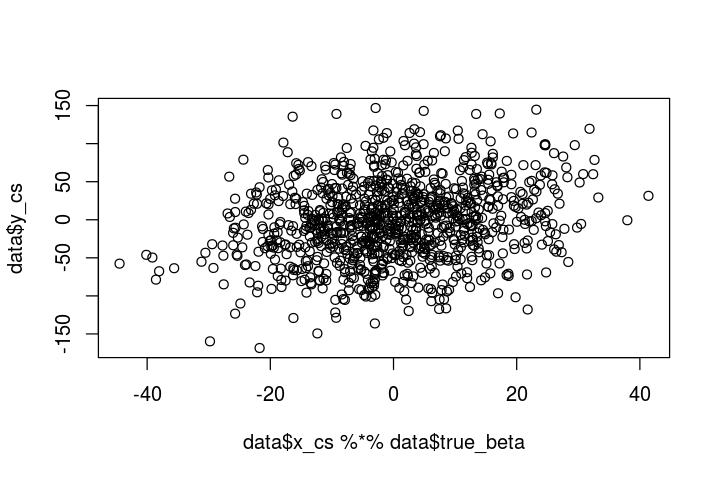

In [11]:
plot(data$x_cs %*% data$true_beta, data$y_cs)

## run ridge regression

In [12]:
ridge_fit <- glmnet(data$x_cs, data$y_cs, alpha = 0.0)
lambdas_path <- ridge_fit$lambda # the lambdas the path examined

In [13]:
lambdas <- c(lambdas_path)
n_lambdas <- length(lambdas)

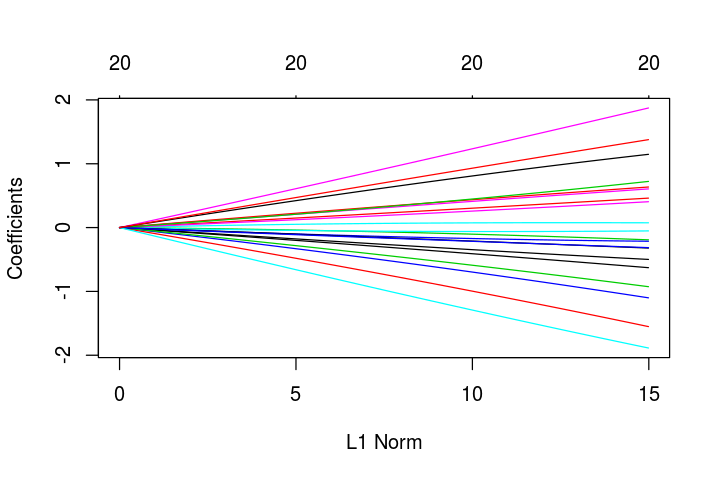

In [14]:
plot(ridge_fit)

## Select lambda using cross-validation

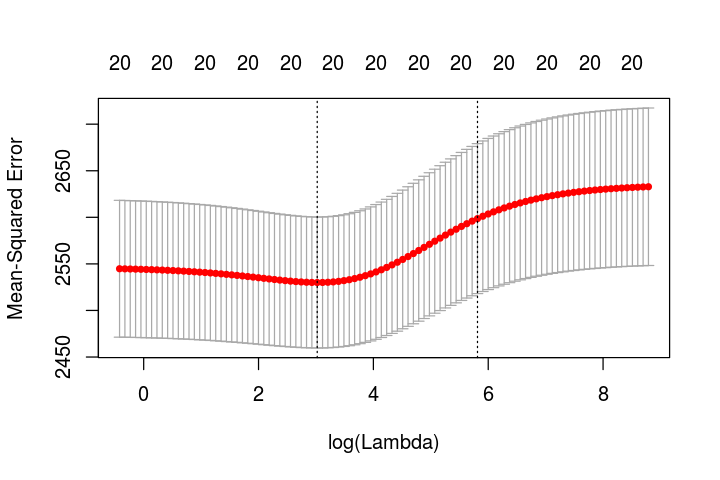

In [15]:
lambda_cv <- choose_lambda_cv(data$x_cs, data$y_cs, lambdas, alpha = 0, plot = TRUE)

In [16]:
predicted_cs_y <- predict(ridge_fit, x = data$x_cs, y = data$y_cs, newx = data$x_cs, s = lambdas, exact = TRUE)
predicted_vs_y <- predict(ridge_fit, x = data$x_cs, y = data$y_cs, newx = data$x_vs, s = lambdas, exact = TRUE)

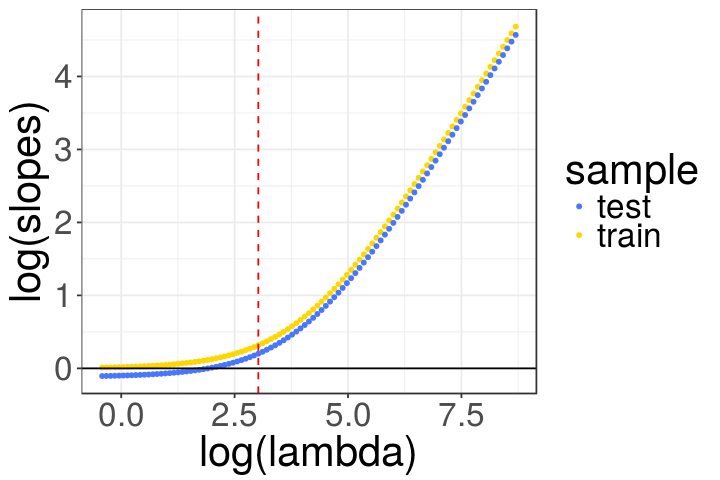

In [17]:
cs_slopes <- get_slope(predicted_cs_y, data$y_cs)
vs_slopes <- get_slope(predicted_vs_y, data$y_vs)

data.frame(slopes = c(as.vector(cs_slopes), as.vector(vs_slopes)), 
           lambda = c(lambdas, lambdas), 
           sample = c(rep('train', n_lambdas), rep('test', n_lambdas))) %>%
    filter(is.finite(slopes)) %>%
    ggplot() + geom_point(aes(x = log(lambda), y = log(slopes), color = sample), size = 1) + 
        geom_hline(yintercept = 0) + 
        geom_vline(xintercept = log(lambda_cv), linetype = 'dashed', color = 'red') + 
        scale_color_manual(values=c("royalblue1", "gold")) + theme_bw() + 
    theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))


ggsave('../writing/ridge_figures/slope_vs_lambda.png', width = 9, height = 6)

In [18]:
# slope is observed y on predicted y

In [19]:
# for small lambda we get the regression case again
# should should be less than 1 a la Copas
vs_slopes[which.min(lambdas)]

[1] 0.9004134

In [20]:
# should be close to 1
# we should be able to fit the line perfectly with enough coefficients
cs_slopes[which.min(lambdas)]

[1] 1.012023

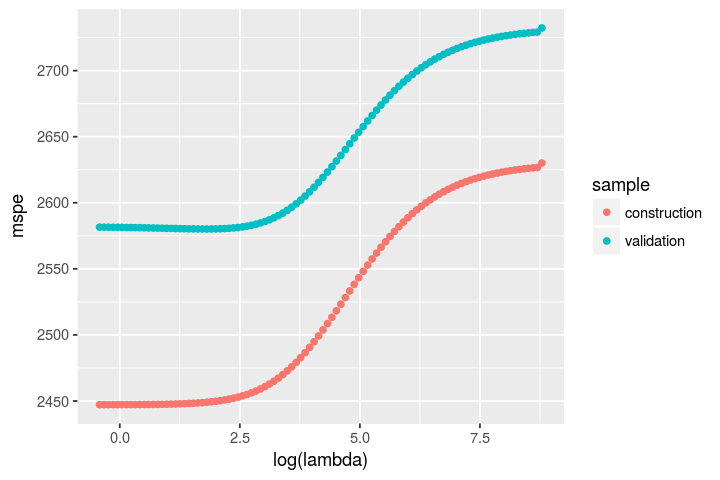

In [21]:
cs_mspe <- get_mspe(predicted_cs_y, data$y_cs)
vs_mspe <- get_mspe(predicted_vs_y, data$y_vs)

data.frame(mspe = c(as.vector(cs_mspe), as.vector(vs_mspe)), 
           lambda = c(lambdas, lambdas), 
           sample = c(rep('construction', n_lambdas), rep('validation', n_lambdas))) %>%
    filter(is.finite(mspe)) %>%
    ggplot() + geom_point(aes(x = log(lambda), y = mspe, color = sample)) 

In [22]:
log(lambdas)[which.min(vs_mspe)]

[1] 1.812628

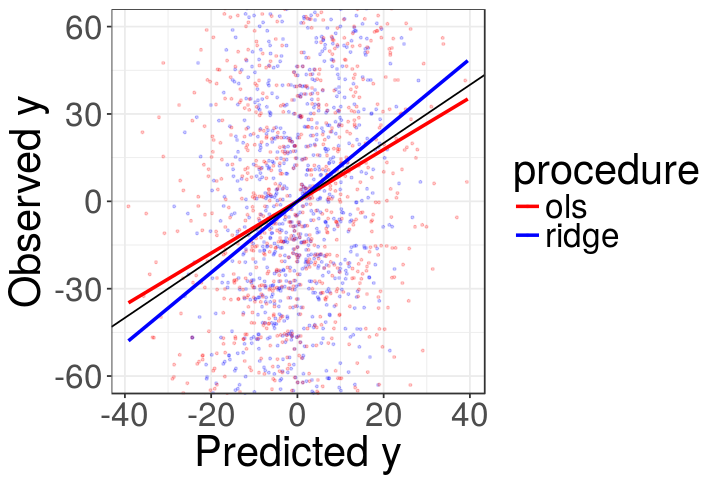

In [36]:
predicted_vs_y_lambda_min <- 
    predict(ridge_fit, x = data$x_cs, y = data$y_cs, newx = data$x_vs, s = lambda_cv, exact = TRUE)
predicted_vs_y_ols <- 
    predict(ridge_fit, x = data$x_cs, y = data$y_cs, newx = data$x_vs, s = 0, exact = TRUE)

data.frame(y_obs = data$y_vs, 
           ridge = as.vector(predicted_vs_y_lambda_min), 
            ols = as.vector(predicted_vs_y_ols)) %>%
    mutate(ridge = ridge - mean(ridge)) %>%
    mutate(ols = ols - mean(ols)) %>% 
    mutate(y_obs = y_obs - mean(y_obs)) %>%
    gather(key = 'procedure', value = 'y_pred', ridge, ols) %>% 
    ggplot() + geom_point(aes(x = y_pred, y = y_obs, colour = procedure), size = 0.5, alpha = 0.2) + 
                scale_color_manual(values = c('red', 'blue')) + 
                stat_smooth(aes(x = y_pred, y = y_obs, colour = procedure), 
                           linetype = 'solid', method = 'lm', se = FALSE, fullrange = TRUE) + 
        geom_abline(slope = 1) + xlab('Predicted y') + ylab('Observed y') +
        theme_bw() + 
    theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5)) + 
    coord_cartesian(ylim=c(-60, 60))

        
        
ggsave('../writing/ridge_figures/y_obs_vs_pred.png', width = 9, height = 6)

# We explore the distribution of slopes over repeated trials

In [ ]:
n_trials <- 100
# grab a snack this takes a few minutes

lambdas_vs <- rep(0, n_trials)
cv_slope_cs <- rep(0, n_trials)
cv_slope_vs <- rep(0, n_trials)

t0 <- proc.time()
for(i in 1:n_trials){
    data <- draw_cs_vs_sample(x_cs, beta_full, s, sigma, n_vs)  # draw data
    ridge_fit_cv <- cv.glmnet(data$x_cs, data$y_cs, alpha = 0) # get lambda
    min_lambda <- ridge_fit_cv$lambda.min
    
    # predict on training set
    y_pred_cs <- predict(ridge_fit_cv, newx = data$x_cs, s = min_lambda)    
    
    # predict on validation set
    y_pred_vs <- predict(ridge_fit_cv, newx = data$x_vs, s = min_lambda)    
    
    cv_slope_cs[i] <- drop(get_slope(y_pred_cs, data$y_cs))
    cv_slope_vs[i] <- drop(get_slope(y_pred_vs, data$y_vs))
    
    lambdas_vs[i] <- min_lambda
    
}

t1 <- proc.time() - t0
print(t1 - t0)

In [ ]:
data.frame(slopes = c(cv_slope_cs, cv_slope_vs), 
          sample = c(rep('construction', n_trials), rep('validation', n_trials))) %>%
    ggplot() + geom_histogram(aes(x = slopes, fill = sample, color = sample),
                              binwidth = 0.1, position = 'identity', alpha = 0.2) + 
    geom_vline(xintercept = 1)

In [22]:
# TODO: 
# see how this varies as a function of 1. Sparsity and 2. Signal-to-noise ratio
# now run COPAS shrinkage (maybe just a second CV step) to fix the scaling issue

# Two step lasso

In [23]:
# we use CV to jointly choose lambda and K
k_range <- seq(0.5, 1.5, by = 0.05)
joint_cv_results <- choose_joint_lambda_k(data$x_cs, data$y_cs, lambdas, k_range, alpha = 0)

In [24]:
# compare lasso predictions, only choosing lambda vs. k and lambda

# choosing lambda only
ridge_cv_fit <- cv.glmnet(data$x_cs, data$y_cs)
ridge_cv_pred <- predict(ridge_cv_fit, newx = data$x_vs, s = ridge_cv_fit$lambda.min)

# choose both lambda and k
ridge_joint_cv_pred <- joint_cv_results$k * 
    predict(ridge_cv_fit, newx = data$x_vs, s = joint_cv_results$lambda)

In [25]:
ridge_cv_fit$lambda.min

[1] 1.492022

In [26]:
print(joint_cv_results$lambda)
print(joint_cv_results$k)

[1] 7.347197
[1] 0.7


In [27]:
# compare MSPEs: 
cat('lasso mspe: ', get_mspe(ridge_cv_pred, data$y_vs), '\n')
cat('two-step mspe: ', get_mspe(ridge_joint_cv_pred, data$y_vs))

lasso mspe:  2431.269 
two-step mspe:  2533.976

In [28]:
# slopes?
cat('lasso slope ', get_slope(ridge_cv_pred, data$y_vs), '\n')
cat('two-step slope: ', get_slope(ridge_joint_cv_pred, data$y_vs))

lasso slope  1.168289 
two-step slope:  Inf

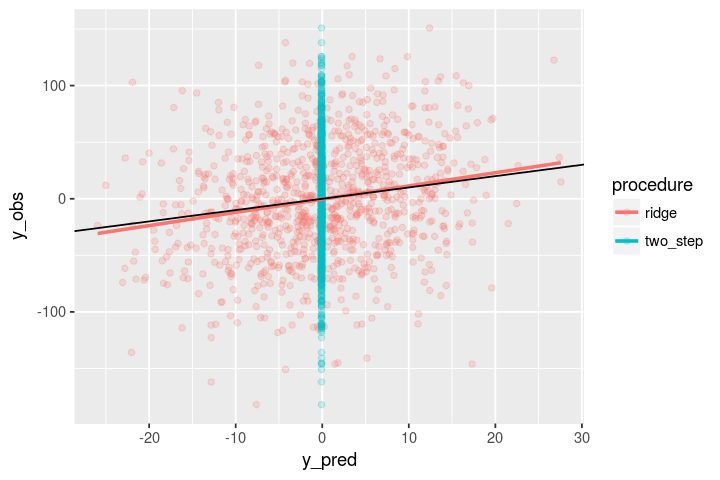

In [31]:
data.frame(y_obs = data$y_vs, 
           ridge = as.vector(ridge_cv_pred), 
           two_step = as.vector(ridge_joint_cv_pred)) %>%
    gather(key = 'procedure', value = 'y_pred', ridge, two_step) %>% 
    ggplot() + geom_point(aes(x = y_pred, y = y_obs, colour = procedure), alpha = 0.2) + 
                geom_smooth(aes(x = y_pred, y = y_obs, colour = procedure), 
                           linetype = 'solid', method = 'lm', se = FALSE) + 
        geom_abline(slope = 1)


In [30]:
# Again run this two-step procedure for a number of trials like before 

In [31]:
n_trials <- 100
# get another snack ... 

# two rows, n_trials columns
# first row stores the k's, second row stores the lambdas
results_mat <- matrix(0, ncol = n_trials, nrow = 2)
rownames(results_mat) <- c('k', 'lambda')

joint_slope_vs <- rep(0, n_trials)

t0 <- proc.time()

ridge_fit <- glmnet(data$x_cs, data$y_cs, alpha = 0)

for(i in 1:n_trials){
    data <- draw_cs_vs_sample(x_cs, beta_full, s, sigma, n_vs)  # draw data
    
    # choose lambda and k
    joint_results <- choose_joint_lambda_k(data$x_cs, data$y_cs, lambdas, k_range)
    results_mat[1, i] <- joint_results$k
    results_mat[2, i] <- joint_results$lambda
        
    # predict on validation set
    y_pred_vs <- predict(ridge_fit, newx = data$x_vs, s = joint_results$lambda) * joint_results$k 
    data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAHgCAIAAAADp837AAAACXBIWXMAABJ0AAASdAHeZh94%0AAAAgAElEQVR4nOzdyY+kW1Yg+HPu8M02uvkYk8f0psx85OORUCTdWVQVTSOV1OsWEolgwYr/%0ABLFLWIEQUi5y1QtogbprUYUaKDITciCH9/LNMYfPNn7TvfecXpiHh8fk4R7uHuHucX8Ll/yT%0ADZ/ZZ2bf+e499xxkZvA8z/M8zztO4lXvgOd5nud5Z58PODzP8zzPO3Y+4PA8z/M879j5gMPz%0APM/zvGPnAw7P8zzP846dDzg8z/M8zzt2PuDwPM/zPO/Y+YDD8zzP87xjp171DhyvoijKstz7%0ANmmaKqWGw+Fpr4EmhIjjeDKZvOodOawwDKMoyvPcGPOq9+WwGo3GaDR61XtxWFLKLMuqqnru%0At+nki+PYGGOtfdU7cljNZpOIxuPxq96RwwqCQAhxtB+tTqdzhI/mHZUzHnAws3Nu79sgohDC%0AOXfaAw4AQMTnvt6Tj5mFEER0Bl7L9KP1qvfisKbfEQA4G6/lzHy04EwcEWbezw+1dwb4KRXP%0A8zzP846dDzg8z/M8zzt2PuDwPM/zPO/Y+YDD8zzP87xj5wMOz/M8z/OOnQ84PM/zPM87dj7g%0A8DzP8zzv2PmAw/M8z/O8Y+cDDs/zPM/zjp0PODzP8zzPO3Y+4PA8z/M879j5gMPzPM/zvGPn%0AAw7P8zzP847dGe8W63nea4gAVo0dkWPAROC8UhpxrztYKyZjMDUICXFMUQx7397zvIPzAYfn%0AeWcKA3xSVh9WdVsIRByRuxQE1wMdiKcP6KIxuLGG4zFrhUSwck8snadW+yXvtuedeT7g8Dzv%0ATFm37oOqvqS3BzWaUtyqTSbEpeAZAcdgC/OcswwAGIDDUNy5BVEEYfQyd9vzzjyfw+F53pky%0AIWpKsXtKpKXkmOipN2ZyYC1H4c4WFJK1xro+7v30vNeNDzg8zztrmB/7l5+VkYGAT97ep294%0A3nHwAYfneWdKQ4oREe0KIvqOGlI+/dZCsNKiKh5ucQ7qmsPw6bf3PO9F+RwOz/POlK4QX47D%0AnxZVUwqBMLJ0JQwW1TMCDgButdlZHPYhCMERlLk7fxECH3B43hHzAYfneWcKIl4JgpaUI0fE%0AnAQ4p/Uzww0A0Jp6cxDFwlkWgsMliJOXtree9/rwAYfneWcNAvSk7D1rGuVJUkKr/fS0Us/z%0AjojP4fA8z/M879j5EQ7P87zX2pZ1YyZiSISYkVK8xFU66CwP+sCEtYE0ZelPSWeZP7qe53mv%0Ary/q+gd52ZRSIIwdXQ/0G3G077mowylL7G+KqgAd4GQCjSa3OxDFL+fJvZfPBxye53mvqU1r%0Af5iXl8JgeiboSvlZbTIpLwT62J+bWQz7UJbcbKEQICSUpRgOKAwB/Vz/2eSPq+d53mtqRNyU%0AD6cxEKCj5OgZVVmPFhqD66sQ7aofH0W4seZrvJ5hPuDwPM97TTHAYxkbCECPFV49pqdmekpL%0AXkSml/Hs3ivhAw7P87zXVCJw5B45w4+I0v0vJz4MpbnbQ2sebrEGieAlzOZ4r4gPODzP815T%0APaneCIPbtRk5yplXrF1Uakm/lNw+KTlrwHAAeQ6mxrLA4cBdvAx+ocrZ5Q+t53nea0ogXAuD%0AhhRD5wDFopKLWodPznQcD04zunwdnAEiFormF32N17PNBxye53kPVcwTIgBIhXiRUy8zVBWS%0AAyk5DE9+61mFeE7rc/rVTGRwHEPUASEoz1/JDngvkw84PM/ztt015p8neSQEAJREv5Gmiwea%0AXzBG9DdxfRWlYme5N0/drp8j8Lwp/03wPO+0qpkHjixzJLAt5d6DCViVYAwgAPNTBx62rPuX%0ASXFR61AIAKiY/+ck/09Z2nl2p9nHiMEWDgfc7jIiAOBgSwikbu8pyzE87/VzxgMORJT7y7iW%0AUvJLWQx2fKavdJ+v9yQTQkz/noHXAmfiiExfwkk4IgSwZu3YEQBbxoLodl1LgIL5nTi6GgZ6%0Aemq3FiZj4SyjgDjhKMLNDbx3m3XA/U05mfCFS9xoPvbgA+tmAh0/eI0xwEwAA4B9NoHDuhbr%0Aa9Tp4k540WiK1fvY6YIKjuodeMwrPyKHh4gn4aPlvQRnPOCQUjYajefeBgCyLHspe3SMpt/b%0A577ek28acMRxHO0uCnQ6nY0jMj2Daq1f7WshgA/z4sPaNKWqmX+eF3Nav9NuCwQGuFPV3SC8%0AGoVcVTAa8LCPYQjW8tY6zvRguMXnLqAQQgjVbPHafeh28dEq2qEsWlrvXhTqnAu1biT7KrbN%0A+QTSBB79JeGyFElyHOW6z9j3XakzfjLy4MwHHNba/Hm5SK1WS2s9GAzOwAhHlmWDweBV78hh%0AxXGcpulkMqlPf83Bbrfb7/df9V4cllKq3W5XVTWZTF7hbtw15gdFeV5rBBg7KovyRplnppqR%0AEgBi5tt11Y4jtbYiRiNOEjAWAEAF8qf/7ubmYTIBgCRJ6rp21vHKCrXaux+/NmatqHBX0saa%0AsZ047NfVfnYPrRHDEUmN4kG5ASIxGdnxBMp9PcKBzMzMENEZ+HRFUSSEeO4P9YH0er0jfDTv%0AqPg6HJ7nnXQMUBONnGuK7cKYBCwRMiHzaR1uZknuo6pyzsrV+xTvGhuTEqRE5x55RCH4iQLe%0Ac0otBLpPjpiJuU9uIdBz+77yZqVp6bwcD9E5YEZncTigcxfBX7t7HgCc+REOz/NONcd815gt%0AR7+o6lgIR9wUAhE1QEUcCQQAzHMs87y/+aV2NyDLTPhoTihLhcbsHsBEY56MA2LES1orgJ+W%0AFQB8OQrPaR0fJN+TWi0QiEUhNtZoZpYXz1Gj6fNFPW/KBxye551ct4z9SVHNKnkt0Let/UFR%0AJCKZ06oh5ZVA/7Co5g25jbU8Stey5lvk1PoKxwmWBe+UkHKOpQJjscg5CNlaHA2p0+X0KWlb%0ATSmaMrwaBgAQHHxpCQrJrQ43WtSbAykB/eoUz3vIBxye551QOdG/FcVysN08/bzWZUQf1bVE%0AUIgM8I0snhkOME1nlH4HcUYgqRauriAQkGOlkQjKwi1fwSiG0QCtRa25N8tJCuKZE8ovEGo8%0AQog9HtzzXls+4PA874QqiQIUOz9SAuBqGIzKqiNlKsS1MFgAUDfWXW/24cISRIgjWjzHjsAY%0AlgIWliBOGADCOWbGZoPLio152hN6nneMfMDhed4L6ud5UVcCsBFHSXj0a5gVCvtoaqcAbAp8%0AK4riafKos2JayGv3mAQR64AbT1uJivjcWuMl8z1jp9XNMyEWtTpogXOsKxgN0VpA5DCirIG+%0AyITn+YDD87wXQERfbKz/ZHU1VpqZJs79h8WlpW73aJ8lk+KtOLpXmxklAYAB1pz9yk60AQBS%0A0cI57G9wmk0jCSxymJnlMHyxZ6yZP6nqu8Y0hQCAO8ZOiN7YqSe2D2hq8fEvIE440EAg+1to%0AapqZ9cVGPc8HHJ7nHdjKaPjB6vqlZlMiAkDt6Lv37v7nMGg9LRPzhQmAi1oR8ydVHSDWzG+E%0AwXL4SNVObneYnFhfBaXQEXVnuNUBfJEUiprox2X987Ja0JIBE4GxgBt13RTiQrDf3mY4HECc%0AcJKgNVBXDCBu3oAwoicKm3re68YHHJ7nHVh/knfCUD64ag+kaOpgWBZHG3AAQCrEW2GwqJQB%0ADgBbUgh8bMmrhNl5ajTBWpCSwhDFi8xfFMyfVPWPi6IkqpjGrnovibpSZkIUT1Ts2Iu1EIZY%0A5OLeHQhCEMj5GNfuYxSxPq4C5553KviAw/O8A2OAx3qlKSHIHUutXonYfV77NH5QO/yF5y1u%0AVPWqtfNKrVubSZkK/GFR/S9pTABSHPBRrcF8wmkKSgMAOMaiwP4W9+b8xIr3OvNrtzzPO7BI%0A63xaOPyB3JrwQJ3cT5Ka+Cdl1ZEyk2LkiAECFCHAyFHfutZBhkw4isRoKMajB9EGgakoa4q1%0AFXis2qnnvWZO6w+E53mv0EKzldf1ep43As0Mm1W93Gz2Tm+aAm7/6Uh5LQo/qqpY4IDdrdr8%0Ax0bS23d7egDgRotaHVy7D1IBExjDC4sQBDABOOXdmjzvkHzA4XnegSVhsDzTjZQqrQXmN9Nk%0Aod05vQ0/NcCXonDd2paU57RqSjFyJLj+7Ua6tO900W1C0OKSXF+FNGWpIAxZaawqmpkDfcCH%0A8ryz5bT+QHie92plUXwtiokZ4dSX8EbEc1p9UFU1cyIEMVdEv9NqLr3QJBEr7a5eF3duQRAy%0AM+Y5FDnNzR/5bnve6eIDDu94mBrLkokwCB52tTi0GmDLWkMcSdERQp7y89wZIM7KIWhJ+TuN%0AbMXYCkABvBNFMweZSXkMN1p0KYBiIog5k3TuArxoaRDPOzN8wOEdPRyP5I3POAwBBZiaZ+Zo%0Apnf47hJb1t229lZVa8QS+EoQXA2D6Kyc8LxXLhXiSnhEK1cROUkgSXyaqOft8AGHd9TqWtz4%0AnFrt7Sx9YLG1AVpTu3OYRzXMt40ZOHfuwZz6PWMUwJuRv3A8s/rODR05gFhgT0r1ZHDpHE7G%0A6BwIQVEEx1Be3fO8o+IDDu+IYVlwEDyINgAAKUmgKh9veHFAI0ef1+bSrgy+GSn/vayWw+Cg%0ArS68U+FWbb4/yZtKSsScaDkIrofB7j6uaK3YXIf+FmgNRLIs6eIyn96VMp531vmAwztyjAIf%0AWf+H4vALAgng0UJTIBAR+CA1IE85a8EalPKpBSstc8FMzIkQ+2/8cWKNiL6fFxcfNDHpSnnb%0AmFiIK7siThxswXjEzdb2v1Esbn7h3ngLfEFPzzuRfMDhHTUVgDG7xzOwrihrHLLGYoRYEtld%0AH9kJ0ZtR9FoMbzCLwZa4extQMhPNzkG7y7vWWG46d9fYj8tKIF4O9JxSC6e2BtfUyFEq5e7I%0AqSPlyDkGvb2JSNy/6zrdnVuwlEJrrCpfQdzzTiZfadQ7YpwkPDuPowGYGpzDIoc837kMfWGZ%0AFO8n8Z3aTIhr5oFz941dUPJ1+ATjcID377l2hzod7nTFcID9zZ3BnQnRfx9P+s5dCYPlQBfE%0A/zyebFq792OecAyM8Ogw2XT7zlAZMwDgo03a6DUIPj3v9Drdl0HeyUTtrlB6mrfBUcRL548k%0Am+9iEIQotsgZ4kzJL8dRV774wsVTgwjLAhrN7Z5kiJxmuL6OWWO63njDuqYQjQeLgCKBM4Fa%0At657astwAUCCYuLISd5Z+TwiOq/Vw1W4UtLcAo5HDxddE6Gxp3R4gwGI+XiXeTMz04t1tvO8%0AI3GKf5K8k0tKarUBAIAP0U7rcQJgUatFUEf5oCcfkVhfpW5v9zZWYqcxh2EOHu0uFoA43eMb%0AAB0l342jn1VVR0iJOHFuIdDnH63Uyc22WL0PzKw1OIdlwUvn+bSVu6iYb9dmwszMIeKS1s0j%0AH7ZzToxHUBQADFJy2uDkyErjeN7++YDDO1bHEhi8RtEGAEhJvTk0hndGLJjROXowuhMILIl3%0Az46WTD089XNNlwOdSTFwzjEsaTWvZPxoKRcOQ3v9bTEZg7WMyLPznKavam9fjGX+tKpvGdOV%0AUiBuWfuzqvrfsyw7wpiDWfS3xMYaJQkIiVWFayu0fM3HHN7L5wMOzzvZEDlOxNZtaDRYKmCG%0AyYRmZjmMpoFXT8olrbesbUkJABOiLet+OY5f7V4fnkCcV2p+74mhIKCg+7L26OitWftZVV94%0AsPSmIyUx3LPmujy6cZqyEKv3qd2ZZm1zGAICjoYcx4fM4/a8g/IBh+eddNxousVz8vYNFAKY%0AaX4RWh18cLkfC3FBK4nwQVEiw/UofKORtl6LbNpTr2JIHz1SicDqSHvKonOk1COxhQ7E+gr1%0AZuF1SIHyThIfcHjeiYfIrbbNGmAtSAnTi/5dC4/bUjaFXNaaAWJjVFUSAITR7jNKyTwhAoBU%0ACF8P/oSQCJYYdp33HaA82oODKPjRcjXO0cysH97wXj4fcHjeKSElSAlEOOxjWQIzS8lZE6II%0AAARCgij6/eLO7RtKFQzcaGRZtthsBYh3jPmfkzxCAQAl068nybmDdl33jkFbyCG5FslQIAA4%0A5g1rrwRHOh0WxdRqQ1VCEAIAMGORU2/u8L2NPO+gfMDheacHM25tyI01ilKUAvMJrNynq29w%0AFAEAjsfVvbsfN1urzE0hqKrvbN3Ol3UvDL47KS7qYHpWq5m/mxe/KfBUr5s9GxpS/EaW/uN4%0AkqAQiDnRV5P4aIu2sZTcaAkA7G+BlGAM9eYOXxfH816A/8XxvFMDy1Kurrh2BxEZAOIEUIjR%0A0E0DjiK/EyUrDHPTi9dAx1Z/Nh4NsNVR29fQABAgdpTcctT13/4TYEGp/9psjIiIIRHYPI68%0AiiShMMRGE5xjpSDy6aLeq+F/cjzv9LA1Bxp3ny2CgJ0FIhACiAoB2e6aHEI0ACfkwkfHzzWi%0APXR3m+cigPvGDIiMc3FeLJBpMbNSkDVfebWMnOiesQWzAGhIsaDUcxrQMIsih8kEyIGUkGYU%0AH9my0liI+LgnOKTk5JStGfbOHj+N53mnBwpwj7arm8YN0xWPUkpjHT28ATprhYgE5uR23ykn%0AFx3/FP4XVf2veblpbDno31tb/W+jcb8yYjAQn/wCqvK4n30PBdGntfm8NmPnBkQ/KcpPq/o5%0AXQBHQ7zxOeZjNAbGI/HFpzgevZy99bwzwwccnndqcBiBMWjNg/8ZiwmE0XbAkTXbVblZGccM%0AxFAUptHq6+BqEC7qYNM5x+yYN51b1MH8MXd3Gzr6UVGe1yozJt7aamfpfBDeFkhJgmmKw8Gx%0APvve7tRmpTazSsZCJIhLWn9cm3XrnnkHa9XtG9BscRhNpyQoa+JkvFPs1fO8/fABh+edHlrT%0A5as4GMBoAOMR9vvc6tBOAmAU9S5f+VKW3hwMVoDvp43Pw/hrWbKg1XKgF6T8tDaf1mZByuVA%0AH/fK2IIpFkIiorOgNCJmCB84qpkpCNA54OeMKRznvvHuUp4IkOLjg0C7oTWMkndnV2iNm+t4%0Ayjvked5L5nM4PO804SS1b7yNVQnkWAWP1YsUSXo5SdszvRwYERtCNqQAgIYQb8fRtSgEgOck%0AKxwRAUgPp3sIAKb/CkBkYMRXWKFeIDwW7BCzePb+MADAEzNZDCB86qXnHYAPODzvtNGa9V5V%0ANDqB7jz1fi9xbUJTiothMHYuDUIwBpzbQPGekhoY8gn05l7hQommEB9ZlzxoeWcBhkTNPZJa%0AgpC7s1Dk05InAIBlwbNzrF68lokhZoGaGY/wfWBGIkb0NTa8k8kHHJ7nHb0QcVGr/1GWmZB6%0AdrFYvXctDC5IIeqaZmbpldaBWNL6Whj8oqpSFIQwdvS1JG6rZ69HFYJabQEsBn1WCq2lVptb%0AnReLmQriW3VdMH9U1e9E4aLW3aOoQ495jqOhWF+hmVlWmltt2DMq9byXzwccnveSYFVBXQEi%0A6wCevS6UAPqOCucCIVpSBKe2ZEJPyv/abPads3EYZemMrRSD05rj5NXWgZCIb0bhrFI5EzI0%0ApXh+9YsoYj3n0mzap5fjGOSL/Hga4s9NfdeYjlLXg2DL2l+U1X9upO1Dlt8ocvHFp5Bl1O0B%0AEfY3kYlmZv1Qh3ei+IDD814GMdjCO7enUyHSGDp3gVrtJ29WA3xa1R+VVSTQEl8Mg/NKdp4s%0ACeocViVYC1rzgzpOFfPQkWWOENpKnYQ4JRYYCwUAoDVAfIRpogVzQSQAUhT6yVyK6VqeaWz3%0AtHM5AswoOQMHOM2zlJA1Dlm9ZMO5z8oH7WERGlI6gPvGHjLgEOMxp+l28XJEyBq4tYFxwlnj%0AcPvreUfJBxyed+wwn+DdO9zuTK84iQjv3kIdcPJ48agbVXWzNpe0mk7tD6wD5lSIYPelalXK%0AQR+2NlhKNI57PerMrAPeNea2sRKhIH47DK6GgTq1oyN7YICbtfnXoggRHcPVMFhS8mGZdmYx%0AHODtm6gUE3O3y80WH12RrkOqgR+r8RUj1od/XHKo9CPBkNLo3LEXd/O8g/ABh+cdOywLiOOH%0A49tCQJRgWTwWcNTEPyqqq7tqiTak+KI2S1rP7JykiMSgD/mEWx0AYAAc9iuAe432hPicVgDA%0AzJ/WdSTEpbPYoe2+MT8qymUdTMdw+s4xQCLldKEvTsZ47za1OyglTKexhgPQep8Jno55w9F0%0A7KQpRetAAw/WYj5BciwVJCk/7b4S4LEarwYgO8BzPAPidgnUHdPsUc87SXzA4XnH74lffxb4%0AZCEKQoAnauPIR1dkYl3h5jq3uw/vlWSj1dXbKlqKtvNCELGn1MA5Bn32zjmbjmbVwxmjhhB3%0AjJmRYklrAMCi4CTFB6deDgIcDTlOYB9pqob546r+tKpTIQh46OhrSXQhCPa1W0UuBgMYDVAq%0AcAYaLe50IYweu1VXqTEXE6JUCACwAOvWXTl0XMhxghsb0FLToBZNzY0mPDF+5nmvlg84PO/4%0A6QBM/cjpp67hiWvuAPCtKBg5Sh9EJ465JIp25Sgg82MZl4hoEdSj180SgAEIDpKkcBows2V+%0ALD9FAbidKhrOoZSPvBdCItF+JhfuGHujNhcDDQCWORXi+3nZkvK5KaVMTo6GUBXQaDIRQARl%0AKQZ9mp1/7GDFiL+Zpnet/aI2grkEej9OFg69nIQbDV5cwju3UGtgonYXmq3DrNr1vOPgAw7P%0AO3acNbAscDLmMEIAKAtutemJhD6BsKDUx2U+rbptmDec+2oSN3bN+pNU0rrtbm1TxoSdXo7A%0Au4o6TIhmtT4J0YZjNgAa8eHOECERSwF44DUUiBggDpwLdwUBJXHw4LTOUmJV7F5CgtbQ/mZG%0ARkRdKUviFWs+rgwAtKS4ZeyXnnd3rGuxsU5ZQ/Q3cXMdALjT48EmtDvbiZy7zCjZEHhOKQJI%0AhEiOpnoYUruDaQamZkQOAnyhRTSed6z8h9Lzjh1Lyd0Z1BqNYQDozHCz+dTVE7NK/cdGumpt%0ATRwJcUHrxceangQBnzsvVu5xkrJUYAzmk/b5i2/p8NPazEihUEyI1q37SvSKO7I65rvWblr3%0AcVVdD8NESklkxiNdle3B1kzWFEwcJ6TkZhiNdAgAmRRdKUSeQ10DAAThY6VUAWBeqQ/KSqFI%0ABDLzhqPLYdDdmUPJMlhbQRS8PcOSU7tDSfLcszozM4Bjvm/thrPntBbAd43950l+MdCN568v%0AZTEaQjHhZpsBsCjExipdfoOfCDgAIBCiewzrVVnrae2NszeP5p0NPuDwvJdCB9zt8bRM9p5n%0AhBkpZ6SkZzc6omabhRRlIdZWaHaeerOYpJeZIyEGzjHArJJficPOIUs7HNptY39SlnNKXQ/D%0AoXP/OJ606vrKcMvFyU+D+L3bX1x11nZ6n0Xpz6oqnZ3jOB47+lKZv9FfxyAEAKwrNzvPM73d%0A71hXyf81S1es/bAsGfDdKLwQ6IdFVOOElq/geCTWVgGY5he51dnP5T4ixogfGrvu7KxSAMCA%0AiDiv5H1jG+GemRw6gHyCpuZGC6b7KpFnZtFUfp2I5+3wAYfnvUz7vfjc6wJYCG62XLPFvVkU%0A21FFgHgpEAyamOUJWJ5QMX8/zy8H20tz+8Saeb2/+WajkSE0JsUP0lZHYDUe/jxtXkoTsXaf%0Alq/2qvrDrc1Wsz0vBQBwnIjVVQqjx+pJzCrZU/JaGAiAJwujcZJyknC3x4hPHUZ6lnNafark%0AbWNKYgIeEl0N1YxUFT8vbJCS5hfVZx9zVYEU0yop1Jvz7WQ9bzcfcHjeS4LOMfCzKlQyQM0s%0AAfZfPGMn2ni4BeAkRBsAUBEpxOlrYYCSqIlYA9YAETk9HqVZNmHIhWoRYRiwkFzXwtatIBwC%0AzE8fBRGSGKoSnsh3QYA9G94iP1kt7XkSIa6Get3YVKBAcU6rGSknzPK5AQcAN5quNw9CADmM%0AlJuZBQA+eJLK/tXEW8asGxsJbEl5HEediURVgnMgJUfRC+TceN5uPuDwvGOHZYGjoVi9DwA0%0Av0jN1mO5hCvGrjr7YVm/EQaZFOe1Dg8XN6A1QMRKP1ncenr6dwAh4nG0cxs6N3BuQrzp6CKR%0Aqis0Bq0jRAckYbv7KhMiOmYS031gAARmEg+mnbb3lgFe4rTEolKxxAWpEikAwDJsWPtGuo9s%0AmDgFZsgynhbgIsLBFvfmjmk/t6y9mU8+zYuqKEumt8Lwahgc8dE0RvY3xfo6KSmco+4Mtbuw%0Az0XCnvc0JyXgcM5985vf/Na3vtXpbPe5ZOZvf/vb//AP/+Cc+/rXv/6Hf/iHUso9tnveCVVX%0A4tOPOc2o2wMAHA6Fc9Sb3RnqWLPunyf5vFbXw8Ayf1LWtaM342ivy0nnsK6AiJXavdrWMI/K%0Akob9eH29iczdWU5TbjR3bpAT3azNT8tSIjqA/xDH54KjrNVxx5jvToqGFALAOvrB2sYvjwc6%0ACmKCz2vzdhSlZQFRXGWNibENW1GjPVSyaSy0mqw1GD10g8vw8AQv6srq7aIjDDB0rmJWAE0p%0Ad4aCeDpTRQRViUSgFAfhM9u17DlckQnxjTS9Xdef1LVgcAi/msSz+2iuxkFAy1dwNBRbm8DE%0AjuniRU6PoKbXk2rm28aydctRNKxrBvi8NgHilb0TTQ6EWQy2YDigTgcACADHY4GCerOvtg+O%0Ad6qdiICjruvvfOc7o9Fo98bvfOc7f//3f//Hf/zHSqk/+7M/Y+Y/+qM/2mO7551MOB5DHO90%0ANuckwdEQo5hbbQBg5hVj5rSaVoJSiPNafVSbOa1nntW/tMjFcIBbmygEW0Pzi9ydARR9524V%0A5Y2tLVUVZdr4spJXrVG3b9ClK5ykAGCZv6jNXWOuBQEiVsz/VhRK4MLBZx+eauTcv0zyi0Ew%0AzatoQfHv+ehfk/S8FAXA2zrgfNRPMzca9hl+bWO10W5HoV4uyxumbjaXGHCggyuN1uJkAGE8%0AXT9MnS40mgBQMX9QlB9UdSYlA18Ngnklx8RjImJWdd0e9dv9rUQIhUBzC67dxd2XItMyoJMx%0AJwk6J6RyWfbUZFLLTAATR47heqhHjj50tUacUXLvPFyOYixyKAtAQCGAeLp6Gc60Sw8AACAA%0ASURBVJ2D8RCNAUQOQkozPFxPtaGjG7X5spTMDAAIMKvkiMgyH1Uxe7QWV+7zTG9nCycJrt2H%0AZvPJamaet0+vPuD427/927/6q7+y1u7e6Jz7u7/7u9/7vd/7+te/DgBVVX3rW9/6/d//faXU%0AU7eHz+696XmvFjrHj1V2UgoefOAtwAdVfXVXrUkEiARW/PSqXegcDgdQFtzuMAAwy411Urps%0Atm7VZlAUl/IRpBkBfEwcSLGcpDiZTAOOvqNP6/rig50JEeeUXjN2/iCd3hhg5FwNrKu6CYxC%0AQhjWAPeM/ayq12ub5PksUwgQ5ZOvhAEH6qoQIUKEuEFRnmayN9dk6l6+7KwV1l6TIgvCsVAA%0AcFHr+SyRk4TrigGg1easAUIMnPtuXvzTJO8IqRG6Sq1Y81ltkHhGifW6+uHK6uxoOI/wjjOL%0ArXZvbQWEpM720AgOB/KLT3H1PgYhLCxhGGBVSzNDMw+v1xlgw7mPy/p7ebGk1LLWIPC/j8bn%0AdXA1Cojh34vy19N48YkiXVjkOBmDczge4WRCcwsgJRCJtRUChmZbbKzBcMBBAMyiWIXeHPdm%0At5+UuQKwzAea3nLweF6wAvioqt+OHwkF0DlwlqU6UObs9o6RgycKhKCQQEfYgM977bz6gOMb%0A3/jGu+++e/PmzT/5kz/Z2fjFF18MBoP3339/+u/7779fFMVHH32UJMlTt3/lK195Bbv+0hiD%0AD66QIAwpbbzAL8hh1ET3rRszEXEq5aJWe+breY9gRHQEu89T9LAapgR4MwxK5t1H1NKzL1XL%0AAgdb3HzQaRaRkhTKYpBkN425iAxCAoAAmBU4BHBKS2eBGRBrpsfWdIQIH1b1W1EYWDOaTPrW%0AGiHDNJ0Nnp4QUDN/XtU/L4pwPDaj/ttSXSKje/OfxukXxJaczcd3yrII1UUU0WgolVZKz0gx%0ATdRYQiQlOUthV712DXDh0Wd5rI9uxfxZXX93UrwdhhKxYv5xUS5r/eOi+i/NtGT4fGvwdn9j%0AkDUTgVtMnE+SKArLYnuAIc/lnZuoNHdmOIqYLNxfh6ULuL6GcbIz63HP2O/lxZgoEThmul3U%0ALSkvBcGQyBF3lUyE/qdJ/n+0W7vnLXAyFjc+4yRDYLx9U4QBpymnGQjBjaa8e4esg+FgZ5UN%0AB6FYW6U45jQriG7W5idlKQAdwK+n8Tm9r+mtELEkol1LnnKGt6Pw4UfMWRwM5L3bjIjMdO4C%0ANdsHa1WvNBJtxyvbR8UBOdSBX+jrvbBXH3C0Wq1Wq2WM2b1xa2sLAGZmZqb/JkkSRVG/36+q%0A6qnbd+5YFMVf/MVf7Pz7/vvvv/fee3vvwDQFJDmxfQesgWGfJ2OIImCA/paQkntzT/58IKKU%0AMk3To31+B/BFUXxuqa0CRLjtnEPxZhxFhxsW3oNSCgCiKNKHLvn8yiFiMjsLwz5rjdOZC2uB%0AGXq9naHpJa1/NCnOBXp62Tpw9q0kORdHTy74BABwBpIU4vjhFmZYXw0Wz2fAoRQ8GmEYAoBm%0A/ti69yQEaQZZBgAtYwRBvGumP3f0Xpq0yN2/8fk/CNWWSpHN6zqfmbneaCQP4lohBABordek%0Auof2LSJJhnuza8SBEK1icofx6tzsYDC8bcxso7FFNFCy2emONtZ6QOn0y8UMVQGtFhzwI7pV%0A12ulaUdhEgSIGAEI50YMrQhUGI7qei4fh0naCjQBzCDcC/TCaNTub8DyZVCaJyPsdGE8Bokg%0AlVIKayMRsNkErac7UxH/W9m/3MhuVnUKoAACaz+oql9JErZWhmEc6BigLySHYfpgBorJ4aAP%0AcwugNVYVNxqcZnpzA9odUAoAsMwBkdpt1LujFGYlKUm+KMpVQV9utwVAxfyzqs4SfW4fWZkJ%0AwNe0/ryqZ5TUYZST6zv71WYzm+4YM2ys8XiI5y4AIpODfh+iGHfNj+zLm2/j7ZschKwUOAvj%0AHK+9Ca3nt6Q5KCklIh75D5d3Ar36gOOpxuOx1np3NmiSJKPRyDn31O07/5Zl+dd//dc7/4Zh%0AOJ18ea549y/4ScLrY1eW4sEYLGQZbW3KThfTp3/zj/yF3Knqm46vNLYvBDsAd+t6Vsir8fFO%0A5QbHlA+/uyj4vrlDNCWJZ3okBH32CQYBM4vuDC4u4a5eYtejSIThvw3HkUDLfD3NlqOw9Yy8%0ACibnEEQY7FzfclXixeV2ljnrglbC1kJZQBSNiH5JqSQfq5kexjEALEXRO0Ler+sZrRGgJtri%0A+q0ops31f85a16Jwe+CqLFYn42aj+c6jnyUrxE+tfSOO+O4t7HQAcQngY2Ovt9qtzc0A53tK%0Avp0mn6IIhZwosZVl/cp8oywC7AAzF7k4d1HMzh0061AAdlJ6I1AF8bStTEJy4IiIGlE0dC4K%0AtKwcSKkRlcCYgIUMFs7JrAGIHASUpGAM1zAtxCmjUEmJKhBxPH1nSmuzIGjH0SrD2DktRaZU%0Af5I7IVjJJAzDQAOAJo6jON6p/VpXdtgXs3MAAIhOSIwirmspBYQhEJFUIonAut2LO9jUGMWb%0AWn8+zne+ViGACoKRlGEUiX28P1+KolZVbRn787r+Spb9chjM7UTndeXW16A3+zBTJIxo9b5a%0AWHiyfc9eoojjBCZjd/+umF/ExXPYbB1fxugZuLrwnuuEBhxZlhljnHM7sUWe51mWJUny1O27%0A7/jnf/7nO//2er3BYLD3c6VpqpQaDoe8j9X2Lx9ubYK1MB4/3OQcb6w/uVZQShlF0WQyOdod%0AWKlqUdVj+3AISjq3Ykyvro72iXaEYRhFUZ7nj417HQoTDIdY5MAMUkKa7WcFAQOsGLNm7Adl%0A9XYczSi5oPWBopVmszkcDkFIXL7KVQUIEITAAI9+LOcBvhGogkiBaFiDE/vMTy0zpk24e5fT%0AFFGAMTge8ZVrIp9cIvfxoOhJGQDm9+7eR1wGKi4sM/HO0/WIclP/eDBUzhpjfi0MGqP+/ZUV%0AGydrE+sYA4QWYnL/3j+hnLPd6cSKlDLLsryqyrwoEKAuoSimD+icm9SqqOp8POIin6lL1OF9%0A5wInl5R4PwpQwMQ5ROR2h8MIhsODvH8AAJUx/UkRC/FRns8oFaIYkMvJZShMnpu6HhlKdbA+%0AnsxpUaEcWAuDrbG4sv1ceY7DAToHW5uQNoIwtHnhpEY75JlZHgwAYOzcKJ+MnQ2t+0Wez2kt%0AmFuAN0fjK1GoqnJcVxOiBSlpMh48OOmiNZhPeDyaruiFNMP1dbYG85xrA+MR9GaZQayv8U58%0AyYxbm9zubgyHtijG7mHuGjH/a1Wft62nj2w9YbnZvKD1RWu1s5Dv+sDkOVYl5PnuG2NZ8uYW%0AHzjXDSFtwPK17Tncgx+7/QiCQAhRluURPmbrGEZivMM7oQHHdHHs1tZWr9cDgLIsy7LsdDrT%0AiY8nt+/cUWv9q7/6qzv/5nmeP/rFe9I0zjDGnMyAQ1gLxuy+KEdjyTl+4mRMRGEYHuVJevqw%0A1tbW2l0BTu2cYzbPWkNxaNMpFWvtEb4WsbWBq/chzVgItBbu36WLl58bc9ypzb8WZU/Ji1Js%0AVfVHE/vVOLp4kGbiTOSGA65rRoQwgiAEZjAGANBaGA2wrgFxU+tJkjGKTApmOX3Zm86tGlsz%0Aa8SukrNSbl/7NpqCGapSrK9Qb57PX2QdgLUXpBBaDh3+PIjeOXfx14VoRmEtJex6G0OAq0Is%0AkaXbN+I4Cpl5Mlol+h6qJSkUYkl8QeB556y19TRt6MF3RDEvS5E7G1nHxoAQhFg4aoD5mbOh%0ApRhQjMedhhoBf1XAEpMocnPh4sM6oc49s/jmE11wd7SYFyRuGvulINhy7uOyDAX8pyxtSfmD%0APAeAz7NGPBl9KdAdptXx8IIUrctXTaO1/T5Hsbh9i9MU0wz7m6wDQkH5xF26wkJMbxMwX1Vq%0Ao6qbUrwR6J8WZcXcFrisBDk7MFwTD4l+M03B7gq9mUW3h8MRJwkAYJpBkWNdwWDARLSwyGkG%0AKGSjBRtr24FmVfDCOVIarC2ds/bhSy6JrirJxpp9DyIgADhrHn1HkUnUhh8cu+39tMYSwQt/%0AoY4zV1RKycxH/sPlnUAnNOBYXl5utVo/+tGPfuu3fgsAfvzjH0dRdP36da31U7e/6v09RhxG%0AcnODgmD754MIq4Jf4sq0phQD51pqO3mMmbccHeWK/+OHVYV373K3u336DCSAwPGIk3SPIeKa%0AaN25Ra2mNbgUwjmtv5fns6oR73NShohX74svPudAMzNWFV24NL3YRefE5jqMBhzGnzr6981B%0Alhau1RoTv5fEy1qtO/r/xpOelJHAIcBHVf3LSXxhOpgvJXW6wEyz87vThwPEy0FAAG9H4cOr%0AZCYcj6GuEJF1wGkmjGnevjFpt++iqAE4iO7d/CIL624SS0SQuFLbMm29m2WPXWprxK4UPzS8%0A0JuLNtZNmt5lmGX4fj4ZJM3/a33jl8rxbFkXxb2vxMliFKCpaX5pGtUVRPesm5ADhkzKpQfv%0AKgBAVeJohM4iCgpDyhr4aE50iHhRa4n4YVEhwP/WSBYDvaQUAMyqxsjR9SAYD/TK5vonIN6N%0Ak6X5BTUzww+OEYcRXb6KoxGORxAlsLQEcWqjePc0h0Q8rxUB3KpNgHA1CmeluKyDppRb5Cri%0AAHFGqcc7uyJyq4PMor/FUoJzPLfAWYOkRKV3lia56ZSWqREFhyHHCQC0hLga6vu17SqJAJZh%0A1dF7gT5871jWAc3NY38T0gYgAjCOhrRwDo5o8bPnvbAT+hGUUv7O7/zOt7/97aWlJSHEX/7l%0AX/72b/92FEUA8KztZxU3mmRqsbbC04vjsnLnzkP88lJcu1K+l0Q/yMuGFMgwJnonChcONBn8%0AylmDWvHu02egxcYadXvw7JnjiuGzqt4dWimEAEVBtM+AA0cDnoyp3d4OdOJY3r5pr16HMILR%0AkId9yJorxD91vJwlYjKiKOyl2Y/zIsmSFWMXtZ6e4UKAOBDfy/OZRpbsPPUzGoU80l6ESGys%0Aia0NCkIAlFVJ3R4HehDG/6/llqAIYZXgR925L00mK1I1JCpHZOs7SfLbT6t2dU4HCLgp5UeO%0A3iTb62+tZ63lTvcN597OJ18kWdZs/mpddQebPDvjmu3pB7Vm+LQ292rTlAIA79oqJ3pjWhmz%0AquQnH0GSQBACOdHfANPjmcerS7WkbEh5SWsCiBA1Yk48IQKAlhSLOqY4rmZnhDGhUjBdScEM%0AZVFbuwpYKK3a3Xa701USW22qqiev9VtSvinELEI9noTOdJUMEFgnqdzro85B4GZmiyheNaZE%0AIaO4EwRdKR7ZfyGmYzy7R1AV4iWtkeGDslJEpsi/JsV5U2IU7R0HPx8it7uIKFbugxDsHC0u%0A8aMLfzzvlTihAQcA/O7v/q5z7k//9E+J6Dd+4zf+4A/+YO/tZxYidXucpFDXgMBBBC89wFoO%0Ago5UI3LMkErROZ7GDcdICH5sTJgZmPfOHpUIhMyP9ltzzGrfHSVEVXGaQvFgcloqCkIoSwgj%0AMDXoEAAGRJ3pIhAVCHKA2FZqzbiPq+rarhl3BRAiFMTJQVJIcDzCrQ1qbOf6URiKzXVqNm8B%0Az0lsIQJAjTAbBHeUfjdNCnJOyk4YbyGmTzRqAQCBcD7QS1q/kcSO6O/jbDkKdVXi2v1G1px3%0A9APrGmGcd3vzQoooxiLHorhfmbvMC83GdNRhQagbtWlJcV5rHA4gSaYX/SAlKC3WVynN+ImQ%0AWgCkD47Xrdp8ryhiRAAomH8tic9rHSu9kxSJzsHmerm++onUdx3FjZZJ0r4Qv5LG7zz7XB44%0At9TfhGEfdIhMuHKfls5Rq/Os20+NAP8fgpaOYiks0U8n+ftJdGEfKZCpEG+GwUUEt7meFJMw%0A0FASrN3nhSVqd597970oRd0eN9tsDWrNp+vywDu7TkrAce3atb/5m7/ZvQURv/nNb37zm998%0A7JbP2n6WIXKcvMxRjSe1pGjto8DzycRByN0ZyPPtWI0Z87FbWNq7nEksxDtBeMduNysHgE3n%0A3ozCdN+j3syMj57eUEzTCwGFmNbYJkDBDlBM60cDgAAGBH7i7o7xoOPtaGoOo4eXy4gURoVz%0AH9b26oOoNRLonFNxrFvtnhQAMHR0Wcs9KkIIhAhwAKCk1EKAc06oG9beJpgQ3CF3i8VyVb85%0A7Ad373AUVSAya8TWGl1YNkrXzCFC7gg0o7OoFJsapAIhABF0AHW9x6d907nv58WlBy3pDcD3%0AJkWSie6upCLsb+GwfzNrrwEvIEJVAEKj3f7+pDjftM+aDsRhH8ejaYt5BuAwwju3MIx5zxD/%0AtjU9pXaKkGZCfG+SdxqNbB/fF4GYjQaiKDjLtsc/ghDv3oYoOex1BSJrDVqfxMQ073V1UgIO%0AzztGUlKjJZjFYIulBGN4ZhaedxGJAMtRyDV+UtahEDXR5UBfnFbLYIayRGdBSg7CZwYuSnP1%0AcC1PCTCuDAkZE2VhJFZXOQxjhDFjRiyqmrohAIwdXdb4pTC8a13vwUl05OhqGGQHX9CLT/Q+%0AYx1wAjgZQxgbxLA2b5j6u0kjJxcJzIk2rP1yFOLzRvU1okNgABRyy7lbBHMINUIHMQb4wtjO%0AnTtL7TYIgdY5qVjI1dHwxzoWAGNyv54kFyVmg75YXQEpEJjnFynJnjvytGldV6mdumQaoKPk%0AlnMPAw5nxf07dbdXOmpNX3wYwrCv0zQRaky0+8Bb5lVrJ8QA3CyruSh+eCyFgCCCutrj3F8z%0A/7SoroUBAGCRQ10HTAnKSRRlch9LQojQWgrDh++1EBwEaOq9oxzPO418wOG9HuLYBZobTXCO%0AlYIo3s80eYz4ZhAsKF2SC4VoCaEQwTmxtYFrK6AUEnFnhprtp54euNmCuzfREQThPev+sSyj%0ARgscFMPRryTx8ty8WL23FIQjgnu1yXo9CoKhtctRsBBow+zQfFHVEWINcF6rc0oetB0oB6Go%0A1nY6maG1Ym01E/BOmHymotraz1FBEC62uz2A6YrfllJfjaL2PpYgJUK8G0WfVvViFOVJmpb1%0AllbXpIwYoChaWTZSaho6tIX4uTWVCj7s9xcXEiHVisEBuc/X1t+pSgg0ZBk7wvU10bZs3d4X%0A9475sZ8tBWB3LTFDYgZ8/Pg+rbqFY/64qj+t6qYUAPyxsVeR3zhQN0hmACiJ7GjIW5thECSA%0AYIxkC3Pz8LReLY+YHpfpI5HDukZiMPZkrpjzvEPyAYf3ukCpODnwB14idiXCruFxMRzg5ga3%0Au4DIAJDnCEC692QnMNZavvMu37o5rOt/JLzQnQnSDISwAD8qqrjVnksSZeprDLGQEx0gwJLW%0Ai1prBI34VhjMKVkxa8CuVi+wLojTzHVm5OYGhyEwibU1lpoWF5sM/zAuzlW23W0YHX5s7Tca%0A6Tu717bsz6VAM8BPi3IziFYc/VKen5MgnOO5BQIQxXZJmFmBX9by/66sYBgSF65+O44WyX3a%0A35qfmZ0bDnGwCVIxA26suy9/lfVerzUSImfTgIdHJGeOpQAAw7xhXU0UdGe61kQg7wDPAAAz%0AWDJC5ESZEOAcTsZgzQrxZwTn43g6nNOOwk8Gg5ZSS9MhFiKoSwj2GqgIhFjS6r9t9Xv9LUyS%0ACvGqFLVSzXyCgwF3Z57zDiKy1mIyBq1xNBKjIQDjaEStNmSNF6hQ53knmQ84PO8giKAqOc0e%0AXkBHkdja5Kzx9GgmDKk7s1GbZlUFD3JBFEBXyi3n5uKE4yQAuPy0p1KIcwdaykiE45GoSiZi%0AKSFrUBSvtjobUltjoqqajcLO7AIiFo7+SxyCEcYYkWZfjqOBc2vWnjtgtccA8Xqgl5S6E4U/%0ADoPznQ4yO61Zyn5RXLcWnAMpEeCikB1TLHbaHIaJEJkUWJhACoOCOh2II3QWUOBk/GS66GPm%0AtRoSrVvbFAIABo6WlJpXKif6rDY3qjoSwgp9vt/vJHFPqrvGZlVZd3tbBF9LkyZivbYqV++x%0A0gVBu67FwuK0uR2njZax+XiMYQDMUBS0dH7vqY2Roxt1fV3gQKsIUQD/S23/z1jHKmJT7wxT%0AbFm3am3FrAW2hZhXD5e/cqtDVaVu32Ri1gqqipavyPGIhv1npY5OK7hwVTAzliU0Wvxymyt5%0A3ovxAYfnHQAyb6+n3YUF7l0ZyQE81oxNIbqjHjXHjTWxcg+yBiqNRY6rK5+fX/4XR/M6SKN4%0AgKOfh43/wLyIWDG3EBKtQAApAYgVY0UH3qGCOGeHRXWJSSjxM8strRFwZOz1JJm9cBFv34Qo%0AAiFUXb+TNm7FmWMaOooJZxFqa4PJSBgDwCAEBZF7tLLIU0WIlwMdAJTMNXMmRVdJZL5ZmxVj%0AzgcaiDAMR602G3Nt0G93ZopmQyTpu0HQlbLY2iy3NkWrowDYOdYB3r/LFy6BDkBKarYoigkI%0ApeD5RY5iAAAidBaE3DmvE/O6c2NH96wLhLgk5RCglkIwXBYQADITPJgW2XT0P8aTGSVjIUaW%0AP7b1u6K84iyQI6kgyzjLWAeQpoBIQQBhBM5CWT61DD86h5vrOBqSEAAg1tfAGNvtoY85vBPP%0ABxyedwAsBPXmoK5gZ9ifGazlPYciQoScqLPrlJATzR1hqVZmsb6qfvh9l6ZiOODuTPX/s/dm%0AS3Jd2ZnmWmsPZ/TZPWYAAYAASOasZEpKKasllanKrKrnV+j7fqI2a7N+gh6sW30h6+qWqYZM%0AZWUymYNIggOmABCTz+5n3HutvnAgGJjIIJmUiUz/rmjE8ePHj5/wvfbe6///tPFhGP/PxyeD%0ARuNhTW+GdkupqM5P5tIlmZB+qEyLfWIoBQQAJ/J5PacO6vpn82W0XMBsWij6M/b/otef2aYY%0AnSANjKYw4Gs3sMjF+0rrKajfFcVlsArh1LtDgbeM7j4+gGYbSGGV0fQBf+cHF9lHSIluhcHd%0Aqvp5XkSIh7XbtebXWfGDOIS6osUCJuOE8K7nnX5/r/+kiClEbufF+9OJaHPNcxcgQZwSNY3F%0AuhZjBWAKcLPdEq3l6Y3F6UQd3BMkFPZbO9LuiNIfltW7ZdVUdOTcndJpwmu+RoyAMBdxAlgW%0Akjzx3nhU1xtGN4gAIECIXP324eONQDeMUXUteSZBwGkKjebZB2RSanjCg82XfPj5DGdTSRur%0AaB5JGzgeoQ3gAk4bOcvjus5FCDFF3NL692A09gqEPS0WWBYgIlpL2oSvKB1pzdeHdcGxZs3n%0AAVHSBt0/laQhRhMLLhd+Yws+1ft1oPRlYw6d72gFAnP2E/Zb5vcWs4eLOT18wM0WNpoiIvP5%0AfcbfRPFuudzudj3Rx0WFxfJSnr+Xl6WiB8wfh2mPMDPBm54Tohlz9/NMkYfO/zzL98vc5gto%0ANUuR/8Ty14vFdSLf65/FhkkYrrYkjmpXZsUP4+gf81IjepC0dnFVq40tHI8QUTzDxs6LCUGv%0A4sT5X+XlVWNX8t2x9++V5RuBSRYLyJbQbAKA8h4nUwoibne8yJ2yelC7m4ocUc78C5a3jL5B%0AdBug6T17P/N8K7Ab53txZlP1+CG3u6CUgNBkxCxHrc57VXXFaET0IkNyB6Aa3f7GaAiBzYAG%0ArpJ2xzWaJ84d1+7/WSxvWKs1RETovT08CKNGHtqUEIIQ8wydA+fknLk71jUPNp+rvbAoIFuo%0A4YkUBRkD8CQuRGyArv7MO1eIfFhVR3WdEAnAHc9LyzfD4KvpExEajdTohMMYCXE+k7rmTm9d%0Ac/yBsy441qz5fEiS8uWruFyokyPub/DGljSaUFfovZCCMxP6c1jCa4ENyC28/21R3gzsT+I4%0A+TItgSK4XEBZgABYA4vFcZxOK8eCMWIaJ79aZrvWPIoSAFAAfa7fWyz6/cFpVoTZ8tviN44f%0A/aq/mU+n/2teXImjn7RbM88R0gVnvCPvuoDB6HTl1B4gdhBGYdg5PZZG88W+h5w5VdhUqpeq%0AUkQBuOUCgoAbKaYN8R61EUQQvmCc79C5nqIzs5A20XWrD/P8+mQCzQYAOIAcIExSKHLwzanA%0A7bK6Yg2xweUi0GaTYMjyBmHX17MgEGPSgAZGf/LezFTk0mg83eVBSVI6PVrYoKn0qs+0o/W2%0A4QdVPQmj7vbOoqhG3r3V73HauOf513nRVCpnPnD1+2X54yRO6kqUZq0+sZ4PIxqd8mCTJmNJ%0AUibEqqZswf1n7FYxy+juRxBFUFa4XMJiLnEMSQoAKAxEn1lwPKrdUV2fmcrERLfLqqv173Ol%0A7ZOrzen0iFudJ43V2uByiUrLWer1mj9I1gXHmjWfG0lSSVLf66PS4D2OR3R8iEqJdzzYkk73%0AxdyKmGjb6LvMMdGx8wf18gdxdMUY9QVMrEVweEKnJxKGiCgn2Z3p7NeDzXacKl8vlW4iosKk%0AyC53NkYCDQBV12TsMZntVG/EEWeLrap+Q8GvguAqw7cmIx3YnzP/IHoa1/JZOBEtDOfUpxrB%0ArdpZ5CXtLATACABgEVdamCmSYgZA0Qa0EQDwHvAFOeurLgDgvEgYETeNfbjMFBI6AYQK+I+N%0ASQhpeCL9jUrgibVI2sDDx4BlBPC+kzd8sbF7qd9svuR9men0+Nl+HQSlET5xydcAe0bXABrh%0AQ1Df7rS/a3Sq1NT7t7N83xqF+O0oelTVLaWOnLsmkgFdIWo891adjliLZalOj2Ww5fuDVR/r%0ACmGm+VTSdJUAR4uZxKk8fADXboAIFgWHn71aljEn50xyESAlypgBvoLmj7oC82zlHQToanl1%0ARN+aPwTWBceaNV+QlQ6WpmOcDKXTXY1COJ0AgAw2njvYidyr6pPa3QSGsvIA71aVbrUuvywG%0Ab+TcnIVBYqK+Us8VJZgt1ekJt9qr6ePQBO/k5X5dYhTSyaxl1F0yx1V1rd3ZaDY9+8PKaZZj%0Alp8ocsIIRItFGcXvoto3es5iTZxUxW4c/2y5HLSaISKI1Mz61R72IakcsdlqgeeVZjhjCQjA%0A8xBwWdUE0FSqoQi8xzzruvp3pWsmCSkFAF5kROrbzj0ZmQBABLKF9DcvrpCuDAAAIABJREFU%0AOCBZgFzk/DDLAJeMPvIexYvgTU0tRHSO+xtCZFiepKcYK4NN+vijnOANUhoFnQfmlzSrEnFv%0AAN49Y6fhOVZq5rhlaFXABEQNxG+Fwa41Z63BGUuiaPXFbSpVa37gHDs2iFdcvQc+wKcu7FXJ%0AG1ugrbQDEfH9wYv6anSOhqfc7QGAxJF0+zg8EUU4HtIy453dz5T2AAAByLO3lkG+ohYOeZow%0AfO5/ycWryTXfVNYFx5o1Xxx0jh4/4m7vk1/SNKGTQ99sQfCMf8OU+eOyulIsYTgEaxXCZlVP%0Afe03Np8zmrpX17/M8iYpQliyv2aDG6ucM2YQAaWgKiV46uVVV9lymTovx0fVxtZoczur67wq%0AVbP5cae3r/W+qDbxo6r472H5PU13vdwrXYxUgVekFGAuHGkNk4luNC1SUVfZdHpUlg4AtW42%0AGttx8uLPxKZWiyAYF0FrdipxNCG1CzJYzN7tb75b1Ql5D7Dw/k+tuTSf0nQy0PqPaveLsoiT%0AVKxdOv9HjbQXXqW7H4s1QAqr2vf7qw2ai7Bp9G+KwgCmikRk5FkhBGHwJ/0uTCcQxROBB2XZ%0AKDPc3gOiFso1a46di+oa6qoc9N8FtafAA4bTaV/pTr///HsQSRjR0WNptgARRDDPpN/fNObW%0AcvrBtGoRorHTINx/ttoAAEQ4E/0EhFcD21Cagb8V2P7uXnp4IGEESkFdY5H7rZ0nzw/ii9UG%0AAACCrNJ/EAGQmy0IAixz2NxxgBc0QW8Qflz62D6pMZzIzHPjq6kAMIyoqvisVhOBbAkbW1/F%0Ae635GrEuONas+eKI90LPzdsQlQL2zx1ZswSuwuEpNJ6s3lsTfDCdvh7H6py+YOzcL5b5lcCu%0A/jK7St2r6sS7q0UGdU3DE97YAv/05FVFB/dmUXzfml+ppp2Mp2G8Z7SkTRcnWql3iyIm5UB+%0A3O1etSoYjy4FQc7+qCqhO1hofej9DaVaCAiCpHxdz4bDX84XPWsSRJ/lD6qqEHyj/XwdEBNd%0ANlo3m79lpqr63nyy0+2dpBsfaHPF2tXtqJX6h+GwVRXNZgsArgB0imJRF5wmaRw3FYk1/tab%0AUOTiPVorF7N/XdFS6q8a6ePavVsUAnjD2qOivhyF3GgREp4edQA/aLT2tnabzSY8TWclxI+W%0AS5jN75vAgISgSoCJCX63XP6Ldqv3QsiZtFoijI8eglLAXgabkKT6w9s3o7ilzZIFJotr7fag%0AmT4ne24QZcKlSICrfBwQ8NdtsGctWOvCAPMMPGPL+DiBTzU6AwDQRjY2cTE/W8lAIrp8FTY2%0AYTa74B3bMWbJ8n5ZpUQMMvf8Vhx1vprMegkCv3eZHtyDIARCqCrp9X2juV7f+ANnXXCsWfPF%0AwZW7+fk+RxFxHpV+ronPIuZFJfaTjJIc4FYYmrI4f9hCpKno/J9lC2ExnWCRSRhxt4/ZEoen%0AYK2EES7nkzj5pQmPy7qdpB9jM6rKSbNjwuhqYAzifhTuah0qFSGCNT4Ig7K8EXKLKBN+y6i5%0AwA4B5Ll0e0PAW65+OJvmQXwsTGWZumprPnuvLLaM6rSfV122lGpF6nqwiSiGd4DUnbLqej4b%0AVKz3zelk0mmdyT2bYdgaD32rc+bcKlrDC9Htz1GKTL2vWSJFbaIzj/KuUh2lXgssApQsH1dV%0AyVICkLXxxpYRIKVdkp7F/aaKbin7ulbHpzgTvomiKwdEgdZmNnlY9DuJft4AHYk7PWw0papB%0AKbAWh6cYxRTH26sDjMHxkBuN8y0XAJAQ/TiO/tMya5LShEvPVwN7yT4taKInAbkXFeUgcrNN%0AzDibgDIgHosSb9z6XH5fCvFWGAyMzlgQpEHUetnLp97nLJqwqdSXkZRIs+Vfu4VFjgBgDEfx%0Ap6XzMGOWAXshBdHnqDvXfL1YFxxr1nweipyKXJxHYyRJRBu/e1kdPZY0FaWBmRZz3t6Vc/K/%0AUuTYuYwlJfhI4CqAAihEjry/mi+oLsRaiGIJQgB4buObBWbLbD6bx800BthAVEEI7Y6w0HgM%0ARfYI6Eq+7MfpT7UGQKXNh87/kaKB1k4EAD+Zwir1RFECcLndwen42nj0kVIfLn3QapVhvK8o%0AEflfQL0uQlnORX5oTE0U5nn18Uevcum2hABPrN8Z4Bl5iTChMDw/hD//IV9BzXLo6kfOP67q%0ACfu+1l7gZmCvB9YC4HIxzbIleyEdNxpxGMZK/d1imRSZLBY7mtogde0TQ5A0sMjBOVCKojgN%0A7KzMW0J2OQci8F7iJO50b3t/E+ClmxPyTPC9g/NtN4hgLdYvUaXuGPOvGunUswOJkPpa6S8z%0AjgaB9DeyKJ7VtSeKkqSZpJ9uN/ciCNBTqvdsmYFVBVUJzE6bj0j9rihDQga4ZMyuNb0v4ycW%0ABBIEn/1llyVMx+rxQyZF3klvIN2efGYMzZqvIesvdc2ai4KLOd2/C2GISoFzdJC767ek2WJE%0AyDMcniKI37l0vhFh4f37RfnY+QjBa31c10Oju4g3mf/08OF2XUu3R6MhFA/58r6kjUTRkqUP%0AgAAsclC7XxfldaQDz3OWa0puaqWNxSDwcUKPDkrHobVNY78t8IHjFnJk9IZSBrESeZW6VIKA%0AewObNm7W9YbShbWBUi2i92byJkDgapsvJQo3BD4StWUMJZFMx9DqfPr9iRCPmUN6asep9LLR%0AStjB06kyeofsL2LG4EU+rMrbRTUTzr0wSsVyydr7dW0RX8sX9x4f/lLbVBF4//j4OBhs3gZY%0AFkW8WHbj6BTgEdC/jSG9e8d3e7iYo6shzyFJZXNLkZLJVKIQkcTVOBr6TlcELiZTRvFyXtgh%0A/DJZDgAANJVq/v4MQA9F/p4hMSEh5HlVLrMb4QUCaT8VnE3pwT0IrAAc1e6DZvdqp7NailiK%0APKpdQhR+pesNwjCZQLbkVgcARASnUyCS3lpA+w1kXXCsWXMxnFP37kir/cRUNABRmmYT3tji%0AVhsaTewNhOg5scPdohg6v6UVALSStFtVd+bTv7S2N5tqz9wbQKctpEBYv/s7vnqtF0ZvWvNe%0AXbeJpp5/lRdvaOpWkDEQwNu1Twkvs2dESRsy2FQnx87agGhH5IHjrvdkjUUUkZHzl1+djYJK%0ASZwQwFlchxPxQTBw9X2iASkEQBFwdT9J2jYA5z5zZWLH6FzkqK4bpBhg7P2NtDE4fIhxDEZL%0A7bDI/O7lFzXDL3Li/Idl3TL6QVZsGg0Ax95FjjaM/uVs3jx59HbU2DdKAYxEnwoczOeXGq2e%0AyGOjDeAWYgkYEoKraTySKKTJiMMIlxke3GsOT7c3dx8AxSBW26TZHrF8LzCfnV3nHYDQaMjt%0AFoQhAIL3WBZwAVXql2TJ/O+X2SVjQiIAEJH3szxEuGiT7UspCjq4D+22KC0Ao9ptzKYUWElS%0AAIgRD6q6r2j7cybsfC6wLGF4Ar0BFAUAAKIkCR095lbnIs/Jmq8X6290zTcT9B6yJTKLUhLF%0An5nQ8Rxj5xfMAJAQdRQhItaVKPWMhXkQ0MmRdHtMBIDwwu9yxfzOIts8S5pF1O1Oaiy7Sp88%0Arre2JE4UES5meHyEzsHJsSJ6rd1NW+05Ui7VDWuNUb+dTlJSqPUQ5DeV2ytz7A0AwDebnar6%0AeDgKtE6Fv+Oqnze7XaUqkLtV/WYUbl/MVGMFAWAQdvoDfvTgjvMBgvds03Q3DANmQJwz3yvK%0AcjkPnOsQdmzAaeN8hIdBTAmnSLlwR+s9E24ZDVHAoxHlGSh6YpJ2AXKRlfzkTJibkCqYFQB6%0AP1Kmq0kBMMDQy8CabLGURmMDoavUI5EdTQsBdh5mE97YVMdH3GgCkRgj89kiiHOgO2E8AfEC%0Am0r9ZD7Z397+9EvCIsfpBMdD8bX68D3obvgkQef40pXnFElfBRPnU6TwaasQIvatmXj/ZQoO%0AKgsIw9XmBQMIogosVpU8bUfRCL/3xJ/nYX6+YwNRAJE/f7TPmn/2rAuONd9EihynE5pORGty%0AjlttaXflYqOCiNyp63eyIiVCgIXIt8PgemBfOvkV52h4ggIAIMZAqy3PKB3wub5AJJIwmut0%0AOh5lQQQsUVVcOjlJGk3JlhJFEEZ6Pt21ljtdBVBIeadwO/0BFTlkSwVw4Pjh9tbuymJS6c2N%0AzW+F0S+zPFLklP6rIGyURTObp0htcUANMMaLHDk388wAEdGW0dHLpvKE2FLqIIwuXbnWu/dx%0AGYVlEG5os68Ql4vR1vbfjCbJaBgtZ6Uy7wD8uR9tdkvuDVYNswvPd6rqflUHhJVAD6CplEGE%0AsqTJGIIAmeHokASeURG/AgRggVL4sHYsEBEpAFS4YH4jsAqEAAGgFLnv/SXnbF1WeQ7C2jlr%0ATSGQi4QI4BwhgdJnXb050QMBtZj9SZrMSTmBofdxu2c+vST1DqcTyHNpd6HV8f0BTceYJH5j%0A+5/GrvtFfy4NwAIC8IU3PIT5rJFTARjEKULr6TqWAGQskfpqrM/PMAacl3PNKOic9PqfHk60%0A5mvK+ktd842DWc1mkufcbAGAAGCeAaIMLmQqder9b/Lyin3iAdoT+V1RNhRtWovei6s/6R/M%0AlmAtZDkEFgRwuQDnpd8/84myhN+LkveHZffpPL0SmbE/Acpa7VaeQxA+KKvKhLdEwlUjKoCE%0AIVRlLWIJj2sXKwJlxFiM4qVz20E4S+Pds9ANxP1Wa9BoZMwKoTEah6NjiGIAgsVUqtJ3+x8z%0Av1dUHUUK6VFdL5ivWxO/zD581+ic7XulxJf2+ejxXlnu+jpaVLy9dxDGW4vjcDmVOE0QE5G/%0A9+a/HY90EEqzJQAPnDv1vPdUiDF23jF/R3zw+EDabUFAJIgTOj0SY57z22CRGXMlYABaWhFA%0ASvh+UZQCsaIPq0oLhyzfD80J2zeTeOTcQVVtGK0EJC9wMTFpOi2LrCqSqvZJYxTCTYROlvPu%0AJXFel7kYA8aC8Ezr+2lj5+SQPfeIgF07z+eNpnyaiAKoqnAyklUXCyIEIfc3aTyU7b1/AkFF%0AJTJnvu9qImypJ4/XwvO2NV/q3bWGxQLZAyAYu63Nu7WHkCIALzJ0/lZgO/QV+JCeQ4yFvct0%0AfIhKs1LkHSzmsnflIvb2a752rAuONd846gqGx9D5RFUhYUSnJ9LuygUmozPPrXPmnoTYUTT1%0AfjMI/JWrdP8uhJEQoatpeCqtNkdP9++TFGcTDEM556txJQhOFT12LkZ0AmPv97WeLRabzqkH%0Ad6XV3gB85KqOg73t3dXidgF037m3JzMBIMC7dbVSN2SodpOwp+jFVoqEKCHCbEnDI2l1ntRV%0A1uByMVbqdzq8Ys1K8BmTPq7rEPHGyxxONeKtMNg0Omc2adJydSDCxpRR/I95ccX7Sj8xHAsQ%0ALcrM2m5ZAkDO8o95fj0IAIBFTpybsfzNMi81XhfYnIz1dCStroQh2wDKAs71HhQid8rq/aK0%0ARLXIjcBeDawHsKRK79qkFBej2YyINjP5jq+Wu5d/2ducDU/uVFr7OpkvPm62r0dhW+lJELy7%0AWMRa3dLmqlY2SWQ2VQ9vAwstF5KkopS/cl0XOe/ugTU4HUurS5stjuLnJTarJwdg1Xtrvcfn%0Ahl4iAMDPULYKei9IX2b4nHp/v3b3iooA/8Miu27tXqBZsHTVjxqJf1ZW/fkoCsqWMB2JCbCu%0Aes32Xw02Hzeavy2rW4F9Iwx2jP7K0mTP0e6I0TIaqdNjHmxKp7dqIlnzzWNdcKz5xsEvyWt4%0AEgx2kVfD8+IOQlztJ0va4Gs3IM+QPSsNSSqufuZQY9A/s+vd0OpmGHSczpkN4vcVHU/GfHoK%0ASeyvvQZ5gfNJyrDc3JQ4BoBa4OMyfxgl14JAgTyo3W8KjpBShaHRXaVOPF9+1ehVV89Fx4m1%0AeVmnQXzeXqKhVMb8qqV4BOgo1VEKjAEIV58FiQS84As7RICrszDImf3ZofMflnVH0bbRi+X0%0AH6bzH8bhXqsN3tHpsTRanDbOziIA96rqoK73n25aPaprBFAANwNDYLMyh+kkSlJRtEWIIj97%0A+Ojqzg7uXTrJs2w2e9BqXg5jUMgAIeG/DYPLnXa31wMRGZ4gM994AyYTWs5hMcdGM6iLLEq5%0A1RZEbHeBaMnSI3pRszr0/nFVv1tWAPB9wv3aBc8Eulbc34BXLwDgYo7LBZ0ec28ANpBW+3PZ%0AZqzwIge1G9fuUmC2WG1p/biuh7V/PbDf7nabROPPe8Zzl0enJ7x3GZZLdBUzU5Z1oqidJjdE%0A1Keu9/yeIYJWh7Xl/sbn7bVa8/ViXXCs+cZhLTKLc2dd7uicdHvygo/kS4mQFly1zm1dL5iv%0APF0akTCE8MkwzK7GsoTzZ2WGF/a8Q8RPEtG8HxeFj1dNrAoaRpK0PD6yeQaKgGhcVh8H4W6j%0ABQgAuGf0D6Nw6us9G4HAsfN7Rr+6FfSpn7YIliXWFfhahcmChZ3zAhahTUpA8ALDCTrnqnIh%0A4I1Jo+g7afJgmSVVJdYCYiayT9jMCuj1Fp5PvY8ID7K846r3inonsJ6MZ9/xDohOtCaAjMjH%0AjfjkaBAnRp0CC1iTRclvi+K6+aRFpq/1u0V5LbAA0FDUcjVEARg1ExHACWHb2qCqpNnasZaY%0At8uiY/QGYSFgEToeLQEDoPd0fMidHiDC5pb3fSwrnIx6W3uvG/t+lveVUkplnk+c+9YL+tKx%0Ac3+3yDaMvmGNB7znatfv74/HR2G0JELnGnm2daVvXnEjcbmkB3clbXCvD+xxdAreyyoAlhkX%0AcywL8CxaQ6OxsmB5KUuW20/vhiHaJtrS6sOquhzYttb8OX04nqHIIY5EKWg2V5lqnGcoLABf%0Ayi/kC4O4rja+8awLjjXfOJTyl/bp4J5ECWotroY8k0v7F/w52zJ6xvZ+Va9qjhnLntabL22d%0Ai2I8ORJrn6yuew9FwcGnKiS970zHv0ma6dO/vYpwkiTNbleUQuE8Tq0xZ6USIb4WBgvvB0ox%0AyBVlNrV+pXozCLGqxDtaLmB4CjaALFsmxU+ZrjQallTBvG21QfzOpwsdRWg+nd2/d5/0R0CU%0AplUS/2h3t50m9xqtaDqtrJki/KWrVG9wFMZ/v1g0iPLF8tfj8RZhTVRl83EQf6+Z2rKARuNn%0AVdEmsyVeObfUwc50fAMhBMBRyc22CqLz9Q8CaEILuNrbEs+rvYyZwFWCCkARfWJ4ZYyaz8Ca%0AwWrVR4SqwhsLAMLM58JsQWmJNdQlpek1QMV8XPufLrNLxuxaXbD3gupcmOqR832tGkQAoAEG%0Axrzvo5M2VWXRmk4kig/CaD6d3qpKnTblufspgsu5JOkTz3JSkqQ0PJE0lTDC8UidHkscAxHm%0ASzh6zNdvyivyUBjkOfNTRFSA/mLmaZ+GiJwtciECgNBFPdnWrPlirAuONd9AJG3I/nVZLIA9%0AhKFsbl8kTnOFRnwtsAnRSha7bXDbvNyhQeJEdvbw4AGuxpu68pf2PyNJi2gg/EOt/sG5GElE%0AcoAfi3RabQlDAVC1c/kzu/IssG3MrQtYPEkY+r1L+OGHNJtII0VXz/uDd6LGf5Flt61VURQQ%0AvpsVf5TEu58ql8VsWT06uNtoTYj2EaGuuSo/mC/eCIM3NzeqNDHO9RCTMCii+O/ni12tY+9x%0AfDJIG+8Kzp1/PbBXyrJVagSYRslHoP87qWMgUNSaTR4nO6G2rymSIAzmU89SB+FZ96MDqJgv%0ABwYJ7pR1mwjqekpqX9GWomOWpfMd/cQ53sfxsqg2l3MIAxChsvDdwSKKH5Vl7jw1O2lZ7Vgb%0Ark7ODM6DNpZ5oPXPs/yGNU1CN5u9XVWva7oeBNhorRp9KoDnDK9ywPvWfidNUWuaTaIgvFcU%0AnWx56dGBv/HGM+1BzHRytMq194hqtX6gFdQ1ANDxY253n1RCkQYkms/8Kx6biKgGKVmCp80U%0AhfPXwyD68j2VxmI9OS/dorL0na/QcmPNmnXBseabCCJHMUTxF5uvWcQr9gK/vIjc6kAUY10D%0AoFj7ohXH82jtt3evDE97SboEAJFGkUeDgX8aeNZRtGvNzPuUCAAcwIlzV+25VZO6ovlsNXSJ%0A1tBsr6bXpcij2s1NiIPN2NqtwDa1ntow8bwT2jbJwhovcsXavvq0RkAvMhkOH4r8Ni9uBhaM%0AAWP0crHZ7i68ec0YeBqqIgBz5wPAiAiKArRuK/UjgIIlQuyEQcF+2ex8uMyvhUFsYwCB4xNJ%0Ami2EpbAAIUAQRH+C8Mu63tAqRCqFj53/URKnRDesbSBlGsH7q1W+YSPFvFEUV9L4wNiWiAKc%0ACwy6na06BlcLgO/28yT5uKqPK9dQhGF0eHw08rxhldSSFFlnZw+shaJ4WLue0l1CNZ3AYt4I%0Agt8WvpfnXeegNxAiXeSuKkOlwQYriWYmvkcK6wonI240ETFlyZQVIphNoL/xyU0kqvsbh1U1%0ABBIEBbBBuOE8aI3OgXmmzwasFe/Ee3zZClyA+OM4+vky72kVlkVZFEPnfmyMTWLodl88/nPQ%0AaEJV4nwmNgAQKArudCVtfKlzrlnzqawLjjVrvhw2EPs5fJ+k1WHm9Pgw1Wa1ry/tDj6dsEZE%0Au0YDyJ2yJoAS+IdRvPV0QQK9p/EIFvOV0xQu5uKc9AZOqY+r+n5VdYi00QdR/I42/8ZqEUEB%0AQEwBE60BwK2SS1/RMloyf3R6cufwcInqgXbRbNpvNdtxgqQMAQN4EXW+KRXgyYK/MCABgBLp%0AEwwU/bzy9xxjFMWBX2TZayVuLOdY5AJCoxOIE2g2VjsOe4owDofOv19WtwL7/UjvaA0AGnHP%0AGrAGlYbZRB0fAkA12NZx7FkeVLVB3LPmamDDJD7rZTjMi6PpZNM7EBFSutX+34ryjcl8s9XK%0AOr1rYfx9ZgHImVMiKjKcTyVJESBFWSrbW8xBKRLpn55+pEwEYuqSt/cWQbRpdAgIZQnGICID%0AFAiABIFF5+RcPykg3jfmN6NxP0kDgDnAB1n1Z63OIAgxW2JdP3OwMAB9imB7y5hvhXySLdzh%0Ao34UvRnYnqvocMJpCr3+xR+85xCluNtHY3G5AM/QaHKrsxajrvlKWRcca/5gEAH2cOFQKCeC%0AAOr33kCnlPQGvtEk7xkJwvC5waarVINoV2sGjInic+sRuJzDbPrJNDRJcTGjMDqN04+KchVG%0AisZ23Vi0eeR409WZ874qKG1UIjnz2Mslo8wr1jgezOaPh6eX02RSVidGZ9acLhaJtsQuB0wR%0A1bN1SkyYs69FWWOhrkCiGcD3teoT/c7lP4njsNkESX86X7y9XPxpGDXaHRyeTOLkelXQAqTT%0AxTKjVmvXmB1jXg8D80I369T7EVLVaAdpq2v0I+fvVHWLyIDMvP/H0fi6UaSIjYG0AUTlbJJO%0AxxBG4lxVlL9yfrffb/R6vcD2AB44162qS08c2QRcfWYwxSCEItbCeASIm53Odz3/wrnIGP/4%0A0ZUr+z0bvFeULIAAJyxjkV86Di1YkV2N5wfqJfN/Bn213TWjU9RKe9HN5lEQ9aYTnS3xwV2q%0AKmk0JIoBEfNcen18xUifs9yt69tlFSzzMog71qZKoQIxRh4+wC8nHxUiFIbZBLTBIkNEabbg%0AwpuPa9Z8XtYFx5o/ALyn+QzKglZC/yT9dKH/zPPDuq5EACBC3HuFTdYXZ+Uc5T1UJeY5WPOc%0AgsYgdp8OhF5kzuwAAsRmVT23ayPaQF0VwmdXKGGEjXY6HpbOdeaTtwTeCRMuygmqA89L9osg%0A6Gp1xT7vnVqLvLNcXLMBILbms0tEh0o/0oFazpPugJ17rSzQezlXISVEf5wkv1hmXaWC3kY+%0AGo5s8F1LJ0V9pS4azS1QBEDfjeNfjIf3knSPKGt1Ls8me5ro9ES8581tThsAgADnG2WcSM58%0A7P3by7xrtEUsXH2QFZZw39rDunpUVma5GGfZfwzNv9I6rErpdCVJ9WjokhTyXE1GmTaRQHD4%0AUO1dWUW89pSeO+8VNZV6WLtdpJXOtwJYCDSB0HlwXppNBLiqaJNsJqKrKhLWgdUAv66qoqw/%0ARh0g/oXWMeJvs8xH8f65iy9EAqVUu81JTN4zYmDs7dHwRp7pNObXbqlH92F04je2QGnoDbj5%0AcoNyAbhblg9rd4VQz0bcbD9kIce3NCEiWCt19bmfvXPQYoanx9LpAaIAQJETgNjgC8h316y5%0ACOuCY803HRGcjGh4KknKvT6WBQ5P+NL+q7arl8x/u1j0lGqQAoD7rq4Abgb2s5O9Pg+ULWE+%0Ao8kIEKV2cukyN9svHrZkvlfVt4vSIJYi32W4xnL+j5ZEPJHCc7IFIt9oumyhvOPe4LIx3kb/%0A13LRRfx+s9VVShO+kxcR0eaz7tGCCCIKAKzF/kY3Lx4X+a/IHNngmqv/7OQ4VYDLJfQ2fLtz%0AVvdsavWtMBg7r8Nwo9N+i33TmMdhSkHwRKMB0CK8KpIQ9RS91kw3Fdq8AFVAp3vmjH5GBXC7%0AKH6Vl/9uvpx5/+04eLMub9SuPTldpK0TpQ8LNS3L3eMjXMw6gX3oO3cTvNVo0njEdd1S+ndF%0A2ZyMJU6YkEXNhW+cHEJgIQgJ5L28uJHGu0bnIh9WRaMsvTYzxD81qkECeUZ55p/2qcQIMSIQ%0ACIAAXA9s2m7+71X51mTUNCYVD1m93Wr/QpsNlrO1KBLwq/8ylg0AABc5zOfUaQGixInbfw2z%0AJSjNWzsSJ6/aT1kyv1tW1wK7UuWgyIDot85dUiZBFPZIBP5LKGOzHJL0k3cPQppOfJLCupNj%0AzVfDuuBY8w0Hy5KOD890AWIsJE1cLuT8T+05DmvXJtV5OskbaP2gqttEexdpI73gJdUV3vlI%0AGq0nkdze08MHqPRz6y5e5F5VH9buamABQAA+rGud59cC+8RvilnyDDe320rN2LeYgpVAt66G%0Azu/3B0IEAIr5VhBsALMiIASAntIj558rOAzA60EwXcwbQSDWDpWhKP6jongrUN26Xva6d5mv%0AaEuzCQFwfwCII+8f1vWdolDLRTmZDBS1hKW/YeMkY0kAROSx8+9PMaYPAAAgAElEQVTlZR4n%0Al9m/J/DnvgyOD8FoyQsYDilJ+cwaFcCLvFcU/26Rf1AU25qcyIfz7KDMOAjebLSb7H82mcyr%0A8kpgwFcSBEzUK5a/K7N9gjAM0dWbwN9lficIY6SFwAPmv1DQDEIoKw7CBfN3Gw2DCIg3rem1%0A2wWiOXzUMKZZA1YVb+2Id7DMztRGIkx1JU+Lp5jUIEm30xTqSphBawhC67lgH9OT+9lQ9Fpg%0Ah861lAIAETmt3fc0BWfPmzbSbNPwRF7YUDuPOzPgIuL+Jk7GGMca0QFAWdDmFkQx1LMv+BQy%0A0/CYzxnyAgATyZfx9liz5lNZFxxrvul4B0o/87Nu9BP/x5cFRFUAET3fqVD+fv0JsgzCEJ5W%0AMKgUxClkS3i24Jh5/qAs95/qLRFgkCa/qHuXxqd21a5R135nT6K4AfBnSfwflllMpBCzyn2f%0AcOvcKK6Vwun4zO5d49Mp+DkQYLvVup2XPluKtu95nzj37STuLWbY6Q2Ifl2WG4BxkuLxIbba%0AmTYPazfzfLUsYTF3jebbzIHR2/PptsA8bYzZO5b3yirWaj+Or0yGovVPR+O/jtN2XcqlS5w2%0A6fARanO22jT2/HZejZ3fNgYRAsexMCr9LuAuQkOpArWrF1QVYgOp6rE1N4tsHsZc5BInEEQQ%0AhK8dHw2AMxQQfqMuPwraC1BaeOH8iN2fWwPOAYBC3NAaej1opFhVwsw2gDCEoqDjY2AGa4GZ%0A8iVv7575ZGgED+KNpXM62Lp25tw6jUa8ZIwA3K1Kg6pgvmntvjx7y73j3uDTA1xColrYiWhE%0ASVPw3k3HjnRUeGh3sNP9UnsfRDzYxCL/pOVZhGonTyXHa9b83lkXHGu+6eA5n6gVK4/zV/zU%0Ak4h7trxwAr/nSAnm5+UAilCeL2o8gH62SVMDQJKU3bZ2DgDA2rPRYtuY/7LVnDnPAAlhZ3x0%0AdrYAMfNVt92Dp58iF+m97AN1rf2X2xtH48mwLJtIt9K0G1rIMkAkRAXogAEQCIX9yOOjut4m%0AwtMjabY14gBpKLIVJ8nweD9JjdJ/my07SnUVboQNbTSOhp26HKedZiOVOEUiiBLM87OCo2BG%0AFCKxQAjQUViCKFKIUAgohP8K3d+SeeTBkC6lvu58k2UbOJyMCdB3emCtTCedw0etOIbaDdqd%0AdhJNlkunW22rf6jDttbF6u6d8azOSMLQv3aT5zN2zirFnS4n6dndioi+G4Z3qnpTK0QUgFPn%0A3ghs8uzj1CS4pdWWTirhkKgFYKoeZksJI4CVM9hSNraez2d5lhDxR3H866LYUCpAVTTbxyZ4%0AS6EJLIcRxsmXXI2QRhNPjzFFMQaYIVv6/uDijjVr1nxe1gXHmq8nRU5Zht6LopXlxqsOlCCQ%0Abu/JogKsfusXvLMHSnmAw6peCLNAQrRltEXsav1uUSZPwzVK5qn37RebRr0HgJe7lzKj90yI%0ALyhiVmFgRilV1xJBBeBEAiJd1xAlzx1sEUoRlk+8JkuRG0FgAyvhS+qFCDFaCWiNlo0tHJ5C%0AkgipgXP7ef4obbU9o/cLz0OEt6LIA2SeBSAiPLPobhnb2tjImR/O5i1riRnEg/hKxIkECOA9%0AMqOxnkUDiPdnqk4DTxdOFLUImmFQi0y9b652FuIEXE0AdRSJVpXITMQjWu+bAMBMZWHKCuvK%0As7BCA9BQ+khEmOdAfyv1LtG/AfgfqtkvVdDWKhUfTCZHRD8uS+1LvvaaNJpAxFf2wVpcLLiX%0AkLG7VbnT6XCnc0Gr2QrgAGmeNG+X1ZthsGV079lvfz8IGOAfizIgrFheD4P9p9l4AICuxukU%0A6ioanoQb29xoiIkAgFsdAqDRqSCB97K1/ape0fPsGa0wHD3VDP+g1dyx5ve1AiFRzFeu4XJB%0AJ0fcG0h/AM32RRKV16z5YqwLjjVfPzDL1N2PJIzEaHROHT7iS/vSaL78aKW42SYAHA1BETgn%0Ag01utlngg7L8sKzaSiHC/drNmG8GdqDVD+LoP2dZhCQAufCfJ3Hr3FiFVYWzCR09BgDe2JJG%0A88m0FUCY1XwGeYbDUwXid/ag9WRQEZEj50+8f68obxoTp02ZL35tLAHcFO4t862d54POG0p9%0ANwpvF+WGNVqkEDly/q0ovEjUBbc7pDQUOQ1PzGDzardnGPLp9PZk9B2F3291HMK7YfRBWaLA%0AtcBuaL11zn40IlrNrQdKRYPNejKaKvNnxkCxvD8azRtNPDrKCBfK9uNIWi3wDIpygCYgiEDt%0AhRQApEodOReKsIglIqUX3kUgk7K6j3gPsCiqsairk+kbxXJ3PO4o9S3msbIHpLe0ikklWj/M%0AixtGfU+bNsptpO9q8xdRMFlM3wN405rr4recg7jhG+3VupEEkd/ew/kUnQMAjiJuNF9qq/Ui%0AXuSjsrxfuZ7Wr1kz9v79ovzLRtI993KLcCsMdoyuBAxCg+gT93HvcTTE+UyiiHt9WC7o+JBf%0AuyVBAEHA/Q1utpBZtIaLebcoxD1jdo15PQrNK/L2vgwrxRb3BoC4NuFY81WzLjjWfN1gxvlU%0AGo1VH58Yi9aqB3fdzTdf2pMBABCG3gyo0QTvQRsJAkA8qd3tsrpsn3hqpwQPqzol2rfmijV9%0A3VgyE2JKdN7iGr3HyQgX85VxNSyXdHzEN15fOVurxQwfP5RGU3p9YVYnx9JsAmlAPHL+p1m2%0Aqc2NwBbMP9dGBeEP5hMNULR7/5A230K1++xVI8AVazTi1PsP8vyWd38iss2V+OhsRacSOapd%0ALkIATUUDrZ9cq9Lc7oC0ebAJSkXO3RyeeF++2esagNzVHz0+mG7uXItiAMhZ/uNi+ZeNpHvu%0ABu4ZrSAcef++tt8abL5pdOPxw98APQJqMEJVDp0zZXW0sTmwgT46HCfJA1KvE2C25O1tsBYA%0AYsRc4KezRUR42RrN8AZA5/a7H0fJNG1qUg8Fwlb77fHkTlX+pNG8qdX1+bw8eTxL27/QAYoH%0Abf51En1vOWtpXbMUafo3UfTXw5Nrw5M3QXScgDJ+Z09sQNmC4xizJVQVIkCccBiOGI5cXXkx%0ARdnVauOzyo7JcvnheHIFBUlJEDaiSLQ6rF332RciQPNlp8LlgibjT5YuwnAV1fbEQZwIwugL%0ArE8ggP3so74Eax3smn8S1gXHmq8BwkzLBRQFgoAInRxyf/OTf1UaSEFVvbLgAEClzjanM5bD%0Aqvqoqifep5466kkyW1Or7EmEvaR51qhKYQFrJUnPJn+ymNN0LI1nRhRYzKDbn9fV9P79stm2%0ASH2RhMg3mnzwALZ22QYn3m9qvVJO1gALUBili06ngWSItkSG3m+Jfs5nzCDuW+NL/tbhgQkC%0ANAYzxuKR370kzXYFcLusDuo6QWKQ3xX87TC4Zs+5Z50lcC4XOJ+ptLEaWE5IPTLRZl4IQO7c%0AHMADfZDlP2qmXoABLKJC3LNmF8zrQRBZE6Tpv0f1q9vvb1ht6qLD+lIYfSTSnow+KMuh53o8%0A7gH8fbf3w25/t9nWiAXLiXcG5TtRWIvk3s2Xiz8mnO7sfeS4493tqupubc8AYTn/IIx95cj5%0AN0+O/qTRemM5vb+1k1Hw7mTyfQh0nOQCB2F0qPUc4DfG/joM/8LYDU2iFNgARMA5Oj2m4akE%0AAQhAVQx7m39ngr5WAdGJ9+/kxY+S6AevfsxwMa/v34uCELWBuqbxWLqdOEocghd7EQs4ZBZt%0AKoCSwRCEAGIMeveZL3wlIuideAat12XBmq8764JjzT97RNRkhMdHEkWICvIlzufY6p6P6ES4%0A6HLzkvn/ns3bSi+Yp56neXnNmpXklUUQEERoPMLjxxBGAIhVIe0ud/tY5FhXNJ2C989YUwPS%0AdHqi9P+XV21UFqF0/uci/9KoBtEB0kleOIBfLLPvx092XmoRg1CIHHqu2SUAoVbv13AzDF46%0ApJjZtIqTcRACSIIYWEsP7vPN5EDkUV1vPy2zmkS/KcqOVt0XRiYUhnP9iU4wIMDZeDjDt4HS%0Aqqzr6tDYSac7tlaF0RthsGV0XykEsIQZ850sf/fkxFfFiOK7wDdcvlPXPa12Hx10969/iHpX%0AgV4unLW/1ZaZrwKcuPpR7Xa0AQAvsliUd4v8/wiiCMFJ4UCiohpNpqMwTgCdSIX0XlXtGxMT%0ADEC6IOVy9rgqNSKE0WFVT0bDwea2A9wIMNDm72z4Xwd6pTVF9lCUWNfcbq8eBR9Fh6fHO/0t%0AMeZRVd+taxD4n05H/2OU7L9064AZlwuVpg4ICEG8COv3fldsbGoktbMLrc/ub/CID9n/rKw1%0AgBf4rqErzMEX7YrAusbJmI4PhRBF/N5labTWPRZrvr6sC441/9zBIsejx9LuPvFDNC1ZLmA8%0AhI2tJwfUFXe6F9wUP6jrntZdpayD+wCbRn9QVk2tGogT5y8bg3mOR4/kzLcjDGE6VosF1qUE%0AISzmeHpKiNxsAyIu5/TgQdVoPHZur6qSPONGAwgjgY+9GO+HtUfhqqonzAdVvXIfV4BHjo+r%0AgpY8zLKc5E2W13s9lcYvLtKg90fHh0fN9l3nAWCfcAPVjjFQlUtlWufKiNUG0JKl+0LZIqTO%0Az7MNQLFY5M693epslUXo3chYV1fv5Pm35rO97e2p17eL8i/TpKsVABxU9SjL+/nyWNtEUwzw%0Avg5bZc6l5GHwruB1jYhQJOloNiuM/T+d/28aiSuLcL4kENAqt+EvyipB2lK4nS//37zwRs+j%0AZM7cKbKqqi6FYQfk9P9n7z2aNMmuu79zrkv/+PJVbaanzThgAA4MHQxFAOJCUoRCCoX0LqS1%0AIhT8EFxpqaW+g0JvhEIKEaBeEgAxMMRgwPHonnbV5c3j0153tKh2090z02NAwtRvWZGZT2al%0Auf977jn/42mPiQveg/OoTTKbfSFMNhm2GNzgfCNQ86rcaLdjzkWahk0zJxHgvaIPpSgMHaAm%0AEogG4KoMzjl928ixc+tSAgAD/Hmeh1F4twcJETpHiMA5OovD4063t+5oal2rKJhuTJweBvHL%0AYcD3dz1j9HFpnttCvtGY81xJKQjgtvFUlc/2B59GI3iPkxHOp/6kYYpzbHfbr/PT/mqn/P5y%0AKjhO+V2HtP5Ag01E3+uzIqf5FIUiZ7Gp/TMXnybg7AFqTycWom3BLwby/cYY8PvajBm7GKhV%0AJaHMIfiAHRM6YOMDt3EOEIkJPp3A8THKADjDvT1SqugObnBxPoyornEypm43Q/ypsavavLCy%0APBcSEGvlf5GXnXaacV55Xzq35tyq0SKJaoCfGPsfJuMgUL77aAvQkfOvAq4TnGUIABXRq85+%0AFzBFRN1gUzNPdLJgxNhJv5imMkfWGs6Fc7wsZtbOCJCJlaLcSGIEGJh6vS7e7w5ia8Myr8J4%0AHyHyYgOhCSOsqjSMvBAHzvYEd0Slc8oaE4R72m5UTSBFxHnBRD0enllakZwhQkX0qnEZstDZ%0AucdfjMZr42OjAuACajuuhu004+Slc9l49HLa+hnjc+e7wOswnGtzuanLIBwwrJsaDfmlZQAg%0AwQeuuaVar1q67nwJ/BLRshCMMYoT1Ab3d9FZdJZWVl0Q7lX10Lpr1hPCC5xbwKmnPWsX78k4%0ARFgS4tjaPmesLDCfs+ERELmlVUgSJB8ArDNEb+5UNYvC2vsvCLYqOCUpViVlrY/26RpzsbS8%0AIqsKihkCLlr7bqc/CKLuJ3riT061rnB4TJ27uxLnEGcfYVj3If34Pg8+EM875ZRPz6ngOOV3%0AnSd4IwlB3R4lGXlHjPs4vu+i/TGHAgAAf+/jvCpEytimNmeUPB+ogRDsSV9ttA0F0d1vrpJ+%0AdR3HIxwfI3KwmjbO+jAEYwGROh1wBLMZcFY7anU62O5AWQLAmpTPhO43jV6V4mZjXhAYzcuD%0AIOIE2vuLQoSRYrtbvtV6pL3ciKjT7gZNBUEIACFi1/sjbTKts52tXRlGHNFaTDPb6uRNTfn0%0A/elklzDS9RHRT6P0ohC596D1MRf/VTX6OvNRp3dGiH2lfl02mst1oOcAx0QMgDiz46HJWgpB%0AW6IgqImu1s0b+fx4lssifwfoxfkUonib4beTpB+qNwCI6NBTG7HtnWU8ArowPLoZJzWyhLMU%0AhSYGzo2D8BmtmeBrDF52/qaxb0XB84jrStZpuojQn1esP6AyJy6wqYqq/sfuoBOFzyMGnB9Z%0AqxBOcni1EBWyNAxQZMQ51nrP+V82ZkWoi4JZgE3vuG3e8eHUOoWYMd6QX1eiLbizlqqKbd6E%0AtO27fUBg0zF559tdPDroB0FLm3XfOI1RHCcnBl9CsONDP1j8CF1rAa7WzaU48WGISQpAwIUE%0ANJ9usHbu0XCXfMI5aIJdY+beE1GIuKpk+jkWm9Q1y2dgLSBCGPk0O80jOeWzcCo4TvmdJwhB%0Aa3DuwceuqvxgkdpPaD7y0SBAxtl+rVcYQlUy72LAmIkXovDBZzoIQDcUxQ+ETtPAvcJXAKAo%0AJk82DI6IqqyNYRQhnOesJIoZhyikLJsbs+4ojKP7YwZHXFPyrJQ9wVuM84YShHNSGKJQ8Jw8%0AIgPAx+2/DJFMUwCCsgTOgbxsjF1awp2ttXa7ALbpfcol5cWkKM5b+47WhyrIhHA1NWXREeqI%0AscuBYoKvlOX/3e62O52Wkhp5ryw3OHve6ljxEcGR9zPGmPO3ZHjn6HipKlaQ3MrKjSC6qbXL%0Ay+dnoyqOOYihUAtV/jfoli5cYrPp5VjccFABxkb7NBsiv8JAMd7lfAU5Ad10/oDzoCheXFjo%0AcAb7hSDsA1xsd7pS9RhK8CprdQK1n7Uvp7FraqhrCNR2XnTDqC8EACTgf1GbtyGUziUMJ7P5%0Anzod9AYnWb6WaDieLIdhVOakAkFEjf6livoyuNXoY2cz5C8m4aIQjkABiGIOSUb3zF4pSdnu%0ANliDjNN0qqxeyHN/9hyl6Yk9PFrrB4vAP2osFwCXAqWJFOMU3jU1N8bKTxceYAweyTa15pFz%0AsEQ3tN5sdJczBBySawAuKBV/Lj51Tc1vXIM4BqXIE5tOSGsaLJxGO0751JwKjlN+16EgcGsb%0AfGcLggCQodG+1/et1qf77K1LWdX17dEkqSvH+Iz8nzdNFgf3+5j4MGKLy+zgAKKQAJluqNeD%0Apn7ohMiY5mqnd9uYzJfO0dTaDYY7zne1DWJeAk65OBupibWL93ZyRIX3S1J0OB8Lt6NZ6lwC%0ABAyJ6IAg8d4PFugx68mAYcVE2u1hEILRaJpayKAomNaK8ee07pfl9nyWNzpuqh92BpMwWm3q%0AG+PqKuPjKFvWJjWudi5WMnS+C/SasR3vlQqb0fGcB+8EyYt1pYhUmr2HbC3PM7JrWWcnThxj%0A742O3w7iiKtsNjpo92RVJswahl9Gt1Y3E0/7Vfn2cHSUpNsyTJIkkupKqJasRQAC7DFY4vws%0AsRH510rfjiOfpoRYzaejOPlSEDJrf15VWdZBxna0+VISL0pJnCMiSVkur2WjEVpNyFrW/Fm3%0A/34QRcjWhPgCx4FS98WZAbwq5LNx7EUbtJ6TvyrD9SC4GIWLShxqCwARgEI80PorgQLn6OH4%0AgbU4HtHqusta2DRkNRsOURsvJQCgc1DMqXPmo1ctBGKX8zfrakUqcdJCxblLgWo9FnIggNw5%0AA6AQE8Qn+ptTGFG3j3lOUQSI4BzmhV/vPXwOh9rcqJuNe7Ip8HhYFLFuLiTJZw9F4GwGcXy3%0AtouDly12fOSThOJHHepOOeUpORUcp/w+0O64IMSmBvIgJMUJftq4sUJ4oakXvSmTRAC2GbTD%0AgOYzCKO7nSkQfbePQYhNQ9471aco5pMxGw+9CgABm3q709vkcjUMuXNQFJ1AbRr/VW9cltRp%0AtirFQAgOcB1xTxvvvScaW/dyHHU4B4BVJd+qOesO0vnEh9EI8SJQP89pbf1x86UlIV+nWnne%0AimKm9aRqlsNwydQwGzPO2HxmktZuEPar+oAJ78wNimeAi4AXjf5pHE88OWQwPGJBALqZIx46%0A+xed3rveqd4SmHqPsXOCrTb1ZYLjqmJKHYnYMHyOswFjhxjhvAhjvwiQBKoAQufGjB+n7fzg%0A2q18frSwfBHgclG+paK3wuAvsqzDGXGmW628aVoiEgBtxE6tw8HiP1sfcICsdV7Kr4yOd3Vz%0Ax7rVdnsSxankl5RalRKc5aMhjo5JSOacbbdVoEgqL2So1KK1FwO5LiXjDMyDYJBAuISgGRdJ%0ACgnk1kbaNEQxY1dU0GH8vaq+qc1Zpf60lfW984yBNvdHZTQaEEkqYIyiCCCyUSy277DhETGG%0AAG7tzNNka65J4SD8VVlJZI7o+TA4qx6tp22IbjX63bpRDLWnF8Lg/BN7EXPuO12GiEeHwBC9%0Ad2sbj7jbVd4n9wIeWJZYFdlsrhFYt0Np9tnSSwmdBfXwSiWCkmDMZzjmKX/snAqOU35PCMP7%0ADbQ+C2gtP9xf6vXvR4ZJSjYdu3bngT864okD4/29XH+AQYBGEwH1+nOhOo6QMWp3UAhuTMY8%0AhfG5zgeKdS8Fqo6jvaYWiM+F4UDcHd5Sxr6TJXtKaMH50f4ywMpgAbvdJ5qlxnX1197sNs17%0AVYVV8VyWrTGMOHNSHQ2Hwzj6Z6ku13VEfjdrnynnO2HaeFJKgIElbUYysOAMIiDk7V4axQtV%0AdVvMV9KMS4Ao3A2ND9V5wZacO2r04sGeVVHI2Il5+rb3gEwDMue64FPBGsHaBM83ZtJu7UbR%0AyolCytLny9KQfL+uL4SBI5qr8E/H4xZZQA7OUqu91O38F1IVziNA3GrdTLODRq9JAVKuIU6d%0AGzu/JEhOJjCdnvTRbXnarOvIccgiYEwTzZ07KcyhIGDjIQl5ch+Fc22t32ZiBYABAGDu/PlA%0AJogc8aySPc4Vw+fDoBuouq4pivlo6EX7rsJrGopjCh8qdOLCp5l79gow9Fw80ajUEx07V3gC%0AgIThgHOOeF6pVSkr5yXDmD26tkEAtxu9acyJXQoR3G4aVuQXwSPnEIQfaGWiAj9YxE4XnAcp%0AH2/VxhGdJ+AATcP2dylNXZYiY2AMv3PbPXPxM7wyCIhwcvAHZ090up5yymfgVHCc8vuPsyzP%0AoamBCKTyWfYROaREBPCY2aOnqij2tC6AgVIZ5ytSfGDSyRi12vd3o6r24GfOW4AgbSUI5ByF%0AIckPvFAB4koUtqsn1Ou2OG/FsY8i7PcZec84PSlmwyZjtrfdC4IusMujIy+VbGWI2AhxfbB8%0Aa2/XeDh2vgB8nhwFofeuo5tfM9EHjLgMybestt6PgSxXmVJktfKU5HPBOYUhIHNEbzc6FVFP%0ABdb6pN1B507C9g4gQnYR/TtRNFlZzQ4PXBDuM9bztDwezfpLEXtwvYLzi5xTHK0LwQFacdTp%0Atn1RgPcgBMUJcB4ABIIDQOH9e84/kzwYXNucX6ubDcY6ezvjbt94LwGXEUoVXJ3N4iC0QZR7%0A+2dKteoSGHdRAr0BPz70QiIANM3q+hkdxm9WtUKceK8YLnJ+El1AgIr8mlD3XeEpa/nlFdzZ%0ABsGByGUt0VQPJ9BgU/ullRNT2ieOsZ7o/Ub/ptEthoA4d/5yoC6GAQMIEB3D0lNDPuXs4Wex%0AcP6durlvzobkVvL52/P5GcVjQGgqWlnznYcqlRBJKmQWmpoheiHhIUXbFWLmfZsobGoKAs/5%0A0NN5RJCSwgir4jNp9CjC6YTE3cIctPaRZKZTTvmknAqOU37P8R5HQxyPIIoAGRQ5M9r3Bg9/%0Alz+AkH6wBNW9Xm4ArCqa8fgW0R4XmXWu29uO0yIMLgXqw7qWEOI7ja49CcSG/DNKesDkk2fq%0AMUTgnIA/cU+sStzb9vccQaRu8aNDl2SUpjue7gThRpKMvcu4GAjxru+eYTRSKmR8ReuFPC+6%0AnQtJelY3m2VlhRRpcsWZZ2azN2Ugmop579NsL4iuNuZMwHeMG1oXcrEv1HI+xCT1iAeevurM%0AYrfLW63Xo+j1xurR0V+b+iXdLK6uFnH2gfoL7z3AEmPn7mdiAretdu69JQgB78aLtGbOeiIg%0A/8hVM8SK/AGyd41VDDXhZY7nOFtkmEvJlGjnZWvnDgiB3mOv77OWS1LQmhgjFYggeBZgRYra%0AEwc6cv7dunEACFAQrUu5/oEFAvCdnkmyvaoae18IyWX4zPBgOYyIMbQG69qvrH9EguRRWb1/%0AfHSeHHJBXPTi+FqjW5yvSLFl7L+UZQhICGekXBJi6Z4StUD8oaQNVhSQz3kUaSUiRApDvrfj%0Ag/DhZoSYzzHPcTpCZGiMXz9zP126LfjX4ujnVZVaw5CVzr8k+DICABBn5NxHPn0fg89apDU7%0AOgQpgQi1dmfPf3CR5ZRTPhmnguOU32+wLPho6Fv3HBiFwHyOUlJv8CE7oG+1+PEheAdCQGPg%0AeH+n099JsyWGQITzaSLlLcQOZ6tPUi3ae0cns1iKEUNi/1o130qTx/09H0CETQ3GAGMQhPTh%0AFuwnTJ0rvRdl1VJBdH/MCwKPBLomH8+rqt80bDJKo3iFYRWEoeA4Hhtnfxm3Y2T7SnU9lsZe%0A4/yKaV4cLKxxjIdDnbaOnb+WtvtxPC/yd6x7McuQoM9YT/BbWsdxctNZNRk3jH+B3MZgwNvd%0AL8bxK63WsNfTk6WutTwOyfn+7RuvMZ5JFiKAc1o3x1w+/1CMZ+b8ljHXG80BNNEXo+CZIhd7%0AOyBF4uhSu1siBMFd2aeJNPlD7w9a3fNWOyanRG9YP/b0FeO6YYhNhcMj6vUAkACgKhkRZC26%0AG8O4G5xIGEsYAECLU5uzmfPa+5iIId6oasnZs9adnKIHuOH8ux4M4XZVG2L/Me39D4q/wJiQ%0AEgKFVQnzKXLhowjCCJ0ja5AL4pxNxuWNa92m4Yz7NEMV4HjYXVmbeyUs/Kqszkp5UpySO/9W%0Anf91li4IwQAUogVyRHcTO4y2QWAJ7vqlMkYqYFr7+4KjrtjmLWq3qd0lOLH/2iKlfBSTMWD0%0AOsP/PEsLq31VxCrsPGhaaz/2MfsYkFF/wScZWAOIEIYkPiPHSBAAACAASURBVETEn3LK03Eq%0AOE75/QatpYdtwQBIKTT2o1pkRbG/dAWLnIxlvIGsVbZb6Ul5JSKFEegmjeLKP/kYM087Rr8Q%0ABiPravIMcF3KFkNH9EhEBK2howN2dASzKc6nkLURAIx25y7cTxDRRPvWzp0nopizFSl3tXmj%0AqmPGoDGlxz/zfvWkCWoYQaePsxkjwskEGHdrGwJxcLT/66w/kfJGt7+gm79pmlKJfwx7z5Bd%0Aq8pWb3C0GPxf1vxFY84rtWjt1+pqr5uEAE7Iy4gBwoKSbc4AYFGIFmN/srxse/3AuxiA6Rom%0Ao8lsUhXFXAgnJEVRn3MESFc3vrl9Z1+LTUKI46q/+LVOq885AQyt2zfmet1UTbPuNHioGPvF%0AdMyK+bNRZIm0YO2qumFsr8sCIbX3+9atMPbj6eycUvujYcHZPqIC/HtPYnFwmfNOVUGSPqjR%0ACAK+s0UMKW0TEGpNq+u+88BhiyEuCtHj9L7Wu7XR2r5b1RpovdZ/lcRrCIWn3zQaAObkz0gJ%0AABPOf4GUZel578WNqxSEICR6L3ZK6nVxPCLGkIiSFpsOwVhq9wgJjSHLIIywrCiKR+R6nJ2o%0AjZFzQ+tuaFNM53+exGtSdDj/UhS+VzVdwR0REUwJ/kTxBysfiA+XwmBdQRTB/ZGec4oTms+x%0AqvydmwSM57N0aTWJY76/S0IC5+Ac6IZabUg+sycp4kkK7Wc9zr8Vk8nkZz/72bVr1/7u7/7u%0A3/tcTnkCf/iC40NWYD/lZr/L3F0V/gO6kKe6FkTER5wQERj7mH1VQCoAAJpNoS45MI/+7kE4%0Ax8nYZ23OnnwCHkEgU4wtq3sd3Yje1/rFJH54a5bnsL3pvRXzOU4mFAagAttfQO/55i138Qoo%0AZYluaHNbG+P9ofcza9tCeOe/FEeKIUaBno5+ZuR3wHe8J8ZIKdo4x5oyYuJQBbFSFSKE0UvT%0A8U+z3guI5/J5m9Eh4wz93PuBkseIvV43KcvbRwf7jf1KK15rt//rKN53/sfW5Z6elWpZCsEY%0AADCGjGFbCBACvMfhEY5H+yr8BcGaNjwI5iq6qvVXomhVCtPuLKRZq9Er3kIQJkKERIC4a8wv%0Ay5oD3S7ybDb9ey5bgvecrSazNxRrqsIBv45kg+Q8q2UrIxWEzlGZH4/HBeBBENxy1AZ6BhwC%0A1YBHjMfatIdH2BvcvyNYljid0ZmzkKYIAN6z/R0IgkeKNg+MvdWYmLPbdfNsFAiEEdHbdWM4%0AizkHgB1rV+5FZVLBEWFmnS9mkLYgDO/+mG74e2+5yy+ClN57vrsFiKkQc8Q2EUrF6orCcD4Z%0AP7M4GHtQjCHi1Lk3qmZB8HUploUcOUeIEednpDyw7j9OZpIhGfefWZuF6u51EaFuvFQPLtMT%0ACvEB31vOaT4D73B1DRC9knx8TGzBn7/A93fYtfeIMchaPo7JO8TfjxWQp33Zn0RRFK+99tqP%0AfvSjH/3oR2+99Zb3HhH/9m//djD4kBjnKf9+/IELDiFEu/0x7Q845wDQaj2hQOD3C0RkjH3s%0A9f7uwxgDgDiOo+gpplZK0mREUXS3joCITIMLC/h0/wcSnMbD1TTerM2CFAyAdOPXNkwYrXfa%0A7SctqThjOGEcKHbvE1l4/0qW9ZP4/l+gqtzNq2AMZm2Vz2E+BcxwdzuUApdWiSNKge32dtPs%0AOmcBvz+ZdgQXjN/WNuXsQqDOBgEmSUxU72zVpooI0WhcXcf1dX/z+qX19b3G/FNVd5A7IQ7j%0A9pUs+5KuBDlotVldt5zjBLeMuWxNHoS5CCiMzkxGr6bpf2il5wHOAay60S9anQv93v1s1anW%0AK3HcDu9LscqsrM6NPU8Qc+bzPI2iTqv7T/PilTC8UdXPx9FCmp3ljM9nVBV0sF8vLv+rpUu9%0AzkFZBWXhWm3hiJMXSqT57Kee7SWdr3v7gndOl4dCnA+jK4P+6zvbt43pDRaksUkxswwnaVqG%0AIRLVVbnWVNtB9PzGedPUtZQcocNY0FQ+UCyQoCQSkTEQxQj0yH3fraoVpfa1WZcyQAYA3lNX%0Aij3yz0ahJEg5j+/lJdTkY8Z3rH2lmNe9wZzIEyRAfaWwP8AoxDAC76nXp8P9s0JWQXCdqI2A%0AAFMun4/wYq9/09i8blLJjyazZQYtpENgnSRZDtRuo+swDBjPrf8f11eBQJErhsNpVSxJGQNA%0AVcCFS/iQuRZ5B00F6YOCKZqMoZzjuWeRcyDKshYlKQyPcHWDpISvfA0ZB8Gpqpl3lCT4GRdW%0AfvucvO/yw5KunsR4PP7JT37ywx/+8Mc//vGbb77pvT85wte+9rVvfvOb3/jGN7LstOPM7yK/%0A68/iZ8RaW5blR2/TbrellNPp9DGPx98zOOdpmk6n03/vE/msRFGUJElRFFrrp9keOz2+veWV%0AOlmw8AvLRACTyVP9GBFGSXq4fz6I364htZbqaraw9CcxiaJ44iEQ4Kyz18bFghASsfT+wNg/%0AT+OZfWBRwI4O0XsmRFTmpswpiqGoKElxeOw8URDAdOoBDxo9rOp36nqJMHEeAI51oxn71+FI%0AJHEbEavSG11aaiZD6vb8dEy7ihX5YRDuGHfF+6MT32ndvDmfq6a+YgyNRqB1pVTBGGvc/vDo%0AOEo8F8BwSwXNZLJdlwuITDfdbu98ELw7HHU4Q8C592eVTBEmdQUAbG/HD4+uz/J/QLYRBr1W%0Au4VIk9muh9/k5aK3y4ztTc0bxrxiqjPjIcUJBeH4+Kguymt1/Sutbxs3mRXnyL1rzGVnoa5n%0AiHteV/k8EAw89SfjX8XpflX/bH+PhcFeUU6tnRWl4bKuqp8YLcpqAXHz6LBIx6+32rtFHsax%0AZXyD/NmtzUGZ+61tLOdEQK02ag0He9b5h/0nZnUzMebdqlmXwiICgBWydhadM9aNqmpoTGIM%0AIgLBgbVnpTgn+Ptl+QabZMAQKHfuucPDS0gwz8FYAMCq4sZ6FZ7Jp4FQBSIU8zXwg5W1PM9j%0A77dmuS6LyXjUCLkL0HcmaPrzVtt4P7SmIYqcs9YAgAVgYfS+NYHz60JQd0BCwsOvsPOMcTw4%0AoBPxrRs2GROin8863S4RzedzAMCypv1dQITmwSuDW5v+g/+Nj6X0/kd5+YN5/r8s9J75t8oP%0ADcOQWdtcv8Z37vhu3z7/0hM3O4lk/PjHP/75z3/+61//2hgDAJzzl1566atf/erXv/71b33r%0AW/fnjUHwVK0cT/k35g9ccJzylGBVYl0Dec8FpOkj7Tw+Lwhg5NzUOg8QIS5K8Sldnx85bLvj%0AwoiaGohQKQqjjygueBRE6PVRiGfranE0nPcHsLCQJmnrw02sEeCcFApx6ty1Rj8XBheUWnxo%0AHknegbMkJDQNzadexWhq4AydIxWy6YTSzAkBAIg4szbCB3YNEeNDZ5eFqJ3rILKD/cL6SCm/%0Auobes7KirU2/fmZWFEtBOOfcOb9g9VKavq+CHzVmgYuF2aidtoZc9q2ZAB1HSaj1OMB+EEaq%0A/Q6wo1AMOHeqT2n2LLK2FHPnPdB5lEv37gjOZ377znXn3wY+BdYuimMuF4E6QrxR1m3OT/wt%0AYqA1a35+eLTY7QSMIYCXck8F8yKvhUgBbpN/0/mBEKEzubXK+omjI2taqBgCZZ0qn/9GhauM%0AacYUYkp4HUAJ9pZ2X26aVSlSjjtO7YdxUldnWy3GGE5GOYotFcSBChgH7xGgcqaSSrQ7yeYt%0AuHSF7tVFp5zljT+rRO0pQCSA3Lt1IWZGdxh8Jwz+D+feb3RHMEu4JoUD4IK/kXbPWs0VB8A+%0A4HXA1Lo1Ke7OSKIY6x3oDgT49XxG2oAK/MLSSV5nythfo78+Hb+hwgnAJc68kn48RKW0DCRC%0A7unhuTwxJuLMhMo/cYovhO/2kHF+uAcAvrfgewt86ybOZ+TOnUQ+iAi9A2SPOq9zAU9XqLJj%0AzA/mxfdn+U+KsiECgIuB+p8Hj/YR/HxBrdnutrhzS+xu4+527BwA2HMXHhYcHyYyXnzxxcdF%0Axim/+5wKjlMAJ2O2tw1BRIxx01DdocEC/RY0x21t3iirtuAcIHf+jJOXwuAJHoufHAoCCAJ4%0AgsPGU+zLOXV75H22uJw9nSG0YuycYh7kc2EgH8ubQWSAyFRA0wkgQKiwnJPzAAwYg6by62dO%0AUg1SY/I8Z84BIhPCKcUQANgMvAOsnZtb+0ygFgQvAXaZKJOUHR8nMigzXo2GN5Gveo9pRnGy%0AwliSxG/OxOUgdlp/s659EOyoYFdFV8AtSR47Nwa61MooChslawJGEDNYEmLpkVttLb9943an%0A++5kdh6RMTbBoK+bt5wLkvQd03wpDqfOR3Ut6jI62A+q0nAWpCkIYQEnyCZVudRfGIhqWFbv%0AywDJa2OeNSZn7Daitn6eD5uFRaXkSAXPAnmrRw30GIZcrATBRJsFxtuEc4ZXHeRRmiDzMmCM%0A+W4f4iTZ2dpcXFmu8uW9bavtpnW/Nl4maUPseanWiyLuKE2Uey8R15V6s6r3jO0JXnu6EoUw%0AGV0cDwecCWP+p8XF36jg18anQl4M1IBzDZClqdjbJuuAcyTXlWoWR6vIAACIwHl78QoFATs+%0AJClpeQ16fZ9m92Wu0joIgy8hv+mpzXAMwETQbfRqnAyEKLyZED3sj1F7rz7CNF0FtLBoe30g%0AYuMhFjn1FnA6pjyn40MYLGBd+5VVtBabhtRDD7Axj7Z/ewhP8FZd/ygvvj8vfllWj7w4P5gX%0Avw3BgUUutu+w7Tt8Z4sf7sNjQWW+s1XM56+9/vpHiIxvfvObfwALx3+cnAqOP3rqmu9u+04X%0A7pZChDCfgZTwYWWln5aRtf9aVmeVPCkIbHO+Y11i7Hn1b1prh9ZAVQF5EOpul4qTvz+dV3pN%0ANHHOEoXIeoI/WS0hkgqIPHZ7cHzItPZBxOZTv7BBSmHa8oMlQASjl/PpS6b+/4jVRO26aoJw%0AI83aDCWyLmcR+WVn1lBZgOvADpAyj4Rs03mZZCMmlLUghBcSGGusvZglo7r70nwUhVHmHXdW%0AdvuvAdqqsVW5D2wDfNIfDIUwRDcb7YmuROG6lA+Hc7DI9fHRreHw79P2KAh9XUZCdJC/N53s%0A9AYRE6scUsSrRVEeHyxKFYSxsY7nc0betzseIAWQRFPrSyYKzjPvPbkpwihN6nkeeXuQJEdK%0AyaoZLQ9SYKqp22VeExzIIApkTmzLum8zd5XxxPjzzkTt8OdAbxCs+JNxGlEIzplJMkC2jfhO%0At3e+KjBNYTbeiVNnbdeYQ+s2jUGCiuj5QJ0P5Ftl3UE08/wZ3az1etwYmE27b7/5p4OFP5Gq%0AWVxWQYsxdksbVMqdOc+aCqwjxnx/4Ixlx/vEGDjvl5ap0wPOabDoEfAxaX7g3SHBs5J3HI2B%0Axs5ve/om+A0pIsaWpHi3bgRijAiAI+fOBKovPk7pco75HEdDanfIe8YYlDkYI3Z37cXL1O5A%0AXePoGDADqYAIy4L6gw/4lgIAQOH9P82LH8zzf8iLY/vk+MeJT5p9rOrq08HGQ759R2zdYdub%0AbPrkhc5cm3/Z2//H21uv7h289r/+b8ZaOBUZf4icCo4/dlA3pNQHWnhEMWr9ueezFEQZZw/3%0Alegwlnv/ef/OR4FlwW/d8EoiMjCWBgPfGwDnQMTqCrQGIlKK4viJbbqGzu1os2OsAJh73xN8%0ARYqEsR4Xj/TnpFabrIHjIxws+ds3UAj3xS/7KMai9BtnIYoAAGczLOavpMlOY3KCI8v6dT1X%0AqhWG/02ntSQkeKuUhHx+I073uVz0FmqN7VYQBjc9JUGwSXiS1po7uyhFh/GNxcWV+YhHCQkB%0AUl5guHVw2FWBz9qSQUzw3njkPDzXbp0PFAAcWeuILkehuvf/oc2bt2SwFWcbYRBpW0bJHamu%0AMCIHF7JWBzHh7Grd3JlMXrPuiqmtM99pmsRVWBYYhkJFXDcrna5ScqT585ztoADjmAq2PKwH%0ApmDimpJXAGupnvduqKs7JbwcRueqql1Mq0Za57+3tmGInplOW5FCmXrOl5yPrB0hriIi5975%0AiiACr4HGrdYyl9xJLxUKvlgVbzpq8uKiUl3OS+cB8TeN/k6WfD2O63ye5ROVpk5rzOegNQ0W%0ASEje6yVHB17XGKexp4KgG8de3M1+mFm7kmSu3wNjiTO456dOQjxxQK6FjLUGpQYcO4CrjM2a%0AaiMMTzrpdDn/yzTeN/aa1gTwYhBsKPk0cT609q6FLmO+1WYrq64qnbG+NwAASlK/cQ6LHI+P%0AEMgvr/pW5/57vaXND+b59+f5q0WlPyRZLWL4l0nyvSz5TpauyM8wNBDx40O+dYdtb4rtO1jk%0AT9zqgcjYP3xte9c4B6ci4w+dU8FxyqPLEHc9lIg+QSbEp/ulT7MA8kkwBoscrSHGIIpJSHbr%0ABrXbIOTJBeJ0zIT0nS6Ohni4D0EAgEw31WBhv9UpPXHEFmcLQiBAQ7RrbEG0KkXl/Yz8T4vq%0ArJQDyeeu/HaW9h9ejuHcDxYxSXkSu/4ArGXjIQSh7/TuJ/ExZ0EGXcT/Usk98secGfItxS/2%0AOu2TQ3Hhzz3LdrYqLtN8Cmmb0oDabZKqTdTjXCIeWZswviLkQPCRtWtxCM9ehts3AQm8X8yn%0AX/X+X5IsQXIEQ4LlIIydDe6NQx3Ot4wZCHEywGA+HyXpNc/OxtHEuduBWq2rbhgeMa6SqLEu%0AJdcAvJGXqmk0C3acvuzsJsPRcLpgDXDe7/XPpd3rMggYW4jCCGja6LEQ1Lh+U8+VsgQbni4S%0AdZDC6XA5CP9PES4ALkZxxsXM6rPdrojiHxG0mOzUuQMcO/+is7etucOlHY+0dTVXr0yHnTBq%0Aouh9A5eauY8zrEuqa0RoCGJkM0/vVnXKEQDGjl4vq++2sjZQIoUGwKaG+RTSDIjYdOTbbTSW%0Ab9+h/uIy0aW6vr6w0k4Thjhzbk3KVSkJ4Wlzm6LYpi0o5hAoQSB1U2VtET8INiwI0efi2TBg%0AAOqpS9k9In9YoAuBUhE+mCpQmvk4wV4fGSfOHdHrZfWDefH92fy95kPzr1ek+G6WfjdLvpEm%0A4ad+5Z3jB3t8a5Nv3+G7W1jXT9zqrsjY3Hp1/+i1rZ37IuMLX/jCK6+8cioy/uA5FRx/7JBU%0ATDfkk/uTIapr6nQ/d7WRIMuJ+nd7awEATL1f+O3V7OlGvH+VgpCkYERwsEedHkj5wC0RkaIE%0AmhrLgh3t+0735Ltfh+G1o6NtB3GSeIB3av9iGFwI1Mz5O41eV5KI9q2dWH8+UAJggfMW47vG%0AZox9YJ6KSHGC3Z4nBAC/vPpIJ1hCPJFcPYY94E4gNzVEoX9IuPhOB7xnx0e23QUAyNqUZsCY%0At67D+Rklt4zZ1IYD7hn7IsONsgAiv3GGkAGRa7XOzKdZoO54X5PfYGwMIJEeVpMBMgMEROA9%0AeF8zoRAoTrpH+xdEeJ2Q19XbYZJX9fPO3iF/3ftzRC3wh05/qSlBSWTsuNsfaA2c85XVL8XZ%0ArenstmlKB0qoBaC4tGe88WSkSp3g/aqqwyiKQwSIrHslYivIJNAsDI+czJwNOPZRvKntUZj0%0APD0rMAqDLWA353NmdMAZ40wbMrN9VVcXF1bqJgxmY0QGnFEYN8eHanH5XcAVJU/+lRGjTWP3%0ArD3DBVkDQQhEwDgAgHXU6WOeU10wa1wUIuMXwzA73p8kzxDnq0IsS6E+ydvQV8HVJEmUFNYC%0AQJWkYxl8+YM2nQwh+shm94+DcQxNjWFw9xn2Hos5tT+QaYGM5SD+KS9/MM//YZYPPyRpFAG+%0AGIXfy9LvZslLUfjpXnU0hu1s8Z07YusO29tGa5+42T2Rsf3qwdFrd7Yfj2R873vf63a7H1tO%0AeMofAKeC44+eKKLVddzbgTAiZGgNZS1odz9+x09IT/CXwuDtqu5Izghz7zfUo+0tPkdwOqE4%0APlnDJgCQiu9sEudAHpCTUhCGd7tS1TUE4f1Z5jbBngpWvD1pztni/K266XLugRhi4/2h878s%0A63UphKNd588rGTO8rc2aFB/lbv5YjggFARsdU+tufJ5bi03j1Ae7bXHhFxayKL5WlGmgvFTI%0AmAWYOtdirMt5grgmpAWKppPu7u7d3lqNpsEC9QfImJ2Md7y77XyKOCX/njHrqM4jQtMgeWCs%0ANq7J50NyEsDPZ7e4vMF4zkS6uLJkTFoUb8XZBcbOCZyCBOeMsboqDcBzddlh4Ly/wcUXgXyn%0ATZ0eIFtT8r/vdt6sqv9nNv9yEnuI8jQbODMaTTasvsoZppkOA88ZbxorFXP+RQkS8B2iF4Ey%0ArXcAZ9ZZhDvEnmknM8R3tP7NaPyl2agv1ZrTcdo66HWzQl6Ioq6zv3ZujTHFhTf1oQ9fIHs9%0An6dZ6/7NaDwNpJw578OQDZbw+BAYA2fRWahLn2XsYJfCyKctRAYAXIgNKVaRPtA/9qlZEPzl%0AJHmtxCiICKAi/+dJ0n66fOSPgKTy557B+RynY0Qk3dDaOvG7OmZTmx/Mix/M85+Wpf4Qk9yY%0AsW+m8Xez9DtZsvSptD5WFd/d4lubYucO29+DD1kSPREZ/2lz56eHR69tbn30ckn4eXSBPuX3%0AglPBcQr4dhdVAHWN5L2QkGaPN8L+XHgmUC3OZ845gHMIS0J+oonj00POisN9/1DeKwKBtmw+%0AcgNAAGxqWlwmISFJAeHhTq0FURvx/moPA0gZFuRbjI2ce6euQ8bmzu4DTJ1/OQ7F3bafRCcZ%0AqfM5WgOIFIQfbYHg0xb09ezo4FgobYyq687KSk+Ix8YKXErSy1K9WdVgnfbaAH4jibqCA4Bi%0ArM8Aq5Id7lG3fzduEcV8fGyV8mm6lXW25vnZMAAi8A518w9StYbH7dkEOT9uDOr67awdqmBM%0AMG7sZTPvdwcjoENgmvHeYLAL/K/y6ery8mbd/MoY6+EG49+qq74UUBYgeMMpJIS0Bfcem4Hg%0A387SFSGuauOJ9oytuVpdXFjd3w2E+FfkK8a62pSDpeP55OuzcRiGpQyverhUV8ftzm88ngvk%0AkpTX6/r1upZIlx29XJWrUZQLuUfymabqAuQqoHZ7dTbjt2/8bGGZAbnuwstKrTZlafRbUdyS%0AEgFK76fenWOCAJBx6Pe90bizBYDUaOovUBiAs6ypfXdwP/DjER6voXh6zio5EFnhPUNMGfv0%0ASxUfhJIUwpBaLSDiS8tGiF/s7p3ojN/UzYftta7kd9Lke630L5I4+ORngkXO93f5zha/ffOJ%0ApSUn3BUZd3Z/enj02u07pzkZpzzOqeA45W7wH+Lkt218hgALgi98bEL+5/BDj31V5zOwhpZX%0AWVOSijBKYHsTun2/vApGs7qmIHywt7GYCmoa9A4YA8aAoMV5n/NtbVqIG1JNvGcIO1q/EAYA%0AUJOXxozGY5fPIsFaVSXq2i4swr0vLDmLRYHWAOMUhhBGyNhRp/djj8FsRrpswriczP7Sg0jT%0AJowUY13GUs4AgCEsCb4ixftaK2QKoPRUE90fxrCpIXjIfQSRwpjpxvPOJEm6VYl721iVEMUL%0AC0uXyN8pqqtB7D09q6DXVJesgTjSHg7jRM/Nxni8H0fbHl4LolURbjBYREDEFmOXGSvRdAAD%0A00CU2CTZl8ErplkbLPh2m02n/l7ICgGuRGFX8HcafV2bBcGd4PHamUXTLDd6Scgbzjzn3bMH%0Au8vIUEiUDricyPBa0jIM5s63BO8IIb1rAdHx/hzxdUcr6O5wvqQCVcwhSUEpTNONbmtJitqY%0AYHSokgSRXQF7A3FbGwA4r+QFJWtP8YmslAoGiy5roTFUFGg0Gx75hWUgoPvOtt6jtk82xnhq%0AEsaSpyt9+kQQF7OA/VNe/PDWnf93NB6aJy9kMICX45NFk/TFTx6nYeMh394S25ts60NLSwCg%0AMOYXu/v/aWf/1f2jX93ePK0uOeWjORUcp3yekPfMWjpJ4P8tfG3v4wlq8h4gYuwJ+oVzt7jC%0A5jM6ydTznhkNjPleH3QCTQMA0Gr79bMUhhAo6g1wPIQwIqCsaXbDcNkYdnwInHtPRZJmA1kL%0APnP2y1GYkydk47o+H8rGwqGzxsNzQXBnMr49n0nOm+PhSwyeIRLvX3VJAmkLGOfDIzadgFLk%0APda1W9+wWXs/z8V8dnM+C1XAZXDI8H/Pqz8bj1prZ2rOtox9IQw6QgSIE+cM0Mv3gs+7xghn%0Ar1gDzg0B8nnu6ypENgiVvJtFiBZg7PzQWKzqsNOlTheEnFf1da0vtdt/I4Qj+Nm8HghRzMZN%0AEIy47DN+NU7/IkvPRdEiwD6wF+Kwce5Aa103242mopB1Pec8IailulnTV6z+ipJJqGg29csr%0AD9dhIoADKLz/b7vtqbMHxr1tTcTEXy20XvCO3bnFs1Zz/sJonuezKUMWhPKHnZ5D7vNyQpQo%0AtZLEx41vimLXmoKL5aqsBNsNkkMBGbALJ21HnCcVBeMjJRQhYlUxrc92+99qp1eNazEeIOTe%0ALyuxer/yApG4IC4gjMh7WlgkbfjN97EsSQr0BGVJa2sQ/G6F+m9p8/15/oN5/vOiMh8SZkgY%0A+1aafDdLvpOln0zZP11pCdwXGXuHr+4dvn7rtn5MZHzjG9/odDqf8OJO+aPgVHCc8rmBVcnm%0AMzw+AgAaLFDWoigGIixybBryHgNFyWddr6mJrjd6s9G3tU64+HIcLAux+PiCdKdL3sFsClKh%0ANZjndmkFpAQpIcmICPM5nEzHkfleH5UC3SDAartTlPXmbJqmmQOcEnzZml4+LdQCQ1yQYhGA%0AiC4GauzsHTILTKxH8lib3JizSmJReCV/I2QAdJYIZlPmiBAwn/vWvWhHELKtO9Xi0puHw2Nr%0AVwi4qaHM8073BmNGyI4zd0jMmuZ9Z88lyaExt4z9Shh6pJN2LQvOvrO5dT4KDgh+Nc87Vcmt%0ALaLyTBxfbGVKqrmub0XRjbwYFvk+4Euz2RrAnOCdMNoxvmVsxllQ62w6ucnwTccWhqP9VqcQ%0AInRuR9cRYCR4KIMO4zXgP3ORFUVfN1VT9aRYNebSigfsNwAAIABJREFU0sIC41/ttLpJHBlj%0APfEg8NkH5rKOaGjdEuchYx3OWtzuaXyzrn9dcqHLpTimqtnTza+0vtnq1t7PwvgK+eHhHhjL%0AgbZUeMa0Owy/XzUbUZI4/36cdU1DuvmlF/9dOV+5/DxEMRKh0VQWgBUygd5pZ7fTTDcmZrwh%0An3J+UQbLUjy+roHOwXyKWiOR7y8wzoDII4P+4H4730+BJ2ro7p1CIvUplDd58B4YtwD/Ulb/%0AMM+/P8vf1+bDNt+Q4rut7HtZ+udJ9Amc9Jxj+7ti5w7f3uI7dz6stATuioyDV0eTn+4dvnr1%0AqjanIuOUT8Op4PijhrxnRMTY51CToht28zplGfX6AAB1xY4O3bOXsMj54QGFETL007HOKjlY%0A+NTW6RXRO3XzelkZopixmbU3Gna91t9Ok+4H53MkJQwWIYrBaOKc4hjr5sGskAiMOWkYCwDA%0AObU7AEAA0tnntu/02r0SkQNlyPqKs9EwylrPheHQ2jbniJggCBSV91+Mw4l128ZuMAaVwaJg%0ASbwANCbYAIIoYQd7vtOl8KFGdJwjF+rOZtnuRd5x5MCxQbarTVsGBeJsNrtdlWeA7RMNW+2r%0AQl4zdmbcl+JwUYgMgRU5RNEwDH81nZ31VoQhWNsB2q3q2LmNKNxMsuMgOivESlO38/zdKJ4w%0A2AaYWfdyXW4IOK7/f/beNMiuqzobXmsPZ77zva0e1N2aJU/YBk/Y2DJgPMRFFSSpt1IJUEUl%0AhEqKVJIqCBQJhDBXkiJv8gGpgspXSSUh8FW+yvcSAtgQBhPbsi3L8iDJssaWWj3f+cxn772+%0AHy21JVsStrHzJi96/t2+5569z+lz9nnOWs96ljiSZrOOJ4zeBKrl2DwaPun4B7KsSVTJVUfp%0Ay3y/4lggZcP3R0pBePg5tJxJoKovA8Yl408MhhaXShWXRf0NwNw8J8+jM7xKARzM8q2WBACG%0A2NfUUWadlA3BBrF+KslVGNUsK7a9q3TRzdKnmDBGjQIs+X4LaVOWW4PeKWlrwStknCx1pFxi%0AzpYiaRo9sWmLNToGAEZaoA04LkmLARltDiM/5JXKeVr2yxGZmbzYEdjnUVEYg52VotftOU5G%0AYOVZrVQWL8VjN02wKABASWsgZUFkI5Y5Xx2go/VcXjyRJB1DQFTn/DrXWW/JC5rYZhkqBQzJ%0AsoFz1Br63X6W/bDT+a7t/3uhu/r8wkyOeEPJf4vr3FUuXWa/VPE1qoItLvBVr8/ZGcwuqPyI%0AiuKR+cUH272H5hcfPHgoP+P4uWXLlrUeaZdIxiW8LFwiHD+nIK34cABpytrLpjlCfkB+8LPQ%0ADowicF1Ye4RbNriKd9rQ65hqXSGeMtRj4rneYBtho9EYk/IVDHYyy49kuSFaDWl4jB3P8m2u%0Avax17UUBZOIczjz8wC9BexmjIQgLjIY0ofWTcL4OT0ggEMdfsDfG0NB6Rx5I05zIYSw31FPq%0ATSXfRlREnCEJC4vOqnpEABCRUQpsixDwdBHsWTDKZWyjZT2d5g2dApcgRJZn41I6cZwz7gYB%0AAkSaDsbxpOu2uSgL3jfGqJwM6UF/Y7mijC4NB8L3AAGKnMqVioEoGg6aI8+57gYpAcBRxbRA%0Al8OjBqeMngbIiiweFkeCmkJsGHOKaJmxJW2YMYMkXu+5oRQErMlopdc5Mn9yZXzyOSZlvRra%0A7kBwq1DHo6SGSVWraUP9LI0q1cec0jxnN6vcOzJr1o2StEBK4QXbbSs1xkaczYsnk9QA9LVW%0ARNcakipPLTsn1SgKkaWiMKW0bUtJlfL1aArAo5als0zmw2uq1SqzNcJIONxMEGptNxr+2MTp%0A/5cx5HoUlIgoM6YvxAHbne53DRExtIEDwJxS2/iZR7LWqx1GMArjbueIVzqgdEQUc3uiN9yO%0AfHOrdUGHTSLsdtjCKbLsUBcnh/GhclW4bsr45dXqBtdJCX4YhhXGXc5LRmsEh7GTSimErS+W%0AjhrDeh22ME9CIBlTrT/nePf3+t+Lkl0GFFiQniekUWL4Zt97W7n0P6YnG5x3u93zT/XsS/ql%0AlZYAQFQUuxaWH+wNHppbfGj/gUsk4xJeXVwiHD+fINbtss4K+b6pNzHLsTNjJqdfVmPJF0Kr%0AF+RKiHOWp2Q7gDijzbNatxjbaltxnh+N0+s8mHiZojxDlBA5iGst3xiiy9EYyn+aYylJCa0R%0A8DzKc+ScnPEXuz4DACiF4YAYZ902ud7q5IGIVEGCVzi713WXB72sKCRjNdctM7as9EKhjmUF%0AOE6zVHVWlhFZgqyuctYaHWo6Um0mjIkwrPjuutVW3MZAXqAUWzjbb8ulNLKB5Uy4xpg8D2wb%0AECGJVRIPuNxsSX+QbWi05gtVZvhUpnRRoMa3GmO0BjzLE9V2QUqNqMolvuq/QARSukUxaclj%0Ahd447NuF2k3Q8ys5g76CzBIRsIDxJy1xRZ5eH8ciw2GGRZEPiRZd/4R0NiZZWoT3palBtrW9%0APIE4dP0ZLiukFzors5bjcgEADxTKVcVNwyHnnKp16Pfs7GR949YnlG4KWFTKAFmI22x7RPAj%0AWVbqD5UfzMTJFANgwnJRFaZQBVeaSz4OxkEc0cVJYFioI64Flr1Y4qNk5vLihkYdOM8JLAQC%0AymzrlDE9xzuU65rO824PkECp1XqKACBRBUnBihwHfRr0WFFgY8RodZyLE8acNKbKWBVojvOF%0AJKUs3+7Y52cc4RAX5qneUIZOdHuLCJvaS7o5QkTHjeaNpuGszmVidKc4zYBXlKowOVeoCrKp%0Ac+MQbDhgK0t5rb5Lmfvy4rvt4VEzuNAFvIGzOy1+lyVuyRJZ8U210pDSXPiyx3AoZk/w2RN8%0AdoatLF+k4iYqil3L7Qe7w4dPzT+4b/8lknEJrx0uEY6fS6QpW14w1fpph2ZLIgYYhT9LkAO5%0AQH1O+T9qQ0IA6ZBor9KbBGdEAOBxNib4itIjXEj2MoZbtcrggMU5FqVYAFys66wxp0PWXFD5%0AdN7k/CgK1lnB4QAIcGkROIORMfADE4bRyJgR0smy0uFnA9claYEi1u8eytKnLLciRZnh40m2%0AyS9t3rBVt5cWbedyuzJk8ONe36lWHSGhs/wc0RVSbGEASawnJ1HpDXl2h+vspqqfJnYa1S1r%0AznH58gIvsmVhDy17M2OeUpnRnaIo2e7BND9aZDe47vWoS1ofMGi8oGU0Gg1BCYQYKLPRaEfK%0AXOWaiCOC65tSlnW62/JUC1l1rE1Z9n9JdxxIWWxUiHUEDMwmIVpRlul8zi5JrbYMYyN4aKxl%0AYBqhjHQqTWrIn+A2GmVFEfe8J4ma1fp4HBlTBs5HSB8b9DeUyxNCkmWBZQHjE1GoKrXvD8ND%0AWR5ps92xmpwJxIrvDVzfSuKNeZoIYduOJ0Upi45IJyTsEBsnswPoijx1/NIh1+ukaWa0Gyez%0ARKHtzIfhLAAxfqVjj3O+Mrr+uXZ3rLuyPc1mHHufHzTyuNbrAOdoCLorEpDXa6gUKAXNEZPn%0AOOinZA4aYAKqiGUEAGwBndC0N8lGpKyf23k1J5or1DAMwXEdRU4cHk7TDY5DyNBo8INWFO/l%0AvS31moM4ILDPXNg2okqzcpEVQEwKctxV67aO0j/sDe4D6wedqH8BNsABrke6O+rfOTa6fY2d%0AG0kXsNhi3Q4/dWLV7pP1Lhb5iIpiV7v3YG/40MlTDz2z7xLJuIT/HFwiHD+PQK2Bi7O5BQnJ%0AVpZ+liaxxvP43CwKSavN2PICklivnxRzs6nt2gCrbAOyDDzfZuxIlm+xLflyzBYRIOAM0LSE%0AGBrjI9MAA6XLjLUu0PoBowjDAbZXgIhG1lG5QhcuPWCDPkZDCkpAZGwb4pAdP9LZfsXJems/%0AF2wYbU/jccdvnPGoXuHyqeX21MQEYzxwWFWI2SJ/1PPfXNmyNctraA4QtGoNuer2OLXJS+Kn%0Asqzu2tXmCHk+JDE/dvgyx2kmyaDfUV7gWrzcnQ/jKOX8zQyP6aJI40U/WFHa1sYQnCoKiayt%0AaW+l8fped5NjhYyd6A9qRDBSjpQaz9KJiQnLdq4Btj9Lm1zYnpf1ukul0jXK3iPtXprYyK5j%0ASIWKOL+qyAeML3Iep4kXx0dcP9V0pSEUvBDWSQ3k2kzTRJaPCGE5ssr5kuD39lb6tnzYL08A%0AQRQCAQEU2tQZiwjozKOaHJtrtUHwN5eCiogLA8UZBSUynjdbV7UXl4VYspwyx05hnq3WprL4%0A6jgaLQcG2ZE0HXE8PjJ6RJlJMDJNYt/rcVER8rk4vpWh73pL/bQv+EkmdoBhCFSvt5AswvnW%0AWJVzbLfJslb88pgU2G6z5cVo6/ZZpXtKa9ulYTdJVSxkhgyJPESe57ziugxjpRpJxpKYtAYu%0AlOse4XKmUA1jWJ53lJrJivJqdRRjBAQAwpKgFBIUxnAAdYZD6DSVvbZyXGFJSLND7fZ3/ep9%0ASj+WpPoCPKOM8BZL3GXJt0huer2hFAbZnDEjjAkA1AY4P/1LIr68xE4e57MnLl5aAgBRUTzc%0AGz7UHTx0Yvahp595nmRs3nzjTTddIhmX8J+AS4Tj5xHIGNI50QgyxjRaZ/dleNmwHdq4GYYD%0A7LQBgOoNam4GzzdEcv5UwW3giEpRUNa+b4gMwivoRbleysTQgSRFomezNDHw5pJ3pWOf3+Iz%0AidnMUQjKVG+sFsuAMdRonb9nNxEU+Wk6gkieB64bWvaMX+o47lbOwZhBJz5o9J3arLZXjQAD%0AIXhRkO1IxAkpGoJLwMtcGxELojTNAtft9gcawebcKpUdV0WOU5ECAMjz1bbL2MrSeK83OjFB%0Arg95zrqddWkIyEjgVVwcB/p2lvuO25T8SV14nI0IIQEc23m63rgaTMuliVIwMJrCoV1vjNRq%0AVrkCANO2JRG7Wh9Efvm6sa1Lp0aiuF7kp8qVpzSlhgJkr5fcJ+6kSQza9UpL9WaV6ECSLuR5%0AOc5yiyRXiesOjG4zRIARzgmpIaRVb9hCekIaMlSpGK26CBsAPaOxUNA447d25gorM+YgXydg%0ARZvZQiFSX5k3VirXQTF/9MgMF98iUZaCSWkD1lWvFUeLebbYHHmEy0q/nyNvxKmtCi5EKK0Q%0AISOpFucG0sls56Ax5DhUqZIqwHEdhtcL+z7AUpG6S0vh6LodiBOWAM4z1z8cxR3L8QgM0Ix0%0AnmRk4kRyTogjWtfKZWW5HEBEQ764YHwfOaMs7a4sHamvm3RtFkesvWw7bpKmM9LaxCRTBbAA%0AAFJN2105IsWRPC8hGxjjMqaNCbNU2O5DyL6VqR8X+rgWMDg/LdjI8W6t7vKcmxhIx9EAzyl1%0A1JgyEaligHwTpx1keBQiQ+vQAbW0aI4f8ZLkIvdLpNTDw/jBdv/hmZMPPfXU8yRjcvKma6/Z%0AecMNO6+9ujY5pRvNV6zjvoRLeOm4dJH9PMJYNlQbmESnSyeIeBSa1roX22+/vN16PjguVGsA%0AAPJ0B1pTrfuWvTWMFpVq2DY5LiAua3ON47wC00Mbcbtt1RnGUXwDmYDRuMoFWed9VcQoQs8z%0AqxEXRHJcHA7Qfb6MQhMtKjXUxgAFjI8SOWcnXBCXkc0bM8I5pglGYXllUREt53nFdWmtF9dZ%0AR4EAAk+nfhAwMeZUkh6MY45MEV3u2ESAZ6d0pAVC6tbIqtgWjQZpQVAy2mAc1QBrQJGlD5aC%0Ag0QpGAewypCKAsKsjNAVol6upLadGwMtbQmJ8nTgigNMWnI9yMscWyIylYHtll2nrLTb761L%0AIhkPD1Wbp6SMa03XdcqI5bnZklIrjGW6OC6t7VHo1JsnimJaCqVN7gaHGdvoejyJC6QC4DYO%0A/x6ryAsAcEc8XKfVAuD2kRateX+lianWgLE60hZLnijUuJQtwYfaDLjZ6rlDd8JmbLQ//F3G%0AV5C3tapyszi9qc05AKzXKuj3p8rBvkShKaZcV3RXDjfW5UKEeTpXqJXA8WxrWZtTWTEtcMKx%0AoVwGgCrR67L82n6PR1078utGYV4iYxYYO1WoDYgFQgbANNmWM3R9MqbBcAFxWcg3WjJVqrZw%0AylRrpwMJXMTAgzxhKkcCU62xLG06Nuv35wunUa1alp2QWSyyG9zmiBA3eO7DUVzj4rE4jpU5%0AFmdfQEwvkMYTADcKdqcl7hJ8W55Qq0l+CYd9bLeXGB5WZrLVAsZFFE2dOAadFdHvOu0VVAUA%0AXEi+EWn9cJQ92O4+fPzEQ3uffGG65I033T45UZ2eXtP+0GCAQtBZtryX8N8Of/7nf/6hD31o%0AeXm52fwv/X+8RDh+LsG5qVY5IrZXgDNQhVk3psuVV8F+mbEX2yUxz592XCiKQ0kmtcmMucyx%0Ap6xXaOMoESeSiC3MgucDYxCHOHdSbdn+4nHRaPOCyIcQoE/nvw3R4Sw/lGdVLoDgBOkBE9vj%0AyFozYDC6yAt71cZjbhY8nyo1azhQWrHFOT2+PkAeKlWT1toYXa23nhEGGqCBoaNpNmFZCKAI%0ADmR5wOE2fo5YFemsAhZEAGNsG+OY1o0TEBCMIoalkvSDSQMRmSgOMQy5bWnGl5N0lMwpz6/Y%0ADgKcyLKB1tsce82JAc+oW6hcxc4KEuHS/KRlJ6SPV6pNhvOuV/WDkMzBIr+BTIv0G6P4uOON%0AmaIH3kaVJ2QNc1NjrGTJIZGwbUQYGfa2GEo99yZHHiIaEUxW6icd5zIwI4vzSACMYVFQtUaV%0AGgBwxE22ZSGGxpzM9A7HzgztjmKXsa5wQxZjOCxn6YoXYLXqS+uZQl3nOlE/kZYtAK+V7DEv%0AGCNTEUIY3VVYisK2sJqMdQ2dMkQc70vzN7vehiwFy1nSdEuaTIcDqFSN6wAAxDHP0rTTKZWr%0A4NjARcrYrCqmqlUurJBoNi88xvq66Gv9Vkv4gp995TAhdGcFCahWA9siISJVEONWpz0HtcUk%0Au0HnN64bGSmXAWCgzYlC3TcI96aZIYJzGeYqqoy9xffuFnBHntbyDLsrenyKSk0qV4lzsm0o%0AlZPBYMvCwtjTT5TnTwVLC3hRWXRoaFeS/8dKd9ex4w89sXeVZDDGtm7duqrJuPXWW2u1GgBg%0Av8dWlujsVKZjY1681i7Dl3AJcIlw/PzCdnTTwlIZyBDnYNkvsUf2K4NvzI40mVCqYGi5XulC%0AVQAvBXlGsycXqrUIEIFKrmxyzgZ903oh4SDGUBtYJTbGIBEUCs4Yk65ofTDLp6RcPfASwKzl%0ABK7aNOyTtNEYyBI+Op5zAUkMlm0sq+Ai0UaEfQLgi3MtpV/fWrdnMKhYFnpuRDhlyfVnxH19%0AY0Ktt5eCZ9rdkHSiKSV6g+u+4LlhOGdFQdICALIdDMrUadO6MUDEXg+TuDq9ued6DuNDnY2E%0AUbvf3W85UulIsFs9pxNHkwzBdQkwI3g4Tk4VatqSLSEaZ1X2kueZ6c1s9jjmmaxUNwq5bLn/%0AoamexlPlkmM5x3Sx6HmVJJlYWcxVMeP736k27zL6ZteK4/hEUKsWeZSmLca2gLGmN7a51Z0/%0AOcoF4+JkkYdaXWe1xlstCALKUjDaCEmev9ZdxUbcbFua6DLbXtJqb55utCQDsoqszfnuRusN%0AHBuAYZJhkoAQKUDPmB2cAcCo4ONcHIvCBrE+aSBuKyXK1RXG5oh8hO1CniyKfwdxk0AvHFyh%0A9fTCKTM6hr2eUWqZiaHWMAiXy9XcktTvYxyZoIwjoySspuDbOR8TLNVqpTBv09lobuBcd4oq%0AYt+YCme20qCKGNg+4Tb98gYhrEoNuGCes4+J/7mwfN9gePICXuMAsIWzuznc6bnX12v2sSPg%0AeiQlMQbagLRMrYHhUM6e4LMn2MmZq9oXKy0BgJjzRzLzwPziQ0ePP7xnz0VIxgvvi3N3i4B0%0A7t2oiHICiRfVYr8WIEKtCBA4f9W7VV/CfwVcIhw/x2Ds+eYRrynyjHXabDioSwnGwPwpM73x%0AFZfgmjw/IqyDypQRDcBAFVdwuW1pAevNF9Tloh/g0gIgQJKwzjIU2rRG1sQrsaESZ2fTrLJl%0AhVZV+z7TyiADx6lbTj8MXWNiZAOljygtbafFUHWWrXYbHWfD/GxQHxlwrkzdqTdGLLm2Rq9a%0AkwWMZwSH08LhOCHFU2lyWWbvsG1vrTynXCFVYBSRbQMRIWJrBIgIkALfbNhUXjd2ozYPDAY6%0AjufCEInuUqlQZqNjO45csCxmjCFaUvrZLLeA+kotMTyQZTd73rqztLTkuVSuaseFPPUK1QqH%0Ar0MBCKR11+iYaEypNE37rj/j+TJXDR0ZUk9iUE4z2yN0HUebVhaZ0fH/EDYb9K8lWBwOD3Fp%0AkdnrevXFhcDzqkFAF27+yRE5Qi83Dc4ZIuS5OxyS4zoMc2DrENCx9w/6stbgAK+37SCJQHAg%0AqtnW7TzgJ48JCQOh/rlSHaI4rGmKYZMxl2iKzNayP2bb17aa1SQSxujmCHjBkSQ5EA4rgyFj%0A7ERrbMW26o7NwtAGzAzlcdL0vYey3DPGrCxyIZcKWSflRBHrtk2tcfpflEY3j6x7eH4+iBZQ%0AyGOMV7S6rHD6yB6W1sNJ+linn16AHAjEmyS/u8jvsthmU1ClZspVFg7A91cTmjgYsM6y9dTj%0AOOhfpGvJKobS2pUUDy6tPHzk6K49T2RZBi+NZDx/GVgWL3JD9PwTPUvgTFRPE80p3VHqcJ4Z%0Awus8d70U/zm047S+e2UZgczIGFWrqyz8Ev5PwiXCcQmvOVi/h0lMpfLqkoyWzWeO6h1XvLKK%0AmHmiw2CmGK5yhTrwfYWuAdZfFLk2rofrp/mpWVyaM1Jis0XSYvOnyLLJ88/qCEuYJFgUSIRC%0AQK22Fk4PAG73/T1J/JNC1RjfIkRA5mhihkqPlmusWqkZaEWDVr1B3WXj2kZW19ZxC7Gj1L7B%0AoK2KqxwbESOtNOGxNPcBtrunn8okJVXrTAgoCgCk0Qnt+1AUbNjHokDGoLMy4Zd+kcFSkR2X%0A2EkyQ5bNuRWFWspEWgVBVBR7k2yTbRVENucVzi3ERaUagp+lzEUA4HFEw75xvFMoTmg9HvV5%0AuZxKq0Ng5UXNcVbyrBmGqWVfp9KjjjcShn1LrpfsFDJwXbCEpYoK48fD6GgWP+cFDmKutBNH%0Ah3VRm5/3xkatIIALFx8RgCbigADAiEoMNnP2tDKRpApileNmpCsrpYNKoe+f6LX7BDHjOzlb%0Ap1W8dXvolFzP2ZkV35mdlUYAxwGwRa3LfvmNrreSZ55gaNmEhFotOc7TKDYA41pRULnM9/YS%0APF6YKWV0GlcIDJhnVT7q+SxLupb9Osc+BeBza/PYOJubZQRkW1AoqDdHXfdeUkNSmlsRY49x%0A++8L2ittvdw572HWBL/V83YG3psCr8JYOc+kUoYLcmwAZCvLfGGOLS/ypQW8qOoTADq28/0o%0A+8HC0v6jx/fu2ZPnOQAwxnbs2HHLLbfcdNNNP5VknAPX06MTbGEOHIcYY1lG1fqa6f6c0nuT%0AZFSILZatiA6kmSbabL9GTZ3PQhKz40epXKJ6gwBwOABjqPlfTsoqhPjiF79Yq9W+9KUv7d27%0Ad8eOHb/5m7/567/+66tr0d133x0Ewec+97nf+Z3fefbZZ48fPw4Au3fv/tjHPrZnzx5EvPba%0Aaz/5yU9ef/31azt86KGHPvGJTzz++OOWZd12222f/exnN2/evPrVzMzMhz/84V27drXb7auv%0AvvqDH/zgO97xjrUffu1rX/viF7/4zDPPbN269b3vfe/Zk7zmmmtGR0e/+93vrv3lHe94x+HD%0Ah5955pkLTfLiY72aJ/C12OklXMIaUCt2bqd4EgKlhCwD75VcfgNkFaXRmNVwPQJUVN6vt+rn%0AXZs4JzJmwxZE1EIgY5RnGA7J80uMD7SpIopwiJ0VsOwuwZQumFHmLNF+ibOOkHcEnsxzh4si%0A17NxeL/0brUFA3yC4U2Wvb7dxiTGKMKpDRSUVttwVBirCz6jjYsMEUOtTxVagdmdAmPYEqK+%0AFn6wbWO3TsfPEQEIBwMc9Mn1QWuWprC85Aal8Twd9vsqiUvC4mTmbCfR5kcq3egHeZotqKLE%0AGQCs5nQcxGfTfL0ln6/fWV0UF+ahNdIBNo9oGbIYA6UrjE0IvixkN89Oun5j0BtL45LthFma%0AW1bXdjtZPm9gHPG7eb5+ZamcZRLwhGUtKlMCw5I4FJbS5qk4GZmdGR1fv+p3cv7rAcBG7JG2%0AgRPjqPUYwApjTUQHsWb09Y164Lllre8bDHcHVc9o0rrI9Y9RzPfTapitJ+24Xm7IocLLtTEm%0AL9ci28Iw3HHqhJUOuVKY5zTsR+vWlxkyJCgU+T5ytk0br0jGi5hc+8ZycNyYXVESIFnhYEO5%0AWkEoEIdE2nGpXofmOiMtFIJcrxj0HyxXv6vxfm1mVzMQ5xNYb7Otu8rBnaXgOsc+pfTuOH42%0AzQ3RtOBTvW5r4RSfPclPncT0oiQDMSyV98TZQ8eO33/w8O4zJawviGRs2bLFGPNSnEZfAKrW%0AjO1glpIxum6tZb5yY3ZF8UbLWvUAFohjgj+VpKNSBK9lI0YAwOGQfA/OhDTI87DfRc+jUvk1%0AHfcV4Otf//ojjzzya7/2a7fddts3v/nN973vfbOzs5/4xCdWv+31em9/+9u11m9961sB4P77%0A77/33nvHxsbe+973IuLXvva1m2+++Vvf+tZdd90FAN/85jd/8Rd/cceOHR/4wAfCMPzqV7/6%0AyCOP7N27t1qt7t+//+abb/Z9/93vfrdt2//8z//8zne+80tf+tJv//ZvA8Cf/dmf/cEf/MH2%0A7ds/8IEPdLvdD3/4wyMjIy/9EF4wyYuP9eoC6aJpwv/uiOM4juOLb1OpVKSU7Xb7v/up4JwH%0AQdDv9/93T+RcKCUO7jON1tl/Y4O+WT9lPP+8v3Bd1/f9wWCw+jL3AhxIs+5wWFqaB8sGxkAV%0AXS+YbDQ3eudJD2G/x1YWyT8rfWMMMGZGRoGxo1n+9GBQWV5EzxsCbpViK2diOIDWiKnWVzcf%0Aav39MNpEhkUR9DrHC9U2FHL+BqCSYLmmo1nuIQoJAAAgAElEQVR6z8piud6EZoMsG4dDvXEz%0AuB4APBEnTxI+2uk4HGcytcW2AwYeYksKn/O7S8H525fHMZ85Qqu2bMaAUphnLI6OD4f7y7Xx%0AJDTDMLWsNI73lWuyUh5qg0HpMEAhrCsd5xbfjZNkKYl3ZeoaW15TCiaCQCBbVCod9O0Tx6tF%0AMeT0uOHKmJPVelXlemR8qIrN3ZUrguDH/d62KPIYnxesl6slLvfabkXwxA/cNKZh+LpwOKjV%0AF+OhX6hIiL6QaPSAi2uHvWFz5D3V8uXRUG+//OzwlSZKiU5TDW0W8+w/+uF611lnW6bf73U6%0AGzhuY4CqYErp6U1UrvwwjB8Oo822bYCOJfGTnW7IxOWSZwhjSru99ly5UbeEQSyBcdO0qFRK%0Ay0tvbi9vVBkJiXGMSXh4y2VHas2GbUOegSGwrSjL1vV7O1ShGnXyS3PGPK3MaL/HyJhaHRAV%0AgAC4QnA56Jn104uWff8wun8Y/ngYxRdMmsBWy/6lSumOclDhTBM4DA3BnsFgR2e5PjdbOTUb%0ALM5xdcHWawAAiMNqY0+S7Zpb+MG+/bse35Odufg3rF+/88Ybbn/dVbe88xdrY+Nrv2g0Gj+V%0AcAyNCbUGwICz0k8jDaE29w+Gm8/tZX+yyG/2gxfYoJ0HRJAmqBQgguOQeBmScMdx2OJ8Fg7P%0AvmYwjqneMNWXHLk5F69RsYYQQmv9b//2b7/wC78AAGmavu1tb9u9e/fRo0fHxsbuvvvu++67%0A7yMf+chnPvMZxpjW+uqrr+52u08++eTqfFZWVq6++upGo7F3716l1OWXX+553sMPP+z7PgB8%0A73vfu/POO7/yla+8733vu/fee/ft27dnz556vQ4AeZ7fcccdjz/++Pz8fJqmmzZt2rZt2wMP%0APBAEAQDs2rXr5ptvJqLVKpWfGuE4e5IAcJGxyuVXmfBdinBcwmsMzk1rHcQxnEnto1ZUFGvF%0Aky8XAefHbSdYP41FRtqQEH0utl+o5oVzeEHvK62A26uJj41S1LI4TkIz6HhBpWVJCErgOHAW%0A0ZGMaSJj2WDZulQ+3O+vHwz6jIuon3BnUeunNUTNsZtNMSKtmrTA91kUGtcDgDLn00Is2xYS%0A+Q6vcj4wOgMYEVIgLim18XwnAVVBUgIiJjEmMfb7RIS9TmZZAbf7adwGOG4wYWIB+XpgjcB/%0AIledorBc2mOoqXNst5eFfKPgm9Jipd8djq8/AtDiwgcwrvcgV0tpnCJrMMjzzLadyqC7qcjH%0AouHWYX/WL+91vAXLcpUubN4HeF2WDIW/qJVJkroqjlUqV3B2xPZnpJYqr6VpbtuXp2nheKHS%0AKi+AccpzcE+vLctKLRTqUJYbMD5hLw5He+0m8v0dczCo3F6rbo3l5PKiiEMqVUBrSJPYdb89%0ACK9xbQDqGHMqy3wmegxtRAmwW+um7QWkBiA2MkwMy4VcCcNrOiuTCOQHkMQIhFyWT80MbLdW%0ALmNQwnAIg95A6y1xSOPj5PoA4ALGRMTQlOqQ52DboaEWw/1Z8b2CvjO3/GSaXag4JAB4vS2v%0AKQebpX1r4EmGD0Zxo8hHFub43OzIwtz/WF5gFy0tIcajUmlPGD98cu4HR2d27d79PMkYHb39%0Autffdvubb73xhnq1CqsPYMf5KQb+52ImLx6PE48xRIy0fr3nbLjoTScZGoanDWpXZwhQmJfw%0AkDCGddtsaZEsCcZgnuvpTS9PpMU4rLoRPr9PTa9xWOWV4YYbblhlGwDgOM4f/dEf3X333d//%0A/vff/e53A4DneR//+MdXH+THjx/ft2/fpz/96TX202w23//+9//xH//xzMzM0tLSkSNHvvrV%0Ar66yDQC44447/vRP/3TDhg1hGH7729/+6Ec/yhjr9U7Let773vf+5Cc/efjhhweDQRRFH/3o%0AR1fZBgDcdNNN99xzz7e//e2XeAhnT/LiY61GYl5FXCIcl/AaA5HKVb68SEaDkKA1pLGZnH5Z%0A70BnY1TwgSVn8qLs+ATQN2qrZbculOt1PapUIUlO0x1jMIpMpbZKOFgctRbnUCkKSkAG+l0y%0Ams6NuziIV7vOkawYlYKENJbT8c2mLAbXn0+itlbjWb5BiqVG62lidxkoc7HaGwwARoQ4RLDF%0Ash6LEw2wpArB8ErLHhE8NpRfKKLGGBqiPMf5U+AFVC6D1lRkst1JmL3PdhpFPJkM20Lsl1Y3%0Ay65B5lpyilkLaWpc9mS7X1juG205joSIVc539/pepdySApkTIbaLPPd8pjVXudtp/8R2NgJV%0AbWeE4fzi0p6CVgLfpFkP4QlheVpt6Q+eU6anihUD24SVcokIlyHsJR3kqqaVD9KSfGg5hZBW%0AnhEjZGz12Hpa/ySMxyy52bZWlN7daW+NozSozGhjEZyMk9ksK4HJJ6dFlrB+nw/6bM+j4fhk%0AGNTnOUPE+aIYaPJICY3DJMykPW50h2EFcIxhRLBDCI/UYlRcGfZ5qwVxjFlKjg1CtOLoKsmf%0AWVwojU+wUnloOxuJJqQ03umVuopwFZkDpWo9KNH8yV25eRDgOUMLBAAC0vN0Ur2c4Z2S3wlm%0AJPCGQdm17HVp7B05OH/0yC8vzvmdFbxooJQsa9ha90SqHjo1/6PHH9v12GPPk4zxsZ0337zz%0AjTfdesMNTTKss6LHJtauRmLsIk3XXoy21nviZNq2Vm8MJfjeJA04b16oaS2AjXit4xzMsjEh%0AGCIBrCi1w7aCn9Z/AIcDXFk21dO3FamCzRwz23a8DNWn78PsDHBxOk+aZ1Qqn7/b0f9uXH31%0A1Wd/vOaaawDg6NGjqx8nJyfdM0r8w4cPA8AVV1xx9vZXXnklABw5cmRxcfEF3yLihz70IQDY%0Au3cvAHz2s5/97Gc/+4LRl5aWZmdnXzyN173udS+dcLx4khca6yXu8KXjEuG4hJ8NRJBnaAwJ%0AARdYX8hx9NbLMI5AFcA4jY699KVEE0XGKAKXMxcRACTiNtuqcBZpgyrfplUrynguyQ9eLDEj%0AzqlcZYDYXQFEUJomJk8nhokwCqlcyVeWlwFTxoTj17udQOs1Z7BVTFuWIdiXZhaizZgbeKO2%0AGLbbC9KuWM7AKqxKzZOiAFgkU1KKzjShLXF2V6m8XxXH43g+SbcznJBiTCgAqwA6W/xPAG2t%0Al/OiALCQj5Qqrc4K2A6s6jzShDirOs6JoOSEQ88oYCzO8g7A5Yy1w77tBSlAqEygVQCwCJRo%0AvZjnDugqEU9S23OZVpAm871eLGQ7TUt5tkva5JdLUZTaVlPpw55/cHqTH8bjDEIvUGkyEvbu%0Ak+53SrVU8K3aNNNo2fV6yKa0OsLR1bxl8jLDRUPG9VqcXwZQ7q7Q1uefNMtK14XwEAEgKvLx%0AcDDj+MNCb5N8YEzK+aODwXy1UonSN7WXNnSXwXYKrReVHoujIWOB50VGL2mzPk5S2wVpO8ZQ%0AUXhEtrRSoBJCTGS0udq2fFVoAmE0rFYmG40AmxirSNYH0Lbtuc6IELJezZ47AI6L0kJV+FFy%0AtNb8Sn/4ONqZPj9XsBBvCbw7fe9uhCmdR8YshGH/+LGx5cXW/Gxp0AeAynl/CQAAhestNlvf%0AD9ND80u7dz328K5da7nC6cnJN19z9c7rrrttx9ZGtWqaI6uRPxoMDGOY52uEA3VBF/DvPy96%0AWtfE8/eDAKgJ3lP6IoQDAKYsaQCeTlKLYW7oMtvaYFvsp1WpYJqQ5z1f9iIkODYkyYUWhPPA%0AD2h8ks2eAMGJiOpNE5ThZTZ3/M+BONeneDVOsPYPXYs6XAir2yulVn8izud6rJQCgA996ENr%0AoZQ1bNu27Wtf+9qFdnshpGl69sezJ3nxsS6yz1eGS4TjEn4G5Bnr93BlCZCB1jQ+YSq189qV%0AkmW9ghzKUOuThTqYZoJhTuZax91gWwxAIq6XEvOQzRwj22ZCkFIUxKbWOE/Heds2rREoVxAI%0ApFyLrKAxbGVpWK0frcF8v2fnmVZqkCa3MKtJAESAqLTmWWYbvY2x8cDLEd+gzZLWC0oNbC9J%0AszbSuiw7qFWiSBPlOp3uLsuR0T5B6nrC86YFv9zo0e7Kv1vWNBdeoWHQi4PSMWkHgRtqYzNs%0AcZ4SPRqnDc5txCVtdqO8ifEtaSqNBqWo2qA8ayjYNug9wAV5PmrTFuaaNIqkdYqAKe0A+irb%0AbqwhwaFCT+cJJMmClFVjBklaaXcR9bzl7JXWkpDDPI8dj0urlsd9wTcg7YgHy1J8z7Je59qW%0AtEWzRfOn0iyNuYMIzTzr21Y3KNtZZunkUWQ7kogEXxS2EmLctZgxY8pkuvDqrVV30dWTXACt%0A+cmSIUCWAfnIMqJjhpqcjSCR1rUk3pPlQbXeJLPE2FxeXGXTfUUOxqohy41ZdNwrjQJCYrwv%0ArKmwt8O2fHS6hgITVzw/CoL/FW3b0e80mBjXiqkCACkoMddtZWlDcLItAMAoBKMxz58ahPeV%0Aa99B8RRJ6pxf9tQU/I7Av6tcuj3wAkTeXmYnZtjsidrJmZGLdi0BgDQoPV1tHkjzJ07N73ro%0AoWcefaRYIxnT0zt37ty5c+et117TDPtQrhAXOOhRu4PhgKo1YBx8D1OfkhQqREQsTSkok/9T%0AHmZnQxPwc2uFOOGFuresQSJuta1xKTIiCRjwl9BckQiIkPFzzT3Yy5MHIppKlYKAshwZI8v6%0AGV2PXzvs27fv7I+r0YitW7e+eMtNmzatbn92xcfTTz+9uv1qJuXAgQNnF618+tOfXr9+/er2%0AiHj77bevfTU7O/vss89WKpXV3T755JNnD7q62zWc3UaYiA4dOuRewAFhy5YtFxnrQifhFeMS%0A4biEVwpjWK+LYXha3kjElheBcVN5dfo/FUQnCrWk9CbbAgAFsD/LJMNJKQEAtcbhgMplkNbq%0AvcXSBAY90xw586ZFGIYYR2x50TRHyPVMUMKzVjFiaBqtk3m+bNlj8ZDFKVlWGfAnhXr7sSP9%0ADZsXpKWHA9brlgVfb1Sl0aJ6gyxZI1Er+DHGusZESnVteynSXhR1tUriuFWuCOBH+wNneblo%0AjYauVxsOWr73FsteMHQsy5DImznm1BqqDdhs9nz/SU0x0eWWtBibL9SzWQqc/d9O8Cs12uDY%0AVcbBsbHbIck2xsOesAOwSIgxUotFEacpeH4IWCYjHA+USpVydGbioWvbCdH3mUwCey7qq1Lp%0AOFDguIe18cnUgS1yJoHVtdLSRoYeKQO2JiAGLIkXu50Z6dSB1hktARYK05bMEwIJdqThaJHP%0AoTXwg0ky1UxNlEsJ0TU5BevXn235KgByMh5wALAZxmRygoBRROgDxoZSgLQoWJYEUh5n2FQm%0ANeAwmFiaw9boCc73Al6m82UuRxkuZekBBjXBtweVzYHvSs6UrvmVFdtrOfaWdaNxNDw+TCEK%0AJy1OjqOmNgEXmGWrr9pZFD42c/x7rv//ydIcJ9AAoF984U1b8s6Sf1cpuMV17JUlfmgfO3VS%0AnjgOyU+Rn6flylJjZFeUPnxq/sH7Hzjw6KNrJGN8aur2nTvfevvtb3rTm1aleQDAlheBSqeV%0AkkIiAxoO0HHJ84kLI2zwbdZZAQCzbsyUKy+rRtRlLDKnm/6sIiIzxV5SzMBn7Pxy7vMCEYSA%0AJIa1sCUR5rk5b8eii4K4AE/8F5fuP/DAAz/60Y9WH89Jknzyk5+0LOstb3nLi7fctGnTjh07%0AvvzlL7///e9flXEsLS19+ctfvuyyyzZs2DA6Ojo6OvoXf/EXv/zLv+x5HgDs2bPnYx/72Kc+%0A9alqtfqmN73pq1/96u/+7u+Oj48DgFLqPe95z/79+2dnZ2+//fZyufyZz3zmrrvuKpVKAPDo%0Ao49+61vfWhvX87wDBw7keW5ZFgD867/+69GjR1+Q2VnDxcd6tU/eJcJxCa8ULEux06Y1GTmi%0A8UuQJlAqvypvJz2lj2b5mgO6ABjhoqv0hJQMVoMrXVN5XsRuHIctLZpqHYQARBwO+akT5Aem%0A1oA8470Ojo6fvT0gyxzn6V5vi1KolKnVwGhbWrbrz4TDp06ebFWrXpHrcvmENhln2wZ9QITm%0AiIM4ZckaZ08lqc/5XEHNUolsJ+msmFbrUcYE4fWOg0JAnrSTJFpZdmq1EYZVMhuyOMqzn/je%0AZY4tbBt7bTvPciGWcmX53oplHy7U2KpXuuvti8KThm2wrLqmcQS2tNhSepNLvTQp27YbVA5w%0AzgaDJsCzZHwpUs425woMXamLvrAOEc6m+UaPNyzRzOgxRSCwJAXP4gZjVpZyYa0YqmrdS7Oj%0AWa4cPSHNXqU3Skck6QnH08aUyYyRKhvywQwLGBOYARtxPMf1RrlkWk879pORuioJq+vGJyqT%0AcK5UsMnFM0nmIDqMNR1npVzlYQi2nQL0jSnpYqlaM2FYVTRAeAj4hjQUlmXSlOXFVq02GX1j%0AFme2kwpuczv1nRs0CcHWp7EqVU5IuV6KI3mx2bIYgGk0heuOtNvL87MjlmS1Kjge9nqzI2P3%0Axen9iys/CaOUJETnKX2yEW/xvbtK/l2eM7W8wI8+K2ZPsLlZvGhpCTEWNVqLzXX/1h3OzM39%0A8Ds/PPTYY2skY2p6+vadO2+59dZbb7utdYZknAOt15xYyfVMuYIrSyxLtbCwSKnZPF3bhfgK%0Abqh1gvctuVAUZc4BYKD0hCVHX5skBZUquLiAiCQlEkAc6UaLLlCD9t8dk5OT99xzz7ve9a5m%0As/nNb35z//79H/vYx6ampl68Jef8C1/4wtvf/vbXv/71v/Irv0JE//RP/7SysvK3f/u3nHPf%0A9//sz/7sPe95z/XXX//Od76zKIq/+Zu/GR8f/63f+i0A+MIXvrBz586rr7763e9+txDi29/+%0A9r59+/7xH/9RCFGv1//kT/7k93//99/whje8853v7Pf7f//3f79z584f/ehHq+Pecccdn/rU%0Ap+69995f+qVfOnTo0D/8wz/cfvvty8vLFzqii4z1qp+9S4TjEl4hSGt4QbEcY2xlyTRarwrh%0AUOeqHABAIhzM8h2ObZ32Bz033EtARYHtJUQGRBgOyQ9OiwmYZUoCZ0+iF9BZa64pVWgQ8uee%0AJWMwz4zrkeP2GXvEcZVWrNfTtVoVYIKxfco0Ha+xuGCqtdWkTMDYlY59MM1jMl0D2pgtUhJn%0AGjBA0AhCCuj3KmMTzwKMGNNizC5yZ9gvgnKQZGJ17kqzpYWgUj9lQKfR0AuqfokDGKIlMlir%0ALWaF7vdPAAwZ21GtBydnJhljiAcByErfKETb5v9vuQKMdxBrRM8ZPSrkJkdOh4O+4OuIOGMl%0AyTepQoN5iGCrlNJznSSe0So2JjJQlTYPeytAe+JsS5zVatUfFrrIilyImjE74jCzLAYUGC2Y%0AMWgRAw8t4FAAtlQBtsMJTjk2BzMbhlaaElFApl7kgKzmem+UcpmxY3mRG7OhWl0v+NOdDifk%0AQAuOV7KdEc4bedbnMJqlc663odselColy+57/lCKAv12Udyp8y2VKiBmBItZGgZlhmZLGovY%0AzCnNSqXTYRXPF55/sN6YAjiS59/Ni/u5+/TC+b25AGAE8U7PeVvZv6O7Upp5VsyeYIvza5rf%0A84I4Xx4Z7bXWPdaPHjl+Yvf/uu+Zxx7Nz1ihj09NveHWW2+69bZ7dt42+VMrMzmnND3NORCp%0AUmNZpj0fXIfKZVMqwUX1FheHhbjZslzEyBgAaDjWuJSvkYEX2bbZsg2HA1CKEGlklEql/1O9%0AyX/1V3/1yiuv/Mu//Mtnn312x44dX/nKV37jN37jQhvfc889Dz744Mc//vG/+7u/A4Brr732%0AX/7lX9ZyKO9617tGR0c/85nPfOlLX3Jd94477vjc5z7XaDQA4Prrr3/88cc/8pGPfOMb3wjD%0AcFUTes8996z+8Pd+7/dGR0f/6q/+6q//+q+3bNny+c9/fuvWrWuE4w//8A+jKPr617++e/fu%0AG2+88Vvf+tY3vvGNs6tkX4CLj/Xq4pIPxyUfjleKOOYnjtKZig9YrecU0qwb+xnXmlUfjmOd%0Azg+6/enTLkQAALExAWdXOg7Cqr3HfqrWnrczHw74ypJZNw62TVkmjh82E1OmXHl+er2umd54%0Atl6ViA7ESfe5A5UwhFIJpDhF7EeIXl5sNlrbdtcLrhKsyXC+0FcjjQ+6Zv00ck6Mkes9o/Th%0AND2SqbpgjlLWyvKC4ywYuNriU4xpIms4qF/5uoOzJ94Qx7bvR3GM/U4h5ZNcTgclKArWWQFj%0AivHJHyt9peC9OCpKFe4HJ/O8b8wVjtMv1LTAdYZmZ47eqPJRo1m/p10vIWK9jr1u/F+l/Vi5%0A3iGoC2bleTYcPOr610hx96C7x/EmgdrIpvxgsrMSSfmvtncz0LMADVUoxp7udgshNcAUQQIU%0AKFUkYTC+viNtlqZPx+l2ZoQ2U+EglvKosJ62PVty39CEVkbKtmAjxiSWMxIORxx7Rtpg6PXx%0AYAQglOKqQW+rKqhUAduO1k8dlPZTaeYgKGQ1o0+m6Q+zfCVTG4t0I1A9iUa1Xm/0yTh6+9J8%0Az/P+n8lNy+VaSQpFtCEKWbn01nhYFwINmWoNiLDXBd/vIftBkm/KElo/SbaTGvNYnHw/jJ/L%0A8mV1/p4mCHCV4Hch3TPoXjdzRAy6rNO+eNcSsiw9MRmNjD3eDx86cvS7Dzzw5KOPFmdIRmty%0AaufO2+5585vPTpe8FGASs2OHoVxZpbAYx+QH5iXba74UHw440/34P+nhf7Zj+kuG4ziMsZ+6%0AUL8svHY+HB/84Ac///nPvxY7/3nAy4twrLZ6AACl1He+8x1jzO233/5aSEsu4b8BXJcaIzjo%0AkhcAIqgCwiFNTL1abzZVzrfZ1omiaHHOEVNDS/8/e28aa9d51n1f1z2sec/DmScf2xkcZ3JG%0AN2lCaWmTFF4oIL4UQUGqABUFqXyoREGiFKlvBa2AUpDQo756GJ724YEOeQltRWnauGmaObYT%0AD7F9PJ1xz8Paa7rv+3o/HNuZ7MRthvaF8/vkvbyH+2yttdf/vob/pfTCBZdlIfTsPDtzEl2P%0AOEelWKthytVzU+Mti2wH2k10HLpQUkAE+LLQCyJOOfahSj1F7moVSfwOsncaHSdhUh23k5EA%0AaBtTjGLT68ksEo2GiUemUEaGlCuUvJxCBCCHcSExDoI0SccF39B0RimhMuXnr8vUwA3WEI93%0AezkgjNOuBr+cGzCe1xEwbvygRXSXJQXQcSHiLONKWwwnUSJADMZSyMJeMRwOBI5Lh4pl3msH%0AjKHW7WLxpJeX/UFdiCzDXpoxac0J5iGlnhfG2SrCDMdqGrWrFR1Fk51GD3FSmyXLPuTltLTI%0Adq8jdX0SrWdZk+CI49upKgmr7rrXqUz2h6nnreYKpSwpCH4VaqnI5bihFWm1Lq2aJa042Sl4%0A5vqp0rNGrQNbjIf1mJ4vlnNEk2GvWyg8fvbsoXLVd/3QmKUkWU8zBNihNETDWpYk0YgrNR0N%0AbCKTL7Fa3a5UalxepVOyLRfBZ9QtlpaL5QJHYCwmck4tYbGEjDkAO13cz/Bou/N94M9G8aWa%0AjR3EOyW7r7Xxs73m5JlT2Ou+jshwvWhiqlmpPdkbHlg6+b0vfvnRRx9NXoxkzG3be/vVe9+x%0A4/bb3z01OSUlEoHKIMte7K3IMowjIAIhyPVefV2Q65nZBQyH2Goika6PUaH4ppt5v61xhv+i%0AUY0t3iwu9+Tu9/sf+chH9u3bd+LECSL6wAc+8MADDwDAwsLCt7/97bm5ubdykVv8RIJI5TJw%0AxlaXCZCqNTM58yOPZHs1HHHBsgTiM1HMgHbY9s2eO/aStCLl8nphO45GaDQxbqR80alQCKrU%0AsLFBWbYZbMdoRNXaqztlCpy/b6zWRJNubES97m4uZ6Pw7PTsai5fdxx70FsGVh72Z6UoDBOq%0AVolL1NrkSpilU9Hw+nypk6nDcewgjtvOFBmMomeQ7STteUHm+c+GoxmGR91gm+MKpcB2Kmny%0APJOOMctKWWk6KpQWONsuGCOwOD4MOG7J2Oiepo7Ws1lW7HZACjKGJ8SHDVOp0fgUqSxmcqlQ%0AbqNMC9zXekRQtq3xMDzTG9zFaV5lju0uGyjmC2dcf1npUEW5cnXemG4cTY3CwrB/GBggHGa8%0AQ9h3gtQYrVLf6Ooo7EsJljXvuamhlm3vrlfzaXzA8YNodGoY+oJhqgKVjfzgdoccYH2AokDM%0AjC14hOgyVgTqATjS/n9T84KwxpR6PAyNMTaykSGVJYsbyzdrvYZiAmBdWmspb0q3Jq3nC4UR%0AgCVZtd81CBiNgIlcs3nIcfO1aseYI73+FYwnyrxA5t/T7LAyS/qSBhXjCPcMuvd0Gz+9dMwf%0A9l/7lNO5fGdy5kCx8ki7e+joCwf+55dOPPnEhUjGhe6SzUhGQpQZchgKRBaNYNDHxgYCmfo4%0A5QpoNFs6biyJjGOWUaWmy5VXp0goyJHnY6kCjCWIQwKjtYt4cQvaH40sZUoRAFg2vYEczRZb%0AvHEuV3D80R/90d///d//yq/8CgA89thjDzzwwG//9m+/5z3v+fVf//VPfvKTf/d3f/dWLnKL%0An1CICypXTaGExpDgr4gfvHEchjtsa86SisBG4K/eP7keud7mRpVt7i/P/1JTLk/DPhsMDABq%0AZYoVKhQvWlzi204wOQ25fH84XMqU9v2a5yfGLCFafr4x6BdUOuUELoNNayMc9tB1yfV4p70j%0AV6iXCmvDQZRmNoAXeN8HfBdSX1gnhJyVck/OP9jpzkmBwDppFgmJZAqDTklK2/XSTOVcZ5Yz%0AqTLS5qokLoxVnkN8JkpWtLnF5hPtJssXIqLVUnnn6jI5DkQx5SRk6XKp3AC2iPQ9Atd1y0St%0AdpuyzJJ827A7L/hMp3FkfvHLXq6jDEvTbba9IPlqOOyk6RSZ2HIWtH48zUpZuD9XDAWzMlVA%0AoRn3h4Oc6xwR1jtUQqX6zRPjV3lOtrrSlFad4bTjGjI9ZMdHoyekxTiAygwQGEAiImCEAMgA%0AYsDnCAVHn6ChDZJuZ9kppWc4BoN+w+oORWkAACAASURBVNBsmnoSf+DmznL+qOPljbqbQZmJ%0AVY7raTo1ipxBD6UNw4FhbEzwx6bnixNTa5q+pNkPBlF0iQgFAlyXJfc2Vt5/ZumGzus4cZlK%0AVU/PRuOTTwxGf/e97x//+j8cfuLxCzUZ47OzN9xxx+xtt1+zd+914+NlzmpcbLaK2og2RwCA%0AJMYTxyiXo0qViCAcYpah0SAFM0Q6Iymh00LOqVy5yAoYI8tqa72cZSdTxYgSoutdZ96Sr2uA%0A8ToQsX4Pz55GKYHIFIqQ++F6a7fY4s3lcgXHl7/85XvvvfeLX/wiADzwwAOu637qU5/K5/P/%0A/M///K1vfeutXOEWP/Fw/pbunCzEixa7oVIwGm46IpPrgW1jv0fBuWo1MgYdX83NASBwTo77%0AUrVhABqZiogQIMdYWXAolrxCcXuSNrUqMj7LeZnzDSluHHR2T884iDQ45/tLKDY9H5ExIFMc%0ADkrLp8F2UKlRr2MLu+56dTOYr9RQioJtHyUwabKyvnqc2z5nYOgst87mihO5QNh20mqTThd7%0AXaGzdGq2bczImFsCbyVTS2GoOZcGDik96+Uero3fsXZ2Jh5hWqJcfuh6Qbu5k7HYwCntLWeq%0AGY1sae1F/bgbJJaYn56Tw0HbDqYt6SmGpA9mam7QP8541/FmsnQonYk0XUWWkAYF41r3pJSZ%0AOuY4dWnNAAguWzq7WSvBhSHUBIjoCA7AkSgmqlgiBAhGQ2k5HTA1IdI08XUG3F4B1gX6HooK%0A8KeV0pBWs6SM2CPsJGQIJhGBiRhZC8yNqcI4KqN5OlcsCzHne61wdIbai56Po8gUywctez/g%0AgVH69PJ6RnTRRIFD5vZh/96VUx9YOT0VX7oggDFTH9eT00m1vr/Te+jpZ77z4P/z0nTJ+Ozs%0A+K237bnjzvFbbl2sVTOidaVOawqS5AWCqxx7+8unp7IwBNcDywYAQATHxeYG67ZI2iBtBECV%0A0mYDF5mLivKYaDlTfW1mpQAARfBcktqIU5cy7L88cBTiyhkqlTc9wlFlePKE2XEFWa/yqtni%0A8lCXKAza4jK5XMGxvr7+m7/5m5v//u53v3vHHXdsjnW54oor/vVf//WtWt0WW7wK0pqNQhgO%0AWTiELAXHBaMwjtX8IhZLvNkkSwARJoleWLzofk4RvZCkh5LUECVkYkPvCPwrbYsjzlrSJHQ6%0AzWyGsaGdjrNYrTpJSoJTsYJpQlKCUcD45lg10potn6ZiCQGh2xaWTQYVQx4UZK9DnJtCARGa%0Ag9FQOhO2hQAZkUJ2ptdbzAW1QhGS5FCI1sT0rCVWGT+5tjo7NU3CqXIxSfqxXq9M6r0WLyFm%0Alerjnoud1vjsNlAJT1Lt+Q5j1xoa6/ePpanH8BZOVwCScI4kqY7iVcBxzselRCEwiV1kx4BH%0AgJk2lKVn3FzFtsNwFCiz4TlTnltNEjccrTDpo1Jkzga5K8isNRtrQpLnYWPjMLBxhgXHcbWa%0AzuXBcjinF5RnwtE45+sG9mqdecEa5ytRco1KKrnitE6bXDybpYG0bYYqzfIqSYwaSltqdcRy%0AprNsUmURaM/guFZPEsxrM6P0KAi+Y/CZcv4JYZ1l5xXtq8IVE2l83/ry+9eX72pvuJdqMOHc%0AVKq6VI4XdrzArW9+4xvf/t9//ehTLw5Im5ubu+6OO+Zv3LP3zjvz9bHvhqNZS4bGrCulAKpC%0AGFI+YyXOn4/ikni5QbhWJF4muDHNcBjSdOWc9rUtGPb5KMzGxvFiU9A6Si9n2cT5dKFAqHLe%0AMWbqdS+G12Y0Itd/MeYnJNg2xtGW4Njix8XlCo6pqalNS7UzZ87s27fv05/+9Obx5557rlar%0AveZLt9jizUMp3m5iq8nDAaUpAJjxKfJzJC0eDnWlZoIcZSkwfqmRlQRwKsueiWJO1DIkEVKi%0Ab/YHdiG3YFk5xq6wrTEpEmNsxkqMW34AnVOQKxjP5702RIhB3iBgr2cmp5EIbBsYh2iEw4Hl%0A+jeT3q/UBCI6rkmTtTS73bbOrvUPOl5iCBFWtUHO5jkMsqyQJbZStWKhgzgt+ECZgu1iNCLb%0AYQi2tIXnzaVp2cSYxHaSTOisVSjXBRfdYb5QPq4yGoUb2pxO0oNKCcYjgU2kGDAU8l8Shb5L%0AQIaIOw4oZQ96PEvuDvsnpP+CZCe0WWFsw/HnwZQFTxmXgm/nUPEcKe292YiNBi3kUZadXjp+%0AGvk0Z2bU/w8U29rt8tj4rlLxpzxvqHTDdnkxySmdAZEYB60ojrfHUZWx7VyscRFH8SzBUU2M%0AIAWMhFU0Jq8SUJqL7MZBmzEeBgUisjyvw+W3kf/ADZ5C2btEToER3dDv3Lexcu/GynWD7kWT%0AJlrwuFgxUzNQqx9oth96/PHvfOnLj+4/eCGSMT89fddtt916w3U/tW3b2M6dx71gifGy6xqi%0ABVsONSkiTeQzpgwNjDEAhijH+VAbH3FD60gbgVgCrL1c6CApYK+I+TEqFJELVIpUBlwAEAuH%0AoBQxZqQtXl6FIhA0XSKSc9kgmVc0riPn5jWbfrfY4i3lcgXHL/3SL/35n//5/fff//DDDzPG%0APvCBDwwGg89//vNf/epXf+EXfuEtXeIWW1yAddq4uoxEcPYM1OvAJFtb1rPzYNnYakK+YFwP%0ALj2opaP0qlbf7A9PpVld8ilhuQwBYDXLjqXZjJQC0WKsvrkpTBIYhUBEpSprrhNjxvEp8NH1%0AwbZNtU5+wPo9SlKmujDsx912J00xjqfyhRcsW1q26XT2LiyWdEYIJ5F1iADQQlYgahs4FsUn%0AiBaQFQkcBL1Z448ASWLimFtWhiBsG6KQtzYoihjn0rafUbq6tprT6TiD+Sj6zzjZkHKdi7Y2%0A80afTeND0qkzmFCawESyqAytZNmYVlLrrN/rcLl7OBhVvAelHZtsaLgLcNSxxwmmw2HVsTYs%0A3/P896jEJOkZ258aDZddZzRKdgk6xZ1qZuZ59pQXvM+YnGVXOK9yPm9bAC/7zk+lWZimhvO6%0AMXGa+XGsGPgGCehKBpSkA63JwA2cRSobS7KhY51y3Kbrn0C2rrRRMcBFWh58rd/dWLunsXJP%0AY2UsieFVjCx7rTaW1MZPlcrHjp94+plnn/o/Dxx/9pk0eXFA2k/fcsst87N33HD9xPwCBTkc%0ADFivA61GNcueihK3Xndz+SoXL4zCDGjGlm2tN1LFOR4YxTO2BIKIzL/1RwXOXcYM0XPAbxzF%0A89IiIQAA04yUxlqdhaFxbERGKsNopCcnWbvF1paBMYhTTEamXCXLZmScKEpKVbBetOiNjAmE%0AeIMtH8Q5y9TLJqhl2ZveBfPfCq31m+uewDnH/06tPZd78v3BH/zB888//5d/+ZeI+KlPfWrb%0Atm3PPPPMxz72scXFxT/5kz95S5e4xeWSpdBusU4bODeO+xr33beCjlIdYzIih7EaF95lDGH4%0AodEaO02MIrBt8jzQGkYhSBvTjISk1/vAoTb/GYZ1LupCnEpSRdDUegyYxZjP2FKc3uI6hQuh%0A8l6Xnz0Ntg2IkKW6WqdCAbgAKV+67cQ0YStnTLnSGYYrYXwWhLCcCPiOTms6l8vVauOBvxFH%0ArXyxMYpmpQSt15NkSZPIkquDoCz4MDZHlL5bcgHgxdHSYOTrzEQRej6znV6a+QJNLg+2HVvW%0AcWk3M/W4lLo/vLLbE8NB3XZ62lxv0iXSE5a9wniErJ5EI4SxYonngmamyypzu+2TjE1a9s8I%0AifnCc4A7k9gBZ9liTem42qxpyCz5M0RXuPbMKKQs+RZR3O1kZIbSyRkFmo90vJTPLSJeqzSt%0ALj+dy7Ny+aJ1BhZCpA1w7jC2YEmynW8lw90228Y4MzrqtPJapZ43BjJn+P/IFY9Jq4kMNF3U%0Aa3w2Cu9prN63sfzOVsMxr3xCz/GWxyfb45PNUuWpM2f/Y9/3Bk998dT+AxfmadUmJ99z0547%0Abrrpndu3Tey6xiOTbaxry8LREOIIjKYgAM7zvvdOy95obrzAOEj5jrzPAFraLKVR3ZYTQiDA%0ASJtDcVLgvMJF+XwaxQ/8x1WtBLrY7RAQlSq0bQc1G5AvYJoQEUkLLBsBsblhShVAxHYTwgyM%0ABssixJJl72g3T1l22XU50ZCoqfQ1zhtOfAR5WFsFxsi2cbNRq1jaKhp9IyRJot/UEJHnefy/%0AU+vQ5QqOfD7/wAMPdLtdIcTmrLnZ2dmHHnro5ptv3vSB3+LHCyYxO/6CKZUgTVEbHi+bmflz%0AY1HfelYz9f1wVBJcAsaUPa5H78nlChdLV78RME35qRNmfAoAIciBUuS4LEnJaMgyKlVee7zk%0AhlJFxvOcORpTAA9ZV2mPQQXYyFCB44WdCyYxWz5DhSIIAcYgZ2x1hYhMffxlakMr3FijyWnV%0A6Sxnab9QnAoHwLmx5VkD8WAwOzljZWpV6a7jXtvrnc2y3LDnCWudiwXbLrSa6NhABEqjFUCa%0A6PXVobTPFiokeJiqjUHras8NkVfSmPzcWcLD2uzN0hoSBO6pYV8rXUy6BW45aVIJcus6A844%0AF/sdV1rOrOvzLLMMRZ3WnO+7aRoxtkvg0VK5HEbMtqcZ04bGgFpAjMOkZXc4u0llp6WYGvTq%0Amdrw/OdsJ1NqZhiCFKuFylWAAgxwZklRy5KW1jnDFZEADPj5YgGtqyqbJ7OWZiUpBGLN9/xu%0AZ5jCY9yUEKXtfpux04yvcB7BxU8SRnRTr33fxsq9G8u7B6/0slNBYCr1fqny1fHpp5rtxmM/%0AOPoPXzr+5JMXWlgnZmdvvOPOK/bsmd1zY1QqX+HY240e63aAMWAcMgVSkrQxHEAQgNYkLQCs%0Ak6mm8Uy/a4LAF77y/KdHkYc40roPgIihoV2OHRk9+ZIzTQB4vj+wZFAqIaCREgFYNMLGBjgO%0ASRuMNpU6a26Yag0QwWjWbVO+iK0m+AEJKRhbEJwhhQBH0+wq27oy8Mvijd6HyLb1tu1sOOAb%0AawCgxyYoX3wj7qVbbPEG+eHCa+12+6GHHjp27Jjrutu3b3/ve9+7pTZ+IiBi/R75OczlYTgk%0AALBtfnpJ7bz6bRjxHBv6XhjOSmkzBgA5YBbi2SzLc/vNjnIQFcuYZWTb5DjYbKAQ2OtiGkOa%0AmNmF1w4XJ2QcxgBgSogdlrWmlQQYKKYoG5ccCL0LHQRxDLYFQqDKsN/HQQ8I6NQSMq6LJThv%0A5kFpCkKYfLEPuIRsljOybYjjdhQ9FxS7TNyiye52KU7ytp2fnXPXVmLXzyy5S9NsNLKlOBnF%0AC459WzQIklFosqec4Np87hDjDYK64GOGY5ZqZIeCAqbpE4A/PezXVYKJANcfE/x7YSil/bzr%0AjbmeZjgAaHBLMfTQujnwK66DREtRVEQ2L0VijJ/FqeUfVYQqSxw3RDCAoywR0paIDmJIuGrM%0A+OrZCPGwHQwIS1l2QloDP7czHiqOLpEBGGnj5vIC8eFh+HyUBIJlhq5w7DlLBqMQhwOn29kO%0AYAWFZ4VFjpMXcrJUSdP4WDj6OrBl27tUVDqn1Lubq/c2Vt+3sVpLX0yaEKLKFXB8wgR+yviB%0A7uChg89/+7EvPvrU0xciGdWpqfnbbi/deOM9d9997cxMYswZpVqZigGaQvZGyVVE2wHAdqBY%0AhF4XhQAiSjNMU1OpQpqys6eYMUXHowi7rdbpavUIkwLREKVI41xstwUHaGj1ivUboCZQD5gG%0AcJJ0YtDNjUboejpJknDE5hd4Lo/d9vkk0XnrW8aN1iAkALgAOywrc+wrHdsCYFphpwcqIwCy%0AHcjlYNOw3xgwhjh/WcsV0SUbaF3PuB6VqwTwhqTGj2QhusUWr+ByBQcRffSjH/2rv/qrl/YF%0A5fP5T3ziE/fff/9bs7YtLhutcWMNamMvHuGchMQspbdecITGOIzZL/kFzHN+KI63WecqJN4s%0ACBnZDg56QAa4pFKZ9/umXDa1MQryr5tCksgyUgDoMLbLsTuDTBF5AscFB4B3BL51frUIcO73%0AfTCAaERBDrUGLmA4YIi6WksIkIydZpQqANCuz4YR+I4hiMXwiXJ9gnM2CutSVGznPzvdkhSe%0AEIHjlKX0AbrN9oRtzzBYUBmXcuSPsX4nKlatRA0sS2uzfdPggfPTAJTEexD9bpO7waQQqFLj%0A+gDI41R6uedcb4GBBnSA8v1hPy9jxW5iaqzdpGJJeb7N2IgoUfqQUq7l97r9g8AcwmOAPSYz%0AKcaSeMTUgrAkUI3M6nAwzq0nfL+AOFLmjDaeiUaATwlZiWOj1Srgds8tuM5JQyuZvtn3bEQi%0AWssUJMnVy6dYvpAVS21tlFaLre6h6tj/jNMXkmQpzQAufs+bi8J3N9fv3Vh+d3PNPj9ZWzG2%0AVKwcqtSjcrmcZg+nWfzY40/ue/jJQ4fj8yJjamJi+7W7t912e7Dnpl31uhsOjxdKRc8DYzaU%0Abitd4HyUqSpjOdt9rtUqaeMjmk1z5H4P0hi9QE/VwbJZpw22y9JYe25m2aeRDzYak+MTCccZ%0Abve1YYgFzrpa5xjvKl2TIjE0IkrIHI2ToaEJwQXiRrf7bDj86XxhSNAmeiFJKUpvdPQsGbl5%0A22aMyjUY9sloZBy0wiiGQZ+IBKLY7F9tNWHQB8tBMLzT0mkNikXodvj6KgFSpUpBjsrljTQ7%0AliSpIYFY5nxMiovGi95I1zpGIxgOUGtk3DgOBbmf2MHxW/zkc7mC43Of+9xnP/vZO++88+Mf%0A//gNN9ygtX7yySf/+I//+Pd+7/cmJyd/+Zd/+S1d5Ravzfl57HSRg2/Lp1+ijuoNVtm/CtvW%0AE1Ns0znUGHBs5bg0NXtxP6VXUeZ8fxR7KGylxsPh3Z3mEcCbS+WCnSt7XvmlHqZCsDQlIaHT%0AgkIRACBLybbJdXuN9TOOeygcYRJfPejNjga5hnZyhcj3VRIJxH6Q9xjTaTxbLFtcMIQxKZ8a%0AxadZJjKjtVlEsDgSAgIJooxhA3FeCmZJHaeayDn/nRltwPWCIICV5Wo0QuQqSWQQgOuC5eiz%0AJ/XE7LX9wZoUCbA1ozVjkwwnLK6Z3EDAbjfSZmchv+xYz7fbCzpd1rSUZmvSVrm8B6yP1ABm%0AIa+TEVzOcI5RdNaQ5bhHgLeElYMsVirVcL1OgYuJNGkZs5ClkxxSBmcc/1bfdbJMxVFbqQjw%0A4TQVlrtNiB+k6n8l2TPKnCIZNy4+O40T3dJt3buxct/GytXDc0mTVIhD5drzfu5QffxosRSe%0AWTnxxGONHzzWO3jgQrpkcqx+5+7dP7Xrqjuv211R6kipvDIxLW0H46gXDu7J4sQLVoNcx7KJ%0Ay3Wld9hWnnPg3C9XRt0WCIZKGcbM9OzQuzo+swRpFhD5G6tg2bpSI8seEi0RzAsmgAZCDpTJ%0AcXYiSYuctZW+3XebSfr8YBgptUbURQwVbbPtHGNIlOs2RVB4Wpkh0DhjO2xLh8OjiaeqY1d2%0A25TLA6IJfBz00HGw38WNNTIEtRo/fZImp02hCP0ehsMLpr1GWryxbkYhZqkpVzeLitiZk6tB%0A7rvKOJlyGAsNHU/S61xn7o1Zd7wCHI34yePG81EKSjPeaZn6mCld1uW2xRav5nIFxxe+8IXr%0Ar7/+m9/8puOcm0xx33333XXXXTfeeONf/MVfbAmOHy/EONUncDQE/9xIaNQKsuztabj3Gdt0%0As3DORwj6Wl/tOM6btRMyBtIEiUhIKJUJAJsbwDll2kxM0+WN8kmJEOBKx94fhsFoCHE8Xyju%0AZmxMp3DmpN6+EzYFx+ZEDCF1qcKbG2AMag1ZahwP/FwIcIaxZhjuaDXB9xv5ovH9HWeW8mly%0Ak5d7Blmg0p7lhnEU+bkbCjlEIICUSDBkCIFlmX73KS5vVemslEuauKGI8z2cTRCoXGFR0/4o%0A0ZvJ+zTtOvb2IEDLYnPCkrhH2vuBj0tuSSs10PALu6TI6tWrteopiHVmxcPMso4zvN0SERE5%0AjssROYuRj3PWVngawOH8SmNWpDSclQxRlirOfKIiIiWJ7LaczHyvUDhBrJYmFlFeCEri/Za7%0Aw2Q703AD+LOO1+n0AtdT0p5SSq+dPS3tVeQB6dOj6P+2nGPd8LAylzIbz6vsPY21ezdW3tdc%0AqaQpAAyldbQ+oYQYzW57JFf4yrGl4WOPtp7+wtqhQ/q8yPAmJuduveWGXdf8cr2UW1w8a/C9%0AoHJJLFaXrwztYq894paVxoHr1SSPioVcEkexcXKyatml8x2qxg/A98GWEEWUy5+UzuNJ4k3N%0AQzSKkvROJxivnpvFYwg2G4ZsxDoXDNTJJNtQymPs6sAe08ob9h7v9EoIk5rSfP6U45zKMo+x%0AOkMAcBk+rMxtnG1efhxwHPGgsMcr1dL6KiFDMnp+OxgtTy/R5Ay5nrGshtLh6jIBBnFclfLF%0AiwcRjBathpo4b8whLR3kV3u9yXJFZSkAWAi2FE9Eo5rIewzJGDYKIUsBEWyHHPdH23/gsG/8%0AAGybAICDlnm2uoye/+J8oi22+GG4XMFx9OjRj33sYxfUxiZBEPz8z//83/7t374FC9viPMa8%0AfgwTUecLgggGPUhSNAbiWM9tA/FGW+AMALxGhhgAAGzEO31/XxgWOLeQRWQmhJiWb7Sp7xzR%0AiA362G4iMlKKpmZMtQb5AmoDgl+momoovabUUpIiAqbp9lE0kQ98RAuAuI2exuGAbAfjCPs9%0AbGwAIpTKplgSg55GxFyBXA84b0bxWpzU05RsC4QoAqyC9OcXF7sd3/Nz5dpBTX0yKcAtQVDW%0AmtIsFPxAHG+XsioE2JIhLXa7bWHt6LVmC5WsWk0tm8dxq1LNef40sBa1v9XtjSNkfm7a9aqO%0AvZZledcDLqcLRSToGPOCMjtIX1MpyyR+3HbLlu0Kgu4Abaeh0+sVtpSqOY4l+NDoo4OhlSSd%0AQqmXJkE4OihkNRyK0chnwJhMhLAMBMgSMh2lMj//U+FAcX7KAKZqlYu5NPWMAY7TjE8kUA78%0AaeRLkt+exl1m4ihquP4+Q8eVOZzppnDAAFxMbGwbDTcrQN/Rblpkuq53qjL29Ur1qXylbrGF%0Aoy88duDAo1/4x/2HDl2oyfAnJ/2bbi5fe922W24p5nJl2wGlsNtwo7gI0JKsMAyJM8d3Z32f%0AtRoGkYyNKB3Eecfl/f5+1yu77ua7KYKBoVwuwGKB4ng9ip4KR/OWJRDBthNDD3P+nnRUQAQA%0An2GqdaKUtOw8ZwGTecZ85l3n2BYRdrthHM36/hhDAGiHITOUy+X6Wte4pGJFjUbAxTn9bQiU%0AQiltxDiX08USKAVckBDY7ehKlbzAEB3T+pA2eenScDg0dIWhHfLFelrS2rz8Wo4ZO5wkVwBc%0AGA8jEG1gkTEuAG81sdUE2wYCSCIamzSl8g+tOZRijXVTfnHsKiIDIeH8fKIttvhhudwb0q5d%0AuzY2Nl59vNFoXHXVVW/qkrYAAAAiHA4wGrHGOtXGjOtdMO2+OLZNtTqQoU4buCDXfYO7kKEx%0AK5mKjEFED3FKytcoyBiT4j25oKNNSsZhsiaE84YzOmQMi0fYapLKqFCCKAKl2OHncGLK1Mfo%0A8qqVFVFT6/8cDueE3Iw2ZwwPMzZGIIDWDLTBKBRWklaTuNrrQhRRpQoAmKXY72eLO1mrYRwX%0AAFizkTYbbrnK1laM65FlA2MOQopykMs/JK16LncnYwbg8HD4aLudS0YOZ4fa7SMAuVy+pc28%0AbY0XS14QdIZDkxbdKFzV6lAvcYIgI7bQ6cy67q3j40Gp9FQUV7mwOV9J01t8vywFTUxlG2uu%0A49kMZ4wqxiOc26a12jEYnOp2ivkCc71Rb3WMsXkybWO6WXBQSMv1BIACOqrUGuACZ7U0WZWy%0ArU1RGwLtZjTyvDxyK0u6Crqua7tWuR/ewEWTsZJSgvPQdclQAQkZQ85ygo8nemhZ3x+GD3T6%0AB4QIkQPAq027OdHt3ca9G6v3bqxcOez3coVOqfzd8alnC+WDhXJ69PDydx5pPPXEmeeevyAy%0A5ur1q268oXf9ntmbblquVJTjXeG5hiiL4ygKt+msA1gVTFi+aaxQsQCuS4BAQEKwwZAITLEI%0AxgDiBMM+x2OZ8hENUV/rmwN/s3OKAE6kWWzgbJbZyCqC2wxL+Xx7xEr9HgnpGnN7nDxWGysB%0AWMbERD2lr8u5TjSCbpstn6VSlUsGTACA5zjJsO8EngEERBME/U7HlgQMwBiIE6jVybKyNBUA%0AxMWF0mYkA8gBoEFwWJk5hsgZMFa25dFmMy/lxGaflzGYKbJfpq250YRoXn6VaQAGwAYD7LSo%0AWDp31HXZxio5Dnn+5V5759aHAK8sF0WgrRqOLX5kLldw3H///R/+8Id/8Rd/8a677rpw8Bvf%0A+MY//dM/fe5zn3tr1vbfGhz0+Mqy8X1TqkCcsFaLJqdMofharxECg4AYf+PGNJExS2nWVCrH%0AGBFtaB0bs9O2rUtrjjzn+Tev445GIWus09Jx7LbN2CSGQzbsG9tBy4JOm4UDM7/4uj+gTa1X%0A0+z7YbSmMsdhBiDPucWwYkybaAjwjNIVhpbWbZLPt7vvHParuXOJc5IWeh4wZqbnMBzypeMg%0ABJ+eS2xHD4fY74LgEOQyAAmwoXTJFbnNiRXGXJEkYLKRH0QAqRDX9frzWpFtN5UioClpaT/H%0AxsdPDgdLUbKAACrFTquFyIzeWa/fUKpsd92h1ggYcBYwBgBLnv9koexmCkhHwto7Wx/3fQaw%0AEOScUmWQZdDrVsqVyST0pZ1DnOm1mLCXq7VFIcLm+mOGikl8UOl6HJ72CttVKC25JOyADCnd%0AYBpGCQOMBX7bdgq5AlPJzmQ0ZBzyOa50EsdjoMiYU8SeDON9wPcbWw8TkBeJMBWz7Geaq/eu%0Ar/xMa037wZliad/V136xOnYT6dMHDp74twcfO35i/+EjcRhuPn9iamrnO+64+qor567cWZmZ%0Am3bsJw3OMDgZJ8scCXE501XOx2ynP0xPEkCuGPv+vI4ol4d+DywHhn2II4hCqFQwjkdrK+1i%0AWSVxvlK7wbE0IiOQyBSZk2lWckaV0wAAIABJREFUSdNWnDwRRgwg4SwmNTRiRgquMiUE5fKE%0AQF4w4Th3JEk7GqWIVcu+LudXBl22tkaIqFKn34kcD4I8cOZwdiOY76ZqyuZtrUNg8zMzC3F8%0ALEknLM4KJeO6LaV3Ok7+5Y3ixAVmKbjugKiAiIiJykaOQ47r5PPhoIeWBWQgTvTCIlMZRKNz%0AoQWj3TC8fmL6VKbc8+/W03rRtnKcYZqQ8xI5jkjShl4PiWjTk+OVLqiXgHMzMYWdFnnBOc2R%0ApqZQ2sqnvG2cPHlyYWHhb/7mb37rt37rFf8VBMFXvvKVd7/73T+Whf3IvJbg+PjHP/7Sh7Oz%0As3ffffedd9557bXXAsCzzz67b9++vXv3uq57iTfY4kcEteZnTlGxdG4zZDHiebZ8moKA3haj%0AwDWl1tKsLs99Vk2IM5kqCj7N3vKeFwCgNKFRCKMR5QtABpNInDmlZhZAWqQ1cE5BHvv9V8xj%0AewU9rb8zGE5a1qQUEqFvDGmwkDm2I1U2TLPjjC1wJrSBJLIqFSuKVoUovaSPgoRghnSQA9sx%0AzQ0qV8sAT6fKtywPADudket1kO2hZM3z5flsI8tSPujNBUEJMAWacZzjabrabRVct8D5qUSl%0A2tyGgL3eM1G8zXUwiiBOIJcrARxTeqrT9jkPc4WYgCNkxgBjDaWfjtO5fFEgAFEC8L00fU+m%0ACvHIiaMFYyBNgAEWiioUZzPVH/SjXPl7jnOtZWGaFI2+rbFxOsg9y+0Cs6YH3XVpP894D2Ay%0AiTrCOiDtoe3WlEoyVYVkZDtkOb0ciVTlOQ8zszgafDPLHipUTgoXxMWv9+3h8L7G8vsaaws6%0AO1QonZyb/4vr9xyS1rHDR9g3/pPvf/ov9h+IomjzyeXx8Ztvu+2G7Yt33HFHbmb2cJBjRLt1%0ACsIaKeUY3QJW5rxljETYYfOlVu+MFG6uMOH5G9221tCSruoP4mJNBrkyqVoUYXQE+v0NIb+T%0AKxVGsQAYtVvTUbQoeCith4jlpLAQD/YGJ8NwTPKOMh5jHrBupuxB3x70XVsCAiYxWTbrJWPt%0ARl3am7d8qlax3dTFEioFHazY9vY0Ph2JUhCwLMV8YZvj7HEdm6GDrCo45POYZs9GkYUsS7Or%0AHHtOileMOyY/oGIJ+z2yHDDUyLJnubSZoDjtccuqjW/nSIhkO+A4Oo4YALaagIhamanZxVpN%0AhaNnBgMbKTMwa8sZKQQiAgLCi7sOY3DQ450mDYqgDVUqplAC+7JykVQooTbYbICUYDTlCyZf%0A2HLyeC2IYBSiUoQIrgsvtXn94cnn8x/96Eevu+66N2t1P3Ze6+71p3/6p68++PDDDz/88MMX%0AHj7yyCOPPPLIBz/4wTd/aZeAiP7hH/7hO9/5jtZ67969v/Ebv/Ff0KlNZcTYy7QF54T8bXMm%0Ajg15L9+N+Qxj82Z6+r4GOAqp1wPHgSRBrUjYWlqYRGRL0BqkBZaFrQaUKxcsMV5NQ+kyFx7i%0AgGGSZVWgpiHHdSdsKxqfsEaR0+8LBmi0GZsg2/Gz7EimFh3wzt8UUCnDEACUUn3GEyIL8VYh%0A2pwtlavY7c71e3cKVqjUm46XXtg1GkKGKQBneEyZ64EmBEfAo2nGmGll2TszPRf2EiGZMnZz%0ADYhMtb75UoEYOd7K6ZPH61O+FFpYPYCbbSsOh5UksYQwUvallQIgYKPTEq1mw/VSRGswqG2s%0Aea5/HPlRgHy+2BLWUeDU7e3oNsaHYWBbuzttqdWy7R5nckwrRTZoddhxh4wrYBYSCOGnaWw0%0AE3IxGo23N1YInu/39xXK/dLYRb5iAEG0t9P4mcba7jhMpdUOck9cf9MKYz84fPj5b3zr9IH9%0Aq88+k52PZJTGx6695Zbg2utqt9+eVesTWeLn8pnndAFWk2Q3GEgSZFEQjRaBlZSq+O5Yqd5y%0AncnhEKQ4w/gpQ3kh5utjcjD4X7b3rtgq2HZqzEENtyObnN2WGL0exzOY2kEBlCqvnGnVp1BK%0AyLozQc5xSoDMluIIARmqSN5V2ufcU8n6sH9rPl/bvMG7Ll86DpZjLkyJcl1+9jR5/mYRA1Xq%0AstNetG1bZYMsgyiuTZR354Piy3+IttvWpJSxMRLRZ3iRQijOTamCQvhxvJLqVZTjQSAsCwA0%0AwBHCXbl8+cJ7Oq6xbCwUyRiUFgnhMrbLc13PTchIxCLjmwFIIyXrxhdudTjoY6dt5hY2I4I4%0AChmAqdYvJzNCnOtqDf0AVAack+288bKw/8poDc0NbDbBstBoSBJaWIQ34L5YLpf/7M/+7E1c%0A4I+d1zp7six729Zx+Xzxi1/893//94985CNCiL/+678mog9/+MM/7kW92TCGBPTS7CkRkKaL%0AzbZ+K+CI+uWtroqAv219ttqAEEBkHAf9Aqwv8zii9VWTKTDKlMpAhAjI2GsooIzIYgjGlIeD%0AsNM+i7xvzOnI2el5obTeW62cdV0jOEi5OWfLOA6kGctSkBLjCOIYRyGVypExS9osGZCJShku%0AcD7NcCbwWDpyFhalsFIhVKaPDgcTRtaF9DgPM93W5gbBU85iAEtlM/l8NfAzxNVeuj0csHzR%0AQtyZqRAxWD0L+RJYUgNERO3hcKXfn7VdRCQ/KNvOE932TJpIlWmVnUmyk4WSzBf7RulOe8Pz%0AAk2MDNoO83N7NpoHJJ9mbA1wYzia8INjSdTg1i2MzcRxprINL9cHGLquSpJMqURKZcAwDIyy%0AAVKVfXD9LEuTY67/3ULl8fqMuUQhTjlL39XeuDWNryLTLlceWdjeytLWsaOd//j26rEXnnt2%0AfzQ6Nx2+MD298667t199VfP6G28YrzNgTzM2m6ZNBkPOZm15JFV5pWKjK+GAR0Md5AeuFxJw%0Ao65ZXyvXx886Tqvf6zF2gxR3I+QQWJYd4SwnLDNRtlTmGe1KsY/s/ytt9Cr1pUzNcA6jIUYh%0AWE6R4+PIio63OOht1jEgQMDYGaVusi0BmBJhqiYsextHGxEAEBkiMy8V3IwbKSFNCQARTS4P%0ADO1RtL3fyapVXatz379ofZXH0HvpnNtXP0dKKldrxpSH4ckoSaRIjAmNmZEiL3hb6fJLRQxj%0Am+mMC6c9R6wK/gp3E8rlIE2x1wbbIW3YmSWamqPzLjXkuKzVMkEeLtOzEfEy66X++8C//13s%0AXKzZO4khikBam24AaAztfwqKxVdN8gMA0DfvpVr91ccdx3nooYf+8A//0Pf9r3zlK47jfP3r%0AX7/77rsPHz78u7/7u4899tjc3NwnP/nJC88/c+bM7/zO7+zbt29xcfGzn/3sPffc8+ijj15z%0AzTVhGH7sYx/72te+1m6377zzzs985jNXXnnlm/UN/Mi8luAQrxKzxphTp04dP35cKbVjx475%0A+fm3ObqgtX7wwQd/9Vd/de/evQCQJMnnPve5X/u1X7MvL0L4/xdISl2rs0H/QpkCRhHVxl9j%0AQ//msjmG2+fnwikpUVfrInubcreGIWgFjCNjgAYBSGvYNPxABEMYjXRtjF5zsyURUyKMRk6/%0A4/rBWqYbRBNKB+1mMD4ZAs77fl+bC4UXzdFody7wooidPEFZAsUy2Q5fPnta6RXLnanWsdsE%0Ax2+SYRnNxqPm2GTELQBsR3FbmzFhbWj16HB0hW3dVKve3e2UJYuQHYji8iiSYxOC8Y5S1xtd%0ARGThAInGhPUI8gnOrSzLpGgYujFLNvqDpFxfcX0HsZgpMWzkgSs0STjq2nLVcqbaDYhGplh6%0AHlgYxrvioQUQue4J6bS77Va5dpABN7QdKUjihu0wA0fiFA0MC8U+ymK/e5PKnvOCDccWSl8z%0A6l/X6+0adFJk+8q1T03On3YvWRmzMwrvyeKf9t1BqRguzLfazUeeO3jom/9x6Iknjz37jDov%0AMibGx3ffeuve66/d8757npucmW1utCzr3+K0wZERZIhrgs2NwqYfrCRZFIVDhgHydZUVlOkS%0AnhqEyoAvRblUm06zbbY15VinkmSOI2qtBsOD0ehBZgkVAuLVhXzNsnJCQJIuASRaDQEhifnq%0AKmYJZIoAoFBitgvSTsIw1Vr6fqwyDcxFLFpSGdPguAMwhwhEmClAIqNe6iCTEK1IJxyFOkk9%0AxicYBkGeCMzUNFRqr/MLaAwOBxhHYAxwQUFAr3Ko44xNW3JIxAEBYEqIshCR0epHmxPGha5U%0A0LYhTRlpKFVNsfRSrUOcMaBL9S1v8bqwo4fxzKnLeeZr7NHMlddcVHAAwIc//OH3ve999913%0A34Ujg8Hgrrvuuvbaa7/2ta+1Wq37779/NBoBQJZl73rXu6644ooHH3xwdXX1Qx/60IWs5Qc/%0A+MGNjY0vfOELrut++tOfvvvuuw8dOlQqlS76iW8bP0R87Bvf+Mbv//7vHzx48MKRq6+++jOf%0A+cx73/vet2BhF+fkyZO9Xm/Pnj2bD/fs2RNF0dGjR3fv3v22reFtAalYIiLWbpEQoBSVK6ZQ%0AfNvMvKqcXe+5T40ijzNDFBHd6rmlNzzc4TJBP0cb6yAEKoW9PlWqRgjyA1QagLCxZuYWXyzC%0Av+SfwPdHsZcknu0kCDMMS4S3OrIYGWP0yTS7yraAs7OZsoxJ+t2FeDRrWZClJo1hbNKUK8B5%0AZPRz6+vbpqYpCACArZ6tpNl+ZE+WShMEtlKnMvVCnN4RuDNCzBqxw7LOZmq2UC04NsWxt9HI%0AT00f56JlqJAkt7rO3GggGuvGcRBgPE3fUSo3gtzhONrhOLs5QhR+n3EppEM0MmYGcT4cgu2P%0Ahb0ng/wRwkU02rL7QrpxfCbLxhDBcSTCSOtRkh4plHZICUAbgm0EwWQcXZOlSZb6tu0PRmMc%0AGaOeZW/rt/b0uvawX4/C7xUrD9am/nxh5/ASqTpJ5tZ4dJ9r/+Li4nS12uv1Ht1/4F//9/85%0A/dST+x99NDmfLslPTOy+fe/uq6+q3H77VK1uS+663ng0bESj54Q8Y0BynirNBEwA1DN1mosg%0AS8rDwYaw6pIZwfYLu5Fz6kk0hfyU548hPptE/fW1m2zbE/yGJF7iPJ9Eh9LkEcuJgE0y5g37%0Aa1rpSnUEsJwpA8yOomcQ7UFvgaMcxsZx23FybbR6vFY7qdQJAuZ4bNDz4swUSi0l+8a0lE4M%0ATSZZy1A9HFC/hwAUx4wxXaoAQAJwTOmzRKV8ga2tns1UGvg7EKyxCSqWL3n+bWoFRNbr4voq%0AeQFwBnHMNs9e/5WqzufcY2z8JRo6InJ/5GlEXFChCADaGCKANH1xxAERKmW2Zsb+BPNzP/dz%0AL41hAMA//uM/Zln2L//yL/l8HgA8z7vnnnsA4Ktf/er6+vqTTz65ebzf73/oQx8CgMOHDz/w%0AwAOrq6u1Wg0AvvSlL01PT+/bt+9nf/Znfwx/z0u43NPusccee//731+v1z/xiU/s2rWLMXbg%0AwIHPf/7z73//+7///e/fdNNNb+kqL9DpdACgUjlnded5nuM43W73whPiOP7Sl7504eGuXbte%0At2uXMQYAruu+uXOH3yiuC0EOanVQCjgHz3t12+ErYIwxxt6sGt6rAKYDf6gNQwwY89/sSWyv%0AgZSSX3m13Fj//9h701i7srPu83nWtOczn3Pna19XeSjbNU8pKlOFCiHQdNLQLUQSBRASYnqh%0AQ/jAFAkECCTefGihFyTUEa0GoQh4g15eUoGENJAQMtVsl8t2ebav73DmYZ89rbWe/nBtl+2y%0Aq1yVclIB/76dfc/dZ5199lr7v56RnTyOuiC/Cc0ZUA5kKRgDwwEsLMD1KnAQgdHAhYf4uKPW%0A8+SwpbMEC468l2MZ2VaLzrLnVF1vlxTL2hSDnkOm3mwKANA5zM3nScoQpeMURMrLXUTknBgg%0AY5RNhyrYkeXzwz4x7HjBbiVfzIqm7weIAYDJC+u5bil6IU6ekF7GhZUs4mzBcxcZlKZTCgLu%0Ab3XspOXRcEk5dy4uCsTxxsY/Ov7tgWgrp8p4HWDTGF/InMGMUu+TvG1wE9gyN4ueq0dDx5B0%0APeTIgSYMWiw9IlUcBAFiCahrqeoonac7dREw3D0Zyo143zQuxZMXw9ITrfknbt//VLl6PadJ%0A2Zh7ke6oVMpBsM+R21dXP/OXf/nlL3/5S1/60ng83nrP3OLi7e9+94777rv70Ud1vXmfzUeT%0AuFapMilOjMdfBvZguT7QJjBF32DJUScBt+vct6Ygs+m4zJoXOJ9KedIaKGxZqhetPWVVJORi%0AlmyS9ceTv3fc+qkT+0L/9modAL+4sX5SOBWjW9ZIJQvGzaDXE6rjencF3u5KSXoqOHvmK8Bs%0Arv2wtBmVDnP1wWTMu91nhdpeqyjHKaQ8hcV74oEpl3qC7XLcRhhkq2f/7cyZx9O4FoVoiZqz%0AkE774/GGH5w35nCS3e4Hvsn57IxvbKfQ5SJfKZdZGF7DUVLkOBpSngMRQ0Yb56k1e+k96HlU%0AZODWr/qvZeWkQrRzXeYcEYbGbHPdba7jvWqkBSK+9nw3dTxzipQCKcEYjCewfQeVy2+d3ihS%0Ayhv6Iv9peNvb3nbVkRdffPHBBx/cUhUAcClX9ODBg3fdddel448++uil48aYnTt3XjrDeDw+%0AduzYzR33DXCjguMTn/jEwsLCk08+2WhcqAPzwQ9+8Kd/+qfvu+++T3ziE5/73Odu2givYDKZ%0ASCkv9+P4vn9pBQSAJEn+6I/+6NLLn/7pn75BMfQW7UJ3MUvzxglesXl6w7xpJ3oDKOUub7dR%0AiU6dwObFALcwBGOgNcPKlWuEvJGlfp+msd1cZzNzGIQ7KpXFNNkz7B8UyhIFjAERZQkLQ85l%0AKQjqjqoD2OmYqlVUCgA60lkFPAASC3tvJOY43+flGedOnlGWWqDJ3NI5bb5H544XmmTqSFcE%0AfoqMlPKEAACfcdfzxoj/PO3Vg7AqGBBkSfpMb1i32SNRyBBhOiUAsAaKHJdXgp27AaA3v1Rf%0AXa3kGRfibGHG1gyQnRLq/+BsVnJw1PuJetpGuRVB0JFiJsnGSRoAYwjMWPLDeYbfUwq+Gqc9%0Aokhn5dWzD3Y2FjbW/GSaI/uXeuuzyzs/15w/d/2mM3NFHnC+R+CuKFo9c+bE5//xzFPf/L++%0A/vXk4hTbsWPHBz74wR0PPnTbO965t9Ww62sYRW0iB1k/z5eR8aUlc+rEnnrDaPNMXjSV9Hjl%0A9uFwydqpEucRJpxnaRb57pylgzQZAjpC7jbW4XQS+EgqhzFlcDqZtP2w5rrfZLhbFypLSo1Z%0A7fkLeeGZIlJOx+iTyE+qMMiSAqHHYY3sbVG0fXHB6XZWlToHsDCN76bEGP2CgT1oKtqafOD4%0A4Z3lypEYI2sfbTURgOJJN03ysPSlSvUOsHWj56vltmh8RdvZMMyNVX50otvFWmWblIBYsWTA%0AuufPCSlIG0BAx4VKBYUkrWnYp3iCvg+A1O9ZbZhSeMl04Xl2c0Ns235V/kIA4Bj/TJo9M5kA%0AwN2lUsB4yplBqEkpryMOEPG157vvUxDQeGQ31tjMHM7MYrlCabIVBwquh2+NOFB587s+vVkU%0AP37tqEHMUjh6GIKAhGJkIYltowX15uvVdlv92C/nqvAGxhjihXh2vOzk7OKqqLWuVCrPPPPM%0A5f9VvrGizDeVG73Vnn322Z/6qZ+6pDa2mJmZ+bEf+7G/+Iu/uAkDuzZhGBZFYYy5pDmm0+nl%0AP08Yhn/8x3986WWj0RgOr+5tfRVBEAghRqPRW8vC8frhnLuOE190pX/7sUSIb8K+yXEc13Wn%0AaVogY1GZup0LjdmsxcmIWrN0mcS8BPa7sL4GYQR+AP0enj1DcwvgebLbaXjBU8CXOLAkgVJl%0AmOu6JD6Nh2kCABjHkKWQq7G1/5gVrWm8DYC0OjqeDBHD8egQYSseucgyC+fybBsAImWTCXm+%0AnYy7BIkxU4aSc0PUznODcCzLN5PpHnKJe2m3A/1uRaqvp+nOeFTKpiAVDPvMElhjvXPTWgM8%0Ab5QXKWcw7DnKfVbThiVutFLunwHRYPNtWV7l4qCxrUrVm4wIeLkoEqn6ZBwh+hLPGfjBfLrn%0AwLN397pee702GjKidcf969b8E635LzZmpuzak10ALWTZHlM8HA8Pnjrz4qEXnzt69AvPPXvJ%0AXdJaXv6+9//AD3zve97znvdsWWhja09m+aE0c5STb2zcJgW3NCx0srCISYJZRnnWshDo4l4m%0AGWOOEIdcryolZrk7GmZa0xS+CtAXqgSkGIuzxGeSrEFtWjqldBoQgOBdgBVrTgo1iZPjZmNI%0AZBmboPDI+IB5ls4xLrkrR/3NNP3viN9DdicDX2uH6DYlfM8FXWSFqSp3w1Hb0zicjEVn09Qb%0AmRd6aRpPJkDU77SfQV6Sygq+hvAC0d1ra+N6s+ZHwg9tXtg4rpI5ECe+0iHCxFqXKO12iAjC%0ACIAwTahctfUmm4xxfY1KJUgutLpl/Y71fShdXOvJ4jS2o/E10z0WAWYdlVg6M5k8nWYuw4Jg%0Am5LbHaf0ChNjqVSy1k4mkxuaVEFE23zkHIzBE8ew2wYuwFqqVKlcec3GhzcVpRRjLE3T137r%0ADfMdebiS4+KuPTQaodbEkCpViqI3Y0WEPXv2/Nmf/dl4PI6iCAD+7d/+betptXfv3j/6oz+6%0AdPxrX/va1vvvuOOOwWCQJMmWgX8wGPzSL/3Sr/7qr37XxHBc72H8plzNG2frevX7/S3pk6Zp%0AmqaXX0Qp5UMPPXTp5XQ6nb7WA3jrqxVF8V0sOIzByYjy3HqeSRIbRt/mFeTlsqQAIefzQrjf%0AQp/YLTmvtS6sxSBEXWBnExhHrc3MLPkhvCJ/CnXBT5+80FZKGwAEP2CnT+hde2HbjtZkfEdW%0APKON60eFcnYgzBJwrYutrATGWDyhsLRqbEmpoBDQ75EXVLPsdJbtq9UedJzOZPii0XdY8wjp%0AHrAuYHXYt8ppcDqQpg0pjTF9Y3ra7HedgGyqC2atNgaKwnY2wQsAUXNugKyxbNKzUlpPQZph%0Ap22PHzE7dinGR8DKrblDo/GayeYZN44buA6S/b9bi4uDjTnOH/HdzTw/JOSe6ehxkx+w6ObZ%0A7HT6wLC/1NmYGw+3QgcOheX/Z2X3Z1sLX6/Ur+c0CRneBbAy6EYvHdl4+ukDR1/650OH8ouT%0ApTS/sPM937t8/wMPveudK8vb3laKdjXqSZLEcQwACuA2zhqekzl1N4wqVq8DpAa0UmgMM4a0%0AzgkkkUN2Ymhg9IJyRmQxjsuu+3Sa3clgP8ODeTFgrGvsGEQ0GisvbCuZCTBa5Iam2ghrUckz%0AADQaLUqVC95Jp4e5EgihpZLV55RTz9J1x71diDLDTaJBmmwfx2eluk2g4RzSlHE0AM5wmAr0%0AGQPPM+22rloTRVprq3W7160JwXUumPKRHICvMKGTbK8faK09oIExntHS2qnWDsOOtbenUxuP%0A7fziVqQGuD5rb2ousMiRMbjUUptxVqrQePxy9PdkYhszRPTKe/gSp9PsTF4sblXBQWhnmTVm%0At6PEtX7K15dLqDX2OtjrQHChbDHGE9LaNlrfweoanHMiemsmRb5eyHGh6V56kLxZT8cPfehD%0An/jEJ37kR37kN3/zNweDwa/8yq9sWbZ++Id/+Nd+7dc+/OEP//qv//rm5ubv//7vc8455/v2%0A7Xv88cd/9Ed/9JOf/KSU8g//8A+PHDmyY8eON2k4b5wbFRz33nvvX/7lX/7yL//y5UaOdrv9%0A6U9/+t577705Y7sG27dvL5fLzz777FaFteeee8513cs9Vf8pIez3eK+DYURKQRzz9qZZue3b%0Apjmml8qScm6J1rMsJbtTqevZgW8c1BqITLnMohJYS0Jet2CR1sTEFX4WxggRjSbXA9fbbm2T%0AaEqgtXbjUZgXjCFISVGZojLlOfZ7mZCeJUZg55fBdQlABVFWjhaM9Y1myrG66ColCCJbnA/K%0AbqFzly+7cqdyfMY4wO1KtYQAgBLnNS5SS6EugDPgbGzsHtd1MxdXz0E6xbl5KLQNQxuW2PlV%0AqDeqjZm9rvNcSk+jqPrcApYEr3LGAQ+6dGT3/haDhrVNa/YeOSSThG9uPLS5xi7uC6dMfLY5%0A90Rr4XPNufPudd3h80Lc76rtLx2Z/su/HDp44L8/92waXxAZwexs45FHZvbsad7/wPKuXcv1%0ARpnzwtpFJcqv2F4LxDrnwPlWNGKVaC7Lx8YGnNt6wwyHQ8d9RIp1YyjLG2Hkug5L4gWBJU8d%0A0rpe5ELxhMsYsAOIDgt5WJVqAWyc0RCxFU+35Xk/iEaC67y4w1EkVYOxs4Qrk9FZxk9L55x0%0AlxC1NTXBD2m7yNk8Z9LxT3FeM8Z0NwSX4HqesXuL+KtS7s8zZq1JpmtMPQoml3JorUA4HUSL%0AVm867m6do+ACwDO2a7R2AwEQMbY/8F/IokmadtAZEN7N2cxkbButK9q+K8W0BsaQLqtXwxh5%0AARCx0ZAYR13YegNedZeZEh1I09svu8/LnB/Lsnkh3oSobWP42qqtvhxBQsrBQQ+j0usufH6L%0AbyNBEPzrv/7rL/zCL/zQD/3Q8vLyH/7hH/7Gb/wGALiu+8UvfvFnfuZn3ve+9+3fv//P//zP%0AH3jggVarhYh//dd//fGPf/zHf/zHp9Ppu971rs9//vNvhVzOGxUcv/M7v/Poo4/efffdP/dz%0AP7dv3z4AeOGFF/74j/94c3PzM5/5zM0c4RVwzr//+7//L/7iL+bn5xljn/rUp77v+77vqpZy%0A/+mYJqy9bis1xjlyvvWkZOORfaMtIl8v69psFLq5tRoizghxKisqjM/Lb8E3bC30Ovz0KeKM%0AGWtnZqlSe7WiQ4yDtXBV5RJLL2fAM8as7WbZoXZbpImW8gEhluMJKwpoNG2jhZ7Pk0RbMM0W%0AKQcuukgF40MuvhiVG5NxGIRmGveYWM6TvSWeRzVeqzwkZfSK3eGilILB2TwXzNEAfUsAcIcU%0AIoogcMFqKxX4ilwPOQPBIS8QYAdHY4q/ybJZwUKlQs4MUWzJGNDtTT7oyLOnxdnTkL1sfD7v%0Aek80559ozf9zfSa5ziagVo1AAAAgAElEQVRVAOwyxd6jh1cPvdg/+Pw/PflkctEOX52Z2fbA%0AA7tuuy1/6G1idq4tpUV0uZim2dOTyZLj3h94S0I6iD2t1yaTuNdzjWkpJXzv8rhdD3FBylXI%0AT2YFd4NMm72DAUrRsfbrjq+Fqmuzg4t5jibPt5HpWhtOkkg4HDkEAZFwi5zIRgx2CRSTLFBy%0A6Hm+Uu9IJi+kmV3aBuVyZWPt/lI0YABJKjmUTL6d7Jp0fKVCSyesXUQ2K9lclreWd7xUqc5Z%0AzYoc45GU/qNGr/vBKlFu4R4G20qVKQJxfizVPcYxTW53nUZqcTKGoqBq486ZmU3GZgEQoCUl%0AK1eEGN82HpYZVtMpCEniiiAMsgQMyXExWSXl4NZvYS0YbReXgTEwBoQk7zVmpSHCV+yMOcKb%0AksV6oQDpVdZHZPDda9z9D8dVrqVLL3fv3v2FL3zh0vEPfOADALC+vv78889/4Qtf2HI1bO3A%0At0z+lUrlU5/61Ldv3DfGjT4SHnroob//+7//+Mc/fnm98zvuuONTn/rUgw8+eHPGdm0+9KEP%0AGWM++clPWmsfffTRrSyg/8yg0SDVFauY47D2hq03vz1m0tTa4MoQTp+x9FvL86d+l21u6GoN%0AGAMiNhhYAmpcN/yKlLKtFhsNyd8qwUQYx3Zm9lKtDkN0Ki/OT0a3JxMMI010gIC5/rbxGByH%0AKjWKSlUvOBRPHSm2bDOJtUNrqoydK3S9VK1Kh/LUSRPHdV8qVd5ery6Uy9cr/Ooz/OFy6XCa%0Av2DtSNt9yu5z1SJjqBTmmlwPEUgXmCMIQVGFuMCikL3OzkH/DuLjApqjoVNkMxvrd3Y2dnc3%0AfaNf/rKIT5eqT7Tmn2jNPxtV6DrXpGrN7qOHk4MH8OCBF5988tDFmIzy3Nxd998/c8898qGH%0Ab/P9IwhdLj1rZ3TuIB11g+OAe/N8NB7XOWvluBZPXgRYY3y227FcTDlfJL0rz9TKFe1sapyF%0AqBaltAA28L7k+jWgihB3GDqQp7OcLwvmjCeZKaQTLEp5ivGFPB2XQy8Ihkla8j1GuAB6mWwe%0ABbGBPUV6ZzqeLYq0Uh5Xyo7nY71Z6raVUinBtixtBtEx143jGCxphB3I9jBW0blTbUSuV2H8%0AK0mKIodSfc94eJ/ONpT3HGezaI8y0cmyGWNmBZ+PgpbAnmDL/S5mOWg9Cks7wmAlKnlEh+Op%0A0gWQ3eY4C61WzffYcAB5DmT56lkL1pSryBhYC+mUnAXyPLuwzM6dISUREfKC5hcpDNESMXYj%0AGwAHcafjTK29lJ+iATKib8VHeQli3DZakKWXiUUCXdyqH/rdy4c//OHf/u3f/tCHPjQcDn/+%0A53/+ox/9KHsLd9d7HffZ+973vscff/zUqVNb2TU7duzYsWPH5QkjH//4xz/5yU+++WO8EkT8%0A6Ec/+tGPfvRmf9DLGP3tKSj+BsitlYjcXlF1HK2x9ea3rakjAzBAl+/KzMUSRm8Qo83pkxRF%0AYCwAACIFAetsmKgE17dmUaVGANhpA+dgtG204LKW3CNrj2b5irUoHQAQiLMIfWsXlGIXncdN%0Awe/3vW9Mpy4iASxL+Y4gCBjPqQiEoDDAkbGNFuoisJQmU1SK/OB619lnrCW5lf5TtTr2u1Ob%0AAxcYx9ZxxHhcZDkyhqMRSUG1BnkedjdZp+sm8X/Z2KDNtcV+V1zZ5z3h/KvVxmdb8387s3Rd%0Ap4m1S6dPBQefd59+6qUnv/m1i5aMcr3+yL333Hfv3c177n96adtCPOyF5VaRVSzNM5wUti1k%0AieGUbAAwI3gDrafEuV63TjQThl8jjPJsDmzFVRXON6x0pbNzPLKOg5dNDcXY1q7/JW2kkEOE%0AZ+Lpos4XR8Mjjl9TrGH0ANjbme0RzqItA5Yll5zfWwr3tyervv+IE2gGZjRxi2mjXnOksn7Q%0AKorDhqrGMD+Yopia/Htqog18znWzohgCnpxMAi7KnA2zpF3ouWrt5GS8VugCcYbBjCOMbDzT%0A6yRS3lHkGwbWdXZ+aI97QQnYw5XK/UF4nMuTcexP44Lx5WS6ZDLHaLdSnVk//yKTuwXWBrpW%0AKjMA4Mw2WwAEjstWz2CW2zCELLOLy+R5AEDlivV9yDICQM4hSdjGOuu2bXOGgpCCqxMQrkIg%0AtoT4ajxtSuExlltqa/2A7wdvynRGpKjEum3yiaREa3Aa29mFW/3YvkuZnZ39u7/7u1/7tV/7%0Ard/6rWq1+v73v/8P/uAPvtODejXwTYyUbDQanU7nzTrbm8KNBI2Wy2UpZbfbvfpSEGE8YdMY%0A2xu20QLXM2GEb5m+LZvabGr9YprtUaI86C+YwnFc3/cnkwmOhtSatZUqEKEuyBJIefP0x3qh%0Avz5NlqTgiEQwtvZsUbwvCutv1OXsce6cPJYE4eVxZDgc2KVtr+FpJoI0RWuIi6ukyabWT07T%0ApWQK4+GFP1k6miT/axZ7UcnMzl+q/5gQTbeiXxlTiER0IM0Srf3xCMYj1JpNRqvI9qVTUWtM%0A6k2oVMtK1oEgy4EhSAWcE8DhJP1ynFhHiSxPdL6epv+75941nYyt5UkcrK05HAmRxTHW6tjt%0AiFPHMcteadw+6/qfa81/tjX/r/VWes0+n9aq48e2H3nRfeHgyX//yng02jpcazT23nvPzAMP%0A1h986AcbtdJkFFvzlaBigXakSToZuwgnlLvmBU6ebQIWQqZF7rvuDgAjREvKUr/XDYPdQXhS%0AGzHsnwV2H0IpCkPleJzdMR71lpYLJtxpHKbTbqGHgpswCoPobJF/NU6bSOHmOjluj7EJwf4k%0A2Z5OvKjUMua4pf8GwgihjJ6t1VzGtiF4abo4GclhzxuPF6IwEBKNIddleX6Ki3+vzz5N1GH8%0AnaVon+vEREeSLE6nwzSVo/FAyS4yz3G2KecdVMTtjcPEKoG/4QUPIQRkv54VS72OH48OB2FL%0AebYUbRDb7TkjP3xXpVTt90bPP5PWG1LwCqDU+qXB8KVGveFHUvAEcd3Qo+PBXDo1i8sv35PT%0AGABsvQmeR68sDGMtdts47IMfAiIWBUxGN9LlmIg6xra1Log4Yo3zWSleOXvr9bq1dqs00esC%0Ap1OMJ2A0MmZdl6LSa9b4uam4rssYe82F+nVxVULlm8V0OjXGvIkn9H3/P2AvsOvzFt24vxXA%0AeMLOnqYwpHoDigKHfWZaVL26Ys93hE1tvjKJW1Lc7qiE6JxUBdGu4QBMgYOBbcxQVMI0xdEA%0AO21EsNU6hRGFr7uqx40wI8WdnvPsNEXEdqFPFPlOpVaLIiM7/8Zy6zkHILh8YhOhNa/tIUIE%0Az7umgpaAubXWUayTgnKAKJuM9qRTNZ2AEOzUcZpfsuUKAHiI3mUfhIgVIVbHY2/YR+WwYT8O%0AwgHyDSk3OA+HA83Y0Np7e+0VzhHAVmtUKvel8+/TVBOsuO7EmLLwIqn+oSim8bQbRhFXe6Vs%0AtdfDbptdK8XXAj5VqX62tfC55vxzpco1vo+1cOyl4MDz0aGDg29+Ix2PjwIAwMzMzGPvfvc7%0A3vnOO++9N5S8cP0RY6dzzQZdHUTt8ThBeBho6jhYaMymC1mCQpzwgwgwz9KMqFYUbdff6ThZ%0AUfhSDtI0c71OloA2mWCbRb42Gs1I6Uu5Ok1WN7o+g3wyypIpMVzKNTDs1+vnhMM5K2c5ABEX%0ATYZDbZuee2f7nK1UqFyuW3tPWoytbRrjKTUg+KckfdQP5gKf0qSDmCp3txIqTcTxo/HC8qmZ%0A1pG82G3ye4JoZMwXxxODIPPiZH8QKbkZhlWE9xudcKQsCdbPdv3QF9KZTqtJMqpUvSTucmfG%0Ady1SmSuoVEAITsSmU0+qM3nhx+O668IFiUwDwV/wvO2DAZSrAOADzDLccL2ZjVWYX7gUGESe%0Az3odcBwyBrLsqohmTBPW7dDFAsGkFAQhiyfmtQQHIjYFbwpuiPhNWG3I98n3r93b5Ra3uJnc%0AEhzXgQgnYwrDC/V5hKCozNbPGz+A66cAfHuwRBu6mFXSRwQAB3EujJ5P5EytFnqerTTIdcEY%0AHPYxSahW38r6ZWdO2pXbX9nH4VsHAXYoVWLsQJohiLtcx+MsJfp6nLw9xOYbcA9zzrffBi8d%0ABs8HxrdMTaY5860YfsuC73bUWa1nZ2ZxY73Is81c32cNn1mwUURk2bmz6LrX/Ih5wVOGL3Lh%0AF5qkigFvB9PjYtFa8j2I42qaPOOHZcepMoQsxRHkpaolCi/rd1eZjPXJ4yvd9cc21pz42rUT%0AJlz8U2P2c635z7XmNtUrRmItHHsJDjzvvXBQP/mNYjyOAWKAcrP53scee/e73vXYY48tLS0V%0AllIgsORPJzJJsLOxuzHT5vCChVpIe4p8RvDzDDddV7kOG4+XwnDR81/Udq/VJxBKUTRmfK9g%0ABw1YY7XnFkWxUZhdrpdp7TPuAT4ZT7VyloQsjfoHiM4b2uBOzdoK2KbW29Y3zjhOzw0aRpd1%0ATsAKzy/Iuq7Cag3TlMJoYGm/FEkyHZUrJ40NGM5y3lJK5CkLw5qsrSZJddhbBoLm7FkvfMrY%0ACmdKenw0DJR6ptB1xnfrnJR0pSiI6trsEOxEpzMlS0GIyrEAIByeFWbYY0srS2mWgUHpsqgE%0AQGRMYqmNeDTNZmRyKrd3CrlM4CEAQAboAXFLlzSvh3CY4A4icbkJKs9IOuz4URSCjLHNGajW%0ASFwU2VqDkFc81KUkY4DsDVoUbobaeJlbauMW33ZuCY5rg8awbtvWm5cdQtiy8X7nRrVFAXA4%0AzXc6LwfJI4ArROp4UK4QDAEA4wmORy+bNKQkP8R4cjMEx4VRESWWVtSF1dZBbAre1uaNCA4A%0ArFRhboGdPE6MIZGZmYNX6VtxAzCAFdfhOXveGNGaN/3uw6Gdc1yrFAAgcnIk5DlcS3AIxF1S%0AzCClSIJMCexRwgpYAA4IkKXMcUMuJgRVAFAOjsdCOdbSTK+786VDldMnZjfOO9eva3TaC55o%0AzT8xt/ilSjO76jFwUWTgwefxyW/ayQQAEoBSs7n/4bdtu/uuux96+F0z9bsWlrZ20ptab2hz%0APMuJaKfrzgdhtdmqM9bsdfcMet3A+1o7BhJNxtMi6zheMb/QZIwPBw8jTKqNsNBFnu2Tqsxw%0AkbHTWt8hhDZmD+fHOJdJfAb5tEg3uGxlyaLwz1l7wpIAaiHPEMecW6LZPF3xApfoq8juFkLk%0A2RTZ7b7HEId+AIzz4cAiU3leikpN318W8rShXBEBIBEgAyk9ISZhYM+eOlwuf4aLcwZ8pLOW%0AbuPCsdZFJgHlsB+6fiMvQGfn0ywHi9PYCgUqCAgmiCFQJrg0AAjMD6ZGsyIfMxYa07MUIXSM%0AKUu5Q6mG55zZ1JZoNzCGxAEKrS3nYGkrp0MT7OKISyssnlAQWmRY5Li5jp5v6g1EBkRsPCIA%0AW2/ilvuSMbRXLhfGAhdvXnWGW9ziu4xbguPaXIj8t/aK0IerXn6H2LLnmit/PE10Rft4a692%0AQHCO9iZ2iNTGOKYAjpcMzgpZQUREb6Q6HGNUqek9HugCuAAhCqLMWgHo4BssN+ci7nLUspKF%0AtZ7OlNGXB+cjon2VeCbPr+U5OorlmVUOAEGWUzWALAcu4GKZCjQGO5ti9czCYPh/bqwJfd1a%0ARgbxG5XG/1ha+Xxj9pBzpc3sosiAg8/jk9+kyQQACMCt1VqPvaf+6KN7vuftb5tpyjRJlDpu%0ALXLB1s9bxEFY+vIknpdyRUmwdjSZHNX6fYGfuV7q+zJLozjeU6senWb1Im2UK7Ef1chsGw6b%0AnDWBupKfiqKnh8Mvj8cLZKW1u5vNPE1HRT4AVIj1UsXRuR0XhqhQPiHv6byqteV8zEUPYJ7x%0AE0qknC8jMqt3TiaLaVIO/b6lr0k5subzhWXVasPoZjIdTdMong7a7aFSR/zIOE6N8waRPxmR%0A0Qa5AXhSun8zyRye94FLyRtCnLB2mcAAQTatZplKs1GhA4Y2CBOGJtO74+GA80oQ7CR6FrFl%0ASTN6PteLkRtF0Xjt/JqQCDCDcDgvyq6/5HlVzrBSrSfTFzvteTIVratpsm12oVttViYjcFzi%0AuJEX+4oct203RYFZyjubttFkQppaHbfMFYjk+djZZFGJtoygnmfLFczSrfAOIsumE1tauGVa%0A+O5FSvnKJurfCm/ljJKbwS3BcR04N3OLrNemSyX50gRqDauc7/hqIRDv99wjWT4n+Najd2js%0AiqPKlysMzuCq4Cajid0UZxAag8O+u7ZaAOdgqTVn/QAYy4FCZN9SLVrOtwIwz+X516YpB7BA%0Ad7ruspKv3tTqVXARXc6ZUjickLiYMmAtZvl1G8IBgFJ25TYcDnE4YJ2NUDgb1VrTGAhLXBfB%0A6ulSr7eju6k6bXhVVTeQzhO37fmfMwv/4oX9y6/MZSIDnvwmXMwu8ev16n33z95z775HHqq0%0A5sdBOFRihjE16B/3vBrBArAewjCISmnSVm5NSJ8xKHI2Hkfj4QTFN/vdURB5UWTcYGrgEaS7%0A/HAkpCF6pLu5sH5et+bWkD9j7RfOnJmE5ZbnNjyvPhl3OedJ/LxymTXn0mSPFAuO4mR6pjiv%0AnA0lR5wM5zLLiCBWiEA5YlnrktEx45bgjHJkEGISF6Phw0afCaO662e6cMeDIRdPSekw0WHo%0A6KKbZVWCPuL6sLeMaHv9PhdRb+NoqXq7LmRYbxt9HkESBI7TQZgm2WyRynJpvt/j1hyQbpQX%0AdU53Bo47hdVe54CjkOC9OiulaTuqDIQEgthRcbP5HsSg2+4Zcy4o3x6FddfhiMQFNmdEVphz%0AJwCRV2rbAUiw49W6LIrM2v2RN18ugecTABHZ5gwYzTptuDyMFxG4wIspY8QFlCowGrBBD5CR%0A1jQ7T6XvfD+LW7xhvosavrw1uSU4rguVy9YY1tkAIcBYqtVtufwWyVJZUrIgOpRmLmMF0Q5H%0ALV2sHnEBP6QogSTZyshArWEa25m5mzAWwkEPet1Krb5koKt1rdtmAIkfdLTZ/WbUtlsriqeT%0AbJuSDiIBnMkLC7DLUd+Kh9uWykwXOB6RkEgW0tQuLL5Kzi0AkB+QlBQEOI0X4lh1NrG92drc%0AKPU7r2460kIdXF75x6Udnw3LTxPpS2aU64iMZqVy1zvfsXjX3Q/ed9/m0vJnGNfITzG2i6HD%0AmWLMGqoJZhgOiDKAc9Z2Ed/RbhdRWSEAEZtMIJ1CGI2NHRr1QJ7ilJHjZABf1eZ7XVEUedxt%0AJ5PJ8XozS7NJr/NSpdZ2g9o0drKkiXQkLE8JWTqd6bVNqfqMXzpmTDoY1qweETU5X2C4AUhS%0AjKWUlhyjcwINMJaqau1Knval05dqyRFr6CfKGadppQSetX63s8p4CWyFcSZQAgYA2zjKPInB%0APiOdiR85bnr3ZPBCVCk5TlaqBGlyH+cns/TJoBwKPoyzvWBGTH0G6C4/Wh6v/wCZ5cm4Pj/P%0AqnXwg/1PP3l7PCTlOEWx6QVHq419yYTlUxKyEoTrUu0vl+9COB4nNaUkYmptR5s0TdcYX9l7%0At8fA4SJE3Dvoz88t6EbDQShdnPg4nUI8RmMAkbwAzGWxzERotLlMCpPnkVJUKoO1IOU1Mllu%0A8V1FURT2TbUTSyn/Uxk5bgmO68MFNZomjNBo4Jwc963gT9lCIu5ynVkpUiKJGCGTV9YFIiGo%0AXGGI2G4DA6o2aHnlpkSMZhk7ewpc3+33Vpjgyn3R8dk0WfGDBz23+QYyY4mgyCG90JDCEq0W%0A2hKtFgUjCDhrCH40y2ekrPHXEBwZUWZJIlxhDiECBJCSGi1wPSpyYgxmfXr1WGCj+flzeOa0%0AOnsKh8NgNHj1JkgkVa/R+peF5S/WWv+fG5wqNACApStExlNPwsUUlbBe333XXT+ye8f/ctdd%0Azj33f3UwXPa9TWPPC3YvYlzoFmN9i7Oct4SMmFmbUE5UYWzd2CXGXGu+FJX3AOZkQWvod6Fc%0AIaK+pRZDlA5bWwUpXNfzkD+bJf2NDa/WUMo9z2WRm72+f8LaFkJkTQcR0KbG9hFUkd/rhwWY%0AeTeYEZylqT/q7w/Dicn+TbMdSD2iM64niO7gfGzsUUuLprjTkdNJ2pPyPjS3Z8WZwmxj/Lkg%0A2M0VKEnKhSQ+k9r5INAAZbASEciuAt43HQ8q9R0c9rhRZgsuHSdLU9cPfb9kzD6rp1IOlNqG%0AsH84wiDqGXjWCWbCkueIoZImKjWUkllGC4uyWgOwGsQJkw/jiRFCuk4jnrq6qEalcZ7NIr6N%0Ai2eLosbFuinamrI0W0Q8G8fM2t2CMdcVrlszmi67h3Ey5mdPWS9AKcloHHQBkGbmgPOtMHPb%0Amr1atnJ+8wKnbvFtZqt16Jt4wjfXQfPW5z/Xt33dXD/N8jsOApQ5fzX7rOtZx4VKFYhAyJtU%0AdZSNhtjrQLUBDEsm2dfvbJ+ZN5OpmpuV6nWbH1EX0O/DoKs9n01jNjM/CMIvx0kA4HNmAc5o%0AvaKkw1hmDbyiwcclNNHZQj+VJAJAE93tedscpbRm4yFkOSCQEBSVqXytjNNLELFum587w8+e%0AYWdO8mn86oOnILBhaRCUnljc9tde+FXk4y3vfpZfU2Soen35ne982wMPvHfv7m3N5igqVYt8%0A0XGOur7O89PGnnI9SFMunG1EpcFw77aVjuvWGXs2KTaUsy3LBtLZi7ZSaEhTUW96QrTjqbEm%0AZMwBmFoYE93BGWjN+l3yAyyKLooXrPWlFHmeF5qxPM/S80IViFNryXGZMQlwBaQtOIQgmJom%0At7nBMWT3h1E5TyMiG5Tfb0zTWmD8viR53gv6xow5vN9kTb/KGXsa4HbpVDibcrZo9ETr3NAx%0ASzNFEQAVyLngOsslWUsEpgClkKwHWADMMOYhAMMcoEXURBowEQlhM8gAA8T9vheaMmjtCT4k%0APFAql6cTjnxAbGeS7x0PbLVm6w0AODUaPZfnqReAoYTYYS7evr4mRmP0PQS7nCZQqf9PptrG%0AhIztNXqu1xa+d5Lzaq7nu22oNrBUvjT9yRoWT2wYgVQEAJzb1hxbO8+6bSskWVvML7Jy5QZj%0AQokoJsqJJEDIL9POxsCN1SS9JlgUoAtgzEqFb5kN0i1uscUtwfEfGsRXi0v41k9vDJ4/B45L%0AUl7I4uE8nE6IyLwBfWMt9ns4GkK9yXyfRg5bX91szJYY8xAVYwDgMXY8K5pCqFddTM8V+oUk%0AXVFKAFiiE1lujdkzGeJoRK4LiCyekNZUb16ofU4W84KsBSH4BZFxmq+ewSR59SHraj1bWDRL%0A28/MLvzDJP5CPP13YgUAWAsvXUNkOPXG/Dvued/99+9/4L5xo1mfxt1SiScpkHa3GuRWqqct%0AHQXW4uyYdMrKVdYOACOGwg9kkTtp8QEyLzJYsbbUXg/S6RjZZlQ6m2uYTgHxYK47Flpp/oBS%0Aj0qWAbB4AkliWrPExUlkTmHme21gI+sHRxKbEZzO8q5SUBTnpcqQ7waTa0o5hmCNoalSaPQ2%0AIdeNJc7PVWrLg96SElUuoch2Li3eU6pupumXp9PbPBe5GGmjAU/l+UTIs5xtJtPTGnyGWZo6%0ARXYS2a540hBM5HndUcdAtNK0MN352YWcswWyNSYAwPe8B7q9g6VyTSpD5nBukkLfUar0Ef2t%0AliWTzsBxhgRlKV0pfN8vxaOXSpVSfWbBFAAwIHpOmxWOh4gUkMOQZcW61qFSc64DROi42/vd%0Atzfn2q5XZswZdVFwUCoASLgAxth4YObmL/3WzBjsdqhWf/nnF4KiaLq4vIpsjIwQVaFniaqv%0AtW3NiU5m+Qtpphjmlva6zoqj3GnM4hjb67beAu/1lxm0Fgc9tnYeOAey2GhRuXLLiXOLtxQ3%0AKjh+7ud+7iMf+cgjjzzyKjGA//W//tc3aVS3+C6hyEE5VG/CZAKueyFobnPd7r/nDRhUMEtZ%0Ap2Or1QvbO85tEOZpOhdGJwrdROTGsCw1RTEnRUUiBOE1N4I50TenyQ51oXccQ5wl+9Tauu73%0AmR8ozKquV/cDNhmRcqBaw8mInzguTh1n/Q7r9/FV22QT4rBcPd9o1mbnz+3e97eFOZjmzyXp%0A+noXrIUzp+HgAXjqm5eLDFavzzz+3re/850fe+xdntHHJ5O65/U47xGCtWFWpFIYizqeqGq9%0A77jnkjwgirTezlnKeUyUazOISlzr9cnkXqvv8rwqw36aeJIPGtu+gSwA6I+GI0TPcbd57oON%0Ahu51zgO83ZH/nucsjv1KVQt+DoARNICIIQBCGM1o/Q+G9vU7y0YfqNQFQJ/hEZKLkj8oeJ6r%0Ac+NxV8kY03qeBwT7q5WFVrPabKgstQAkBHi+B7BNhq7rHsqyL4zGLrB1zo2QK1lSYdibxgWw%0AjsU7bHYW+Yzipxz3vf12OwicXn/W8170g9wNdjFWq5QXVs961iPOwZglRw5NcSyJnzI04/oP%0ANxuOF/xrnAAAOQ7UG1kyxTjmnoeVGgHA2JTiOPG9rfTvKZEL2DC0nYpTSoUEYMyqVI9znGMc%0AtnrTOK6jC8dxldaQ5RSVWTyxSjJrMU8J2RVp0ohIlq6sl2WAjht7BrEmgAEMC30oTd8bRaXr%0Am98A4HRenMyLHc5WyA2dKQqWJnvWzlIQ2moddY4bA260fT1lBnE85J1NW7vwLzgZAxE1Wm8d%0AR/AtbnGjguNP//RP/+RP/mRlZeXDH/7whz/84T179rzyPT/xEz/xZg7tFm95CJAAICoDAfZ7%0AyBhZQ2HJvrFQfGPoqgrOQrJut1YqMyUPx1PZaxuhqlwsW+2cG5iZWarWX3magogDiIsrNRbF%0A+NypIwYjgJk81ZPRC6XKw56z1O2IY0d5p8031q7O6LkSy1ivXD3Wmus2W5vNmfNcHC70eWLP%0Arndjra8pMqBeL73r3Xfvu+ODDz50346VXrm66Lk7GJ3rdIyqQa8bKTXLZcxFYUynMdsmsxnH%0AO6WTkp0TPOFslUlJ9mxh0dJtptjXanWT6cNG31MKJcBSnh2xNme4oS1TfAqww/NSq0PBz2ld%0ACcK6kDZJMqT3RuJHemUAACAASURBVOEGQDYdu9rsESIG6ltTFoq5Hha5T5ABjsv1jOMM4jrA%0AfrKpVHN5vl/Dk3l+2PddgEVjS0gtJjVQZmw7TyvWBpyhlJc8DhHnm4V+LPALAMVAenAoFUWS%0AoReiMSvTSSTYu7K4lFEnjJYduV3n7WZzieFeYzyTVDLpY0XuuI3SjLQGIcazC0eSbBbsjyBK%0Ax4kBT+fFTkeezfOmkKScDqKvvH2CuZ0N8IMt76EpcpKKDXrMD4EBm44WK/XA82KGOZhynuz1%0A5wHhUiu8CmdHjPEABBCLSrkU/cKUGdhyGdKELguNIi5Ma5aNRy/XJs/STlQ5ZmHZvbCQlgW3%0ACOeLosSva1pIiJ5P0x1Sbp0aEVucv9DvLQZRqBQCAGM2KvGNNfJDusFW2NZiml5KqYOtKqj9%0ALoUl8m9FkNzircKNCo61tbW/+Zu/+fSnP/17v/d7v/u7v3v//fd/5CMf+dEf/dG5uZuR+HCL%0A7w5ISao3IJlCpQphZK0BrSEqXbN81mvDOeoru9AZHVSrp42dd1SLTO46RqpNSzOOtJ7L1laN%0A57+y8KtENACaaEtz0Hi8IR2f0eJ0NDscRd1e1N0M4gm+ahchktIuLJmF5Xxx6d/CyjcGQ6X1%0AAcQDhT02Te11RIZ492P7Hnzwvbt3LZajvaZwrJW+P+73+kVxt3K4I8pGj70wbM6oIpsxcI7z%0ArwnHIDPIt5fE6UIf6fa3F/n+MPKkTDgLkY8Zz6XoIt6HMOfI88aOCMiYXUgCWQza424DoWet%0AmYwwKruIOQH5vnDcTLDIdcuyC3nKrEnj8WHh1JPkmPKcShW5HGTJfGEeFGwTIHQchsis6SHb%0AHoYlLprFxo5KGQvdYFgPw3OF/h+DwTu04UkyYuwRBCyKk62ZAjCcTvqFzQVTSpHjlclGRH2C%0AnIHjKJlnsePMgJ36wWyajpD9O4ilwOdBMDGmEscr62uTStoHiKMSlcteGAWMdY2pCBOZAqzF%0AogilmrG6YqkOdFIXkosa49zhCzoH1wEpCGBoabfrkdHgl0IpJygS5TjTST3P6ggbebFDucr1%0A8jwHACDCLHXrDQfgy0kWBGWVZq50vscXFc4oS6HRulBo+MLtiFCp9a2NBwPNeJAndWRFMQhq%0AFnOXwnDLluAzlr1q+ZnCWg7ItuwQ1kCaYpGpTlu3Wpd9FJKQoAuAG5pKSMQ6m7Z2RQMRYhzs%0AmxnheItbfIvcqOBoNps/+7M/+7M/+7Orq6t/9Vd/9elPf/pjH/vYxz/+8ccff/wjH/nIBz/4%0AwSi6KX06bvFWBhmnUhktwXgIXKApqFSxF5tHvF7IcW2jiaMBKAUAYAxOxgtzi1PHPZYmkdGG%0AyxHB25QoXWxOgXEM1hJjoJyt5R6NceLJQ3n6wjSe8b0gS/2TR/esrf5vnXZpMnqNAUhpSxXb%0Ammkvr3R23WGROQxPZPn/2x9+aZr1T528psiAdz8W3P/Arnvumb/ttv/iqHvT2BkPz03jr8rA%0ABysbM4OieGQ6qpcjSjMcDEMn+FuLnnBXFB9lactxlOMsSOkyxMn4HBdfc7xtjpi1BPFk+/zi%0AOS5uc9SKlEpnL6X2mDY1RM5YQtAFvghoGPiIo8LmQclFNNZyIADIyDpcAoANI1bLYTJ2HPcB%0Aa59nbH9eaM/JQJSK7OF02GY88HwNmOc5ZFnMuSr0mSA4x9m8tYYzyUWKuEa2kWVVMF65EgJ8%0AOtfWEG20eZFZXZzjSkk15FM/XRtxqRw1MtQa94NKvYOsxRBRHibiXB8A/oE8jQLPGtMcj09a%0AanvhuhusKvfIaEJJfnsUzUgxC+ROJyyeEHIoci64lxcVZu9Lkr4XpFGJ1RodIU63pyXGwNIQ%0AYLfgLURUyrqeX288XBRfGE1UVBGmIEv7m7MLeQqDPiBDozFNx/XmGeU6hb6X85SzUWa3x+N5%0Az0OjKSrZqHyVP+IUwVPKL1cFy9J4Eu+KfL9cMbnBaReMpkoVEA0Bf9XadA5jmqwmEkWO4xHE%0AsWGsSBJ30INS+cLND4CvqN2XExGAutapiTHbaEGevayQiMBouma3v8uxFq0lzm+VI7vFt4HX%0AHTS6sLDwsY997GMf+9g3vvGNn/zJn/z85z//+c9/3vO8D3zgA7/4i7/4yCOP3IxR3uItC7ke%0ANSQGwYXVLQjfeDoMY1StEgC0NwznOJ3S/JKISrsA6gzTyZgDlYUsbS2M1rLREEcjCiMymhot%0AW64gY9hp89Vztw37i5sbsrMZJK/RgrLw/XNB1G/NbtQa9bC0ALYzGH3dK700nDw1mTx9+Gh6%0A4Dl46pvw1FMwvqhX6nV492N4/4Mr99yzsrj0iCMXlciNcdJ03XfPNZorQPNR6Qc5W+t2mWSO%0Ati1EMmZSLn0hSRrj0Q+6bgw4zNOqF7hh4DDhIEJR4HBQC4LbiI4Crvz/7L1prGVXde87xmxW%0Av3a/T3/qVHeqcTW2wc0zjV0BXIZwhQhgkkgooKfkS6IHSUwkCyLBS0JEICB003xIrhQJKQIU%0AvdhK7st7jziYKhedcYtNVbnK1ZymTr/32d3q55zjfThV5XK5qtwAuUDOT+fT3qvbZ8+91n+O%0AOcb4S2TgRf3BtmZzu2VJxJZtn1zOpkKJDEHajutCZz0Nwy7RhDG1NDlZrmptYoKQ8b4xXWMa%0AG9+FtKhS04yjVhMAvFJt58WpQX+XMcOri16/+7XhiRNaW9FAMjYQsiLlc5bdiONKnldcnwsW%0AEy0X2tFma9S1alMAsK5pWZu6MTu6rSVpzXvBEOLJovDS4sU8Q6HPc7GMzAQVZzDo+0FUqHmj%0A17mYMXiw3wsBKC9YEmOrRZ73rOuXjTmp1Jgl8iR5TgoDznwSby+K0oafey/DxYXCdixdSN8f%0AylLIUux2mjumm45MBilxtgexyZABgCpQCA0w0MZBRMELIQoi6TiyHCIA9XpGa2jai1wu58VQ%0A1MdOG6QcR7NQqBUPR4dGMAiAv+z22FbqqSSZcmzh2EwV9VLptBDbifWZKXue1+0Y19O2vabU%0AFu9GYQkb8TbPfT5JRvt9K8sLx10murVR99aWgTFTrQEiZClVa2ZjhQWgr818UTyfZgCwz7FH%0AhaheVXCOSJ7P1lsQlEgIIMJ4QPUhcK9f7K0163Ugy1h7zdSa5HkUljZlxyY/U1634JidnX34%0A4Ycfeuiho0ePGmO2bdv2wQ9+sNfrfeMb3/j617/+N3/zN7/7u7/7s7jQTX5+EYLC0k+leJiE%0ARM8jqkM8AM+HlSXGGVRqQ1Iy18V2iy51+sNuh623i+m9aFlAxC/MiRdOsMV5uXgBsgwAbtBV%0AI3K9eHzSG9+yWq19j2Cy3eZSVGz7OcT/ofBIqzd77Pt0LZEBb77d2b//zu3b9gK9yXGXe522%0AKy3kbUMp4F7PK623+5UdVK4UWTZTFMe5FWoaAO4CnEJcNlC1rNLIOCNd0jQqxJMGOsqMWAAA%0AaDRyphGGkN0qeQhgGAt669XRkY3we2y7Xq3G2msXO0No4w6P21kymsfPBxWn3hh3HAloaTNf%0A5HscZ59j+5cm6GTb0BwyRkOejw8GJVSSULXWVmuNoFy9LVNtgDhLfc6HvUBb1nNa7RI8AGsm%0AGoz4niPkhTz3knSbF3DOFUAM5BrtpInifEZYw0jzymgDK0VRlfJJ25GaImaGyJAu7Dga0cpj%0A7GDUq0hxolRqqaQS+qzbgyAchCVEdpbYSFEY7lxAMABn0sQfRH3PHSKopglfXooIuuutIVsg%0AYxQEmCbG8+SgPxKW2OoKCXFxcp+lFJTI85cKdTrP97jOxiNUEx1Ps7oUYaUClk1FAQBZmvlZ%0AyrrrFISASACu46XRAIUgfvW9sW+oxLgAIGMKrZc5Wyf49zx/kxApmRYTmGUxsoOuMypepSB8%0A0rJYmvSXF085DsTxbb43bllQa+D8LEMAxk2lqsMycgEAGdH5Il9TeqclEWBNqRNZdl8YXJW+%0AREGoxyZZEuPaKgKZ0fEbxRqJcL0F6y3YSFMtclxomfEtFJZufOWb/Kw5dOjQu9/97gcffPCX%0A8oyvVXCcOHHioYceeuihh5544gkA2LVr14MPPvjBD37w1ltv3Yjw/cVf/MXhw4c/85nPbAqO%0ATd44Rc7On8VGk4+MURRRnuPyEgpJYYnKFVAF67RJWKAVnz1jylX75I/Z6hJbXXnV0pL1sHy+%0A0VyqNU+Xq72hkfsdGayuLiGrJslTZB6ZW3z8+InO009eU2TA/gOT07t2C3ZXGu/zvISzKQZZ%0AnJ1NknO2uywgIXq7FE2GBee6KMhx59bbZyxnmyo8hEQVS25A3NJZJso1cF1z6TEwlBfzcdrT%0ApiE4IuaGusoMkRkBakhOHDmRuiQaCqCO63sTrlMoQhSMKcEdZDss0UAWIRqCEkOOiIAOu4Yh%0AKTMGu504ir6JvM54yDgJa77k54V666CvsrRDtGq76aCfaDjKYVucZI7bUTpLs0qtNuq71dyD%0ANCPbmlFGAQpDdKnvREpmWGeBUWe5g8SmOPSKtA84zGVfa21M4jgjQdiTch3ZGYQ3L12gWgOz%0ALDKEklmMJb3unKaylBlyH0yVY4AYa91ZX2ec7wA4lEZBOIxZTIwBZyAttrqs6k0ztQ0HfWyv%0AARHVh0xYAil7aVZhL/W34IhlzrvqZTkNHFEVGVn25QezAuCWg1lGfgAvhwAuppAyvGBoXhtP%0AsAmGHGnJwEHSFdd2An+jJ+nAmMyQRAwYY6946HOirfEAeu1pOSxc28pz6K7T8CgMD+vhUXA8%0Asu2LkUJjVuJ4Mc1GbHvD4KnMeUG0XKipqw6KCKWyCUKo1YHxGwcaMUvZ6srGGhAAkJQYhBgN%0ANoTXDXbc5MakxqwolRgjEMuM1y+5T2yywWsVHDfddBMA7Nu37zOf+cyHPvShffv2XfV/rFQq%0Ad91119LS0k//Gjf5LwMmCdj25WVsQCTfZ0miwxJxDmEZ1lbE7HlxYZ6trdzYtQQYM/WmrlTP%0Abt2xMLEVEbtFngFMSjtRqruy9MWl1X968umzj/9AX0dk8G3b9zn2ra5zb+DfVwr6q6s91NoW%0AHkBfm6UivyvpcaBmWOa2tULUA5Ybs80Sqe08EVZ2dtro2LS2gq4XWvKxNC8VaeyF1aJocBFy%0ABgAOY3eH7tNpfjrLHKIU+JbV5buKeDhNEJHKVTM6cdFNpii+O4iPZ9mzgHWt4izfnQxSoLcH%0AAffcDKCN/AUuDWO3uI4PlKSZInKkHHIdl7GMKDIGOp1w0F9wvJoxNaOYJaHbaRT5/yvtYaJh%0AXXSFRdqoZGBZjhJSl0vTjttPk4nmkKzVoyxfYyLorBsyHrCQTK5yKIWjSd5TsIJ8C6Aj5ESR%0AkuCThYqKvCFlxJBZdonsVBWRtGzJ65qe4FapUh8PgkjIkX5/JYkHttNHsIpMAA2KXDhWoc02%0AxBFd7CAlpeX1OkJIQkaWA73OclDqA8dK3dem5gfoelipARAoxfIM8pQMomW9fETAVXG4Kucn%0AjAku3QczgA5BBRGu3hAAwGOsr02V876hc8jG86zF2BBjAeKEVkUYDgUBcF4Qnc+L55LUQiyI%0A9rjOlJTey0UH5hmsrXLb9sEQcpACmM8Gfd0cMeXqS+03spR1O2ptzWUMtcbGkAlLgOgynl/r%0ACi9+SGZd+60r2ejIfsU9nLhgrVVqDr0ytLPJayQxdCrNForCZ1yR6WjzJs/dar+Gr+MSt912%0A25NPPnnkyJFHHnkkSZLbb7/9K1/5CgD85m/+5te//vXFxcWRkZH5+fnJyclHH3300KFDKysr%0An/jEJ771rW8h4q/8yq985StfGR4evsHxH3744c9+9rMvvPDC0NDQxz/+8QceeODKMz7yyCNR%0AFD344IP/8i//0m633/72t3/5y1/es2fPM8888653vevhhx/+oz/6o+PHj996661/9Vd/deDA%0AgTfwL3qtY+vP/uzPPvShD+3evfsG23z5y1/+0pe+9AYuYpNNLkLmqgkW5jlfXBDPP8PnZ/nq%0A8o1FBglBtboeHddDo6bZJGTQWV8dnyIpJWLNON87cfKb3/vus4891n/iiWuKDNi6zUO803Pv%0A8r3bPTfk7EKhbnJsAKgAlSXfyCJc7XYrycC1nd1kzuVZadAT5cpszm6u1cdcVxOg4/LGMGmF%0ArpvFyVmjZpWZrtRWkFShz+XF/+a5DKCtijv9YNSyFgvFo0FFp8NAI/0e2jZlGeQZdlpYry9b%0A9lNxutuxBcNH17uDaFCy5GnXr+QJm59dDUvf88MRrab9QFeqP2i3e0m6L40tDonST1Qbt9br%0AA2NmiwKTNCNe0RQg5EIkaRKn2SpBLPULSXKGW+ecYKtWkXQqQJSki9WqBViyrGfi9LcnvXHf%0APddnqZjiafz2Qj1LdmZZT8WpcsVMnhtDY73esu8pJupKWVp1kVXyvB+WOYJV5GWGvtGAYojh%0ACKNlaQ273rBfKqMJk/SstH1VLLmBFqycxAMGWwO/EfXPcH4LgeCMp5HxQlBFztiLBC+U6oEq%0ACNxunBwA2m5ZYFms08alRbAdQBBZ9iMnAN8nxsqMTUnZN9p7eSOspuC3WtaTrTVP2gQQM/4W%0Az6731jVH1Bosm67I5Ghwvsu2zmS5QTC23aKg0e8OSQFEblg6Ie1pxi2Aubw4neXbLMkQC0MX%0A8hwAdlnyZdY/SjPLNiPjbHkRHRc4I6VxbQWmtr+kNrRi3Q7GES+XC6WBMVhvIWMUhAUZAT9Z%0A42DGrv4pGWPqTbpGXGyTq/m9mfnn4mu0BMyIckOXC/IJKCMq82u3ZPnSlvHb/asrlr///e+/%0A853vPHz48IMPPvi5z33un//5nwGAiI4dO8Y5f+yxx+6///4jR46EYfiWt7zFGPPe976Xc/6N%0Ab3wDER988MH3vOc9TzzxxPXMWc6fP3///fd//OMf/7u/+7tHH330k5/85F133XXlGQHgIx/5%0AyMrKyj/8wz+4rvuFL3zh0KFDJ06cAIB+v/9bv/Vbf/7nfz4+Pv6FL3zh7rvvPnfuXKVyw07N%0A1+K1Co5Pf/rTr7oN//kwNtvkFxguQBXQ75uZc2L2vFhcYL3OjfcgKUx9yNSbatu02rqNdddx%0A0CcpsSgwidXo2Mz5cw8d++7T3zm2+IPvm94lkVGrXSkyAKCBsE+IXwvdm8uVc0qXGTNAFwq1%0A1ZKjUgAAcY5FQdLCLINel/wA83wLab+9OkBGWbp9dGy6VHKSxHTX97bbCZc2ArrOWc6+qQUT%0AUEGItUmMsZH9MEn2WHbAxFNJYiPmRu9WxQ7f9fodGh41QMA4yzJyXBz010LeEBwAFvLibQxz%0A21plbC+ZyUHv++Xart76CKInLey0Y6PX+gOynXU/EEBAlKy3/qehO6uVSSkZQq7zx3Koc7Si%0AuFOoNhcrmuy4vS6snmX3hPgOogZ8M9KISrpFEaliVOvt0pp0bF+pHZYFlgXlUk7UiZMkyXY6%0AaVHkY4V0+73ckpbl7OKUZMW8gVFSygsjxm2geUUHtCIwidK9Qt0RluZLqHq9F6XFsmLU827P%0A9dNhmXPuGo1aHex39wuRW9ZBIkma/IreezBJ4wtra+eRHa8PN8BYfqVaKlc4ez5JS4xV83x5%0AabFXKhlimOePKji9sgJByXXd5wX/PuJHyqWhIoMswyxjnTYUBRBsi3ojRT5II+RWmMXOUg5e%0ASKQxibHTpqxq6s2N5QmGsNO2PMbO5DkgG6vWhsolqQ1xlgs5zTkHyA09maTbbauv9ZrS5/Ji%0AyhLnB1G9FAxJCRv90ZVCXZDWVCrr0QlME9AGBJrmsA6Cy6oE05S3Vw3jjWjwJLAA0bUszLLM%0A81tKH7hBNuhrgGyHavWNDmkAAEQsGuih4c0uYa+F02n2zLUEx+uir68xdxJCICLnnHN+3333%0Affazn2232/1+f21t7QMf+MDRo0c3BMc73/lOy7KOHDny9NNPnz17dsuWLQDwjW98Y9u2bUeP%0AHj106NA1z/jiiy8qpX7v935v+/btt99++86dO4eHh68848mTJ//1X/91cXGx2WxuHHBiYuLY%0AsWOTk5N5nv/pn/7pb/zGbwDAbbfdtnXr1q9+9asf//jHX++n3oyebfJzABFrrfELs2Juls+e%0Aw2igAW5w5yPP08OjplylUgnyVNeGzNiEKZWQCyMl2M6pF07+x5NPP/S97z3/ve8Xve7F3V4h%0AMgTAXsH2MF7XWdULbN9/T7VcZqyhdV9rIvAZG5ZiY8pigoAvXgDGQSsf8UKW+5yTdOtBWNFa%0Ap/lNUdc/0QZpyfZqvT7yuOTDrpPnxTOttheUdnreEOdainNZ5nOMCn3aZOuG9rtWQwhpcGG9%0AzS1nj5B46VlilCLGcGVJ+SUJmBEJZB4YjzNizM0yizGeJs9psy+J0RjM0iRXthesIZ5Qapxz%0AAJgRNuQ5kmG9Aa2ttgb9BS98UlqNLNvh+LIo6lodC+vjRTwCzM+yju0sI+ugGTFKat1nrJxE%0AjIyfpcCFJsoIEGhFqSjLbncs7dqMMdbrzmhd8oNnu70IOAi5dTBY9/3TRteSeDwvtGBnAWwm%0Atwo+5bngB8/1o6BaG88yi0wCmATB/x74c1l2vN0ZJlOt1mPbXtf6tiRSW3eybjuT1mnpLNn+%0Aapx0S5UXuEgM7IiTA44dMNbVuh1F54RdNYhF/lyrdcp2bpEy10U3I6ntFYDz3ZntjIK5Gex2%0AsFIl18N+l60su0MjrpSoFDDCfteMb0HLwThGrXH2HOaZHhkHIQAgMmZgzKpSDKFVKN+Wts0J%0AYDUvbrIsjpiRQaBI6yeTtCr4uCUzYxYLda5QDSFEEkO/h61VIEIusNsx5Qo5DhBh1Ncj2/CK%0A5QzSykQxI122nXuAFpWeGUTgxLEX3BX6tRt2Mn11GDPlKkfEtRVgHLQ2I6NUet0T1k1+dtx2%0A222VSuXo0aODweCOO+647777/vt//+8AcOTIkQceeAAATp48uXXr1g21AQBbtmyZmpo6efLk%0A9QTHXXfd9da3vvXgwYPvf//777333vvvv997eVO4559/Xms9PT19+ZV+v//iiy9OTk4CwDve%0A8Y6NF13Xfctb3nL8+PE38KE2Bccm/4swhq8u8/lZPj/D52bx1epXTbWmx7foRpNs2wyNXHyV%0ACIvCCKHLlVOnTj3++OP/+uijPzh2LOlciou8QmQAQJWzuy0xlqbvsWWACCrLXZsJNhsNbJ0L%0Azxvxg5FX2mFYttkxjf0ezp2f7Hei2vAs44FtEWCX8b3I4kF/sVpTnHuV5jCYO9urK8OjP+RW%0AlYsQqSEEAggARFjL1V7XWVJqly2XcsWzfAuahus/l6VbgPzLH81oQtD1oYRoWWsLITeGAJEg%0AJ5BAlOekaQ9SISWXgtBhg2hgu0tc3CaYjwCAZYazROvRwF1vL1VqZ2x3MopUFNtozgEUlo2G%0AhpFCgKbKB7aTkZnWxQXkQ24gGB9TxUm/9H7fcfq9WS88k6TP9Pt5FPuqKKcx4wxrdfJD0Los%0AxZhtbXfs/8gKG3Hess4muQAqGTWaDFpIw5zvd4dltYmMvZhlBWLbdr5HVB8as7OUIzvb7exf%0AXZwi6qMohoaG0bylSP0splaBnr/G+SyKhu89VaquEYwLERvtMna2KIYEDxRfK/QkA0SgJJaM%0AEWDGwGfsrLTCqF8jfMbzuMUP6WLcGNTacM6QUaXKuut6dILCEuMc8xyNyXsd1etJy7YJYWWJ%0AWbapN1Nks0WxrvRu2x6Tcq4o/qMfHXBtCbjftSekAK0tVUxLebIoqpz7yACAM+Yjns3yaTLN%0A82cgLFOtAQA06GOe89aakRK0Mo1hU65cuZrIsox1OjQ8DIhDAGVLTKrcOJZbKdk/lTiEbet6%0AE4ISkiEhfqamS79kTDt2eq213YwoJxLwmpZUwleTjJzze++999vf/naapm9729vuueee3/md%0A3zl+/PipU6fe/e53X3MXxphS6ppvAYDv+8eOHXv88ce/9rWvff7zn3/ggQe++tWv/uqv/url%0ADZRSlUrl6aefvnKvcrk8MzOzcfDXeKIbsCk4NvlPZENknD/LL8zxC3OYvkpY0pQreut2NTap%0AJ6c2nF0xjvjsebjkZ3H+woWjjz32rSef/vbjj/fX1y/udi2RAQDTljxcCt5dCm93ndyYf1td%0AczasLLRrddYyW2+XlpOnbL1FwyPmWk3TyXHJdsDxeGt5T69X1RgTMKC9abzOxbNBUANk2rQZ%0Ae5bLd8piMs90WD4v4CygJuKIqTHLyviM+Qw5IGrdiAdn4sEI414aibzQ0oE8BykhTUy5kit9%0AWogXC/ViloXILMQFxoI0HfXcEmNraXowzzwpnzFmTCmuCt+xL2hlg9UxFGvj6SJPC9eS6VJn%0AoVR9TJlh2+5x0UjirYNeivwEQl3nqZQdYW9J46rWZ4UtjXIs1hdihNGkY7Wl3fD91YUL/9EY%0ASVdX292ulSZnpJUAvce2x6IIDRGAIeLAtlj8Q5Y8kuVLEd1hsTIZSTBfroxyMWvM3EqrbHnK%0A9U5lhURYzBUBHzju6TRbj6LnmDjkhPu67fHQqUQDAGBRH5OMsggdr3C8fHjsOHrPZpECZAQW%0AAwPU4GJF6S0W+FJitwAy2O+h0pbWhTHroSgDuGQKYXPECcQfFPpwqeR1O8y7uJpAUqIqCBwA%0AyIFm8uypXDEv1Ai3E0w4tuh1mWWvecFCoUcEB4CQsV2WVWKsJsQ+2y4Bsc46W5jjiHUNzwaV%0AvWEIDDTRutbTjm0xlkUDcD26bKEchNDr6XKZ/ACEJNu+upxBSKrWIEnAdQHRVoWdZWTZ+qe4%0A6sHYz60b9s8zfzM1cc3XE2NOpemFXPmcKUMdrW/zvanXkzR6FRtRDaXUF7/4xR07doyNjX3u%0Ac5+76aabNqIau3fvPn/+/Pz8/MTEBADMzc2dP39+o7zjmhw5cuTYsWOf/vSn77jjji9/+cu/%0A9mu/9vd///dXCo69e/d2Op0kSfbu3QsAnU7nE5/4xOVy2e985zsf+MAHACBN0+9+97uf/OQn%0A38An2hQcLEgsAgAAIABJREFUm/xswSzjC/NsfkbMzbClBbyhawlwbkbGYGq7vWt3VB/KXnFv%0AJdc7G2dH/+c/fvupp488/sNO91rLJVNbL2eeWgzv8rzDoX84DLZaL3VHcDm/vVZ7Jk2bnDvr%0A7dTxV7i4U3LJmCkLtngBXB9eYWOBRcE667i2Qiq3W2uTgwiaDSBardaPG9gWxWgBaOVGUWK7%0Ax4ApA6lSx3Oz3eXzeeEzlpFpKXVLGA5LeTzJWkmMeRZLJ7Ml91zV6TrdVeQC22umUkOtz1Wb%0AM5az37LGhFg3+vkkzbicKJVZb/1Cke+JBtuSWIaB6sFTBLI53LdsbqhdFJ7glOe9PN+b52Xh%0An4oTYfs9wbRhi8AmpLQ5t4NwS2u1gmxGFQwgcj2ynT0qr4Rejdh+3/UAFUKcF932muKCzp17%0AsddxCWdsKxB8kfj3BvF91XI46Gk/6OTFAdcBQGWoZ2ibLhpcoNGZ6/UJfww4CupmBqNx3xcs%0Ay6ITynQIGpbscKmERMcdQnBE0OHMuK63tuIIAUJAGlGlSkGYJOmz3X6dcNKyNUHL6EGmpUsC%0AQBNUGL9g2+S6YvYcIa8xtAAjztfTfFhYOknWy85bJfcAY8TIkMsQtCHbZr0OML7hmWIEP59k%0AJ/3KNqYFkiJ8Xhsj5TbbbmXZnLR7SoUMN7qbCMQ65z5iiTNsr7G1VVOtA2OjSr1rEK1YYj7n%0ApNUewYc5LgOXRPTybl1kSRKCgmv3aCbGIPCJiLVWAYDKVWo2X7Jx2eTnD5exPY5TlzrWRiCW%0AOau/mm/wK+Gcnz59emlpaWRk5PDhw7/927/NGNuwTT106NDXvva13//939/Y8u6777755pvv%0Av//+z3/+8wDw4IMPHjx48HrrKQCgtf7jP/5jx3EOHTp09uzZZ5555qMf/eiVZzx48OC73vWu%0AX//1X//Sl74kpfziF7/4wgsvbN++fSNv9A/+4A+IaHh4+Itf/GKSJG/MOm1TcGzy0wfjiM/P%0AXvx71dISKc3ohJ7coiamzNg4Cem6LvN96vVgw/MCYGZm5siRI0eOHHns2LH1dvvinhsiY/9B%0AOHAQpnddWd5S4/zeUnBfGBzyveuFLicsKRFbeX6qu76nVNnJ2BBDAEBkV055X8IY1lmHftd4%0APotBC85VgVGkJqdiN/B76zzpa4uzNFXxINJqoMwtjp0VxaLrPKL1BLBhV/iA+xx72rZiQ7FW%0AC3EU2HaL6LzWHuKd1apEUlNbABgg5lw8neY7pESAuuBVYuNCzOXFmzwvKAfumVOVbTvY+ipY%0A1jaAYYKI4RmjrFr9xSgpry6bvEA/WCuVUkuSlVHU7/qlbRJ3S3YWrVmlZZKeCcqjceQaI4Uw%0AljVVpGtcGi+cRFgrVN0SgyRtDrqPk2kWaklYPSYshFFdFAUTki8yeT4vhgTvM3FrrdZsr4KU%0AGtDNijwIKU16iC8SziAmBB2ikV5USdPR1eWoMEm1BkxCnqbSFnlqpFUWLAPLZ3ChUEOMjRJA%0Aew0Y37DmMUISR3vQNyVRt21JOG9MKMRWS45L2RTseGqq0sLGEOb5WK9b9/iMtAfamELFlvNm%0AIbYyREQjBB9kG3WhZFkUhGzxAlYqEA+iNH1qYmpnr8OVIgKp1EgQPsHtWJlTVMSymFH5fKFu%0AcuwRKQAgJ6ogoirY4sJlm1YpxM4gyJYXd1iWsGwBNFhXW2r1Emeo9cutgvSNalBdjwoFpbIO%0AS0hEjLFeV7/COWiTnytsxiYYg1dp/HYjPvaxj/3hH/5hq9V6+OGHJyYmbrrpJsbYRj3IoUOH%0A/vEf//E973nPxpaMsX/7t3/7xCc+8eEPfxgA3vGOd3zlK1+5XonKxgZ/+Zd/+dd//def+tSn%0AhoaGPvzhD3/qU5+66oz/9E//9MADD3z0ox+N4/iee+755je/adsX19r+9m//9tOf/vSZM2du%0AvfXWb3/72/X6NWLArwrSDS2sftGJ4ziOXyU5oFwuSylbrdYv+r+Ccx4EQffypP8/F+x1+fyM%0AmJ/l87OstXbjjclx9fikntiiJraY4dGrmhS5ruv7/o9+9KNHHnlkIwzYviQyWK1uDh68psgA%0AgL2OfTgMDof+m12Hv8Z+O8bgieewWoMN1wkizDPWbpuREVOqkOdfPgWmCT9/hsISdjuQZWBZ%0AUBRsaaEISz8Oy08G1dFBN0wS3/faSj+b55NJNFmvr4xMnNdmQLiidZmzkuB3us4FpV5Mi1Gg%0A/trKBccRBJOc7xPsLsF5t2227tzwCE2M+b97/Wn7ZYvr83lxh+8OZSm7MEdBiN0OdjfcZ0it%0Atf6v3Qe2lsPFudmZKPJsu4/sh8SmbGsrI+p2z4fVim1NMey021E0eMoLXDJjWcQNk667k2O3%0AVEmDsG7bT/f62wYdhWwyTbcUKVjOomX/u9KjWWon8UaeY8tx+0x82BHbibzR8VIYQppAnq8a%0A83CmGIP5hcXM6GXLCYxJ8/zWdEC2XWPsTsRIyh/n+cmgHDHRytKaFAZwpyWGEXcas5rG++bO%0ATQIQQ6oPgW0DwOmieM72zhjolirrjNmAo1KMCe4K/mbXGZdytiieXFoOiwy5iJNkT3fdYuyH%0AxiyF5akwGO8PpO/HiA3b3rYwZ6vc1BoABGlGzSGybGTYQvGYNtuSmC3MU+CTkGBZT2oK4mh6%0AaDjzvNNZtlCovqY3eU6T82WlDoVBrcjE+bOmUr38HeksO3v2xecntrq2rYi2cDbZ71caDb66%0ATEEASoMuqChYnuubDpJ13ZA7RgPs97HXIQRWKDMydrHxOQAA1Ot1Y8z65ZXEX1gcx2GMveqN%0A+nXRaDRefaPXTxzH+sYx2teJ53k//9WdzzzzzK233pokifMavYuvz2aEY5M3Dut22NyMWJjj%0A58+y7qvVr/qBHhnT45N663Y9NHLNhoYbkYxjx44dPXq01WptvGjV6vzQO/T+A3DgoHmFyLAQ%0A3xp4hwP/cCnYIl//zIIxGB3HdouCEIhYv4fLS+R5EEWs0zWNpqk3cGPSYAwwDnEMcQSuB9oA%0AUeZ4p6uNk0H5vLT6/W7hhweiHiJGfslrNNpptiZlhZNFlOTmUODlAFXObYaLhVpRejuYaYZV%0AwRniOW20JmEMXQrDWoi7bDsyxrs0a9FEGZGzYTQKQIxRpQq2g2mCRQG+R5bFosGk49hJvCTl%0AjKFtWTHZbcXVmhbSL7KE1BmlUqVeLFUPCpwCsCwJWbIoxcrQ8K8PDzsIfW1yotFyyYoH1ZUl%0A1hxmRbZGLDMUIdqCgyoSaVWNjgHDgg01qty2KU2A8Z4fLBRKmHilMHm9/uNeX6SZ0MVulTcL%0ApZQChrHrVmxLCCvQasqy1oxoI2uoPDc8lBwEj7Utdu6mfhcGA7jYJpycPPO80t0mawfuCvDZ%0APBtos4b4vsAfFQIAtkjpOdZSlmqL10rhlOegUmNJfKpeP+94XcvWa8ttEmU5ONsYQoYeF0Oe%0AJ1yXpAUABCCNUb2BLpeBMWitIBEN+gNNU76HnEXazORFYWBBZf2Benvg3eI6Nc5Ac9L6cl4R%0AAIg83U1myLESxgVCiaHluwCkJ7fyC7PswixxDqUKcY7RgKzaDX4y4DgUhkCkpHyDJsybbPJz%0Aw6bg2OT18MZKSyan9MSWK6eAV3J5ueTKSEbQaNTfdW97z0104GD+CpEBADXO3+Z7h0P/PaWw%0A9BOWCJarpDW21tBoXF6goVEThGA7QMTaq2DbVCoDAHFOqgBkwASkKWYpDvrz0p7tdqdtp1ou%0AP8u5dN1jtjPOWQWgIflynkVKnU1zQrQRHo/inY6thRiVcqvUw5aUeUmst0wQGGmDUhCnanwL%0ACBEbExkioJCxM1nelMJlrDBmTetbXCfkHGyHigKVIiEAAdfbQEp44a3tlbkoNkPDx4MyxVGm%0ATV9K5vh9A6NFIcuVJekMqzTMszHBptEAAAiG2qoDrBIhkM+4IgoZG7ItYAGuW2RZpIqQaD9j%0ATwurrxS3XczSPpjYYj/wXJaryeefbYDRRBeGxrph+aDrrkg9V/DzypSADvbjETLgOsz18zxj%0A3daEY+dAXbDOaKMIBlI4Ut4SDWqKrWjaWamUq1WdNdmZk6y9Rq4HWjWq9TGjWvVm03GbROOW%0AuJAXvxoGl23M1rResOwLWcoQz3FeSL7DaLvR3F2r1RFT1zblSrXbXTbaHfSV1h1tpjnbEZYu%0Ajx6fsf2ucy7Lh0slDkTzM0uWu9uVPuP54oWnS9Up35eATcOHuAiQ5RshUSnN8Ciut2DDkIWI%0ADQbQaJSlLL80yBgQgdGAoHfuIUQQAhDZ0gI5zsVmGNeCuIBXNFnfZJPrcfTo0T/5kz+55lsf%0A+9jHPvKRj/wnX89VbAqOTV4F1IotLoj5WTY3wxfm8FJexXW2Rl1vmi1bN5ZLXmlIscE1RUa5%0A0Zi693B7777+vv2D6V2Da4VA9jn24dC/Lwxudd1XWlS8MYhzU28yP8C1NQZI5crFJR5EcD3I%0AUtABkiEhzfComDlPeYq9LlgWAfTDcpUhW2836o23ViqDLF2yxF7OAWBZ6UiZ03lRYWxAtM2y%0AXYY/StJxKcdRZFGft9eY5AaBra32pXXTyKgYalIQXiiK78eJiwiAsdY7bNtieDzN9tjWhCVG%0AAVFr4txMbWMz55gUMBgoBnl5SJTLWwB6rbWHknjCtrM4Usj2qvw04rDK+qWKlSYoHGVwu20P%0ADBGji5URRnEN59J8JS9AQsBwl2O3ClUWEqo1SOK2Zb251yXLnqAisa1Tgj0HXsm1p8MwyvMT%0Aq8tgjMMRCU5emN8xVNDI2JgULsKqbc9FA6s5YoqMRVEsWG6salHwQk0bPeK6LYcn3WhQG0qk%0APZ8EZ7W+2bUn/UBwblzX3HQzrrdZEmO/a1drE7ZNtnsiywBgr+McLNnVS+Ho2Jgjg2hMyPGx%0AcYxj02mfBHQbjbFKRUi5UUV9Poraaytb640iCLTWAdELq62KsJrVi1IYAaYsSUTPJ6mdZXm5%0AdrPrGIJZMpaQbrdjex4xZohqglcZey7NttuWhQjVGgHwlSViDLU29SZGgytjHlikFIaYZ8bz%0AX3KQByDbxjy7geDYZJPXxd133/3II4/8dI95yy23/LTyDTYFxybXAPOcL8yxuRkxP8sWF1Df%0AsOSaczMypsYn9cQWPT5J18lru6bIqDebB9/9nmzf/nO793Z3TnevJTJsxLf63n2hfzgMJqyf%0AIB3r+iBj5PkYpqQLumJJlYzhvS6sLAGAqTeNbevRMXHiOUhTCkLjh2RZmCSmUqY0sYKg0l1f%0AkM4PuS5pCnT2vF9qG2hKPi1YibHcGACGBOXO+u0Ls8+4QRmFXfaTEq1HgwPlMvnButI/iJIt%0AlmQAbaUFsh8m6aHAe385lEnC1jtsbQWIzNAIlSpmerdptRYHcasxekrIXYRlxFqtfiDNQ8dl%0AOm9IZ42grnVYrgZSrie0x+LbpF1Keuu66HJZVQryPO/3TpRqYTo4tbr248Df63l1wQ3AXJZb%0AjlcotS1LtpXKNHcud7zvuMGa7Q0JMeG5DaKg1V8mZF5QA9MgAIv4/IwuV8gPKlwccOwuwAXC%0AQlq5TSuF+oCAUVuyTsuUqwGZoNejyUlTqmiCSUsMlCbGVrUeRrQYA9cj19NEoDUURSVNStFg%0AmnPjeZZtsStGS0ebgHGPsY3SZSyXawQtKUavWIaIk7gkLBAcCgMAiBjYdpwlAC/F3mzEXbY1%0AAaQXulat7iGkAJmiFwALZElRrCENCeFeqmHduA0T59BoqlJ5QwuCEKy1ip02OC4ggyQm2zbS%0AYmkCdNUIx+uZomyyyS8fm4Jjk4tgEvO5WT4/8zpLS7aYsQm6jh/3NUVGs9m8+73/jR04ML97%0A74tT21rXye4clvJdgXc48A6FgffT6z2g6CWzg6sgabE8J8e9ODElYustRKaHRoAxUIp31s3o%0AuJ7eg0tLoHJutMv4Sq3WEBINGduZGx493Y/uQWxQmjFrJOpNe02H9AUFCZiC6IBrBVEfZ87a%0AxlSK7EdZNpHnQ0H4LtcppWnm+S2tq4Ij0WwUL2Wpi5gh+5bW93nOzpkz5AemVgeCXr+/rnRe%0ArraEtegFE667CyAHeF7pqh80V1fqiWBF4XJ5Cnk/DB0hfYJpoFHHNoxVW6v35MmxQTRfpLYy%0A54NS2/dvt60zcQRG9wgOuM4B12lyXgBJzxkBqnheMjY2XRS9XC2lxVye9geDQZoOrS0z28kZ%0A5FI6SHs5rks7yDLyA0RoWHK77+3T+iTjB313Kk92ZhlzHDO+VXs+WBY4DtkOAZzN8xNpVmEM%0AUQ8MdaXZ5djWxheBiEXOzr4Irss4d7XBpQU9te3K+Jkm4pcnYYjEBSfSBJfNbAGAERr+8q+e%0AI5irH/iI6HPGgTb2dgCmBWeAZw21C90VgApWdDEq5E2uY105lizr8rFMrc4sG7IUoz4SYL+H%0AcQRCsjzTtZfyGTHPzBtIPNpkk19MNgXHf2leVlrSbsEN42Y3Li25zPVExnvf977yzTev793/%0AxMTk0Wv5CAAAAux37PfWqr/WrO/ptFUcQTKgPKVS6SfMmCOAFaVWlT6RZnscq8b5iBBXVbIY%0Az4dana23yXEAEAZ9TDO1Zepi0qgQEIaYxBSUoJKQZRnCMSFiYMtx7Lmsr/TjhbmjWq0nA8y0%0A7XgT0mpn+VRrdaRUwjR2StX1PHV76wtB+ERWDAn2NoQ8jZcFP2NZsiiOd/sug9hgFPVWW+0h%0A2wLGhC4Cv/RsltQct+w4KdGioaeZrPR7BvmRXB3UiowBxiyAMc6eyfJweLTieWDZ1WhwT1j6%0AN4M1wJ2kyqUys6x5bbY3h8bmZ0s2zuamE/jLlrwTDCJO2jZEg14QHIvjKUtuFH+ClEIIrFQw%0ASSCKcorbg2hoMCjZNth25vkXpLTi1HYN2tYE0AmAEoGtTQG0rvT7m43xmTNvtV0hBUoLlFL7%0AbqHyyxJ6WlofT9Ip29r4PkocLigVFPxi6xRjsNelUgkuZXeCFNjvk+NeHoQOYwkAEV1unxUb%0AE/CX6YtAivOqqF8a5Bqgq3ToXeseKCUNDWM02AjXuQB7QS+Xw2MMpyyLAyQGn8+y/a573WU9%0ALky5gkmMayumVAFRAgBIE1hdRmTkB0CGZalubLbW2OS/EJuC478crLXG52fF/Cyfn8Heq9TQ%0Akh+ojZTPySldb16ztASuLzLe97737Xrzbdn+/c9PTj0Sp9nGvf4VasNBfHvg3RcG94bBmBSO%0AZflRP2qvoRCEjCV9MtpU63D9AsJXZalQPxhEQ0btUDpO4hmG+0vlre7LRAwyRvWmsWxME8wz%0AcF00+mX2Flz02q32yJjW5LTXhyzLk3Kai1KRrXgBGZq05BgQrrcpLG10pH4hV89pHQxiUSrx%0AQu3od+rG/D+uv11HUjoA4EoZKP0NUod9ttOSC3lxZnWlsrZYFhbLYhOWE+k2o75gfM4S84X+%0AkdLPav0mKRwhUesmZz3XX+71t/g+MIaqsPO8Um+c53xkeJT3e7De3sulQzoPSquumxTqFluO%0At1ZpfGIqy3cY1QrDRYMURSXH2fDuCgnmjV5Wpnmt20MBUDIwYMJGtAGE5+dZWkVqZjlYVjWO%0AfpXBUqWcCG4xvNV1KpybXTeJeEB5AYKb0TF4RcpCZEwoXiYOSoxFl2JsWBTYXqMrer+StFin%0ARZUqcV4QMYAaZzstOVuoGmcMMdJ6TalbXu5wNhqGgyg8348cwbUxPaVuydJaecu1xguaUoVp%0Ajf0eCAHa9LO01xy92/f62iiCBoe9rqXJ3CBgBgAQReD5cLn7k+OaxhC4Htg2IOpag/zger+p%0ATTb55WNTcPwX4KXSklk+N/PqpSWVmp6YvFRact2avWuKjEaj8b73ve+OO+4s3XLL2amt3xzE%0A/5JmAADRNbqYj0ix0Tbjbt+/MgUUB33dWqUgpKIAAHJdjAYoJNXfYG29IlrVejxP3dYaWZZE%0AnFDFU1neHB3xrwpoMwZSQhJjHINSsHgBpU3l0kZgflHr7ytTXljggqfSHu+u70gSe3Iyn5ia%0ANUYTzReqketRJkJEAOgqvZrnw9KaUXmhTZmzvY6LC3MiKAnHxSwjaRFRt8jrXiAclwGMxIMs%0A6R91S3sk50ong37dVXXLWlHme8rs41RjOES8a8x8mt2utMnykPSpQo0J1vGCGSGfLbm3MpZo%0A5XF7qFIdD4LbACTnPSENZx5jYZ4hF8AYSE7GeEZnzPKRwBgggCBQDLlhQNeIQuVKVTjbwXGe%0AgQaYM5TYzo4s3aMyJ4ogT8h13endU8HLkoVJyo2QxnUDaASvyErDK96EV8beiKCtzWKa/TjN%0AdtmWz9i4bdmIA6IX0my/6xxwnfLl8iWtWL/P0uSm9tpkudoxWktZcp3KxDjY1/EQsW3TGELP%0AR60NY5lly0JXGK+wlwJ7p7J8t2Pf4B6KZOiqQKCU5Pmm9kaaJm3yvxwp5U+3bcbV/ex/2dkU%0AHL+coNZsaUHMzbD5Gb4wj1l2w60vlZaMT6qJLdfrtQw3FBl33nnngdtvX9u+85v9wVcG0ZrS%0AsHaNlkQIcLPrbOiMg65zzV8bao22feXTiaRkP0HDnYzoxX5/em3FhGVkCADctu04zntd/+Ui%0ABouCnTtDYdmUKxsPObZ0wQhOfpAQfacfb3Ecm7GNruerYYkDhHH/hTTbVgoBQDKc7Q8QjA0A%0ARI8V+lAaTXKWO5axBDB8TsthpAKIfJ84B610rs/6Zea6XAgoCmu9NWk7k1E8MGy4SIMoGmqt%0A2EG4WK43jepx/oSBZWMCrfwkaXG+q8jmmASjlzudR4F33WDUkmtK7bKdNaUawq54nsWYxVjz%0A8odkl8SEkLo55LRab3LhCKE0xs6zpFJZN7DTkv6VybNEi+327Mrqs8sLblAmpW4GlQhnJ4EQ%0AottodPv2i9VG3XfL0iJkkKWvawksYKxvTI3och5oR+tx69LdSUpoDGGa0CWDMSzybrX2rbxo%0ASthhSQVwLstzoGlpcYSbbOtlUQciXG9juwW+T82hES7q7VbWaNxgnF9ECCqVL5a+ap3n0ZUZ%0AIRnRbvtVcpiJc1YouqIsBbS6WoJs8ouD3Ey4+cnYFBy/PGCe0+mT1gsnfoqlJXBJZPzgBz94%0A7LHHFhcXN15sNBqHDx++884777nnnsrevf8+iP+/3uD/jON8buGaB3EZ3hP4Gzpj+NX8BQiR%0AtIYrppJIZH6CmQBHpKIgaeEVcRQlJM9focPiCGwbNp4jiFSpgNa4toJaRco45aqt9cWnNVFF%0A5c+n+c6VpZE0l73Q+P6o54PnPZNmaZKClOOcbyVTJLkIS5CnmTarxL4V1lbj9JTr7ubWFKIc%0Aqrq2y7joaZNrVebcEWK3UmWlkiINXScjWrac7Ur1Av9MNNiCvA9YE7zL+JLWb3bcbpbHefEI%0AY4P19oEsqw2PaCm/O4iAaLFQY1LuduR2aVWuMPIwpQq2W9r3246f1tl4rzuKXHA+Z+F4UVSK%0AYomLJcEN0agUHmMr3e5TqysNaW0Nyn2jv5umBwXfXWQ9y3o0V2OkDZhzhE8ruAvNWKf9yqTO%0AG1Pj7IDjPJ9mJc4ZUl+Z7bY1enmcMKaDklhdBschLlEVkGWLk1M1JlyGPUOGDCA8Poi7jp6Q%0AsimEuHK0JAlfWyE3gCxHBBOERgi2eIHqTbJt8v0roynXo8TYHtueKYom5xwxI1os1G3eqzW0%0A9QNYXADOwbaBCLOUgtJmX41N/suyKTh+sbmqtISMuYHJNAlpxibUxBY9eaPSEngNImPfgQNP%0Apdk3+9H/0R+cOHXuescZk+LeMLgvDN4eeM5rDx56HqwsvTRFJoIohtob71XsIB6w5Bxikwi1%0Agixb17SbdEnglc0SLp7rCqFDXECtRlSlejMnWkuVjgZUFB6yepaKdpsYM1rxLME85UnkcT41%0AvgXK4XSejgx6RwmFZamiAKV03F9g8qSBnutVS5VCq4eK4nY3rHieADab50CmKNS4oVDKba4z%0Aff50u1KLcxLp4KZGvVOqfLvXrwyN2ADbsmwmTlDpBYH1LE8H/V0qR8tlphiR3CwvLA+PremC%0ADHCGFmKRUmLoDu5aRQHddb54AaPBeqv9XT/4tl+StpOWG28rh0kUbVXFkkIGtDtLBMdzfhCT%0AvU3w5V53LAgkQJZlNS4Ol4IfdbqpF6z3+9NA2ypVTwgACIT4jqb/5jqulNjvXZnUeWMQcbtt%0AlTnvG2OIPIs1BX9ZlMLz9K6bIB5s+I8Y10u1yQs1o/KlXK1pczxNa0J0jLlg6Wkpttv2ZQ8d%0AVAWkKVtZBqNA/f/svUmTZdd177fW7k5/z22z76oFiiiAECCSIkCRlMBGYfnJz+HwxOGBh/4M%0AHr6Rph5bn8DhgRVBRZjUExs9giIAkiBIgGgLVZVZWVmZeft7+rP3Xh5kVSKryapCQ4kE72+E%0AOjh5Mu89zf6f1fyXgapCx2WcWcaxLmlhybY6DymkSK0daFMRSYarUr5dlBzgnKOe993l06Sz%0AMZDMmDHAGC2vgq7x8AABaGGJGg36+AO95sz5fDC/9P/4uNNassN3t9mg/3itJet6dcMurTxk%0AATgWGT/96U9v3rwdqDgpMp555pnE0o/S9P+apf/87ofDU1IcDOBZ/yhpEl52nU8SmHBcfu4C%0AvvkGQ0aIUNV2ZYXCT/VeuKEU5dl7xviTUSmds4JtpYnIUhO3jgbf34YsTidoDQlBjguIUNcU%0ANbTn700m702nS3Uh8zy34VZVtiR/djTMGN/xQkcwlaZR1OCzCUbNpTjqtNpPluWB46bXrtbT%0A8USq1y00lNy0hhkdR3HbmBoo4KLJWVuw62XtCPG2G17My/O+T3FzVUiep3ZphdodRHwX2VOA%0AYOrudIKVvllk3aoEqxdMPfOjlPGrrlMygZZemyVWiCUlO5wvSZFb+3penJVibTKi8Ri4KBz3%0AXzfOvVuVz7sOEuVh8Msk+xtdNX2/0vY8ZwoUTseO495CJox5bzz+4upqfcfzrYl4ToonOq2f%0Am/jZOjbzAAAgAElEQVSS64LWcOM6xE0HwGGUELlS4XgIcQtOlG2OjTmodUkkEdtC9I6rRIkw%0ATTDPFqxdEJKC8NhrfKBNYq0lChjrScni1vG1rvPiV3m5LhivireyosfFqKrGggNVHEgydonf%0AvvawyNn+HiJaRzEA1BUm0+nGmT3l5MqV+7caXCzEzQc2Xg+0+XGaNpApgDpLp1X1V4oHjiuF%0AJ06Lrtc1G/ZxOgEpwVosCrO6Rk9cAkAS/HGiKXPmfF6ZC44/DtjwuLVkGx9jaole2zBrG3Z9%0Ay3RPbS2BxxMZiHitqr8/S/7L9Rv/lub1KfrGZ+ybYXA0CL4nPm2WGuMmXbpsZjMgAqnotMq+%0AxzxamvpZcqkuVne2C7Ki02tqFHFMUYPd2Daef9T/grMp3thBq2HvJgiOccu6PuQZLa8dTqdX%0Ad3fPCfVzghAYDft7iOcQLlX5wdL6a0J0jWWAveHAGxxe2jzTZjFEjY5SO2X9C2uDRuug1kNt%0Azle1tBqK3DhuW6mRtb/NiwbnCNTjnDOmouDlCbF0xlF+AeDM2oYII2SsTfSfyGxbuzccAZdr%0AOnnKVL9jGCX5Zl3cQt53vRbxd4U8U1Xa2oqgX9unHQYAHmPXaz3JsrVBH5UD6WwniF4hfEZJ%0ARCTPd8vyDOAeFx3EJY4KAQBJSDQ6dL2SLBGau31ZakseZxKQ2D2Or3jb+4IIEY+vlaExP56l%0AbSFcBA3wblH+me9tKAlHE3n2blrfA8YxS9n+nt46R75/pazeKsoj3/rE2POOuuio4xQGQ9S2%0AYkn9TprFyFxrlNG+kguuowF+kxUtzjQBIPjaLHo+1jVIBVWFbjC18INKx1r7Qhih3huOnqr1%0AWUeBH5wssKiJbmq9LEQAwCZjmE185e7n5ql0xqrKdrvwoFmvOBljOqOocfRPclx2Y8dceALU%0Ap7qG58z5HDAXHH+onGwtubGNWfqI3Ztt2tgU5y8mnd5DWkvgsUWGIXo1K/7Lfv8Hs+S98lQ7%0A8zUlvxOF342CFwPf+UwrrknIxy8CeAhYVezaFWo0cHm1NZuScjGb2qUVaraJMSYl1jUphXXF%0Atq9Rq20AMJlikvBrH+DKml7dIM6SJMlczzL8KkGuVC35KElWfG9IPVLyJTKDsrheVUkYKCFB%0Am6u7O3J5baScKEu+PjyshJoU+VuN1k3lbXLjzmaYpRUXQ6NnZJ+STkl0s65+neYRQy0Yrq6u%0Ax43tNLFe8ARjZAxPkwvLy9eL+ozgsS4DqfabrXo0WStmYKmTTAM30FIJYDcRR5ZWGA84OzTG%0AIrjINFluDAmO1iLjOZCHiIxhlpLrA5DP8OeFecIBe1wYSUQIhqzD+VOLCwdJ2nFvL5njolyP%0AYyudHtW70+laXVaIo8k4lc6hkEowqGtqd62UR0eyRDdrvSBFdMfAzVPqtSzriCjQNbt5wzZb%0ARx25JCUxxpLpgaPeKsoNKY7KSFuMfVhWEWdrd+IKbcbO1nq7KFIpM0sdzs5wLqcj6Xs3a2sR%0AfjJLu1IAQFbppxk77/ssSaiorK13wmaHYWwJtGbpzCP4ja67YONGTHET7tQzpcZ+WFZbSmKa%0AwGwMQRQBvKfNGT+MpmN0nXvcRACArGG6JvdE3y/npCRWFc0Fx5w/eeaC4w+IT9Jasr55e2pJ%0AGHHOZRjaB42nf6DI6HQ694gMAJgY84/T5Puz5F+SdKRPTZo853vfjcJvR8FT7h/6YxTzDFwX%0ApAJrQSloNMhzgQs6WuGIbq+vRQ6OA0LcfjWvK9tbJEI26LOizGbTHeVfPLKpAIAgiIviHcKa%0AiYvGkrXt6WgziAbG/lAJx9qGhWRv7y0hvwHWUQoQGq7zrjGVrlMCJ2pMi+JtJkYoGgJygnFd%0AZ0nG8yxCWCHYQQyarUXPe/twfx0wAjNZXhu4flmMr1u7U1ZbjnpR16nncteH2VQCNKtiFeOx%0Aqc4hLLjq/brKKntQi1SqA6JFIUaIH2rTlLxnjGcxY0DGgB8AWECZcv4XJlkE7z2iJqAwFqui%0ALsv307xm0CfWddTro3Hb2sraVqORe/7rs2Q8Grw2S1frsgAMdFVKdd7zrmnnbF0FZxbwTrSg%0AAninLM+fyEEIBBdZThRqDULASSdZx2GH+0kUNxg7blpBxJjzmbFw5xguUXM6Xo7jqjJ9sE0E%0AgygZQ10PLDQYuxA4R1UgKPg7XAZhtOJ6kKamLiuhGowDAGYZZBlfXPKkSgWP85wjM8q5/ffc%0A0c9oNAjn+C8hQnAcrOr7Y3344IwJPjzvOWfOnwhzwfEfzO2pJTe2xc71x2otWVzWq+tmfdOs%0ArJN3amsJfByRAdZeL8qf5MX3Z+mP07S6z+z5CI/hXwbB0UyT2x6Un4iKiCP++7UGWnP77Zkx%0A2+pilgIXSJYAUGvU9e1XT3tbemCe42gEUYOIgDGKm3zQD2pdKt8CHC2MBJBI5Xi+NTWMh2gs%0AIlqEN12/g9DpH/hChFn6C+ntd1prcZPv7/mMv1jpQ63f5Vz5wbaAyJpFzwkYvpFntiiadZUK%0AuYPQ5eims7Hg3XabKbdwpJTymjb7Wl92FesXz6ezfRO0y/QyY7Nmh0s1YWLmhVhXset8wff9%0AbLbLFQcIa+PnaeGFMwZT4RVh841k+uUg3izTF4T7lqZ1xURRpX70IcF/bjUXxoMvSflqiWFV%0Aout+mGRCyQBYB2rKyn6rvcJZW8h9xsdFVh8eTCbjc7X+tResM7wg2CKDoC6HUXRtZeWS7x+v%0AvQh3fMJPnhYABggAdLfhx5Ehh6V7qx0Q79rS4ewiwhVLTwq2a+G6tpZgAWGn0kyKJ1zno5rT%0ARtwUYpqlK75HYQgJoSETBkJX2N+3C8ugHCJghOC6ODiAOD4qWPaRnVEys9YHPBp5khKc59xn%0AQJbggcMDGSMuWDYl/3aQg6xhdW0/hWfdnDmfG+aC4z8AzPPbfSU3tvnBrUdMLRHSrqzqtU1z%0ANLXkoY3gV69e/d73vvfKK6+8/PLLu7u7RxsfLDIANNEr0+kPBuPvF+WVU7zGAWBDyu9EwXcb%0A4Qu+rz7dhNahsXt1/bs7Tk1rSn6M1pVPCnGO+o6MixpAFgcD4jEkMyhLs3XuthGkUliXRAHq%0AmpQCRKxK64WAaIJwKS+WgfaMDREBIKvr5WZjvd29lkb50oqTJTAaZo0YgZ0bD6TnEwCL5dNF%0A8Uaplzhis43DfqPWXzX6TOj9N6Of1yXEzX3BO1JqXR9mWeq6VVWvFjmz9U3l7h4ebjQaFZBy%0AnAnRr7KcrN2ZJZLYUwS96WA2nS0E/i9bvatRowksN+Y3Qn1NOTAeyjB6XvDrgALAAmyS8YWn%0AARfiOGDwb/3+3xn9l6Nd3lr4r9IRUlUW/qdm44u+a5rNtbqKAZJaJwcH+57/FGcckTHlc3aB%0AIfkBcL6XpmY6G82SZSUThC5HqWsS3Ktr22zFrvO2sVuW/DtXi4P4tOvs1rp7p7gntXbLUSFD%0AcFxqtqGs4I6lBctzs7gcKJlkRYt/pDGmxqyfsL1gnG/1eirNbgkhgDEOPgFW5guh33RUfuJy%0AJilh67wZHOJkCFKIZit0/W0ulwWnuEVhWCGm1h5NqT8qPDlS3IrhkpQ/TdK2EE5Z5kKMCb6p%0AJCfCIrfdj5xN7iJu4sEeWYtKgrWYZ3Zl7VMa88+Z8/lgLjj+ncA0ETe22Y1tvrvDD249orVE%0AKbuyplfWzeq6Xd98uFPQcSTjcUQGAIy0+WGSfn+W/GiWjk/ROhzxec89GgT/5KdPmhBhMhtn%0A2U/KalHI876vCT6sqhrggpIPc4Y+7XgAA2P6ta4BJEBPiM5DylSDiBo5pil5HnFObsD83Cws%0Ag+uR5x1n1sn1aGGZDQ6w1mAMFAWUBXWXAAAYC0P/27PkF0L5gktjWF1l7daKlKut5mtp3vED%0Az3GnWTay5lmOgiHkGTWaS5xvc7xldKQUGDuMm3+ZzrjrDa1eBsgYkZKpsSuc32KoyvxsWUtd%0AcrLNZDYF+KB/+BcrqwFj72bFz7Pc07WXp1M/eNNxLySTm5r+LpmcDxpus81dVzB2cdh/s4Bf%0AW7hR6laafyWK3uHyOuPLed5nYldXkRRGOrPltTeV2FLiW0z8Oec5Ucx5cJRE8Hzy/BAgmoz7%0AkrcRP/KZkNI35o2i/HPf01V1Nc82GGiiyiISBMiuWlhC8BGBAAnviWhsOkoDXK0qH7EmSKz5%0Aa9dViMQYhBHvf0iOA4yBriluQ7Pd4+KCkh9UZcw4Is6M3VDqrjZURBU3zx3un/H8nIsp2rLI%0A5OpqqxkPtP5lnjeZPL7sp663vHlG1ytoLcbxCuKkqK4WZQCgtZkx9jUhfEQ0Gq09qekXBH8p%0ACge61qbnDA56SkVFDWVpFxZP8w0jpcwTT0Eyo7oGxmBhaT59fs6cI+aC4/fI76m1BE4RGd1u%0A92//9m+fe+65b3zjG08//TS7e8Lq+2X1/Vnyz7P01SzXp8idBsJfOerbnfa3G2H7s/NDZOMR%0A7u/dct0usaguYdS3q+uLjnulLDucL3z8lpa9Wr+a5W3OHMSS4O2i/Grgn5blIc6h1SbG+MEt%0AQLTdBb20DP59awCiabWsEGw85MmUGg1aWAIpAYCVhVlcXl9c5rPZpNYfAJ4Pg47rLguBiC8G%0AMKjqKgw3GA4PDqMix1pTswWeX+TZd4s0QF44rmhEz2Zpi8x2ntVRhxzpWVoQ4oD0NUOodV+b%0A58oCJHufezOAjtabebLJQBO9X5aaaMUYlI7lbMzYG63OXysnn7r9ZutiFAFDnIwxTZZX4rcn%0A1bcEFEzkk/FCuzsE8OsyS0kL8QaiMTrzgrDZvFqaZ311Roh76x5vnzPGLJmTF6G1GhEAfMTM%0AkgU81CZDuGnq94yUZBfqykqORk+FuOCok7ErApgZawhCxgzQshTnpRfqGkYT1BoQaXGRpHN0%0AssgPgDEGcMFRDc4SS5ZoU8pFweXdNwU5rr5wiWWpW1cu57C4TJ4HiAtCnFPO1apucoYAM2tX%0ApVxxHPJcAoAocoriSYKe4AUYZ+9Gww0CC1AbyFOzceae1vGYs5g7sLAAUYhVRQCk1EOM8gCA%0AhIDmg7/XOXP+lJkLjs+Uj91a0rJrG3p906xu2NbDWkvgMSIZzz77bKPRmJwoGq2J/i3NfjBL%0AfzBLrlb1aUc+w9l3lfiu4i8gCCltK37sD/wYlAXb2zXNVmXJIwAUgIylqVWOi1h+/GK6iuBn%0AWbYh5VFTjAvgoDwwpnPfgnQMKQd6i7rdBSBg/DQxh4xD3LSNGMIIDw/AaDCaVRW1OhQ1JGOb%0AjquJLgIoRAZHU0zHi3m+PDi0nQXy/e76+ms7FAWhkiqv9ZJSFyUTB/u2yjFPJ8trv1XOLwEP%0AAUuyK0QRY0wK7TkLnsv39w4dlyFftfrJIlOuv5nlMssGYbRf64uOO63KCIEB+Aj7FrwwxEkf%0AjQWrodSYzOzSiidVbPTThv9/TF4VclPrtra7hBddj3P2emW+IlEnsw0lyzj+1zTT5G0o+YD2%0AIs+L6+qMdIfAmgyByGbZQRQ/57sLUjztOz8+sCRVsyo44yu6vkm2RPas6x6G8UCoJ5U8acG5%0AV+tX06wrRMRYRXCtrDvWNq5+AP7thmSaZtBs2U7vZPUoR1x5pJO0UveXR3DE844K74iVZSmX%0ApVD3zqXHBSGg2ULHwSwFrYlzWHxoNMLzyfPnxZ9z5nxi5oLj03LUWsJ3rvMb2/zmziNbS2y3%0AZ9Y+ai15+MGvX7/+85///NVXX/2Xf/mXB4qMk5GM4/8YGvPP0+QHs/THaTo9pTiDI35Jib8x%0A+ruRf/F4xlVVAvuMk81Y1yQFMsaMMUcPfSlxPIBmSxM8OLjxUBWSWSMBT66RLsMrRbklhXxQ%0AVOa40vNhrpd5hroGLsBxiXPb7qLjYlURWSMVhdHxQigQj+8ZOxlND/cLN1DNTktX4uZwZWX1%0AG+sbk+0PNYCTJEt1FZ2/OLl0mSHLtz/8MAhGBE9Zs6/NL4vyQLleUV4pyo4U3Asa0vnabEKc%0AK7LUiK8LKUw9sjTW1mHoM3Sk2MlykLiEjKPtKuU3O0UYVVJJ5VrOQYgE8UK70zvc+45y/tGy%0ARll4ylnyVM5ZvyixzPtEX67LwW76jqXScf5bQn/uu8tS3mOdQkLyM+c2JmM2nV6x4CLB0srF%0AVnvJGAQgoSpAo3XCJRAtZ4nQloVB2F1otDrPOapx4quurH05zTalcBgDAImgpHhlOFj0fOd4%0AdY8aOOyj599/R5REQ601oAJon6Ip0WjIMiRLXJDnA2MScf3xxl6Q5x+LjLmYmDPn98pccHwS%0AsK7ZwS1+Y1tsX2U3tj+qSXwgjJneolldt2sb9cbW/bO57+GBIiOKom984xtf//rXH5guOeKd%0AovzRePqPh4Nf5oU5Zc2OOf/r0P9OFL4UBm1r2PvvkFXAFQCAtSzNzKdwEH8wyI4e5G2GV7VZ%0A44wTAEBi7aqSLX7XB0GtcToBhtbzoCzB9e8fSc8A7d2fjogIgN0Tbwc41LpvTG2JI7Y5W5Ly%0A/m+NjGbDARscgpRgLMVNaMTk+RRGD19+8rK4dvPmlSByACpjtxg/E0VhnjWDsMOQpAS3B0KQ%0AkiJLrRfcarQP+8MeGcySdQO+573sB3lVvhD6bc7JdX49m/xG8pYQJZMJwZkie9V1eFmPIRsb%0AywlX/KBLZIsi4fxrCKv5VK6sfKXRfC3N2kY7RV7OpgOhngRbtroV0bk0qZutLSWGs9meNft5%0AuiacrwqrObvC+Op0Mm3EklXvJrOfAH0njs5EDXVyYJsfRMq5EDcXa02O01tcdLXO0nRszBtZ%0A/kyZxxKnIG4igGxtMWjkyVnPj32vJtqp6owsWhvlua+1LCvX98j14LbmQIdsLu42ppAO6HuD%0AcGNjtqv6Rl0rZIW1W446q5R/d+Uy5jlORjibAueoa2q2basNct4VMmfOHxyff8HxmPN/H71b%0AlondbX5jm+1cf8zWErO+dU9ryWm/40hkvPLKKz/84Q9v3LhxtDEMw2/c4TSRUVn6WZb9YJZ8%0Af5pcPz1pcs5R343C7zTCv/C9E0Wags6cw9kUJyNABnVtV9cgjD7bicnoudBsYVWuCFkivq6N%0AW+Sm2dlSakUI/+QKZzQfDWE2xkYTdM0mY14UttODu2dPhJw94bkDreM7Pzu25knXCRg7+Zff%0AqutXsqIruIuYk72aV18E3Lxvuic7+vit9tHJwarC2dQqBx468IIArhflARebdwpH+pY4Y5dG%0AA7SWmu3jrgQmOP76V6y3WPmhX5doNHUWyHGAC56XFx25LAQgAmOXOp2dnWxS1oGwxtgfu95L%0A3XYrCtc4t4D7dXXDkucFJTLX2suecv0eRNFanvtlNppM6zL3rrz/5UaURfH3kAfIJwsrvxLO%0AEtm80g6zGReC4dCitaYlHULaPjwIQn+ZS2vMr3ZTu6gvdHt3hRCklFJ2AIQQsZSFMYiYWoo5%0A6zOMXS8GWAEwgJKgzpkkowHer+rrVd0gi9PJB2myrpQxFrMpxi2KW5mlKdldQ3toHZA+AhpN%0AeYazKUoJfng8L14T7WozI1q7IzoPtRFYP3nSL98YNptgXVHjdh6QpQkwRr3Fh12TiJ+bseCf%0Ajw/yeTojcx7C51xwCCGazebD9zlayOP41MIF+9Mf21+8Aof7j3Dv8TzcPItbZ3DrHK6uP3Js%0A1Ycffvjyyy//7Gc/+/73v7+9vX20MYqil1566aWXXvrWt7717LPPPlBknOQ/v/Xu94YPmAIP%0AAALxa43ov2s3//t266J/So1bswlaQ1mQtaAc/HQO4qdBStEH76IQXxTsnDHZ6irvdmPl3tNk%0AS+Mh1RUurQAAMOZ2uk4yQwS87ww+pfW1srpelC7DwtotNzrruI0TSQFNVGT5Bcf17nyBbWt/%0AV1bno+jk1HUgS+kMFpfvOlmjEbgOPjTblRp7dZZecBx2p/g0APigrJ/0/EYUgbV4JDGNhtHI%0A7fVYr9eQ7jiZOdIH32WNZmqMK1RQJJG7ehTF6Ut5nbH/kYiG/R8Cf7rbyaPGou87jH0lCF6d%0AzS75/rWyemJpcdNRG66DAFTXkGex654JAhr26dKlZDz9UdA45/seAI/jRT/8x/HomW53vX/w%0AVUZDiW/X6AdRFPg3ZonyvC/ETQbIrV1jeDCZriwsbcWN+z/v0WLgOI6UclqUbUDfVdcN9FwH%0AEUqiWa2/1YiWFxa3ldO39GQY2vEYyC4uLFzX5hznmTXddDam5q+JiHAhbh6OB1eAfYdje3cH%0ApbBlwRDs3s7+xtnE9SyRBtqtzYUTM3RCgHez/BnH8bIEj6oukGFVQOdEWC4MqX/Ats7C3SmV%0A2lJijSEyQoRS0p17uSIiIue0G01rKktAAOXgw4euGQNED9epny2IyBh75PPtD58jtaHmViV/%0AAnzOBYfWejqdPnyfOI6llOPxmE7RE85woA5uPfB/HbWW2LVNs75hugsfVSOe8kuP0yX3RzLu%0AT5dMHuQZeg8vOOp7d29pcv71wD9yzmgeraNlMSqLRx4KdAZZ9ujdPhmrG5jnSERB5Pg+5EWa%0AF/eU1OJwgHUF06njOJ7n5XleFyUM+pY9QLotEznWVJoUYrsoTVWdlF2Jsb+aJeccdTLmU1f1%0ALaS7um+MFlev2Hb3rjLSLKXRiOrT02RkZ5byusodFwYDcG8HM6o0m7TbrCghS44iHJjnQTLJ%0Ai4LyXFb1jUpzLpxbewZFYs1+UXtZMrt1Expxzfir0+Ss4+RSVJ5XZqXm8vXxZJLlbcGbnLdr%0AvVbXl5VQpma5HucZAGAy4zdv2EYMRSH292wY3fJDAQRC5Ih443q+srFJEEjRDXw9GDS5OCvY%0APmNU6oXhYdVql0UBAGNLK5ypur7V78f2AfayR8K9KIo0TY02t9JkLW4tjIZXplPJsE/woiuX%0ATD0tq5tJxqydliWbjMFoSFNJpBhTRG/Ven8wTB3njKOWlQw8jw0O3yvyy2XGCqSlFSvk+8a+%0As7PTaLUA2a1a943p6PrkQypP09l7bxrXIyHQWJyMgKEVd61VmKR2NDrZ3TrU+qY2V4qSM0TH%0A+TMllxFnxuzW+s2iBICnPGeB887dY+1xNsU0ZZMhEVCzRWH0gKIrIshzTGf84BYA2IUlimJy%0A/z1cNzqdjrV2NHrw+8YfEa7rMsayz/Th0+1+1qnhOZ8Fn3PB8Zlg1jYBfnr8Txs37frmbSeu%0AR7WWwMcUGR+X70TB/7EHAHDBUX/TiP6Hxd5TZD+Bs8XvHalIqodXRSAyNHe7nFoLp3wzCnHp%0A9LdJjmCBiOhknNZUFZ8Z5IyUup3yYJx6S5CnxxkQImK6Ph4gPjUmtQQAAcMG51DkOJuiMR4A%0AGcg9zwOAyQgZq4ypothttagsWH8fhCAugAjqygbhnraDKhsavW3sApeNsirK/G/yPKsKbzwC%0AY+qgMTW2xRljLLPEGPttXhxqrZCNrOkwUZD1Gd7rk0aWjopg6oqqCqraCMGyZBY2DIIHCFaL%0APDXJ5Iald9wArV1ynRXGqqqwUpZCaaIpwSrDJsMMHt6LfZum4M/53hvaNHH4hSAYAzwP9KS1%0A+ZkLDueoDRCAMVDXZOyY0ba1iaUtzjeADYie9z3S5nA83tOaS/VBmm4sLMeuR0IcVtXbWX4m%0AmZLRFIaO6/22KPYqva5un47MmotFoaLGkXsKAQBH9s7b0Ooe1/pgVVO3Zzk//igF0a42E2O2%0AHAUA0nF+NUsuKzkjGmh9Roq+Ma8k+cjavwy8NSmXpEAAyDO2cx3i2MYtOKouun7VnLsIJ8QE%0AzqY4m/JrV8DzKGwYP8A0RWuJde6vPZozZ85ccDwas7Jmegt2bdOsruu1TYoe0VoCv2eRcZJN%0AJf/P1aUXAn9LSc55GIaPExf5w8Q6Li+yjwbDEmGR2d7CJziUi3jZdW/U+rj5YjKZPDE4jF3F%0AiKCq7MoqNduAaKOIHR4QAUnJrGV5ZheXyXEB4FpV/SorAs4AIDX2OcnPXbuCQWCVcoi+lhWv%0AWNuJY9fzK6MPgX0pDh0hSIR2bROz9HbABvm2sW8U0x5nXwIz29+93lk6W+UXyoKsvtrpvel6%0AvCi1Hr+klDMZ37L0DsEeF9dqbQE0UYj87aJcFOyDvAwFX5CieSdIQ0JCWTJt7OE+jQaYpVXY%0AeLfRNtowYyo3WBsMxnlGQn3I0UXG8uIDoTq6+manPXLc1/PyOYlrDHqMMWOGuj7zUHuJYzal%0AjJrx1HNtkZE2BcJ/ZRItmunsDOfj6SQeDbAs+1n6285CIdWiFANrd6qSRzEz5vXRMK4qR3BN%0A8AHhbq0bPkOjs2QWlxVaQ3WNw4EXxc974fW6bgqmEAtr+2X5xGTI2x+pfHI8WFjA8YDiFgoB%0AWkOaQPccnri5htrsVvXynWobidhT8oO6tmQXhbxZ6ytV1eYiILhR1Tdr/ee+uyoly3PwPLoz%0AD5aEQM9neWbvCA6cTtjNHTxyMuUCR31GRI0Y0xkqRarzCa7bOXM+38wFx6Mhx8n+t//9kbsd%0Ai4wf/ehHOzs7Rxt/HyLjHv6Xz9Y24/cLgbGnVrf4vl3dYDe2QddUVzAa0+IK+cEjD2qJDMDJ%0AakdE3FTSAFwpK4dhXeRnh/31Zsw4JwCwlu3dtMohPyDPt2fPYTJDY0gI24gpagBiX5tf5+Wm%0Ac/vlWnN4Y9RveH7X9cBaIrsU+C/OZvu+9xaXl4JwS/DFO3ERihrkB9BsWcRiPP63K1cu+K5A%0ABMdtupU/OqAJ457LewtPKHerzOqq8m/dSru9/zdsbhMtGltKsSjdWIprZX2zLFu6Pqird6ui%0AjuKplH/VbF0ylSgLsCat9d7+ftbuVm4wTma3ajM0Oq+qDWNa0l4dTyrPe8PYyNhQicqPXMX9%0AbjfxvS9L0T08+N105gmeWDur6ydWVhcfLxeAiB3BO8KvPe+9qtqv67NCIMBQ6zeHo4VsesXx%0AQ6l+zlU4GT/tB0u+B1XJ2t1dpa7PZp2q9FwXAAzjTwfBm9PppuMEdQVFAVwBITjukZVZT2bF%0AQ/UAACAASURBVKrQcw3R2NqI86+H/sJxtbY1WJRoDRHQ4jIxDsaC49qFpXsawTTRPc20EjE3%0Atsl5bu07RbEiJUN0GWOIy1L0tVkQQhmDd1+oxBmZO/kmYzBLKWxAOkMugHPyQ+wfgO+TUPDw%0AtrU5c/5UmQuOT8V/lMj448MYnE2xLFj/gHpLNggeOHqe4qbxPGCMeR71Fi0+4quriHZrPbP2%0A3aJ8ynWWpDgu0fAYe9JRS1IUxjpF1vFdfrx+MIaeB0UOfgDHTgxEJzMKY2OanB3fHgKhTTBh%0A2JuM2OCQCKHZXATsIjwRR/z+VATn+0QHtX6X4Ndx2yfbBeNLh1odkSUfFNXm8lJD1+zGtu+4%0AzNSQTpXrPOf51vGEgCDLz7hu4DoTm17tD85nyTvK7VvTZqlC/Nc8dev6fOhXgFe1ORTcA9px%0AvVeccAzGrylBfuioL6bTLSWIswxggzOqSnSwkRd52Hg1yy+3mxcWl7pBkFQ1MayVoxB3hoOA%0AoOMq9IPTklknGVt7tarWpSSAnap+P8v4dJwhuzzrI8NVixeUauYpLXTJ6QWOM8nzt/PyC5xb%0AgppoBvS866bTUT5LQjKR0TNjm90eHuWJpNwuqxljm8oRgANdN5gT9xbdLCPO2GyKyQwAYDaF%0AxWVqNx/o2WWISqK+1hFjzp0i5cJal4EGAkB5ZyatJpLWuJX5oNZnhVBH8ZITrbt4IteG1uBw%0AQO0OMH40CBAQgXM0BohofsvPmfMg5oLjYzMXGR8bIhwP+aBPQWDbXcgzNjiwG2cpeFD0Qjng%0AeRgEMJ1CVT3kqBbgw7K6VtVtzs8qNdDmnaL8qyho3REWHLHDOXDOGN7TkmwB721sxnt2AH73%0Aj3AAM52xIgECVua0O2N5Ro7D2w8Inve1+VmaLQlxgbN3lPw3xJGlJznrMHaWCx05QmtMEnB9%0AcBSNcmi1KWq0xsO13krbka6RubVCazYeerrqh+EE+WUyTpY4Qbhz0H99caHFZWrMrtFLUXwo%0A1K7re4Q3jF1i5QbDcTIdlcUFXaUIsXDaCEPGt60FN4iJjDYCERlrx802wLWqfnMwiIcDVDJB%0AuKjN+VaLdbqP7LmojHGIjDF7lq5W5QoDVpXXkR/6fg04IyjrUjNkTGCZQ5ZGxj4JdhmZZSAA%0AW8h8KabtNvM8KrOulpf86C1ksSVE6BvbB3recYPbZi18t64dN3jyYJ+VJdUlCIF1bc5eQKP5%0AbGoc9x6RNDV2p67fKYqB0e/Myj/3vBUpEmMPa/1Fx/1Vljc5MwQAUBuTpEk8GxPjaMkhQ54P%0AeQ6Mg+sAAVYlhQ240zJDyBCO+ltcKEuQErgAS2Qt5BksLj/8e5sz50+TueB4LOYi41NRFuzg%0Alm22by/qjkMMMZmS7z9WmeIpDLV5r6o2pDw6RIMzAn5Lm9b9KRspoa5OlvtBXaF6WBGrx1hq%0AbeOEL1kCuNU/AI78YJ8chzGkLBFv/Mr2Filu3hMgOdC6x7nPWCnVsNY3OZOAO8Z+oO22hm+1%0AQ3/Yx8G+jVusLKHIIQhACJ+xma47SvSQfmkpLssxspKxfeSXkRQiSUV1hZyFZHOCEtELGqDL%0AMk3I9WdgFdm6rADAdR2Ftl/h8nCw1F74UAoNsFRXphHfqE2Ls5mxbcEBYKj1r2ezzcGhDAKy%0ApgNwRSk+ncaMm2bLZyzip1zYeQbjyc5w+CbQvhO0Ai8lEFnmxK0+UAbgAr0h5IXJeGvvBoSN%0A9xALQzezdMbwYiNe5IxZGiWTM4eDRq8NACxNzvpBLNWMiKzpGC1dLzjx2ztCpADl2XPO735L%0AzRZxQa575PGFwz424pMjTiqi7boeaH3ecdakuqnrl7N8S4pvheHXo6AF4CD+NEkVwpWydMry%0Ai1kSRvEB0NOMeemMgOyZc5gm7HAfAKi3ZKMGiDudL0KYhWU2GVIQ2qVVzDM26JPnQjIzm2fn%0A09rmzHkgc8FxKnOR8VmBWsORvdUxQrL+wf2mXh+Lwlrvbrcgn7HKWkN0T46DggjjAmfTo2pQ%0ALAuKmzZ4WPHvouATwW9VVYNzQJxau+p7S57DtnfAlYBA2tDSGsxGYueaKZaALCCC6+kwKpFV%0ARC7jBLDveG1HsbK+gdQHFKZ+x3HPu8HTW40oTUAokpL8AEcjIOpY+wxnb2rTrqovxO3dPDvP%0AudD1vlCBJdQV1OUU2BPJFF11qyj7AHvG9Iqqct3MQglkdbXLGTquYzS30HfcF6v8Sj4rKDBV%0A3W81NRctxi+5al/rI8GREEVGS7J4sIdcECCz9E9BdCHLSDoFwJ/53vn7T1NZwIcfjL2A/CAg%0A26vrPMe3OZNBo6X1khIzAmEhLvJfOn4BbGToCmIX2WIY7U0n35/ONoVo5Gk+S76MdHM0XEmm%0ATp6ryXixu7AQhFBVN1fWt/ldXhpI9F5VX/IU+SE172oQQ8R72trHxlwvqzUlAcBleFapLuce%0AY5d9ry7Luq6Xpfi7ZuNA652yvlXmleNcI3pSsE3OSfg4HFAY2e4CtTsAQPeP4Gm1LVnWPwTO%0ACVBvnYGji+rf0Ypjzpw/Lub3xl3cunXr1Vdf/clPfjIXGZ8hyPk9+Quy9p5JXZ8AwVDfHaPQ%0ARM6DTg9xTq0OE/IoR2P9gKLGQ5zZ0GhnPL5QleFgkDTb5PudIFxjoFCA55lGCMiQcyKEqMWu%0AvGcdlzzfEO2Nx4M4f8cNOAIHtijY+1pnrtvi4mpRhYJ1Aj9F/vO8uOi1njl3kU9GNggBCBBZ%0Af59c72xdRWU27i3pMLyEuJSnaRj830W1TdDL84qxNVu1EX89nubNqMHYiMgwdlO4t8piAsC5%0AbDHxobFE7AXP+/JsfF7wA+R7nMe9FoWNmuwF11kUvLqzPBMB1zWORtRsAccM8A2DW3my5koj%0AhUX8TV5ESt4z/JSlSd/1r3LxFOK+xWscirwwrtvirMPZblFcR36xSAVBCtA39t0kqTxvzXEi%0AzjrKeT8If5Pm/6nIv1QmSPg7LmrHv2ABhcQ0tQtLdqPnCpHN0iP5SAA50bCqzztKKUXtDlQ1%0A3PGNRaPBGJASq5K0QSlJytqSvNtZzuf8w7L6yxNbHMR1KVcQ09mojDsOx/hYwgoBxgDicaPK%0A/RcV9BZN1ECtiXFw703ozJkz5x7mggP29vZeeeWV733veydFRhAEn1uRcWRVZDRwbh0HT3me%0AfnoSa1NrETAQotHqYJ4dBRiAiGWJ7S58ygd0k/M1JWfGBIwBgCXqa7Oq5IM9kqW07c5tr9iH%0A53GsheGATcee55/tdqCu4dYN2jpHrkdxi/Z3jwoJiQDLDIjAccHxQIgda3/r+ovDwRMr3g6w%0AV7L8ec8hQAvsUIg1X6w6igOU2gQM3ynLtSjuGoOTIQgFgpMX2uVVCIKeUl2pgDGUgpnKnYz/%0AV8p+PRi85wUrxjqu84FwvLLYnE6lHzxj6U2pct/TjFVEsbVRkSsuGULIvCd8h7Jsw3Euh83Q%0Acy2hyzBmLKWPFmOfsZk2HQbIEACmAIxjkxC0QcY4QEfwkb7PDUzrUggXMWB4BiFE/pphHSVT%0A1b45nU7CxsW6XDZSA/gEA8eZAT6VpWMuNcASgCeESzZCUK6HabLC2Js1LQkZOi41Gmw0sIvL%0AMed/5nu/zQuPs0Fdf1DVubVPWNvifDOMxfYV8APiAoyBPLNLqzgasYN94AyMoeUVJ2gUd7u6%0AFNZechQHuKeHhAvR7C5AWX2UMSG6HZZ7JK43H/k2Z85j8icqOB4YyTgWGV/5yleee+45+XjT%0AJv/IMAaHfTY4BCHBaGy2KW79PowRt2v9Wpr6jANARubLXrhJhKMhcYZa2+4iNU63ZDaGphOc%0AjFEb8vzTnvsu4ooQNwGulxVHzK192nNWHrpIjKxNjEHEkLHmKREOVhZs0Ldx87YukQrDCJIZ%0A+YFZXuE3ruF4BMoha6nRhNHA9has5CXALypzRjAhFGm9GoRfYexfZ+mFOP5lVS0L2ZScA2TW%0ARIKdUzLmLGdoewsYBKA1MAYbZ0kIzFKcTvjhvu0sgOfZuAmMNUbDr4O9FARJ4HOgq3n5tuv+%0AmGjLdVuCfxXwTY5rfril+KDUBcJhXa8q+QznHS4Is2Zv8bx0JsZEjAGABujX+twdZ6qu4E84%0Azgdxu5VlqOQtFAtG96oCvNsOKAJA32/Cy5gwphYMABAx5ngRYIfsVc4njvululyYjFA5A98f%0AAe/pSnNJjIVkJrVVgb9XVUJrFBLKCpChYC5hXpcRWJKKjD5yLt9UUiK8nuUFwbOu2xFcMfbb%0AvBC+u7Z1HrMUjSbGqbeAecamY2q3ARGIWP+wg3jBD29UdVcIBpAZe2jMhUA9UI9SEPLRdYsR%0ASAlEmCam06XHcyWZM2fOY/InJDhOExkvvfTSt7/97cuXL39uRcYJcDxikzHFraPVFIscEEn2%0AHjn55WPR1+ZXWb6l1JHnaU38taoOWt1O1ABrrRDguKeFGbCqcDKyWQp1zYqCGjE1W6c9+juC%0AR5wtC2GAPGSN+8sbrYWqRCIrxIcWfpMXIWMAkJD9ouueeVA4hOqahDz555VcpFqbug7iGJ9+%0AVr7+GnAOrgd5BsqhVhuRlUQCSQAAmaPRI2ucf4nh15hd5/j/lLkBNWYi5ogEy0Lsa7NT1TNu%0AlXS6nn80zx2TGdu5BkFk213UNdwaQW/RdheMcnDvRidudQCuTabXAXLEdcFTx90hetrWDS4E%0AwxWpVqWyAilNJtNkgRNqTWsbThitGoMAV8qKI5REX/L9xTtGWAhwzlGxFDO/Y6vqCxZ2HSYC%0A59h9NbO0eP+35Aetw/11Ho2JCcKbdX1Q12XUeE7In6X5GMAJQrC0V1RnXFdx8UxV9AF6RSHD%0AsHa8NE0vMOgQoanAWiCokMkqB+2RcjCtgTMAYAAuMkT8M+8jTbwg+FCbFc9nvn+kg7As8HCf%0AjquSEW3UkHu7Zy5c4lK+UZQM4YJSf+GqhQfpUQIYOF66sApFFg36XSC7tALN1mNVNFuLWQq6%0ARmTWcWCuUebMOZ3PueDY29v7p3/6p5dffvmnP/3pzZs3jzbGcfzd7373a1/72gsvvHD58uVW%0AqyWlHAwGp81S+dxARotbu7bVOX6SkuOy0QCihv1M6+pHRrc4O3ZYl4gtIcYA7Ue6eBHhZERV%0AiZ0upCkpB8oCpxNSzkM8zrviwWoJiwInYxz1AbGv7VvN7lYzPsqOdYh+W5QRZ737VyDG0Jrj%0AS6FvaU/bqwiU5SXRX3R6a1//FhsPQRtwXUSE8RAABIABJF2j1kfzTjFN+LC/KmiZ6oYpfzlO%0AmwtLsaO6Qoy0/UWehywwAKWl1/P8m2HQ1poN++T7R67YJAQ0Ynbrpg0C8jymDeh6xsUvmFgr%0AixvCyVXgM+wYGpZ1EfIaiAAQgLleIdTI9Rueax3nyDqiLUTE+JoUFsBn7B6LdB5Fy2W5kkyp%0A0agBvKLYVU7seYwoITuy5oX7hDj5gVxZ39q5vs3ETxAT1xfN1uUgWEkTD8xvpVom65VFLMUk%0Az5JG8yklXk7z60FopesD9LhoK+HklryAldUoLy7qoiGkXV5Dre3i0nHlRH2fbZdi7N2yetJR%0A6tim5cgC/+RuiADokr3oOluO0kQO4gPsUgAI4EpZvZkXkZQoGjPXu+R65z2XPY7aMIYN+zjo%0Ag3IAiBe5XV2nuPXoH5wz50+Sz7ng+Id/+Ie///u/hzsi48UXX3zxxRefeuop/pm+0P+xgLff%0AB+9+kiKjexwpPjWG4J6HOwfSj/NbdI0H+7Cy8tEWx72/4/FxQGNwMoI8P2pnGNemPRtxRx4Z%0AjnHEpmATY3v33wGeb+Mm5Dm4bkr040qv5ulGt0dKVUSvpbkbBt3V9ds7W4uIrL8fSPW0sdf9%0AsLu8ClxQVfUPDp5qhKEfzLT5inK6afq7Ileee6hNTfabob8sBACEDFxd3zo87Pb3xa2bdnWN%0AtLntioYIQqA2FLj2zDl+9cpAykPLdpRvyLxpTCvNO2Te8sP/uREHDN8syoBzS5SR/WrciKQ8%0AqaAlwyacctlzQZ0OCY51LQHORg3pBSPOkWgR4FnfCx/UGUtxMwzCrbL4RZJ/wXNdLlwgZvWa%0AUm8aq10nnI4r6/yGi6/qchXwb5aXripvW1cv+sGTzWh2ZfJWu+cYY4Lo3GyyNtZsfYPqynYX%0AoNU+vkoVYmHvGotTWPuko+QJAUqMg7Z3dSYbA3Tb01YhqtPVw6E2bxXllqOO9mgL8U6tG8o8%0AZFLPMWw2xfGQmncUhuvy3RtaueDN4xxz5jyAz7ngeOmll3zf/1MWGXfBue0uYFmROn5hJTrh%0An3i8DeoKiUgI+EQlpR5nWV1HJ5aEzJJ3ip1DRZRbKxA9RA63303v3gXhEwSf8oxNxrZx2/fd%0AIjLXxbIgP7idTiKwDzoscQ5xExHZcDBEHtfG73VtEAKAQuwIPjD6o5gKY9TrmSAEXa8jaibe%0ArrVT11VefEHyrTseIQLgou8vDgezhYUM8Y08Xz6uT7Q2ytIP8nSr3W6OhzCdsmyXFpap0SSl%0AyFpgCADkB/nFSzcm08Ms60WxYExZPdb2rO9eZPyS57iIS1Km1jDAiDP/YxbkkpDQ6RERAM0M%0AFXV9dTS+SNoZD71OF4PwwSOEhOA8cGobcCEZgrFEFCFeFqzHebiy2i3yrWT2lgyvhyEI9bQj%0Av9UIjtbyxa2txdmsmoyEo2Ie48UnTBAS5/ek25qcXXTUjbrucs4QC2sPtDnjq7uDHsouLbHh%0AgIIQGAOtWZrYtc3HuXqnxjT5R90siNjkbGoeS3BAWYB7IjTIOCmFVUkfU3CURIm1lihgH/vE%0APYCqxLpGxqxyPttU6Zw5n5LPueB44YUXnn322f/ov+IPBkQKIxxeRQhJSDAG85SWVo+z9QAA%0ARc5nUzw8IARqd8nzqfGxZ7UscjGV5lCbBmOAONZ6TcnF+57gBHCjrl9JM4nMEF36/9l7k2e7%0AruvMc63dnub2zeuBh44AKFGkJMpqaKecjlRmulyRWVWDGtTAdoQHGvkPcYQGjrDlsSceyMMK%0AR9iVzipX2ZatlE1LohqSIkWiB157+3vavdeqwX14eC06AiIo3t8I7+Dcc8/tzv7Oar4V2jUp%0A6q0OluWDe0Tn0PuZudOTQXRwrn0oYAyiygwwyzzAhDg6RQNxEJI2XK2XeS4Z6EBRrcajvbgA%0ACFEEABbgMvMyUcFsgRrDQxEdZG4BV7UaAagDigqzDCcjDiL0xMaI3i4bI3a2aTSCRovbHTJ2%0Atvcu4obS1TB8r3ANgSTUBPx15v81jmYpkpo8qYrloaD37BwqyVLlzAXz1NM/T6aLrrja3/Vx%0A9EGlVhTly9N7HMdwbDj7lOhWURiEvxn0X3VucTIwQt0q8h9ENVJcMzoIo0tlfrEaJbtbDBC3%0AO9ZFVK2BEFCp1sIIGg0EIG2Oqt77SMTz1kiEt9JcAlyy5kuh3i9Auf8ykBtNFkLcvc0okInW%0A1qlae5x3gAHwsMAViI8rbxngcOctCDGbYvv4bJRuy7mbRYkAGdCvhdFZ87SVZMw46Il7d1Ep%0AZhKNFtTqzzZbOmfOR+FXXHDMOQLHFTp7fuafSJ2FvVll+zgnhgPIUprZdZel7N3yUp449+Qh%0AzHyWLJQpMwCsG72q9fGw9kbpfpBk68YYRAbYKB2xulKt2nu3WStwJWSZyBJ/Zv201eghoFLC%0Al/tr/hLikPxdllVipnIEsG7McQ304OFSchgqqbIsBwAH4Jk1QMbQOSU8z95LorqUICWGETr3%0AYNYXAGapX1xGKWPmi4EZerKIAGDIj4R8Scpo3EeluNnCQR8AEAwMe3R2fX+EWMk8JkYQa0Zv%0AOy8BBODAUfNwgQUTCabjRlWe2QHsN2kweTkaiju3WIiS+Hp38Qc6kAA3k+kKU5xM0WolZQTw%0APUepja7eutm4cOngAQuAa0W55XzXUzwYfKjtMKoX3t3Ni29MBou1epa5f8tyEVfWRkPTbKKQ%0A4B1u3EHmWRqCpYQweuT6HCBetvactSWRRVQn5kekomabag0kz0I+/p19JHDsff2AUBt5Wn+8%0A4nE2GgcTiO5/i5ihyA+OX3kkI+//aTpd0/qM0QDgAH6QpqEQ3VPKkh4OTsZic4ObLZ7F8PKC%0AR0NQ6mn0+pw5z4G54PjUwXGF4wp1FgDxyJqEyRRHA67eD2koRVGESfKkggMAYiEuB3a23p94%0A080AO84tKDkTIgjQkvJaXizEUfXiZUEeBgOOpV9YfDqjaApDaHVxNJjNmzWlu5qMq7XG9PoH%0AiLDabC/XGxofsTYsGL3o3NtZfrd0CNCWogD6QnCsoZcIRwORZbi7w+0OhBHVanRmXd78kAVi%0AnkNZcK0BjSYAKMSqEH83nva9VwBLRNa7/wrk+72yVg+CEKVEqX2rLWY9ROSF8yyFApiQ70gp%0ABTakKplSZgNceD/r6WDycjKGJBG729TuUhhxtYZCFER3nBt5ei8vrljTVWpJKzEaiq0NarYY%0AxTXyv+j1L9ZqEqAcDDaEqPd21pS8VW/83NiC8RfEu4SXpsmqNfvr/WZR3i7KZa0wG3490D2l%0ArxH1hfgPzWa9v8tCmCheqMLO9vZSq7lXgykVV+vyzk1frfEpmmBM1HfeAViErlIGcdYJYsvC%0AIoKxHJ7uiC/laYc9jUWlLgT2Wl7MNMfI0zmrHyufAsDVOpcljMdgDRCJLKPu0hMVG/U91aUM%0A7qdRFEBLyp5zTyk40oTj+EFJuNE4HmEY8VxwzHkxmAuOTysnpYqR+UjaG5Vm//Szth8S3/fM%0A7+bFBXvoUmgEFkwQ1TCOOYz5ocPbHgGK2a2e3LwLANTqmEr1vCu53QYAcCXe+IDOX3q4mtEA%0AAmFM5BkUciBQgxoTHam+xGFfbm9RXOF2B5wTm3dxOmEp0Xne3YYgplaXG83ZbXdKPCZ+2VpG%0AKIhL7wZF5YMkvaEsgHzZ+1XPjU4TggDyDCcTOR7h7jYitrqLy9JskW+iLL0feP9+UTakvFaW%0Aba0CRDEc4tY9qNSo1UHv5L07DODrjRulez8vukq+ZE1C9C9J8mVrz9y5Rc0WCJkw/9jxhThS%0Am/dIa12t1z2/YwNjzXvT6ZJQPa26Qp4h94HzQroz9+/+c+ZQzKphyCq9LNExSsSaFFypcFzh%0Aai3Is5+juALwQNkJwYjs3IlBiE3nvjuZ1oXUEhNPa8ZcULLa351lmoAB8oyXlql5wsC8p0Mh%0AXjK6gjghAoCzRi9KecSi9FS05nYXrcXSEYBvdTiuPNF4IMd8JGCjURwzWXtsmFHIQxEjIY5a%0Avs+Z8/ExFxxzHsBCCHe4RME5MM/l9kgCvBzYMdHBC27BbB41kv7xYaWg03XNFhBhluJoyPX7%0AwQltOKrgZPxwwTEh+iAvvxyFjoGBNWLJ3PN+idV+rya6Uty9Q637zcZKkbbqp2+5y1f94rKo%0A1WBzA/2Dd3Xbu3tlsbi/bJPqh/59gM9Cn4f9XqP5dqv720FY9Q5GQznoQRizkoCisrlxqda6%0AbYN/zoq7pTuj1SVrNMC289fG45d8WVy/5joLkZTWlTCdonP0zk9vXLz8f4FoK5MwWcCGlEtK%0Abxf5CgoUEgCKPV2FTB50VAO8A0RhNMrSipA5+QVha0WG3W7DmjE9WA0Vwt6rQgFMGYst4g2g%0A2wR1okqWCaYiL65kU8W1B8swMwKgksdXwYz5HyfTM1rP7vgbQu44Zybjz/Z7tP/BRSFu3EMb%0A8CNbrB8bjTjLaHjmgacd7y1zXYiTczeHYaW40cQ0A1eCkE+6ulvElLh5QHol5BeeKrwBACwk%0AlgnIByEWdCXN60bnvDDMBcecA0QxN5o4nXIQACI6B8mEuwvP46kQsSPlB3mxrJVFZIBd5y5Y%0A03jmLvKzoop0CkcqDbUG749MeT1CwTwretB7aR8wiB/kxSVrHphDOAeHCyYwTymwe84QiBzF%0AOOhhFHOlCsw5cXBAVPXJTwS2mw2uVvD2jarSqZRbSVJLE1CKMwfAOJngdMK+bG9t8dp5ae26%0A0RrxWlF+LQoupdOf7O4MmbaTFIajC4HtbG+sGj1W5ibD327tvGlsK4rWlK5r+Yu8eD0Kbzt6%0AmcgSgRAaoARgZiQPKDsCzoP8B2OrCDuT6VVIFohMuyVqDeE9uQfhrqaUA59WpQisTYfDf9Q8%0ABVwS4r2sxPH0laJsRdGm51eZ1d07vLICQgIzTka0tHrigJIJUYAiOPAFaAjx0yS9GIQHNC+C%0ADaDI4dkJjhkJ0bWi/CAvLGLBfN7oc8ac2A98CO+xtyt2NkEbJKJ6A2r1x08CLmh1hmizdA0p%0ABfCYaED0kNKih8PVKmxtIAoyBpkgSanZfobKbM6cj8hccMx5AEtJ9SaiwK0NFEjNDq+tP78L%0A1qJWr4fB/0hTyUAInzHmrNaPG81+QhgQ/KFYNZJnrR8eAFeAbrYY39/NMXiAg1ZULATwIRMI%0A9B5QHEpaCYn9Hk4nwGxAOGP323BKZgGoAIsw3Dl7fpom09IXSjTieOFnb9HCEjqHgx6HETEN%0ArH21zHalbFmrpDofYG88GWaTQVQJiC5NJ1TkeZ5834ZvWLPDcEuqsVYrRd4Jwz5RSKKt5L2y%0ARBRi9YzY3qRqLUb8nJQfJtPFVkc4z4gS+fdCowP9A/ZnG01ZqVIQgjGj8eTMgdvlupS/Xom/%0AO5laZe5F1WIy+opAS7QhxG3EvwuiV4T8qlVr0TLcuyvv3qFKFYh4cdnX6ye+6czH+6Hvf3bH%0APs5nCwPcKMp7Zbl+v0Nk23mB5VVpH644cDQU/V1utvdOKs9wBGDMaSPfjmAQzxutAX6c5QDw%0ASmhfDYJHq5zTCEK6cAnHI7m9Se0utFpca8xHys15cZgLjjmHYGu504VGA4hB6+d6tUKANaP/%0AF60yZoUYnDx17SlgYIbDqRmOYqw1IEv3eoCJcDI9rRRgP7NeleKKNXfKsqMUAhDzpnOvR+Gh%0AjhttaGFRDAZ79XrMkGXQaB2aBDYcCKWp3WHETpn+2852tHomDAIA8Ax95z4fBXdLeujraAAA%0AIABJREFUd8tTLYhSw0Mh/i4Zf6PdbXvH0ylrg1JkoN8T4oK1r5V5StYEgSOaOHdPB1ueX7aK%0Aag1MpsFk3K3UrgNuFnmtUqtLVSnLUZrWo/D93F825odF8b/XaxDEnlneu81CnSOCdvfHWutp%0AUk6SLwTmLIPOUmi13wsrDaU006QoVoxe4UO9vktK/Zd6bdf7/+b9l6rxZDx+PyswnbD363n2%0A79CcCQwAcHeRlKRWG5RibU77lGMhMuASYL9FZOTp5dDaYX9/MCwwQ54/8zRfSvx2ll20D0pN%0AWkr+PM/XtKqdnpJgIpFnEB9Q5MaK4cBXqvDYddaxEFcCe9EaYjAfWW1zGHEYUbvLCCjmyZQ5%0ALxZzwTHnGIi/zD46Q2RmcYKPjHfOj4amyMVsJH2lCvvBbaWoWhMA2N9FFOwcrZ090n3DAFul%0A23bunby4GpiWlEtKzW55381yjVgwfyawa8dMIKDZIgaxvQFSgiPqLojJGLyf1UXieCTSKdea%0AOOyhCapx5esxbKTTD6UEhgUlV7Wekv9JljWF3PTloKCvVaMIcaMoOxu3hfdARM22IM9RnYyp%0AQ3HTeyzK22U+ztIPtb2gRITIUcRManfb6iT1XlZrqBVMx93REKP4Wpr+3NhpEARKvV8UGcNK%0AVKleuNxFsFJdUmqFuazVgsk4dCUDcLN5Ia7GnsZEQsmlKGqS92l65D23iG0pFcBP03xxMl4J%0AQ4DAMb/tKN/eAr0CxiIia/3IREMk8Mth+GaStrRUgCnRkOi1egOYcDhga4FZZJnvdp951M0D%0Ai2PBLgnoHxpKQWaxu02tzsGNLAQ8uXWvQjwex3l6pHwuccI5cz4ac8Ex5+Mjz2bNmQDAC8u+%0AWoOnnVtbEN0uyklv9/3R6EoYdiQsZ5nc2vQXL0MQYJrgTAEwcKtDUQxBeNzbY6N0358mXa0u%0AWDNxdD0vPxcG54y+Ys2qVtvOD8jnzO9meVWKg84iLBV0ur5WR/IgJSvN46G8fZOl4iKH0RBv%0A34baEFFgWcDq2YXOQgNxNQxAiFiIM8b87Wj8bllIzzmzFiJKs4tFZvOiXFo2d+8Bk9jeCKv1%0AVyvxdcCu89VAvZnnAWIrDM85usWw62lZSqjUoN5IpQ6brW0lF3Z31kbDBEWdOSP6Up52rayG%0AlZ6jjTJZN7ou1ZpRl5QKESNEEAKarf3VUgGsSgkASqlGGKRpOj3pzbeIK0bvjieB0SAlkALn%0AbGhyY0WWk7GQp1B/LPu4Na2iStz3vmQOtFpQKhaC2l20ARYFCHyKTpDHwQI6gJzZ3j9yyVww%0AnWaPu4cQ1F2ENHlgnccMZfkguHWMlChnNihChI8U0WPmPAPnwbnTxinPmfOiMf+mzvmYKEsx%0A6GMy9a0OAmAyEeRZdvjJB/YywPWi/GA0XBwOXorjBPFfPH3ZmFWIxWTEROL6LyCustZAXowT%0AkooqRyPejnnb+2WtZkWLSooVKf4tSbqqGgtBDD9K067SsQAPcDcvMk9XwuDBcoQI1u7fD3O1%0A7lfWRDJlQLmzxc36nrsJkdq4WwphlteaSgEiA9xz5cBTldEJPK+lQdHLil6S64WlcndTtTrY%0A2xbG+nb3TKXisvytMLwlxBWtWkqsWNPc3mjI8I7nTjbVk9FYyB3mf9/bamv7863NMIpuV5vf%0AN2aTYer9Sm+wFVTWAgsAEnFZq63SGcQr1s7eybH3ZVFo8hUhhA0eM6e2oGSDaRelIfZSTSqV%0AL07HiojTKTJxq03HXEpPBBHbSraPtGlIyfXGc+3tNALfiMM3k6yrlBVYMG8795U4Dh6uCRC5%0AWhM72wDAWiMxJlNaWOKTdLNjvlGUP0xTjcIxvRIE56yxT6c5ilwMh3TzOgtU4xGtnn3QxTNn%0AzgvMXHDM+XjA6QTGY65U9goDbYCTMdjgwSisx2bk/c+y/AKAFIIRQ8RlIXeIl7QWZYnjIVeq%0Ae/6PQlC1hlsbEEVwOMKfM/8iyy9YUzALAIWoAKzAjDgWcM+5rlIzbygFsKTU+0XZ0eqEYbMA%0AAIy9Xbm7TUEA6RTyFBjARmA0C0FhpDZul2fPz27Tb+TF9yZpAGwQc+Ibhb9ohQEYCREaO1g7%0AY53DTptdiRv3wii6srgiwigr/Rmja0KqAFAun02m/9brvZ/nQRRfrFXfENgeD2vTqdDih/XG%0AhtJfAO4BnAHeBUAijTgroCXmhlQ/TvMLxjDAh1n+Tq9nB71SiKtA51tdU68/TtipIWVXG1tm%0AuVQasFqJcq31dAT1JrXbeyNOXmxWtP5KhLvev53lLwf2XBg+TrcIhxGdv4iTCXjHEmlxiSu1%0AEwMwt0r387y4YIxEZIbrZckAl615rLG0B/FeDPo4meDSEgCQkOLeHUKEJx9BMGfOL5m54Jjz%0AMeHc8T5VLsunOFLhfJBMRTIWm3ep3WVjgyB4z8NL6EMUYmeL2gey7IigNbqjE1Ek4sD79/P8%0AZuEA4Io1i1p5RonAAAVzeGDJRIBIYEYn33VjksidLao3ABGLnIMIAcB7TB0jcpZxEHO1imk6%0AmYzeTLIlFN5YB9yQctf5O84B+StMXYmlVGysD6PtotyttcpW2xgbSFH1afN+np7DSAfhouf/%0A7AsZhqEQkpkaLTtNGsQo1f/GPgN8E7DFngN7GxGYU+KmkhLRMwMAM9woy5vD4cVRH2s1Rrzt%0AGaaTK0CgFx4ZtO9KtV6Pe4OdBRQQmAljD/Bqd3Gj1ZLaxMxBmoJ3LCUE4TNPiDwTEGBJqyWt%0ArhxwU30cZnWaQHTcunefgvnNJL1gzSx0gwiLSr2d5SsPLUo9+TyzVMyMSWYVylJypSLShGq1%0AY1MP58x5sZgLjjkfE1KgP7xie4/yBD+oR8CsxkM/GoCxbAMocjGdFo0mGauzhBZXQAj07mCb%0AIhIdt7kce8qIJ+TPaEWIt53reff5MKxKiQCzSagHlxPHcFphHpYlG7M3k9ZaUZZUrYFUFIXA%0AjHLCa2ehdOLGh1kYxixLdrvj8aVqdWh0VeKGc6tRcN7I/nQaVCIAuOn8W0nSbneU0j3ntlO3%0AZvS2c10pEdEzbzr3a1o2lGF8MFmX4rjI8yCZWms0ipcYrme5rtZvlX7FUEp0ObAAMCJ6JbCE%0A8FaSvuRKjKJZcUFX4jug1vr9SqUK9hEe8IHAs2EkV9feGU9wMLiCHDQ7/6xNUDiaZufy5Oxo%0A0BQCyVO7S832i1x28ERq4wEPDeGUzPLw1RYBjIDyKRJF5PlwyomlEjtb1FmYz4ad84Lz4v7s%0A5/xqw2EE9+6i3XMsQO8xTWlp9YkPVBTNrY2LtfomQbuzgFlKZbk1Hn85KOTSEtXqzIzbm1C9%0AH+gucqo3Dg3IBWDmzbJ8ObRDTzeL0ggoiUeIdbl3CW8IeSMvVzXOAuAJ0ZSpedqqibC/6kO9%0ASVEsxgOqNkBKTKZsrV9cxskIKlVQCkq/KNWHIOSgP6jUQoGO8eVKPNbmisB2r5dI/BdHzVZn%0AbANDVJNSISrEVaXfzXOFWAJ/PgzO5JqT/KAzPQuBq2vlcMjMyLRM3nS7O43GGwwO4WpgxkVx%0AK0vH3r9UiZwUAkAOe1xr7L8IBeCkfMyei5qU1UajE8ebrebd0n3o/CVrW1LIQW/S79/SMmKw%0A1uKwLxCp3X0x4xzPiVkOyx244DJzQU/VByvV0fhc6aiz8OInrebMmQuOOR8TQUhn1uXN6zhb%0Atp3zZ9c5fILBVzPQe6HkupQA9J7UJpa5CV6bjJbPnONaFQG4VifnxM4WS4nAXG9StX7kXtAx%0AvJMXF4xpStmWsmDWCBPmmcEXA6xolbH9aZaFKDzzGaN/sxKHpyyZpI3MMwgjEAK0ppcuw81b%0AWOasLS3UaGEJglDcvEbNdhUxBS+YvwauPxw0EO9oXfF0KVC1RnO1UeN2ezMvdtJiQ6Bxvijd%0AilLLWl0vit+p1c4aXQIHQoSIGEW4s8VK7/Xi5hnXG7Vm+1ytvpVkTQBpdTOIEk9fC0yk1I+H%0Aw3cHw0aerUr5r5PRK7Wa10FRb+syB60BwAMUxPaUoScn0vf+H6dpQ6kNBkTxkyy/ym7tg/eq%0Atfot1EveLw171Grj5gbWm09RHfzJxSB+OQp/kmbLWisEAth0/pXQVp5cJXAQUquD4xHUajBz%0AmUvG1Fr/VAm4OZ9Q5oJjzscGV2vuymewLACewJzx6EEEgvcVxKtKrkrhAKzW9SLx8f2558wg%0ABVQq6DxYQ43W8QSBEnjFmpRIoajd74Ts58WGcz3viTkUYlmrBRWnxBKhJuXD+gvCiFfO4N1b%0AYAOWAqaJv3yVmi0Qe/ajOLNUz7OoLH+T+B8Y64N+ZPRCFH3BmPNKVMYDCAIOw22UP/B8zblL%0AVldRSAGDsmQiEkIihELkzDM5wHHFrazqO7cAJQNxu8u1ujJmXTUwKt9Jc4VYOPelKFozejsv%0AppPprzOJagUAPMDb0+RqRdywZmk4sBEWSm45+qIvwk6HgvBxFAcx3y3dglYR4g9Lt2p0ReA7%0Au/2uDUwQKAAnJGsldrchrnnyB/y9PhWsGc3A/5pkCsAjfD4Izhr9NBpBCGo0EZC3twARJ2N/%0AzFFmzpwXk7ngmPOxotRxP4wngo3lziKOhzKMGrMKhmRMy2t7Y8q9k71dGA05sGg0J4lQfW53%0AjwwxR4CmlDfLYgW1RASAgfdSiNtFsaCUQNwtyx9n2W9XK0v6sW73qdEEa0VRiFqVwpij+GDE%0Am6WkKJbXP+BqfRHhd9JkkBX5wrKxuiOFQcS4ykV+Iy++m6TvZXlF4vtZsezK1SxtjgY/i+L/%0AovVI8IYJ3s1yYl7ROpZCmtCuX1oEainN911iYyGuGHNG65I4lGLW5znMsuZkJGq12flIgIYx%0AcW/38+cv9pbk+9PJ5dHwc8zLKytQb+Dj3YXnzO9m2SVjEPGC1SNHEYJNkkRKTZAJDJABEISE%0AMkelP20jTCXAOWNWtM6ZDeJTNsTO0IY7XVG7SM65yWReujHnk8JccMz5ZINCcKMJwLizjVKy%0AK3lxme7bTOFkAsPezAODAaBSxdEQbMDHfAtWtCo4eCvNDKIHaEox8f5qYGfLgpWSGe4U5azQ%0A8rEIIwojbLUYe0fPOcvEZMydJZyOQKkqc7XICInuay9CGBP/6zRZNWa7dHUp+2Vyq9/PfVmz%0Atum9HQ6+NxwuXLx0KQxvFuXfT6aXrDlv9JD4bU//3qrWAZUgECuIcEA2ELM43NEgBALyGSWW%0AW83LrabxKwIRnqSGVyAy7LVptKW6nqcg0VUqpZUbo8lVa5oCwZeYpO7qZ/jTukYaRPNMch+I%0AaAwqBce8X+fMeWGZC445n3hYa+4sYLUO5EGq/Q4RAEDnWNujOxfF8YNIxIvWLGmVEiuEnvfl%0A4aFhFSmyJ5s9fjp5SlKhtSCRpYK4Igj2h7+UAMOivGkFSBFJ4QAMwnKeRkUmovACUY+piIOl%0AaRKOBgNjruXFujE3nGspsag0ItxzrinFQ4wsY2tvEVW9ByGAKUnTdwqfSeH7g1az0dIGnzzs%0AZBFfCcy90reVrEvxxTi8W5ZOqnop2s3GWpHJQQ8qNarVDnUpz5kz51PDXHDM+ZUA8UR7R0BE%0APioTUIjThEMsRCwAAMbeeyCABzfinkE+k0m23mFvV2xtQBwjM1SqFMXU6eB4DJXaWIobeXEt%0AS4dR7YM0FwCfCex7adoajWKpIM+T6fg3XPE/THAJGPM88X5MdDdNU+bc+y9EsCDl21n+ktEP%0AuZNeDOxoaenuvTt14ruj/v+jrAS1Uwm3BgOR5b+xtLBmn8Zjft1Yx/mtsgxQlMwa4P9YWlwa%0A9tSgx0FI3SUocrrw0p4J25w5cz5lzAXHnF9pwhA377G1eyUUzJgm1F185OMaSo2TtCH3hmsw%0A865za/opR70cBIdDSKbCWIoiBoSiEACstF9a8WFwo3S7YbTWWahLtZWkm6Vb1uq1MBxW4p3d%0AnXVXvq5kR9krQubjicnT7bLcdu6s1n1PK1rfKUvH8JI18qFxe4N4qV6vTkb3tnfe1NGaMeeY%0AVJaOgiDO0n/a2f2vKyun9eA8hEjg1cB2tcqINGJLqRCRO10fxegcC+QgnKuNOXM+tcwFx5xf%0AZSiMeHlF3LkD1jAAFjkvrz1ybCkAVIX4Whx9L0ljFBJh6ukzYbCiP/LvhUjeu03NFmmDvR2w%0AlhFxe5PPXYTVMyPE98fTc9YAQBXgcmB+kZc/SbJfr8ZREL0x7F+yJjIaAFpF8cMw6jh3ryjP%0AGT3w1FEiFkIC/jBJLpv6wwUHAARZej7PxnEUFf6iFgRIzkNZfqBMWLjbaXopz2QyKR1tBWER%0AV1o2iLx/ZOWFRlw6nI5BIblS/bSViM6ZM+c4c8Ex58VmNn6TCe47TDzxARotCiMoCgAgbSAI%0ACCAlIoAAUZ++MK9o/dtVOfKeAELEplIfPaGCs/QOCqrWUGssCiDmOlKjyUqR9wezNitKhUK8%0Ak0FDyna7sVqphNMxTicMvGKDbHHln5Qdly6SqikEM47I556XtF58lDBC73B3GydjTpLCxrcx%0AuKOEQTlgiBiEc9/f2DK97dVs/L4ytzzHtfoG8I4yX5Ri+aOrrjlz5nwqmV875rzA5LkcDXF7%0AkxG41eEw4qeaUMU22LcWHXp/u3Q/z3IEuGjNglZLpxdIxkLEz9TAkaWk7iJkGRizN4ODWQwI%0AbAgAFjFn2vejRMQIxW/E0WcCq9iIiy+56UTMKl7D4EIQNvq90przcWgRUwbHZITYKl100jmj%0Ad5BlQJQIMR6PYTSMyOWV2iR3PkniKL4HqBgm3n0RxdVk+paAnXpnLHDVORQi2NqIVtb+Ocn+%0Ap2rlxOM/W3rO97wvAQxAV8malMAE47EocmZGaymuzttB58z5ZDEXHJ8amDFLIc+ACLR5rgM8%0Ac+atsiwANGBLyaewUwQA8F70drC3w1KhkDAZ4+4OrZ//KB5HGfG1orieu1llxt3SvZ8Xv1Wt%0AtOQvzxaaK1Wxs8VRBYxGT5BM/cIyWwsAsRCvh+FPsmLmxpEy7zj/1ThUiIDIYSSHfarVQCpm%0AEpNJs7v49Ur9nbyoaBUKdCA2i/KLYXBcEGAyxdFQjIb3UHw3SWNfQr2VCVN6Xw9EPE2uFTlK%0AVaK+rdQ3yixAjKV6U4ivALGSIk0gjmxZhCjGnp634Lhblv9jmraUNChyph+l6W9V4na/J/s7%0AZAOBggd9Uc+o3Z1rjjlzPkHMBcenBRz0xcYdsCEgQFFAq+1bnedxvR57ulYU95wLEEvmYer/%0AXRwvPFGbZZEDE+xsyVs3ABi0ASbMc6g1RDL1TyI4SuaxJw8cClERYtuVbyZZSlyRCAAT4rYU%0Am2XZks+nkpGZ0wSnE1CKjZ0163IU07lLYjph71gqrtW5WksZEvIIsKi0DrBP9E6Wfyawl63p%0A3n/ruFYnBHHrBiMKZlpehXrzrBAo8M0kkwAe4EtRuHYs5YHe4XgEZTGq1v6xKM8yh/d6IJW3%0A9u8AOoXbsAEwcRStxNEloWqDmbWD4PvjR+97tgLCc59ImjP/8zQ5q7WdGZeBNIh3h8PW7jY1%0AGgDIAGAMjobCWqo3n+/ZzJkz59kxFxyfCjBNxcYdbrT2DCrCCAd91JobrWf7RAxwqyz75Pfz%0AFBWPG6VrKGUe6/GM/V3o7bg4Ftev07BPC8tgDACAsTDocVyB7qFHELM4pQ6j79wd5z/MCwmQ%0AM78aBjvO7Xh38X6jREXArcJt6PJlsOgc5BkAgDGsH3GyE6KECAGqUganPDuWJQ56lCYyy9g7%0A6ixCqz0zvOIo8taCc2AMIN4qy39JUgsICGe1XlTqlcC+bI1ELIgyYoMgEQGRag26WgXvUKrZ%0AoRTAeWNWtS6YTzWVyjIxHFCtPvBUIwiTBLMEhtCL4ttB1QaVVQGFVLJSuWKDgXeq1oDRIPPl%0Aa1KMEFqeZl7spdZpXkbPeWbH1JMV0h4IolSEeD8rLhkbHRA7bC2c5KcyZ86cF5a54PhUgEUO%0A9++w9whDzPNn3juQM7+dZZesnTWgYpbFTDcI1hqNVrVy8nypssA8B2ZWCotcbG3CwqKIItje%0Agv4uZAkoCVICIgiJ5GcP8sz3Sjfw3gMYxEWtWoejNQXAB3l515WRkIHASIh3szwH0nzoHAxy%0AyYDjkbx5nbVGAC5LXj1D9caJZ8sAN4riB0kWCMHMKdNvVOITqkCYcdDH8QiXlmk0AmYx7JNA%0AaHfRORj05eZdAKDOwnYYvUm4brS+P4f2u9Ppf6pVDeK1vPhhmiHwZWs7Si5rjQAg5XED0Ef4%0AVxKxEADgAVSagnPcaCaTyVs2PuuKTWU6zM1q9WeA7xX5BWs5im8N+1cRlqbDv5XWF3lcraSd%0AhU0QX4rD6nPOYiACHXZOYQBGxiN2KgzPPdgyZ86cZ8pccHwqYOBj69FzuVjvLwo4HeP2DkQB%0AoMDSiTs38Mw6V6pHT2Iyljc+ZGNACCgKEJLjeG+lN5ZrdRwP2VgIQ3Aei4yjvY7WG2X5dpa3%0ApVIIQ+/fyfLfrMbtA2vhe0n2f45Gy1oLdDnBeaO7St4tuKP1xFNFCgAomEeem57k3RtUb4BS%0ADABEYuMOa31isci282+l+bo1s19OTvRPk+l/rFZrR6pA8lzsbFHzfgAJkeOK3LznanUcDHA0%0A8K02AmKR93d3OwtL2u7FVEIh6lLtOJ8T3SjLC8YohIToX5PyK/HhjlNmkaWzu3zWmsOIAHpE%0AU08CMUZo7edilMKyZOaIfDIdUxhgxqNaI84zKbA67N9dWtbaVhk6Wl42piFF9fyFpenUTMa/%0A4+leYF292VhYvEo+zPPH/zJMibad3/PkyNO2K4EIjOG4etDa3DM7AHPfGDVGvGDN2Pu9cl2i%0AkfdXoygc9iCO9r63zCJL3TF/+jlz5rzIzAXHpwNtsSgo5Ad211kGcfzMnycQeNXaQZE3tja4%0A2gCBOUDOGAcGp5MjM8ywKMSNa1RvwmxpDEneuk5CQKUKs6lsUgsTwmQEZcm1Glfrs5z9yPsf%0AJdk5szdozUgpEe+VrinELL0yJfpemna1nhVAsOBbRamE2PWuJpURcKMskWHVqLNWnvEFWwv7%0Aa7kQFEaYJicKjp5zLSn2fzZWiLqUfe+PCA5k4iO2pIgMIJKp6G1TvblXG6FNGUQmz+HAc2kB%0AfedulW79/jTRUIgFBdvOL0h5P3/Eor+Lm/dm3TeiyIvOwnuV+s/zoiKQAcaePh+F540GAAhC%0Av7Aod3c62lx2xYelbhNlrc7UIyN/zWhoNjIbFJ47WnwhDME7yNMd4GFccdqGlfh8GC7GUZqm%0A08cWHENP/308bggZSOFHw5/2+1+NgmUEHJRQTaHdZaUK4jvOjbx/Ly+uWNNVcklrI8SKUv9v%0AllVRhGmS5fnqeLDe6WC1ir0+BwEgQJ77dgeqtcc8mTlz5rwIzAXHpwIOQ1pYElubHIQoEIqC%0AqzV6qhbTh4MAa0b/fDIphAoRC+Y+8RtGWiFwdxuarUNGk1kCNji40nNYgckEOl0AgEoV0hTy%0AhDqLYA0Wjs5dnHl2ZcyBEAe9rWIh3snyl+ze0Yeemkqmhds7K8S6kjvOfTWONOIv8uKzgWHA%0AjPiVwC4mk6MNOyjhlLEpBKDw0M4K0R/bjaVET8T04JDecavDDCwPjWW3WqbkLdH+UNbUc02j%0APVyZEqJ4N8uv2L1ICE6nuLlJjdZMQXIYbe9sf+BxvVadPaol+a00qwnRVhIQudkmpTFNztdq%0AlmjYWIiVDh2/ghCVGSkdCLHLviIEeC92d64N+m8J3QSURW/aaEw63UrNP35rCgPcLssFpepS%0AYp5jfzeu1v7J8/9sVGgDnIxBa2p1rpfFL/JiQeuXrJkSfTgtvlrBJaXaSv5Otdrv7ZaD3SCO%0A262WLUuYjKnTmX1/WGuO4pMzdHPmzHlRmQuOTweI1GyjsZjnRIT1Jleel41BQ8r/HIa74DME%0Ag+I1CS0hgBn46BATZIAjYYBKJDY3IcshCACBtXZnz0O1xkJCEOyHHCQiwSFBMFvy91dEz1wT%0AQmm14V1DKslcEA09LVcrTSnqUkyJAaAixIKSosihLCE8cGKuIHlyL4xFTIgi8eCtS4jt8YXP%0AWL+0LHe2Oa4AMziH0wmtrIEQQO7gjssAP2IQRFVEBhh4WjO6rdTt8tBuBfCVwErYaxzBPIMw%0AeBCvQhwY2/Dl/olIxJoQI/Lt2TgYIajegHpDVarnbl0nAAe8hP5mmunOAis19b7v/VeiUIwG%0Ao9HwhzZanwVyrK4O+1tBeLPROPfY63vO/E6eX5pV+7oStLaIAfKUIUSAIISiGDr3szQ/b8zs%0AqJEQi0ptlW5BKQEQubK6vcHN+2XOQkCtDkS+WsN5K+ycOZ9M5oLjUwMiV6qzKorn7TNdicNa%0Au4tpwvfttjBNaGGRpQIA9B7KAhBZCFEWzNH+rSqD4DPrEIW0vQlxldpdaDRmjzpIVYh1rYdE%0AVSEAgJl3vH8tsBnxhCmUIhQiJV4xWpeYMN8sXVuJr8ZRV0kAWNGHYgwcx1xvwmQEYQSztTxN%0Aee1oucmMJa1+lGWKoCIkMw/T7Bzywqz69shhGy2SCpUSvR3qLPj62iiqJN7Jar2apmEYAgAQ%0AVZPJf1hcuaP1z7IcAD4X2DNGG8ALRm85N6uE9cxbpXs1DPaDOkx8pAqHGMXhD1YgHv+guVKl%0A9Qs4nWjvLxoT1pujIGDAhlK/FoWxEJjlU5QxsRJMiAUAKlMnSrz3j+9WwsAMwAyIswoiAGDc%0AP2UGxILBHp5oG0rx87y4bG0gEL0HJQ/GMFhK0dul59PLPWfOnF8Cc8Ex5zmAguoNwYyDPkgF%0AruRWG5otQMTxCKdT0e8xEDc7FFdwMoIw3nMHSRO/dgZqdbV+niZjdgeSFd7jdIxFwQDW2NUw%0AAo+3ikIhpsSrWqfM/308UYgF0+thdNmaa0XZUQoQGlIOyX02ONTsSsw7nobee+awUl0SIvQO%0AAKhShZW1vV7cY8RCfKMS3y3LgliMx+d3N1e1ChiwLPzZ83ywqkAIqjew0fBO6RjwAAAgAElE%0AQVQ2ICGvl+UPJ9NQCNZhVtBvDHrLiOC8X1mr1xt1xEvWIMC+1fpZrRDgvTxXCDnx58Nw9YDB%0ABmsti5wODMituPwWxvtDYhhg7H2EJ7wKjmKOYmDWiOv3d549K07G0NvGXg9tMIqrWza8jghE%0AZ8tSOY/qcVd6i/BKGGyWZVNK0BbKPPM2Z5iJOE5TaMdKoDssiBzzZWtmBvIsEPzhVBUzMOGx%0ADp05c+Z8UnhRBIf3/vd+7/e+/e1vN5t7Tj7M/Bd/8Rd///d/771/4403/uAP/kDOPAxO2T7n%0AxcIGvtMV1Ro4B0pxGAIKTBJx6zrXGtRswmyUmtbQbLP3wMzVgFfW9tp3lUIh76dKAIhEbwf7%0APbZWAGJvt91sVdrdRaVKJgm47dyO9xetAQDH8JMsezW0nw3sbBJKw6glFdQOf0+ul+VP0nxW%0AZ5owj6r1S0qFAh9pwFqXsi6ln4xVbxubrVk1KHgvb93wF1/iw4PdUQiWasu5HyfZujEKAbTK%0AQ/vdNPpGaOvWstqLixzpa61KeUWIVa08oEU46rBerVGR46APQQAAnKXLzdYgrt11viYFMQ+c%0Av2R09yES4cDT7amNZCpuXUcha4HdCeM7RbnAcDaK2Pk7KBa8z4hOO9ixY+OakiXRvdKFUrr2%0AwmB3++vWBuCwKKje5FqjJsRFa7adb0oBAMS8VbqXQ6v2e5Q6Czge7/UlMeNk7JdWef5jnzPn%0AE8sLITiKovjOd74zHo8PbvzOd77zN3/zN3/4h3+olPqzP/szZv7mN7/5kO1zXjRQKo4Of8GS%0ACUfxfpUoG4OTCXcXqNO4H34/hfEI+73ZIBUGYGNEb8faYKFWB5Dbzt8oyjNKzuIfUqkFJcfE%0ArwQGQZ/oDNZ3/q0kW7/f51IFsVW6APElZTLmWSdnJMRDihZUmmAUPkgGSQlBAGkK9oQR9n3n%0A2/rB8DcrZM3avrY1pY/vvI9ErJ+2vgpBrbYwFoocAKDeUHHlspC10iXMwLyu9ZJWj5wZe5BZ%0AGxFrEzOtT5MPdeCm44lzaat9No4ZeKsou48+zB5VKa8EoillzqxbrXatUityJqZZvaeUCuCs%0A0QDwiyxXiDnzK4E9s5+WEoLrTQAQu9sgJLuSF5a4Me+DnTPnE8zHLzj+6q/+6s///M+dO1Qi%0A573/67/+69/93d994403ACDP829/+9u///u/r5Q6cbu1z8eaes4zBelYSFxKmHl5PXRpFGXB%0ABz9iRA5CKPeMJktmk03lzjYLgUTQaOm48m7prhqjBZ7oQzoliuWhPpeaFBOiD4vyB0miUXjm%0AzwR23ejwlIAHMqM4/FpQINOJAX8CkIdLLk7sbXkypKLDRhQWYN08TME8Au9BKRCCGs22Dr7k%0AHSC7RtPU6x2rQcicHzfCsXc+iGf2z8doio62YVeFuBrYVa1K5kCI6uG3mo2hdpeqNfSelTrq%0AXDdnzpxPGh+/4Pj617/+6quv3rx581vf+tb+xuvXrw+Hw9dff3325+uvv56m6XvvvRdF0Ynb%0AP/e5z30Mpz7nCWEh0Tk4aBzu3cEgOTrH3sOxVfNohSQAMvP9bTZNit0eV2owq2rMMgf8cqPF%0ACBMiCRAci1UgHq2cZYAt528X5Xlr1f3GTga4bM3JcQKlYTI+WCiKZUGnRCws4pR89MC/AxJP%0Az1sj43SCaQJELNU0ijekzJgFQ13KBSWPvygUEsqCJSAKFYaBpxYAxRXWWgKmzEYIgCfTHI9E%0AAjROz5KgEBCE86KNOXN+Nfj4BUe9Xq/X62VZHtzY7/cBoN1uz/6MoigIgsFgkOf5idv3H5hl%0A2V/+5V/u//nZz3725ZdffvgJCCEAIAxDPsV64ZOCEEIIsdf+8GLS7eJglxHAWGCGLIVOF9od%0AUBpcCf0+3LsDAiUiX7piwuhBdU69juMRG7N3j8uMyYTrdQhDAFgaDV6uVe9I1RFCAGRK74wn%0A9Zq/Bvh+lhPzq3F01pj4QJPFgrFF6YU1+r5q2S4KKeQ5rfX9hXjVmGtFed6YyomT57oLsLsF%0AniCwzIRpCotLun20hwIRwzA8b6zP852yrCrJDH3nLteq62Ggn98te78HG3chjkGIaTr9v7e3%0Am6trURASwA3vPmvMJWvwyLO3WnDjGoQRSLnC/LPhpNZoBbUaSJkC9J37Sr1q/UeNyzxXMqKU%0AGQFiIU57b6WUFkAxgZSf9KjJ7Nv1cZ/FR0Vr/avxQuY8ko9fcJzIZDLRWh+sBo2iaDwee+9P%0A3L7/Z5qmf/qnf7r/5ze/+c0vfelLj/OMURQ9eqdPAvFz8A99ZsQx2NdoOOCtTSaSK2vQbGIQ%0AAjNvbvhkItbOACJ4T3du2rV13LcGjyJCQVv3MAgBALJUnLuIC4uz/yRjPluvxQw/zAuBeEWp%0AGtGHDGeM/lwQMMB2URopPhNF6v7qEgP8ljHfG44aSirEiafztdo7SVKLDl31qjLXYRSfmKeI%0AY/7Cl3gwAFcCALa72Gge6Yy9v2McA1gX3s6LWd3lqpRnA3tasuajw3nmtzbE8jIICQDXinJZ%0AmQ6ziGNA7DD/PMvP2KB9ZK5sFLE1/tqHqOQS0X9c6m6GlQ+JGeClKHjN2NZHydc8f25l+T9M%0AhgYFAFyKwlVtFo6fMBHtbuvbt7RUTE4sroh257SOpBcfRHyhf+9Pgj7ptzPnV4xftuD4/ve/%0A/8d//Mezf3/rW986c+bMibtVKpWyLL33+9oiSZJKpRJF0Ynb9x8Yx/Ef/dEf7f+5trZ2pBb1%0AOFEUSSknk8mvQIQjCIIkST7uE3kEXKmJMAYEVgpKB+UYsxSufwDNNqQpACilTLWe9XtOyAc9%0AI1EM3aVZWSjWGhyGsP/JZjmm03VjlwR4YOPLd7OkEUWU5bP3ogLwk940zouFA0tsG+DXjZ61%0AxZ4V2GIqEPvTqX1gCgKjvCiUHOend0bEFSACIpyM4fo1YAJjoFbfnzdbqVQmkwkACICzAJ4Z%0AAadF8fZ0mhIJgIZSS0rph9WnPjnTiSDPWQ4AxNx33jBn927v+7pK57ZGI3N8PVYGzl+EsgQh%0A6tqEgAtMCFBFrBtdFEX+JLNU9iHmnFkA7M2AZQbvgRm0euqZPp45YxaIM/uzndL9f+PJGWss%0AEDBv9vo/dO63m/Xq4egU9nd1b8dVKns2IRt3eTqB7uIjW5NeQCqVCjNPp9OP+0Q+KrMIR/FM%0AZ/9Wqyf76Mz5ePllC47XXnvtT/7kT2b/brVOnY0+a47t9/udTgcAsizLsqzZbM7iEMe37z/Q%0AGPONb3xj/88kSR65AAdBIKXM8/yTLjiklMaYp1sSPh783iUGk0QQ8/20GiKCMf7GtSKq8MEF%0AQ5sH9R/5g8sTGiPu3eZKTWgtmF2a/liac9ocvIShc5M8q9OhJTYC2ItrMUNJFe9/keXLSmkE%0AYt7ydFErW5b54YrmozCL3W3R26UwRCFgMODplFsd1hoA4jg+8olMiP7beNKSMkbhgd93/pI1%0AL1lzYnHr04FFIYqCZ3PdALynkrx0zjsHRACQl64U4tQi0JmPalkC7Pmvzn4Y3vun+HbtOL/h%0A3LtZxoCfC+wZpspkJLc2AJE7i1Stzuzqn4ht5zdc+X5WMMJngmBVyQ3n6kxYlkWRi+nU9ndj%0AwM1pK2g0aP/43qtrH6jVM965vSp1bXDjLtmQP4Hx/Jng+CT93k8BEYUQz/aFzAXHi8kvW9cH%0AQbBwH3ViahwAAM6dO1ev13/0ox/N/nzrrbeCIHjppZdO2/7LOPUXkMf2RXiG8DOvGwRgIYD8%0AofEl3nFngR/vvpOjmNbWQRvs7WBvV1SrV5qNI7dLBbHBRxxt1ejXQnutKD7Miw+K4oLR5x9D%0AB2AyFbvbVK2BNiwVRxFOJzAanLb/naJsSdWS0v7/7d15kFxXdTDwc+69b+nXe8+iWTSjXTLC%0AYBMF488spkji2PBRCRXictkOYAqKVOIQTJGQSkECqYJyQhIqKQccyAJlQuyElCknmCSV+oLt%0AYrFiHG8SMrJk2Vpn7+ntrfee748ejXpGM9JImp6e5fz+munp5fZ78/qdvu/ccwR6Qgxa6lAY%0ATepl3aiOQ/licxUPAmQBJv2ISt3N7/ERUc3M7zbXJmWtH6/Vp7Xe6Ti7HPtUGB6bnEhqVVPq%0ANsUuCBri6EsYBpf0nFOJfqJWrxna4dg7LGs0iV+J4oYhSwjUiahVwfchX7CzuSQI8OhLEPgz%0AjzQG8Lw6K0LCJa6+YYxdnlWawyGlvPnmm7/xjW8MDAwIIf72b//2pptucl0XABa7fUPBRh3r%0ANdC6uUDUZLMo2l4QKSI6FScVrQnAQexTqrDk0pMXRo5LXT1YmZ7plmKMmZ6GQmnRiW6tsV5D%0ArUEI47jgupTNUToDpRIKQUqV4uRIIxi0hQVARFOGtjl2YZFT7GSiq8YYIE+IQaV+KZcJCWyB%0AzhKnHOKYLHtO7qHtYJIsOF1GAAFRurXoFmIa0TcGYNn2IEkFmaw8NkqOC0JujqNGNn/E8bxE%0Aa6KqMdenvcyKXEQYiZMuS86+VnccHq/WunKZgWbPOdtBT0OtOq94iSEKiDRRSgh13l4Y07pL%0ASk9rNAaULAh5Mk4yQsRAmcCHegO8FAD4RLbtABhs1KmZ+qOk6epp5tzMIAKdQPuPHcYYrNqA%0AAwBuv/12rfWf/dmfGWPe/OY333XXXRe+fePAek28cpTSGbAsNEZMT4HeRKWutr6oATgShMfi%0ApEtJAVDW+kAY/EImuyxflFEIKpYAEMdGEAUoKXbtIWXBQtcyUCc4MS7KU2RZQCSDwGweplwe%0AhADbaZ7m+y3rZzx8sl5vVtR4TcodUnLBnLRjUfy/DT8nhUCsG7PdtnfZdlbOnOQSIjl/Lcf5%0AA8L5U01m0SJmCCAQDZjW3AWNuLwpHABA6YzevZcadSSjlLXbTXUB+sYIoLyUuZWq1xkRuS3T%0AqKiNq2TYGospC7VuvaGqzYkkPhiESLDTsV3EvJIKMStEsxhrHEduZVqWJwlRkKFCt2vbBSV/%0ACuAkOiMFEJUJBqToFUBKnXt+FJTyaHIczzaywXqNevto431jYawjcK0nLlzYUnI48vm8ZVkT%0AExNrY1MQidEzEIUt1SwIJyfMjt3CS2cymenp6Xa87Fiif1hvDNuzi0ZhSus+pa5yl6+cBBHE%0AMRjtZrKZQqFSqSyYRyYmx3FyotmFDgBQJ1Au61175jS+BwCAiMA3RsZRulqReuaaPeXydDYf%0AfjJJHqs1hm17tgboqThp1vua1Hok0ZExCJCXsl9Je7EKYGEgjhyGfH6myRwRVqf1pgHIFwCg%0AVCpNTk623v/VOH7BDwbOLr8NiY7H0S9msysz5XB5lFKFQsH3/UtNUfxJEE4kOns2KhX16pmJ%0AiddmM5tn32wQUCZD3b3N3yKin4bRWJIUpSSiI1H040ZwrZdKI25x7EFLlRAPj46MVKr5lAsA%0AWKuK0ZFThdJrXcfN5k5rc6jRAMfdq8RmKXKI6DdMLk9dZ0ukEmVJh1NT+sxpBNL9mylfWKPd%0A4Lq6uowxzQoCa5rrukKI5c12byb5sdVm9c5wsAWh0WJ81JRaDyfERSYDllFAxpv7XT8tRDPP%0AdvlyHbG5QBEXXyBHxkAUtaYZklTo2BiGdF7AYSM4YHB6Cuu1ZosTbExBElN3D0gFADVDWSlV%0AyxsoSFE1ZjJJvldrdCuZllITnQjCwLYWy+skxzWbh8XxV8CxERHjWHf3QmsXt7kGlGrY9otB%0A6AlhEGrG3OBd5AIHhkFz5Qg57oJnx4SoYkxsyBGYl3L1VJboUvLFIHTFTKBateyBJOmKE3Bs%0AaAaLfp3OLm8GgEmtXw2jQdsCgFFtzsR6t2M3K5ZWtTkJSdok3ZOTB9IZF9AJfKxVpwvFAaVK%0AuVwqibunJncSYMqxlUQATBJo+NA3eG5AiJArku2YXIEEwnmNiBlj7cPH2xozU15zbucRMgYu%0AlhF5hQTBvJJPCZF70csN5+6diDgiY0BZdEV16AlgfozjE1SSxCRJWoh5Tc6wVsNahdIz0yHk%0ApaE6LdxUsyj4AgVMAYjoTKJ7lGpeLVKIA5Y6FIY9liot8lWYcnm9aw8GAQGAZZGbukA5KYW4%0Ax3V6LVXXWqHIyfljnsMYMTWJI6dAWUhkCkWTy8PcZR0VbV6N46NhZCEGxrzGdbbb1mLzMSus%0AV6l96dST9YaDwgBst53+4eFUo9kuGFBrvXmYWkqexwS2QGiuSda6KAUCxkRElBZ4PIryOrGU%0A7BdYJpoKI8dxdwm5uTKRKuTBstF1XaEwCHBsFFzHdPXQlq0LrEBBQVz1gbEVxwHHWiOl7hsU%0AUxOUzjTPahiGVCwZx27rGaaoVI1835hmuSoCmEj05tSSPrWxUcfKtKiUCRDihPoHTLF0eRUe%0AUUiSSjQadLZQ28lE/zBMHA1Y930wb0x5wy3lJSiOUM0t66RsOtuEJS1ETeuuljLfFaO7lGwY%0A8lqyKhAgJYRvzJzZBWNQayMQm9+Sbef8KRYAIICQyBC1lldHgJKUi4UvrUStguOjVOya6Ukb%0ABAKAbJvOfjWPDb0aRRNaN7uoENGxOLYQm41zV4Mhy+rJ5RpkxEwBUNd4acoXgAha3kiTAoiI%0AAICICEAKERqTAmxGtjGZw9qYxLgAGiBCeBPQFhPLfNEIgVEE1aq0FGVyxvNEGFAmO3vpjTHW%0AcRxwrD1UKJLRODEGlgWJpkKR8gVs8+SwJ/Ctae/xWt1DIQU2tLk65Q5YS3jROBIvH6Fs3uQK%0AAEBkxOgZVKrZ+vVyFAo4epqMRseZSvSP/HC4p8dKewCQEDztB54U3bPnchQzzeHOQiI423St%0AS8nXuM6LYVSQQiDWDA0oa8i2fxqEmqD1UktCLd3XiLAyjX4DJ8YlkBnYbHL5BSfnK1qfrNd/%0AWKkC0Wtct3/xOZJFEDR8SqfPBWeOg9NlSmfg7Hm0SuZoFM/2bEPEHqWe9oMhS62SSQ4AcAW6%0ArWtwpCS5cN2LLqWGLGtS64KUCqEc6wZRM4I0ACcivdmS2wsFqNcKKbcksBomJo5E84J9tYpB%0AwxSHyPPAS1McYb1GKW+Npmgwtv5wwLEGSWm6eyGTxTgGKcl1V+ZSdK9S/zefq2itCVICL9Bz%0Aaw7fB8eBc2dEQV4GA/+yAw6ybL1nL9aqFMeThgqZvJWZmZNXCCUhJuPkXMCR8mD0NDjuzArb%0AJMHyBDgOlifJcTHl7XDsrBRVQ5poyBablHIQ81KeiMMBnFmSWTdmyLaaa4CntS6Xy2Z0xM1k%0AukvdDhkcH0VtqLt73vWZgOiVOI7CaKdlAeJUkhwKw5uymeyS4wAyBoBoXuc5IVsXxWiafww3%0AfzVrs0WIjbDFtmUcHwpCn+ilMLo+k8oLERo6oxMNNOS4zUkRnJpMGf1KrTZYKhVdD4NAjJ6i%0AvkHjus13TpaNUxOQL8AiwQ1jbIVxwLE2IULKoxX/IHUR3cXLtS1IAM0vpyEFGDMvDeWSkLKo%0AUAKAJIxkHLee6aWY0/adPI8Gh/D4q2BbaAgnx8H1KApFEEDo08AQ5Av9ltU/9/kHLRUYczAI%0AU0JooiHbGlDKRTwdJz+s1Qv1muV6voEBbXZK4WVyYvS0yWZpbjGJsTg5FevdWauCCABZKWOA%0AkTjJLvliBwqJUmIYkjMb2xHGMbT0pHUQAyJDNJvQ2jBmj2Pbl7ttY6LYmDPlciMMkCgrZX8u%0Ar3KL5sAuu5wUV0ln2LY00c9nMxM6OeCHe1xnl7Qb2ggiUgqKJcpkkcj09hkgOT5CuQJlMpTP%0AY+s/GyGsiaVnjG0MHHCw9iKpMIqgJTEQ44jsLCACEdaqEIZIBI5N6Sxd4uy3g9gwlG95kK+N%0AZVmn4rhmyBClhdiUyTm7r4IwxPKkIDCFwszAXEeePN6sGzbvaRXibtfZZKmASALkpbIRfEM/%0AaDSGJKaqFcgXCgDjZCxNr1ESlQXntVGNiNzWkz6RQxRd7PyXELWWujKZrBwbJSCybWEM+A3d%0A3dOaBZkV+PqU+2IQ9ihpIfoEo4n+P+nLSegZTZLRRD/nB6laLaxPb0GhwuhUbTqQcve27bCC%0AtaKb2R5jiZ5MkoRob8rZJGRJSQ1Q1jrb3D6WFcZxGCdZS+quHnQcGtzSWsULkwRJn79YmjHW%0AKRxwsPYiz6OuHqxMkeuBEBCGUK9T3yAAickJHBuBVIoQcXoKc4Hp6rmkmGOTpaaNGYmTgpSA%0AUNWmx7JqWh+K4rwUiPhyFFdsa5dt2WkL6zWTaUkFFZJsB8Lg/IADABBg3jWjmjEpFI5EBCJD%0AILCA+II2O5R0dHJ+UVRLiNgQAKDWUKtiEmtDlmVBqTivsCYAaKIzSTKp9aEgeo3rdEu5yVII%0AQCnPbNsB1YocGzFdPdDVS7k8zC1UusWybIHlRL8YRq9xnR12qvfSsxZGE/39WqPXUnmjX6lU%0A0FL5cnmzrfpz+aNRXDr1aqlYalYWWRkn4vjpht8llS0wiPWLSfjWTHpQqRfDMBQyJUScxOVy%0A+c1R4JCDAFCtgJvCyjSl0mApSBL0fT28jRM4GFs9OOBgbYaCSiWSAqNITIyZ3j7d2weui406%0Ajp2hfBFmq1xXKmjZVFy0pd/5bMRtttWcfgCAPiUtgQeDeOhsgbKsEK9GUVaKYaXOv4hDAIiw%0AxDl3AgIiEIq6+6A8AV4aEYEI6jXq7jW2M+8aRkmKaTL1OMHpMtTroWNPGHhdUhdlMMWueS3R%0AT8TJs37Qo+R2x65ofSSMfjblNstRmJQHKU93daOQC16EsgQOC2vIsq5y7MtLFDUEI0nSZ1me%0AwPFE5yS6cfKS4xYVZAA8W/m1gEZOttSaay/f0JP1xlbbthABwJHSQnE6jl/rOr+YzYzGSUhk%0AN4JrIr+UzUJzqbRSWCmb/kFAhCQBqXTfAFx6WzjGWPtwwMHajqSCUjcRmZ5N575xRhHYzpwz%0AqOtg3FJaNEnAbwAiWPYFvqemhdjtOBqAiBTi0SjKzK3PlZOybsgA1pTS9brjpb2ZrELCODRL%0APommhfDBxAQqkxGkxcREVYrXkbG7e0yhiOed6TNC3JhJ16Pg+WoFvHRk6AZHlYSN9Roqi7rO%0AlW7zif6n0dhm282LKUoIZeG41r2krLNv5aKrkBDgspelxECHgnBXsxgXkCEjQCsB8UxdEhS5%0AAlkOJHPSR9rHJ+MKYbXsRk/gS2G0w7EzQmQcGwBExcyZKEIE2wEU5lICVsbYSuKAg60UxNa4%0AYYGaYQSz6Z+mPCUOvSANARAVuyCXNxf8tiqbzw+AMH/KgggCbV4Mw0PCtiwnqlTe4NhbESzf%0Av6QvwWkhrkt5TzX8olIqmw/s1HQSX5vNGNddLPu1W8qtQCXHMpb0AJtzIGRZqOe0dvO1doRs%0ATd1wEI9G0XbbtlakamgzTmmuBM44zqtOyqtWjEAkSBCmkyjvZpHmJP/GRA1DBOQ1W5wQYRxR%0AotGyrrymFhLo+TuRDNDcmm44PyP0CtKQ1zffmNNJUtcGEdMCByxrqY0JL+1lGqLZUVIIcl2T%0Azp4fhbMNjgMO1hnGtmUYQMo7d5LwGzNrZes1c/I45Ysz3W2iEI++hLuvoiXMRmSlqBhTINGc%0A5iCiKZ3EII2GbSkXHcs03J8EkXCsrT2bZquHLdGQbaWlnEqSmCiVTfdI6V3sI9WSskBErZ/v%0AxtDcj3uFIpnb/o2IDIBa9pZuiw0ScZ+XejEI+pUq2fa2TOaF6elNoV9XasKYfelUwXGwWIJU%0ACsIIAMa1Ph0nR8MIALbZ1iaAvlpFjI6AFKA19Q+YfPFKkicyQuxw7HJLE5ZJbV7rum5rdV3H%0AFZMTZFkz/z9GQ+CbKypiuz5FREei+HQU56QggJMxNQztdmxrWWMO9Bvi5SPgeaQsJCMmx7G3%0An2eb2DwccLAOSXmmb1CcOQlOCgRCGFCpW2eyCIB+A9OZmV5uAGDZ5DjYaFD+4gFHl5SvdZ0X%0A/CCvJADUjOm11Kkw3t5sMiekyOR601RGjFzHuvQ+MCUpSvISUhnQ8zAIwHFnkmGJsOGf6yUG%0AAABpgXtcZyTRpbPn13GtX+ucl1naTpuVjGz7UBg5iMZ137ZtW2lyvDA1kXGtHCJ6niiWAAWE%0AUVXrx2r1AWVttS0A8LX+wdTUz0WNQqk0s/JofAwBqHT53bMsgYNKGaITcWyjCIzZ6thbbKt1%0AVoyyOR1FYuwM2A4QQBSawSFO2jjf6Tg5GcV9Z2v0pQS8EsV5ITbby3h1jLBagUymWWyXAChn%0A4amT4Hnn50ezjYwDDtYxVCwZ18UwJDJg2eSlm3OwpDUoNRNtAACAUEqft+50QQiww7GLSla1%0AIYC0EM0q7K33sRAPh+Gyf8lbmJvSQ1vkqy+DZYNAiGLqH6R0pvUuEnHYtgjgaBTbCIGhXY69%0A1bGX3qnmytlC7HGdPksFhmwhsgKtQh6CAUwSIyV6afDS4PsAMGlMXojZ0u+u1t3V6fFcrtAc%0ALSJlc/LMqSRfuJJ6dEUlPSl6LRUT2AAlKa158z2I1NVt0mmIIkAkx+Fz24J8Y9JyzjxcRgif%0AzGL3vxyJFmMjczpKIoKlMI6JdwprwQEH6yRKeXTet1JUCgJ/zt2SZOlT9AjQJWXX2ftPaxMa%0AIqLZ83doaLfrrkS0AQDN7+J79kIYAhFZNiw07Z8RYo9j9ykVkXGEKEi58le/Z1YCt25mNzWT%0AJNGy8WNDdsvMEJKxBLbk+sJM2xetr7AAroPYd+Eqc4iU8nhW48IEgpmb66KB5PL2esQFOkrC%0A+RX/2IbH/xBs9clkqVaDKGwmBaLfoGwOMpmLPm5BOSn2us6ZRGsiAAiNOaOTkhBqBecPSFmU%0AzlAmu2C00aQQu5Tst6xSJ6KNpbMFBq15uUIGCbW+K9Iaibjz+yqRF3JKm9mYIyGY1ia/vP9i%0AUuq+AWw0zt0SR5RfoN4M2+D4Q4GtOuS4cvdVcPqUOHUCEE3PpsW6oy0FAmxzbCXw6UYggHa5%0A7s/Y1sAlFmhns3qUmrbMVJzklASiqhCThcJ19QpksyAEaC1rVbN5CwSghZsAABsZSURBVFfc%0AWiV6LXW16zwXBGkhAKCW6J9Jp7qWe+9QoQjGiMlxUhYYTdkC5PKXWjiYrXv8sctWI8xkqbdP%0AZ3MECHLhgldLZyPusO0hy0oIbIQlzW2QAcBLet3YkBLrf11mCnFIKQlwMAgQcY9t7+3tztRd%0AceoEoUAyZvMWk1253ivswppZTV1K1o0Bgown8u2IA6TSXT0inaGZjpIp4JienYf/J9hqhUjL%0AWmbKRrSXEA5gGEJlGnUCAGRZkC9cdBgTiR5p9hhz7JyUA0rZK7WitSMKSuaV3GZbgOgACgRj%0AOyZXQKNJSJ7bWIUKUi61vfNlE8K0tExi7HwccDDWIo6wPImNOjkOEIh6jRJN3d0XuKAzqfVj%0A1VqPpbY7dkB0MghD2+xy7PU92YEAqflNgCVPoTPGLmA1Z6cxttJErYr1GqU8EBKkpHQGK2Ws%0A1S7wkDNJ0mOpnJQKwEHst9ShICwb7orOGGNzcMDBWItEz6/MbVm4eAmQhCg25LWWbAdISeEv%0ArWoIY4xtHHxJhbFzCAG1gdaQwxhaPCFDACCANtRahjwhUAIxSaBRJzJQrYKXvnAO3WSia2am%0AUlmXWpEGKowxtrI44GCsRcoT46PGtmdqFmkNQQDuoqWlBGJBqecb/qBtNaOEmjFDtlWIQqxU%0AsFYxoS+ny5TJUbG0YNVFIno5Tp5t+FkpEKBm6CrH3uU6PPfIGFtnOOBg7Bzy0rpvQJ46SZbV%0A7ICqh7eRe6H6RQNKBq5zwA9SUiSGtjj2oBSpShVCnzJZTGdIGwh8nC5Tz6bz19lOaPNcw9/q%0A2M0IowvgcBRlpRyw+NhkjK0r/KHGWAtEKpQSL43NTi6Oc9E1sQpxl21tUtI3pBBzUthhiBPj%0A1Noq003h2BgUimDPrzRa0Tqv1Ox8BgIUhKxovUDAQQRBgDoBRHDdSMhpbWIyDmJByvW9KIYx%0Atg5wwME2jPm9HhZnO3ReZAAArQ1ZWiFiXsr8ucxRwmY/kVYCkOD8tSsEgHNvRlzgbmAMTk6I%0AsTPN9t/lbP4V1zsmlYUYGLPbcXY4tr2KY47YUACEAClE2TpOItQJJRotRVwNnbF1jY9wtt4R%0AYa2Kgd9sJ0aZzPnt4i5qMklGEx0BKICCFJuUkhc4u1s2GA1JDLOzI3FEpe75618AAMATomZ0%0AQYjZUKaqzZBtz7ubqFZwYowKJUCMAI4HYVnTcKFAUhHAq3GiEHYt3qils0biZFTrl4KQAHY7%0A9oClSkoBAOoEy1N45jRIgcaY/s06n0fBxTwYW584NY2tc6JSliePg++D1liviZdfEo36JT3D%0ARKK/V2uMJklgTFmbH/vhq3FyoQdIqYe3YWUaAx/iCH1fVKuUyS7YPLNXyR22cypJasbUjTmT%0AJJst1Xd+Ba3AJy/dnKGpGjqKIl+vQRgCAAL0SPGMH0a0Got/TCX6+/VGLdHbHXuHY5e1OZno%0AhjFABJOTMDVJpS4qlEyhhKNnZLXS6fEyxtqFZzjYeoZxhCeOm2KpebInKUEKqFYg5S3x8goB%0AnE6SXqWyUgCAg+Ci/N+G361kdvHu25TJmm07sdEAxzW5HPX1L9ZFXSLudOyMwJohQNgsrD6l%0A5l8cIQI61+zbIEgAEAKMmX0SBNIEsPouqoxrXVLSO9ueNCvFmTjOCzFsEjE+QsXSzKCFoGxO%0AnHjVZLLcaZaxdYkPbLauxTFaFrVGBpYtxseoq3uJjVoiop8E4S7n3DUOiegK4RtzgYADACjl%0AUcoTpRJNTl74JSzE86+hzIFIUmIYNNuUOIQBkY4Tcba2R8OY3Y6zlE4xKy8mcuZuKBsxBhJE%0AIOScEEkIAgRtgC+qMLYe8SUVtq4h0tlpgBlEAERLzq9EIgAwc69WGDAXyuFoA8rmsFbDICCj%0AsyZ5Q+SfzGYblp0AVI05EycXSSvpHAshnFvoPSSyUZAQYObUYyWtEYgkfygxtj7xDAdbz8h2%0AqFjCMJhddYKNut7Uv/RJe1uIa1Puy1G06ex0Qs2YLbZ94emN5eem9PadolZFrUHicO8m6abL%0AAIeCcK/r7HGcHtWZaQFtzGitVm00iMhTsi9XsJw5szU9Sj3vhw4qTwgAqGjdb1ndShJI6tmE%0A01PGyyAiGC3rVT04jHw9hbF1io9ttq5JaXJ5MU2iMk1SQhxTqQsKpYs/sMWwbcVAR8I4hRAR%0AbbasQcvqwBrUlGdSHhmNKATiEMBmotc4turcxIYhOjI1eXhkpOg4KPCVWFdHR3Zu22F75xJW%0AClK+JeONJMnhIAKAPa4zoFQKEQBMsYSAcuQ0CYFGm8EhyuU79V4YY+3GAQdb71KesWzKZElr%0AVIo8D/DSJiccxD223auUr7WFoqik07lzfOuqUUTs7AE8GYYvnjmzJZ1GpQAgY8HJQKTLU1u8%0AORmyvUqVpNxqWQLRba3DIRV19+hCEXQCyuLu9oytbxxwsA1AKcpkARYqqLU0ErFbSuAz4lz1%0AMMwKgS196XK27U9NQk8vzC06ohCzi2w9UurCne0YY+sD52cxxi4TAs5biUtACISL99dljG1Y%0AHHAwxi5TJuVOe57W58qgTYVhuqubi5Qzxs7HnwuMsctUsu1r8oVnTxzP2UoIVY3jnblsf6mr%0A0+NijK1GHHAwxi7f1kI+59i1RsMY7UnVncsJTshgjC2EPxoYY1eklEqVUqlOj4IxttpxDgdj%0AjDHG2o4DDsYYY4y1HV9SYWwVMAbrNYhCREGOM9uJvikkGk2SwJBCzAssXUaSRBShTkAIX1kN%0AAoGQFsJalb1XGGPrFQccjK0Uv4FBgMaApYyXOVftyhgxMSamJo1tI0DFDyaK3VGx4KDoUdIA%0AHAmj04lOIWiCKa2vS6c2W0tqdQsAQEZMTeHpk6DkSQ0/yOSstGeUvd2x+5Xq7lAHFsbYBsQB%0AB2MrASvT4sQr4HokBCaxyDRMqQtsBwBEtSKmJk0uDwCnjPkByOLkhFKq4Tj7G3qbbVeM6Tsb%0AGWSVfLLeKOay6aV1j8PpaRwboVLXOMGTcbIlCmwpTCFVM+axev3mbGaJz8MYY1eIP2sYa784%0AEsdfoXyRPA9clzJZ9Btiujzz1yg0bgoAAoDvR3pIyS7Hyulkk1IlKZ+oNXItMYEFkBKiZsxS%0AXpaMxsCHTAYQJwx1CbRdFyrTIo48xByKSb2k52GMsSvHAQdjbYdxjJbV2oqF3JQYPYNat96t%0ARuQiOC235KQ8meiILrMJDBKJibFm3c8YaOYyjEDSBgAsIWLigIMxtkI44GCs02xHBP65X4kg%0AjJvNzxTikK0qLfMZMYFvTGaJ10GENF09mMQA4CAEAAAEWpMUABAYYwPnjTLGVgjS5X55WhOi%0AKJIX6/AphEBEPfe75holhDBLm2xfzRCx+UbWwT+nlFJrTVFIB5/HUhecbTJCjQZms9g3AABg%0ADI2egfFx33EeDsKtSeSUekRXFwBOJUlGCEuI01HsCREbM6X19dn0Ftdd4gBoukyvvIy5/LRU%0Aj9bqA3GYyReh2DWldY+lrvJS7hJil+YeIaJ18N/VfCPr419rfewRRETE5X0jF/3YZx2xzgOO%0ARqPRaDQufJ98Pm9Z1sTExFrfFFLKTCYzPT3d6YFcqVQqlU6nK5VKFEWdHsuVKpVKk5OTMD9p%0ANKFMlkolss9ePzm7LPaMge9rU/DSlkCfTEWbm7IZR4jRJPG1sYS45GWxRFCtCL+B42OTQCe6%0ANh2yXSPE1a6z2VKLtYyfRylVKBR836/X65e8CVaZbDYbBEEcx50eyJXq6uoyxkxNTXV6IFfK%0AdV0hxEU/qC9Jd3f3Mj4bWy68SoWxlUC5vN62UwQBGG2UgnSWWuMGISibA4BNAO/QekrrmMAV%0A2CNVSiAADFkWLHkl7ByIkMubTBa7unOIe6XaQYQANgByHQ7G2ArigIOxlZLyTMq76L0KUhaW%0AfUJYCBKiGV+4HGcwxjqBk0YZY4wx1nYccDDGGGOs7TjgYIwxxljbccDBGGOMsbbjpFHGFuc3%0AhO+TTlBZJp0G27noIxrGjCY6MEYhFpUsrvG11owxtlw44GBsYVitiOPHwEujkJBU5KkTevtO%0AuOAyk6o2/1GtFqR0UWigF4LQyka5FRsxY4ytYhxwMLYATBL56jEqFKm5QtW2QUhRqRg3BYsv%0AKz0Rx91KFc8uas1I+cNK9c0CllqJnDHG1i/+HGRsIVFESlJrPQzHEeOjqJNFH2HohSBs7eyq%0AAFIC62u/+DRjjF05DjgYWwgCzMu+QARs/mGRRyAAAM27AwFygzTGGOOAg7GF2Q4Vis0+q00i%0A8E3PJlq8BqiF+PqUU26ZAgmJGkRZyUcZY4xxDgdjCyEpIZvDY0fRdUFKSBKTyZpc4QIJHAAw%0AZFkRwYko9gTGRBVtbunpSdVrKzZsxhhbtTjgYGxhlM6YXVeBX0dtSElIZ2abyy/GE2KPY5ek%0ACAxZQhSEGHTsyTXfYJUxxpYBBxyMLYpsG2z7kipp2IiD1uX1dWWMsfWMA441S2uIY0AAy4aV%0AXXUZEAXGWIje2QakjDHG2IVxwLEmYa2K9ZqYmiACKnVRNk/exfueXzkN8EoYPe37FgpNtNd1%0AtthWiotMrDCdgJDzskliIgEgufU8Y2y14oBjDQp88eoxyOVMoQQAGIX48kt6154LF8FcFiei%0A+GAQbnMcBUAAJ+KYAPa4DkccK0M06lCtivER09UDjmtyeZBySuvTcXIgCHc7dlqIzbblctjB%0AGFt9+Eyx9mC9DqkUqZlEAbJsSKWE32j368ZEZa37LNWMUhGgW8oXg3A6WbQWFltG6Dfw2BEI%0AfVPqBp3A+AhOTlQS/f9qtfEk2WFbCcDLUXQ0jGLDDVwYY6sOBxxrkNHzlkuQkNT+s35CcDgM%0ArZZvz4hoC0y4sNWKwGoFMlmwHUAEqSCbExOjI416l7TyUkpEBdCr1MtRNGF0pwfLGGPzccCx%0ABkkFc8MLTGJUbV8ZYSHscpyw5dszAYSGeEnGSjBGjI2YOXsZQVlhnKTmxnspFCG3qGWMrT4c%0AcKw9lE6D34Aomvk9DCibIy/d7tdViCUpR3QSEwCAIRpJ9N6Uk+NKmisA0XT3CprTlgWNEQLn%0ATW0lQIsWQ2WMsc7hpNE1yHHNtp1Yq+D4GBBRT6/J5mBFaj8M2hYhPFn3FYIGuMZ1h21LcIri%0ACkAEN4UjZcrmZtanhIHJF0qp1OEwdi2hEACgoU3VmOLi9dcZY6xTOOBYk8jzjOtioYSIpNSF%0A620vIwEwbFl9ORkS2UI4HGqsIJPLQZLgyClQFhhDxZLJ5Te57uuF/N+G7yIagGHbepubTvNC%0AZcbY6sMBx1qFQlxqEczlYgthd+J1NzoUpqsbMhlMEhCCbAekRIBtttWjZMMYiZiVkncNY2x1%0A4oCDsTXFccmZf1tGiAzPajDGVjf+kGKMMcZY23HAwRhjjLG244CDMcYYY23HAQdjjDHG2o4D%0ADsYYY4y1HQccjDHGGGs7DjgYY4wx1nYccDDGGGOs7TjgYIwxxljbccDBGGOMsbbjgIMxxhhj%0AbccBB2OMMcbajgMOxhhjjLUdd4uF7373u6Ojo+9617ssy+r0WK4IEYVh2OlRLIPnnnvuwIED%0Ab3rTm/r7+zs9livl+36nh7AMxsfHv/Wtb+3cufPqq6/u9FiuVBRFxphOj2IZfP3rX/c87x3v%0AeEenB3KlkiRBxE6Pgq2EdR5weJ7ned6F7/Pv//7v+/fvv/322y96zzUhk8l0eghX6l//9V/v%0Av//+Xbt2ve51r+v0WJZBOp3u9BCu1MjIyP3333/bbbe9/e1v7/RY2Iy/+7u/6+/vv/XWWzs9%0AEMaWii+pMMYYY6ztOOBgjDHGWNtxwMEYY4yxtkMi6vQYOqzRaCRJks1mOXFplYiiKAgCz/OU%0AWuc5RmuF1rper9u27bpup8fCZlSrVSHEOsgQYhsHBxyMMcYYazu+pMIYY4yxtuOAgzHGGGNt%0At6GvkT/22GOPPPLI8ePH9+zZ8+u//uuDg4MAQETf+MY3HnvsMa31DTfc8MEPflBK2emRbghT%0AU1Nf+cpXnnvuOSnlz/7sz951113ZbBZ4j3Qab//VgI8Otg7Iz3zmM50eQ2d8//vf/4u/+Itb%0Ab731lltuef755//zP//zne98JyI++OCD3/nOdz7ykY+86U1v+pd/+Zfx8fF9+/Z1erDrHxH9%0A0R/9Ua1Wu/vuu9/4xjd+97vffemll97ylrcAAO+RzuLt33F8dLB1gjaqe+6555//+Z+bP588%0AefJ3f/d3T5w4kSTJnXfe+eijjzZvf/zxx2+99dYgCDo3zI3i9OnT7373u48cOdL89Yknnvjl%0AX/7lJEl4j3QWb//VgI8Otj5s0ByOkZGR2a8IADAwMPDHf/zHg4ODx44dm56env2KsG/fPt/3%0Af/rTn3ZupBtFvV6/+uqrh4eHm7/m83kiiuOY90hn8fZfDfjoYOvDBs3hGBsbA4Bjx479yZ/8%0AyZkzZ3bu3PmhD31oeHh4amoKALq6upp38zzPdd1yudzJsW4MO3bs+PznPw8ARDQ9Pf3oo49e%0Ae+21ruvyHuks3v6rAR8dbH3YoAFH80D92te+9r73vS+fzz/88MOf+tSnvvzlL9dqNcuyWrOu%0APM+rVqudG+mG8+lPf/q5557L5/P33XcfAPAe6Sze/qsKHx1sTdsoAceTTz75xS9+sfnzF77w%0AhWYJy7vvvrvZbnv79u3ve9/7nnzyyVwuF8ex1nr2GG40Guug/+oqNG+PDA0NNX/+2Mc+Njk5%0A+W//9m/33HPPfffdl8lkeI90EG//VYWPDrambZSA45prrvnLv/zL5s+lUqlerwPAli1bmrek%0AUqmenp6xsbHmLVNTU93d3QAQBEEQBMVisUOjXs/m7ZHR0dFarbZ9+/bu7u7u7u7f/u3fvu22%0A25599tne3l7gPdI5zU3N27+z+Ohg68NGSRp1Xbf3LKXUli1bXNc9fPhw86/1en10dHRwcHDr%0A1q35fP6ZZ55p3v7ss8+6rrtr167ODXzdmrdHnnvuuT/8wz/UWjf/GsdxkiRSSt4jncXbfzXg%0Ao4OtDxu0DodlWeVy+eGHH+7t7a1Wq/fffz8AfOhDH7Isy/f9b3/727t3756YmPjSl770tre9%0A7brrruv0eNe/YrH4yCOPnDp1qlgsjoyMfPWrX43j+P3vf7/jOLxHOkgIwdu/4/joYOvDxm3e%0AprX++te//oMf/KDRaLzuda/78Ic/3JyWJKIHHnjgscceM8a8+c1vvuuuu7hy38o4dOjQ3//9%0A37/88suO4+zdu/cDH/hAf38/8B7pNN7+qwEfHWwd2LgBB2OMMcZWzEbJ4WCMMcZYB3HAwRhj%0AjLG244CDMcYYY23HAQdjjDHG2o4DDsYYY4y1HQccjDHGGGs7DjgYY4wx1nYccDDGGGOs7Tjg%0AYIxdxJ/+6Z8i4vj4eKcHwhhbwzjgYIwxxljbccDBGGOMsbbjgIMxxhhjbccBB2Orwuc+9zlE%0A/MlPfjJ7y9jYmFLqN37jNy76WKXU/fff/9BDD73tbW/L5XLXXXfd3/zN38z2Zbz55pvf+973%0AHj58+Oabb966dWvzxldeeeW2227bunVrNpt9y1ve8u1vf7v1Cb/5zW/ecMMNuVxu37599913%0A37K9ScbYBsYBB2Orwq/8yq8AwMMPPzx7y7e+9S2t9Z133rmUhz/44IMf+MAHdu/e/dGPfjQI%0Agg9/+MOf/exnZ/9aLpff/e53Hzly5Od+7ucA4ODBg9dcc80TTzxx2223ffzjH5+amnrPe97z%0ApS99qXnnL3zhC3fcccfk5OTdd9993XXXffKTn/yrv/qr5XyrjLENidvTM7ZaXH311alU6n/+%0A53+av954443Hjx8/cuQIIl74gUoprfV3vvOdd77znQAQBMEv/MIvPPXUU0ePHu3v77/55pv/%0A4z/+4/d+7/c+97nPCSEA4F3veteBAweefvrpUqkEAFEU/fzP//yPf/zj06dPB0Gwffv23bt3%0AP/7445lMBgB+9KMf3XDDDUQ0NjbW3d3d3k3AGFu/eIaDsdXive9971NPPfXqq68CwMmTJ594%0A4ok77rjjotFG03XXXdeMNgDAdd1PfepTQRD813/9V/MWz/P+4A/+oBlt1Gq1Rx999I477hBC%0AlMvlcrncaDTuuuuuRqPxwx/+8LHHHqvX67//+7/fjDYA4Prrr7/llluW/90yxjYYDjgYWy2a%0AV1Wa6RT/9E//RER33HHHEh97zTXXtP567bXXAsDRo0ebvw4NDaVSqebPL730EgB8/vOfL7b4%0A4Ac/CACjo6PNv857tte//vVX8LYYYwwAQHV6AIyxGVdfffWuXbsefvjhj370ow8++OC+ffuu%0AuuqqJT5WqTnHcnMyI4qi5q+z0xUAkCQJAPzO7/zO7IzIrN27d3/zm988/8mbz8YYY1eCAw7G%0AVgtE/NVf/dV77713//79+/fv/+IXv7j0xx44cKD112eeeQYAdu3adf49d+7c2Xytt7/97bM3%0Anjhx4tChQ/l8fvv27QDw7LPPtj72+eefv7R3whhj5+GkUcZWkaeffnrfvn179+49dOjQyZMn%0A+/r6lvKoZtLof//3fzdjCN/3b7rppv379x8+fHh4ePjmm28eHx9/6qmnZu//1re+9cCBAy+8%0A8MLAwAAAJEly0003HTx48MSJE5VKZdu2bdu3b3/88cez2SwA7N+///rrr+ekUcbYFeIZDsZW%0AkTe84Q3btm07ePDgTTfdtMRoo2loaOiWW2658847u7u7H3nkkYMHD376058eHh5e8M5//ud/%0AfuONN15zzTW/9mu/ppR69NFHDxw48A//8A9KqVKp9NnPfvaee+7Zt2/fe97znunp6QceeODG%0AG2/83ve+tzzvkDG2UfGlWcZWEURspo4uPV206fbbb//qV7/6zDPP3HfffZ7nfeUrX2mtwzHP%0AG9/4xh//+Mc33HDDQw899Nd//dfFYvHRRx+9/fbbm3/92Mc+9o//+I/d3d1f/vKX9+/ff++9%0A937yk5+8kjfFGGPAl1QYW20+8pGPPPDAAyMjI80rGkuhlPrEJz5x7733tnVgjDF2JXiGg7FV%0ApFwuP/TQQ7/0S7+09GiDMcbWBM7hYGxV0Fp//OMf/9GPfjQ9Pf1bv/Vbs7d/7Wtf+8QnPnGB%0AB77//e9v/+gYY+xK8SUVxlaFJEm2bdsWBMFnPvOZ3/zN37ykx/IlFcbY6scBB2OMMcbajnM4%0AGGOMMdZ2HHAwxhhjrO044GCMMcZY23HAwRhjjLG244CDMcYYY23HAQdjjDHG2o4DDsYYY4y1%0AHQccjDHGGGs7DjgYY4wx1nb/H6ZXKjzxDo43AAAAAElFTkSuQmCC
    # slope_cs[i] <- drop(get_slope(y_pred_cs, data$y_cs))
    joint_slope_vs[i] <- drop(get_slope(y_pred_vs, data$y_vs))
        
}
t1 <- proc.time() - t0
print(t1 - t0)

    user   system  elapsed 
 131.212   -0.147 -504.908 


In [32]:
save.image(file = './Apr15_ridge_results.RData')

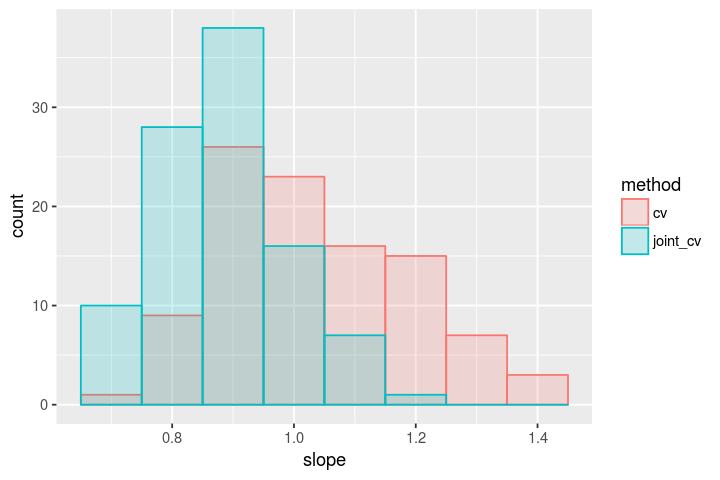

In [33]:
data.frame(cv = cv_slope_vs, joint_cv = joint_slope_vs) %>% 
    gather(key = 'method', value = 'slope') %>%
    ggplot() + geom_histogram(aes(x = slope, color = method, fill = method), 
                              position = 'identity', alpha = 0.2, binwidth = 0.1)